c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


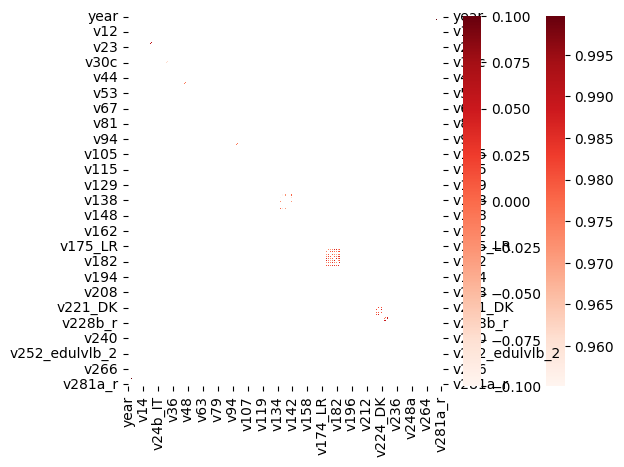

In [4]:
# %%
# Import packages
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set options
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

train_x_raw = pd.read_csv("X_train.csv", low_memory = True, index_col=0)
train_y_raw = pd.read_csv("y_train.csv", low_memory = True, index_col=0)
test_x_raw = pd.read_csv("X_test.csv", low_memory=True, index_col=0)

df_train = pd.DataFrame(train_x_raw)
df_test = pd.DataFrame(test_x_raw)
df_y = pd.DataFrame(train_y_raw)

############################################################# FUNCTIONS ###############################################################

### Function to find the targeted colname
def find_colname_start(data, target):
  temp = []
  for varname in data.columns:
      if varname.startwith(target):
        temp.append(varname)
  return(temp)
  
def find_colname_end(data, target):
  temp = []
  for varname in data.columns:
      if varname.endswith(target):
        temp.append(varname)
  return(temp)

from collections import Counter

def merge_columns(dat, colname):
    for name in colname:
        name_org = name.replace("_11c", "")
        dat.loc[dat[name_org] == -4, name_org] = dat.loc[dat[name_org] == -4, name]


def print_diff(varname):
  print(set(df_train[varname].unique()).difference(set(df_test[varname].unique())))

def cumulatively_categorise(column,threshold=0.80,return_categories_list=True):
  #Find the threshold value using the percentage and number of instances in the column
  threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories 
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s=0
  #Create a counter dictionary of the form unique_value: frequency
  counts=Counter(column)

  #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the global sum
    s+=dict(counts)[i]
    #Append the category name to the list
    categories_list.append(i)
    #Check if the global sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
      break
  #Append the category Other to the list
  categories_list.append(-100)

  #Replace all instances not in our new categories by Other  
  new_column=column.apply(lambda x: x if x in categories_list else -100)

  #Return transformed column and unique values if return_categories=True
  if(return_categories_list):
    return new_column,categories_list
  #Return only the transformed column if return_categories=False
  else:
    return new_column
  
def simpleAggregation_helper(var, threshold):
  train=df_train[var]
  test=df_test[var]
  cat = [train, test]
  df = pd.concat(cat)
  transformed_column=cumulatively_categorise(df, threshold, return_categories_list=False)
  tc_train=transformed_column[0:len(train)]
  tc_test=transformed_column[len(train):len(train)+len(test)]
  df_train[var]=tc_train
  df_test[var]=tc_test

  
def simpleAggregation(variable, threshold=0.8):
    if isinstance(variable, str):
      simpleAggregation_helper(variable, threshold)
    elif isinstance(variable, list):
      for varname in variable:
        simpleAggregation_helper(varname, threshold)
        
### Convert fw_start ==> Start month of fw
### Convert fw_end ==> Duration of fw
def timeEDA(data):
    fw_start = data['fw_start']
    fw_end = data['fw_end']
    fieldwork_start_month = []
    fw_duration = []
    for obs in range(0, len(fw_end)):
        fw_start_year = int(str(fw_start[obs])[0:4])
        fw_start_month = int(str(fw_start[obs])[4:6])
        fw_end_year = int(str(fw_end[obs])[0:4])
        fw_end_month = int(str(fw_end[obs])[4:6])
        duration_year = fw_end_year - fw_start_year
        duration_month = fw_end_month - fw_start_month
        duration = 12*duration_year + duration_month
        fieldwork_start_month.append(fw_start_month)
        fw_duration.append(duration)
    data['fw_start'] = fieldwork_start_month
    data['fw_end'] = fw_duration
    data.rename(columns={'fw_start':'fw_start_month', 'fw_end':'fw_duration'}, inplace=True)


##############################################################################################################################

# %% [markdown]
############################################################ EDA-AMY ############################################################
# ### Age-related variables processing

# %%
# v226 year of birth respondent (Q64)
# age age:respondent
# age_r age recorded (6 intervals)
# age_r2 age recoded (3 intervals)
# age_r3 age recoded (7 intervals)

ages = ['v226', 'age', 'age_r', 'age_r2', 'age_r3']
#df_train.drop(columns=ages_to_drop, inplace=True)
#df_test.drop(columns=ages_to_drop, inplace=True)
# DECIDE WHICH ONE TO KEEP AFTER EVALUATING 


columns_to_drop = ['c_abrv', 'f46_IT', 'v72_DE', 'v73_DE', 'v74_DE', 'v75_DE', 'v76_DE', 'v77_DE', 'v78_DE', 'v79_DE']
df_train.drop(columns=columns_to_drop, inplace=True)
df_test.drop(columns=columns_to_drop, inplace=True)

# %% [markdown]
# ### Education level-related variables drop

# v243*: educational level respondent: ... with variations



# %%
# keep v243_ISCED_3: educational level respondent: ISCED-code three digit  
v243_to_drop = ['v243_edulvlb', 'v243_edulvlb_2', 'v243_edulvlb_1', 'v243_ISCED_2', 'v243_ISCED_2b','v243_ISCED_1', 'v243_EISCED', 'v243_ISCED97', 'v243_8cat', 'v243_r', 'v243_cs', 'v243_cs_DE1', 'v243_cs_DE2', 'v243_cs_DE3', 'v243_cs_GB1', 'v243_cs_GB2']

df_train.drop(columns=v243_to_drop, inplace=True)
df_test.drop(columns=v243_to_drop, inplace=True)

# %% [markdown]
# ### Job kinds-related variables drop

# %%

# %%
# keep v246_ESeC : kind of job respondent - ESEC08 code  
v246_to_drop = ['v246_ISCO_2', 'v246_SIOPS', 'v246_ISEI', 'v246_egp']

df_train.drop(columns=v246_to_drop, inplace=True)
df_test.drop(columns=v246_to_drop, inplace=True)

# %% [markdown]
# ### Partner Education Level variables drop

# %%


# %%
# keep v252_edulvlb_2: educational level spouse/partner: ESS-edulvlb coding two digits 
v252_to_drop = ['v252_edulvlb', 'v252_edulvlb_1', 'v252_ISCED_3', 'v252_ISCED_2', 'v252_ISCED_2b', 'v252_ISCED_1', 'v252_EISCED', 'v252_ISCED97', 'v252_8cat', 'v252_r', 'v252_cs', 'v252_cs_DE1', 'v252_cs_DE2', 'v252_cs_DE3', 'v252_cs_GB1', 'v252_cs_GB2']

df_train.drop(columns=v252_to_drop, inplace=True)
df_test.drop(columns=v252_to_drop, inplace=True)

# %% [markdown]
# ### Kind of job partner variables drop

# %%

# %%
# keep v255_ESeC: kind of job spouse/partner - ESEC08 code 
v255_to_drop = ['v255_ISCO_2', 'v255_SIOPS', 'v255_ISEI', 'v255_egp']

df_train.drop(columns=v255_to_drop, inplace=True)
df_test.drop(columns=v255_to_drop, inplace=True)

# %% [markdown]
# ### Households income variables to drop



# %%
df_train.drop('v261_ppp', inplace=True, axis=1)
df_test.drop('v261_ppp', inplace=True, axis=1)

# %% [markdown]
# ### education level father/mother variables drop

# %%

# %%
# keep v262_edulvlb_2: educational level father: ESS-edulvlb coding two digits 
v262_to_drop = ['v262_edulvlb', 'v262_edulvlb_1', 'v262_ISCED_3', 'v262_ISCED_2', 'v262_ISCED_2b', 'v262_ISCED_1', 'v262_EISCED', 'v262_ISCED97', 'v262_8cat', 'v262_r', 'v262_cs', 'v262_cs_DE1', 'v262_cs_DE2', 'v262_cs_DE3', 'v262_cs_GB1', 'v262_cs_GB2']

df_train.drop(columns=v262_to_drop, inplace=True)
df_test.drop(columns=v262_to_drop, inplace=True)

# %%

# %%
# keep v263_edulvlb_2:educational level mother: ESS-edulvlb coding two digits
v263_to_drop = ['v263_edulvlb', 'v263_edulvlb_2', 'v263_edulvlb_1', 'v263_ISCED_3', 'v263_ISCED_2', 'v263_ISCED_2b', 'v263_ISCED_1', 'v263_EISCED', 'v263_ISCED97', 'v263_8cat', 'v263_r', 'v263_cs', 'v263_cs_DE1', 'v263_cs_DE2', 'v263_cs_DE3', 'v263_cs_GB1', 'v263_cs_GB2']

df_train.drop(columns=v263_to_drop, inplace=True)
df_test.drop(columns=v263_to_drop, inplace=True)

# %% [markdown]
# ### Interview dates variables drop

# %%
# v277: date of interview 
# v278a: time of interview: start hour 
# v278b: time of interview: start minute 
# v278c_r: time of interview: start  
# v279a: time of interview: end hour 
# v279b: time of interview: end minute 
# v279c_r: time of interview: end 
# v279d_r: time of interview: duration in minutes 

times_to_drop = ['v277', 'v278b', 'v278c_r', 'v279a', 'v279b', 'v279c_r']

df_train.drop(columns=times_to_drop, inplace=True)
df_test.drop(columns=times_to_drop, inplace=True)

#######################################################################################################################################

# %% [markdown]
# ### Age related variables group into intervals

# %%
# v241, v242
# more to add

# %% [markdown]
# ### Imputation / String variable drop

# %%
######################################## EDA - JaiYeon ################################################################################
columns_to_drop = ['v228b', 'v231b', 'v233b', 'v251b', 'f252_edulvlb_CH', 'v275b_N1', 'v275b_N2', 'v275c_N2', 'v281a']
df_train.drop(columns=columns_to_drop, inplace=True)
df_test.drop(columns=columns_to_drop, inplace=True)

## removed the column having 'GB'
df_train.drop(list(df_train.filter(regex='DE')), axis=1, inplace=True)
df_test.drop(list(df_test.filter(regex='DE')), axis=1, inplace=True)

## removed the column having 'GB'
df_train.drop(list(df_train.filter(regex='GB')), axis=1, inplace=True)
df_test.drop(list(df_test.filter(regex='GB')), axis=1, inplace=True)

# Imputation 
df_train.fillna({'v231b_r': -3}, inplace=True)
df_test.fillna({'v231b_r': -3}, inplace=True)

df_train.fillna({'v233b_r': -3}, inplace=True)
df_test.fillna({'v233b_r': -3}, inplace=True)

df_train.fillna({'v251b_r': -3}, inplace=True)
df_test.fillna({'v251b_r': -3}, inplace=True)

df_train.fillna({'v228b_r': -3}, inplace=True)
df_test.fillna({'v228b_r': -3}, inplace=True)

# %%
######################################## EDA - JEONGHAN ########################################
merge_colname = find_colname_end(df_train, '_11c')
merge_columns(df_train, merge_colname)
merge_columns(df_test, merge_colname)
# print(find_colname(train_x_raw, 'c', 'endwith'))
# print(find_colname(train_x_raw, '_r', 'endwith'))
### Find variables containing _cs and do SimpleAggregation
# print(find_colname(df_train, '_cs', 'endwith'))
aggregatecol = find_colname_end(df_train, '_cs')
simpleAggregation(aggregatecol) #### TRAIN/TEST BOTH APPLICABLE

timeEDA(df_train)
timeEDA(df_test)
####################################################################################################

corr = df_train.corr()
fig, ax = plt.subplots()
##kot1 = corr[corr>= 0.8]
##kot2 = corr[corr<= -0.8]
mask1 = np.logical_or(corr <= 0.95, corr == 1)
mask2 = np.logical_or(corr >= -0.95, corr == -1)

kot1 = corr.mask(mask1)
kot2 = corr.mask(mask2)
sns.heatmap(kot1, cmap="Reds")
ax2 = ax.twinx()
sns.heatmap(kot2, cmap="Reds")
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

pairs = []

for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):  # i+1 to exclude self-correlation
        if (0.95 <= corr.iloc[i, j] <= 1) or (-1 <= corr.iloc[i, j] <= -0.95):
            pairs.append((corr.columns[i], corr.columns[j]))


set_pairs = []

for e in pairs:
     set_pairs.append(set(e))

x = list(set().union(*set_pairs))

dic = {}
for e in x:
    dic[e] = df_train[e].corr(df_y['label'])

remainder = []
for i in set_pairs:
    i = list(i)
    if abs(dic[i[0]]) > abs(dic[i[1]]):
        remainder.append(i[0])
    else:
        remainder.append(i[1])
dropped = []
for i in set_pairs:
    i = list(i)
    if abs(dic[i[0]]) < abs(dic[i[1]]):
        dropped.append(i[0])
    else:
        dropped.append(i[1])
for e in dropped:
    if not e in df_train.columns :
        continue
    df_train.drop(e, inplace=True, axis=1)
    df_test.drop(e, inplace=True, axis=1)


--------------------------------------------------
col: year


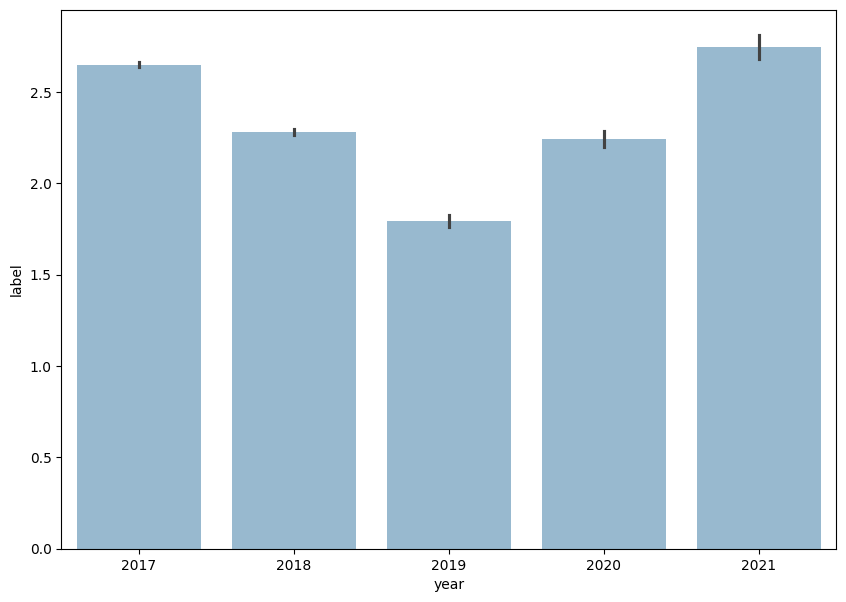

--------------------------------------------------
col: fw_start_month


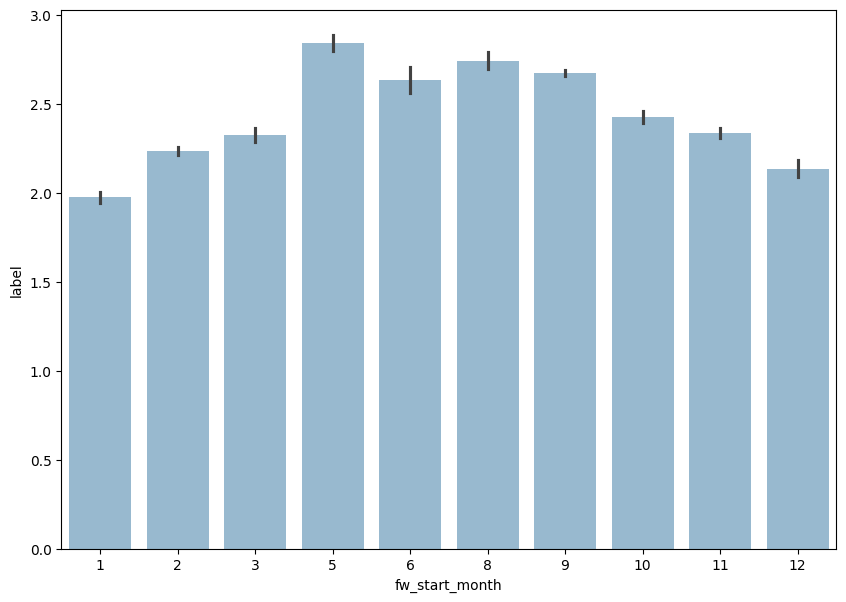

--------------------------------------------------
col: fw_duration


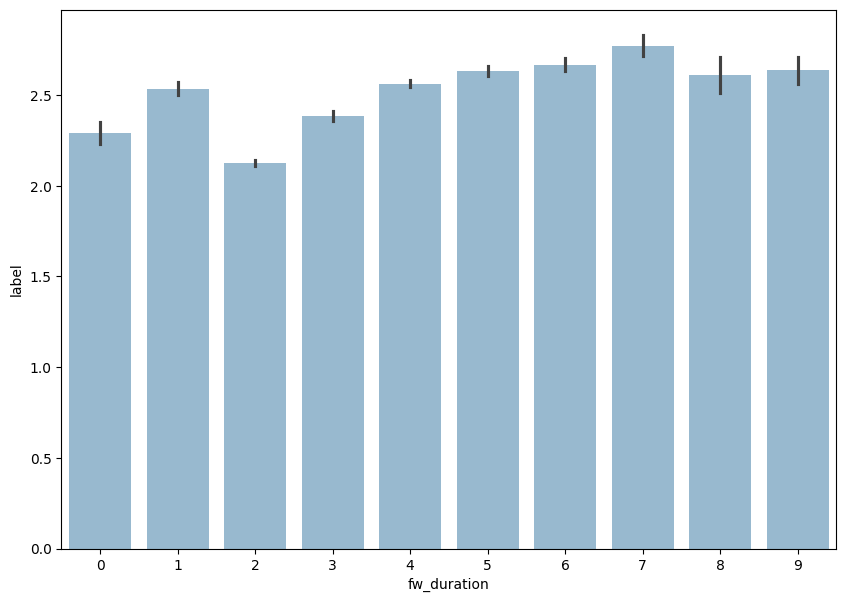

--------------------------------------------------
col: country


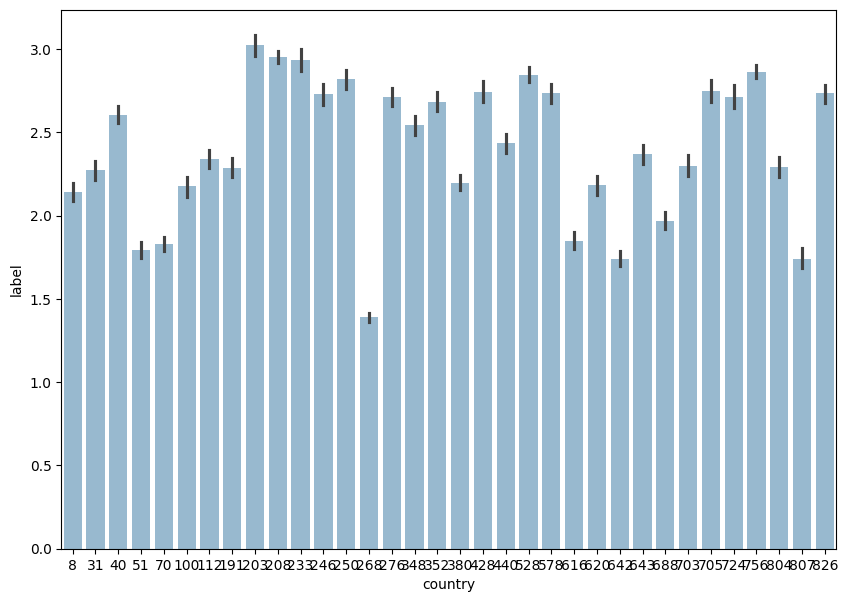

--------------------------------------------------
col: v1


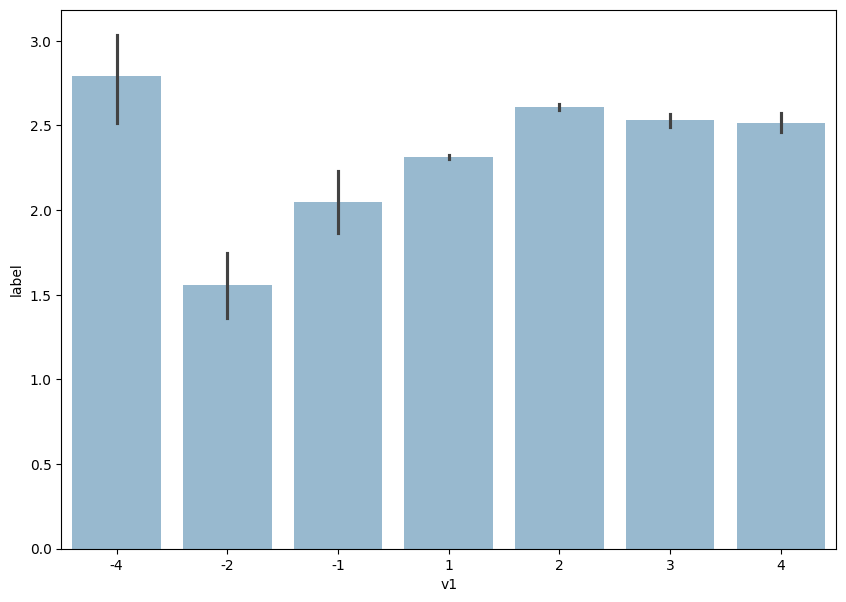

--------------------------------------------------
col: v2


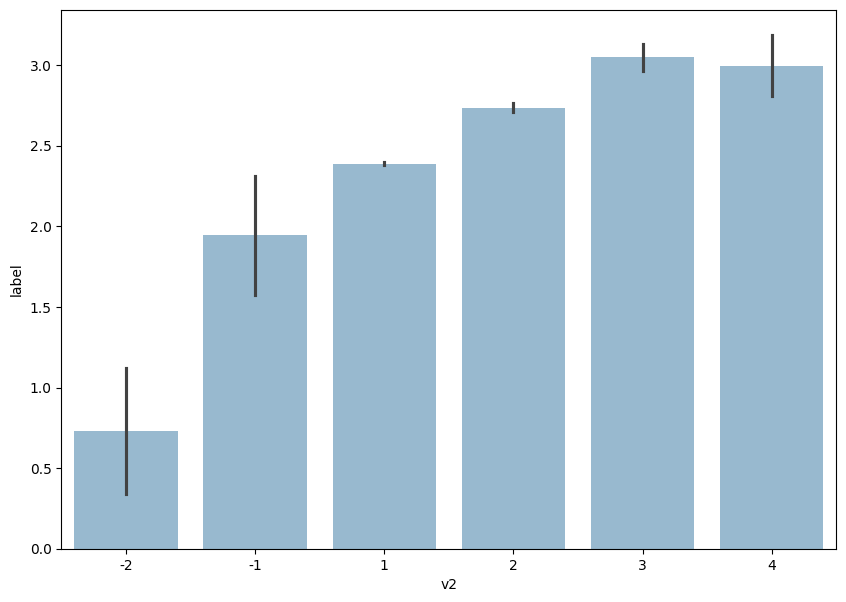

--------------------------------------------------
col: v3


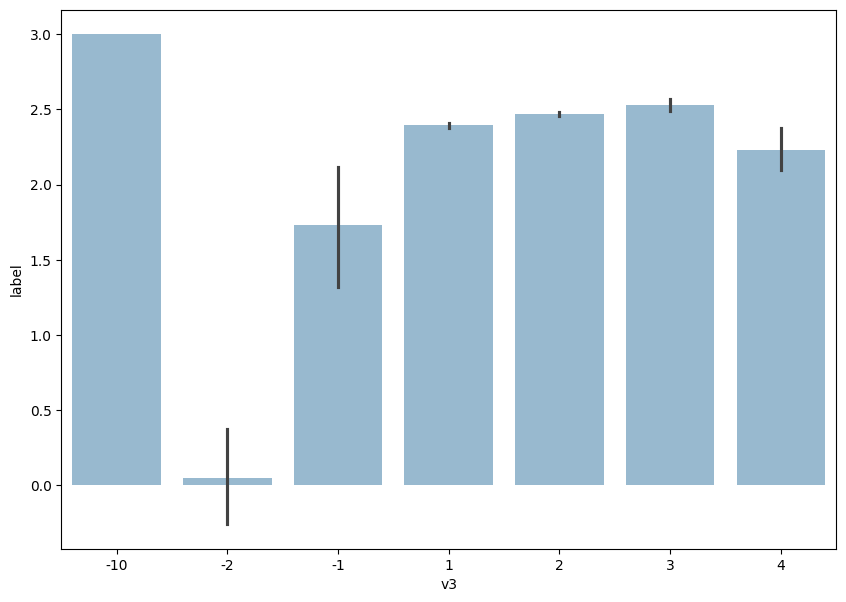

--------------------------------------------------
col: v4


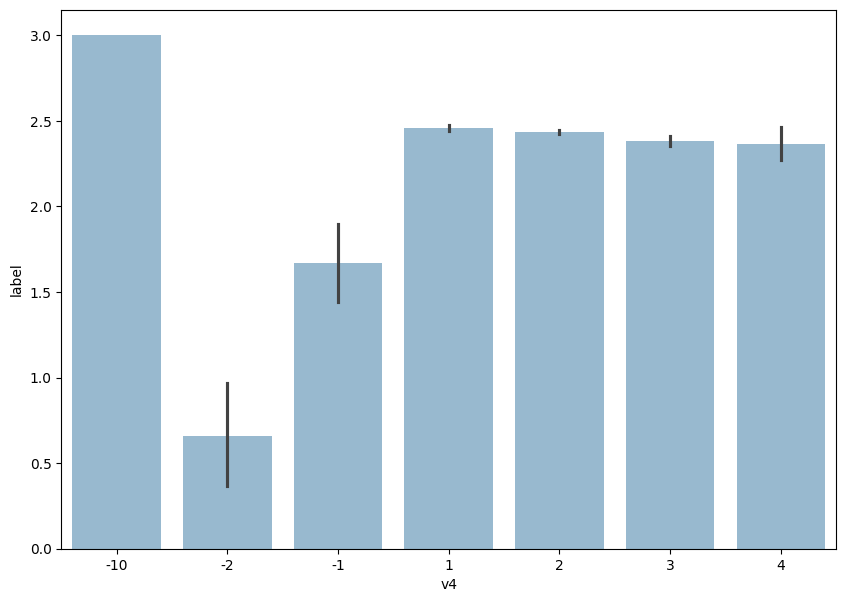

--------------------------------------------------
col: v5


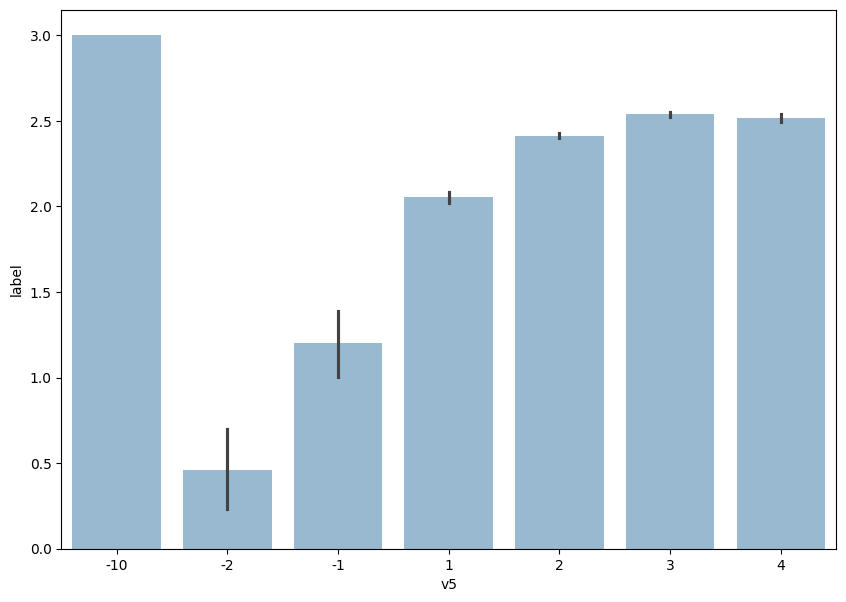

--------------------------------------------------
col: v7


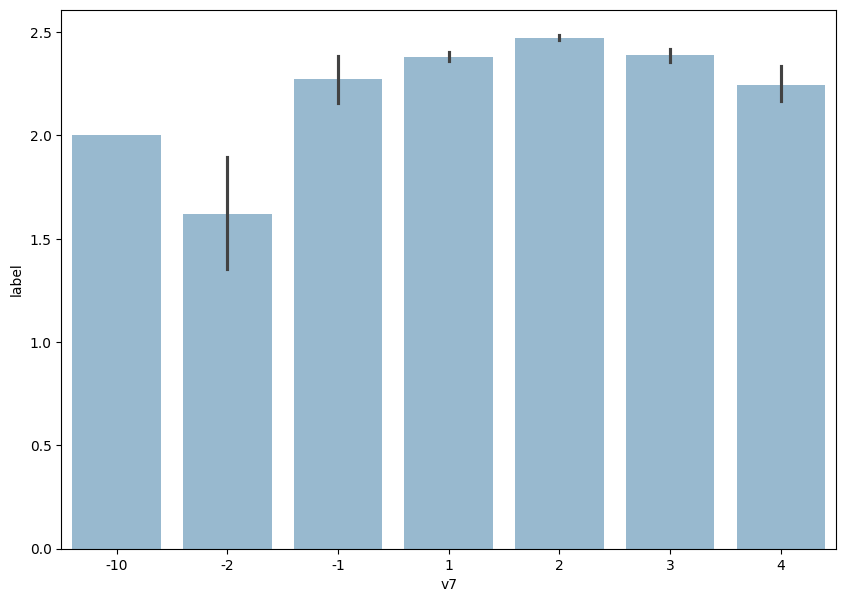

--------------------------------------------------
col: v8


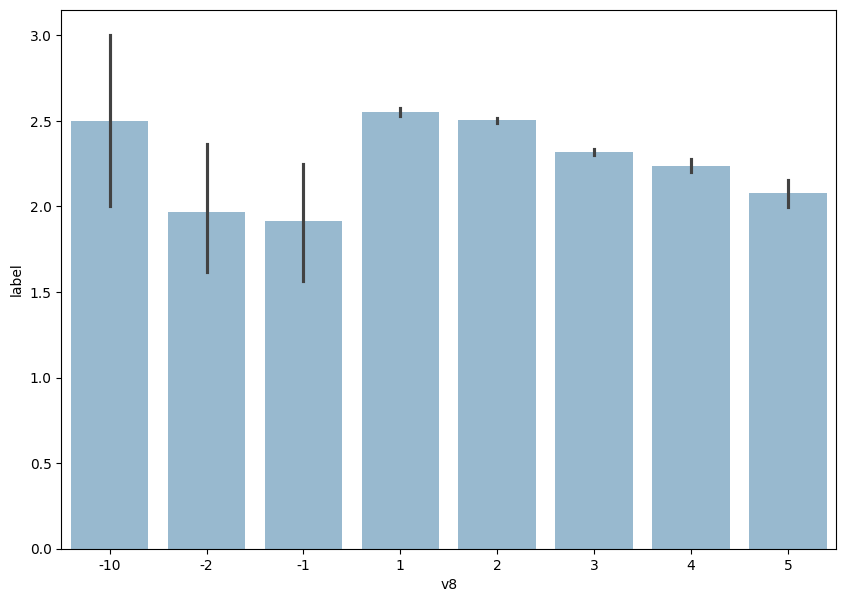

--------------------------------------------------
col: v9


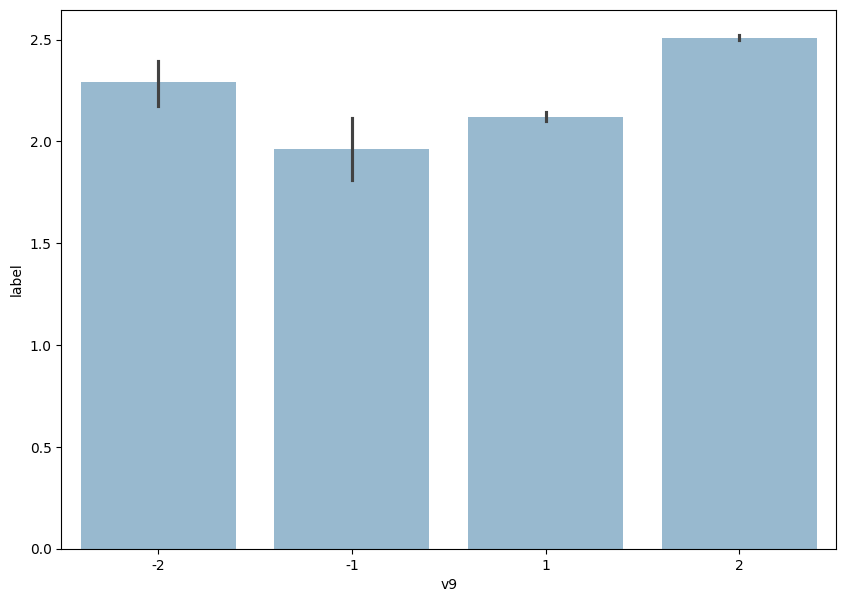

--------------------------------------------------
col: v10


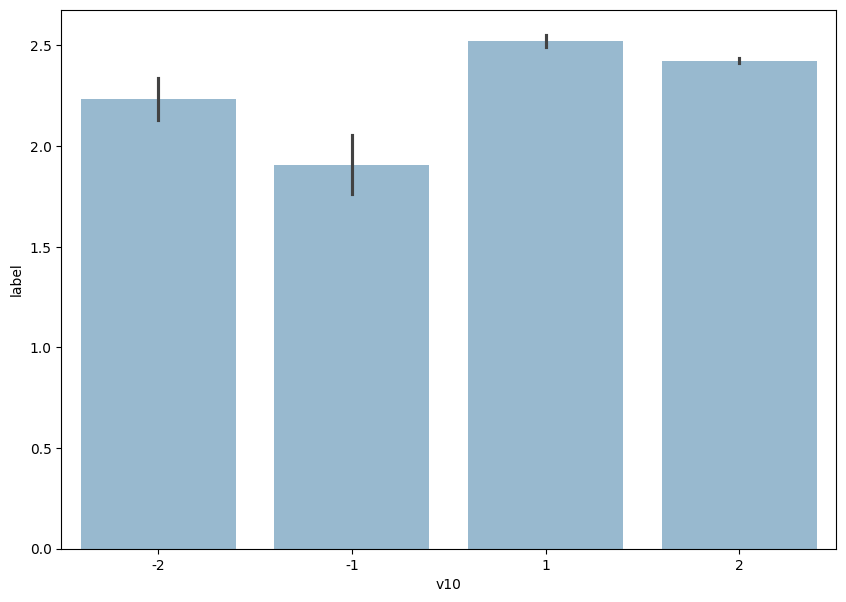

--------------------------------------------------
col: v11


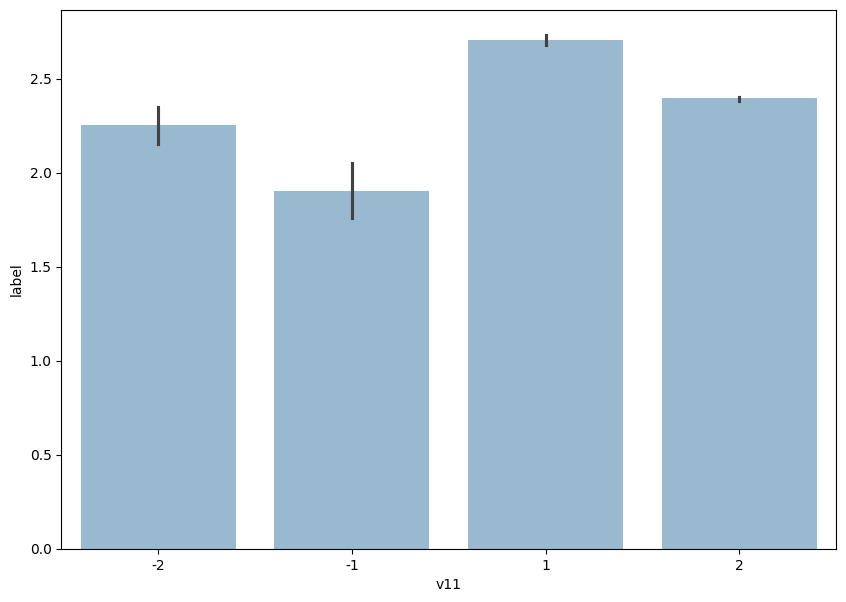

--------------------------------------------------
col: v12


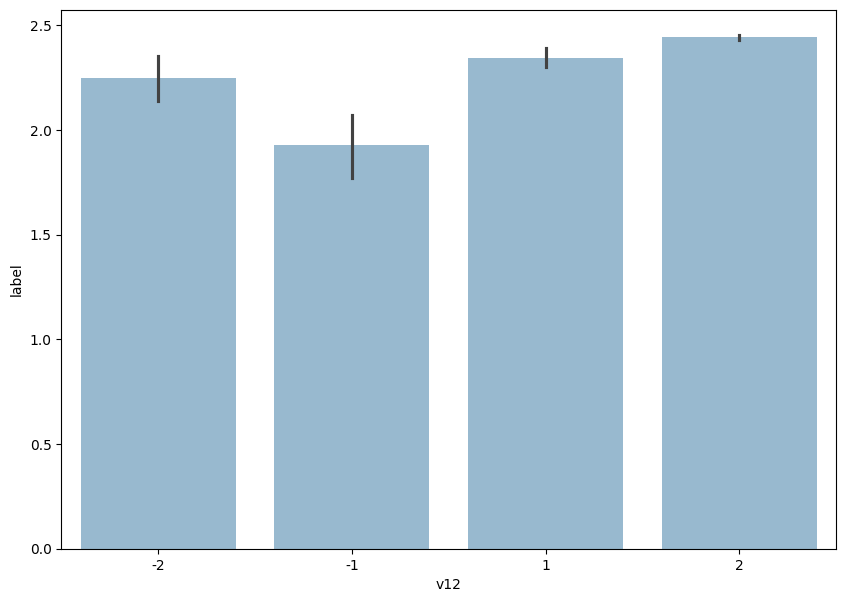

--------------------------------------------------
col: v13


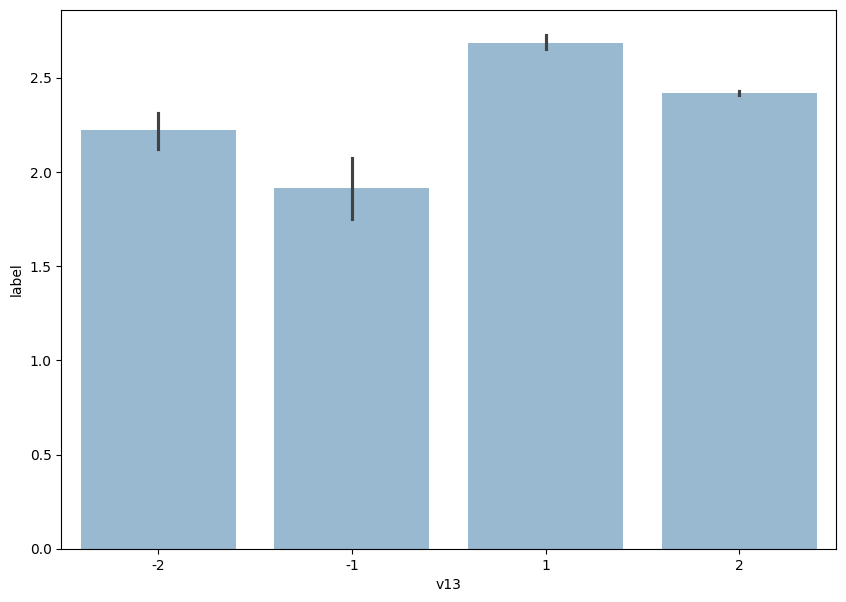

--------------------------------------------------
col: v14


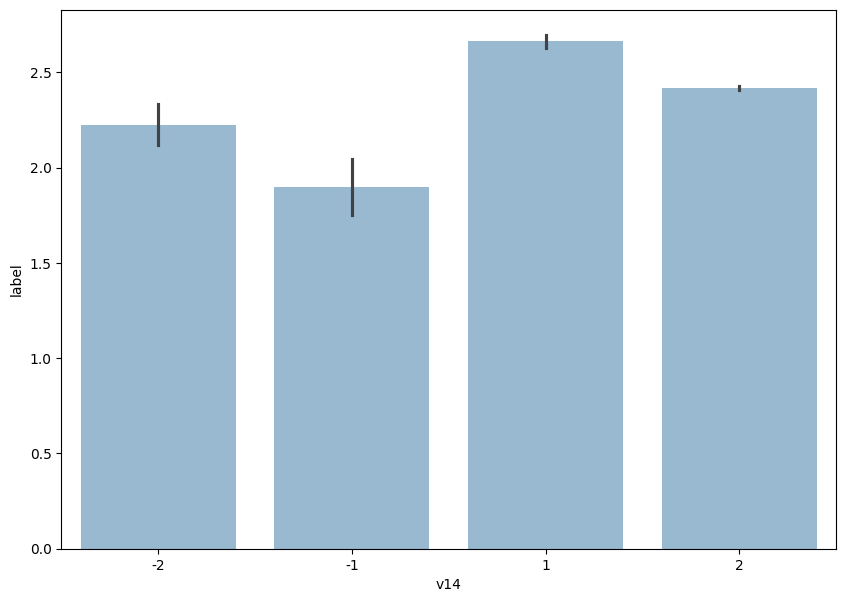

--------------------------------------------------
col: v15


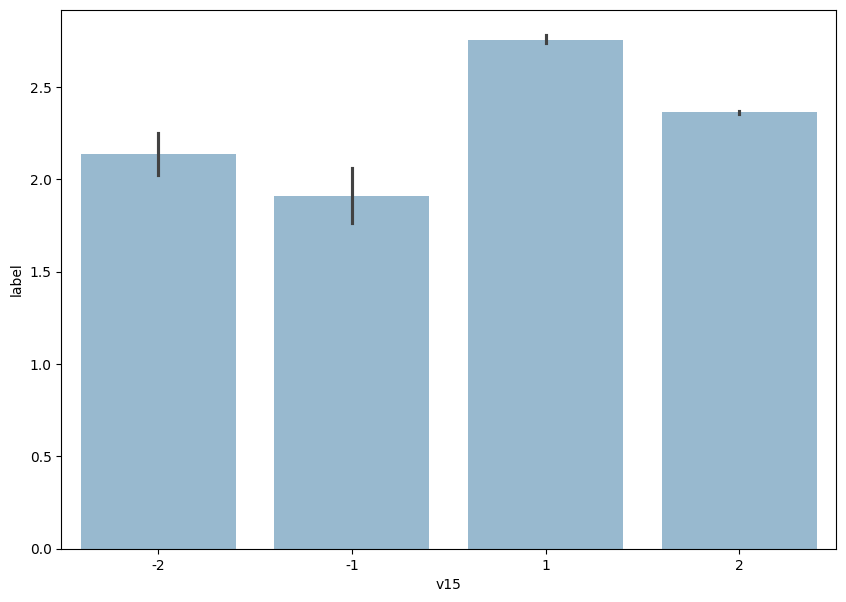

--------------------------------------------------
col: v16


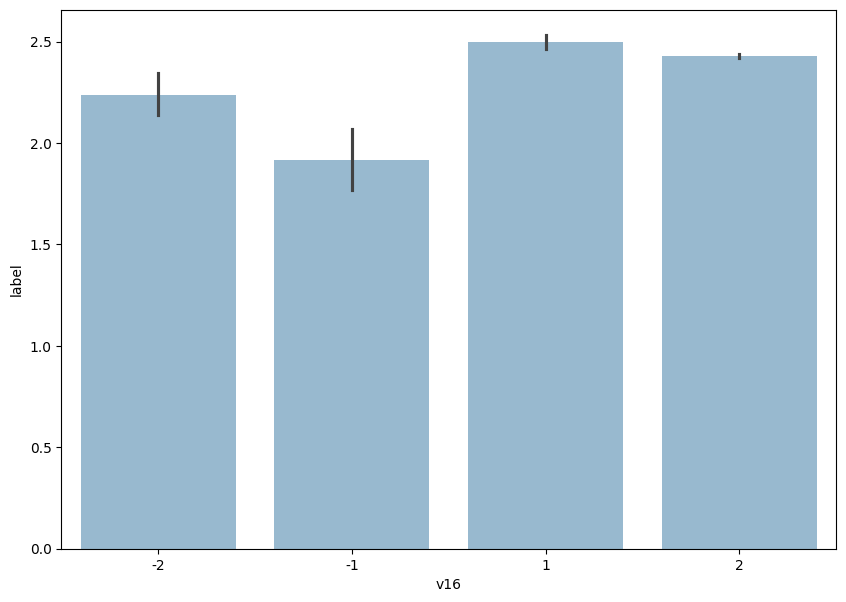

--------------------------------------------------
col: v17


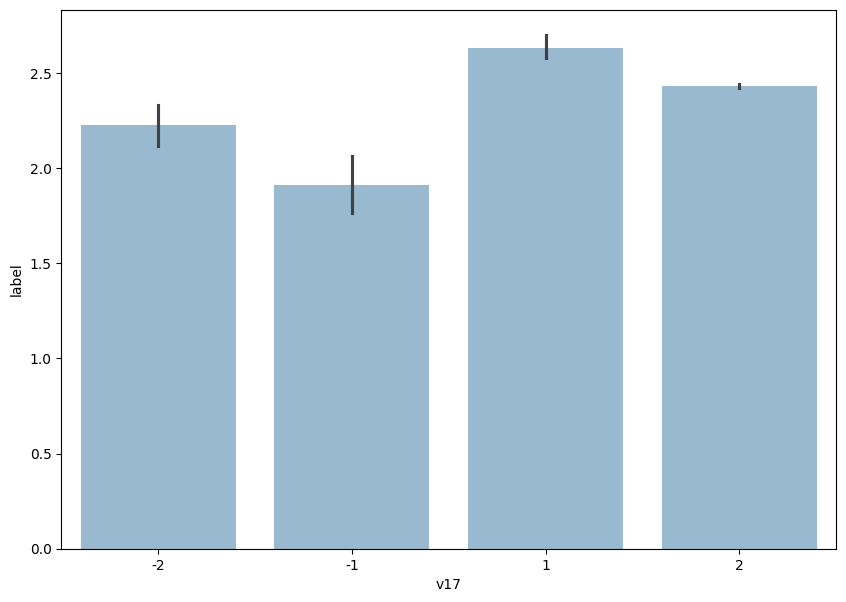

--------------------------------------------------
col: v18


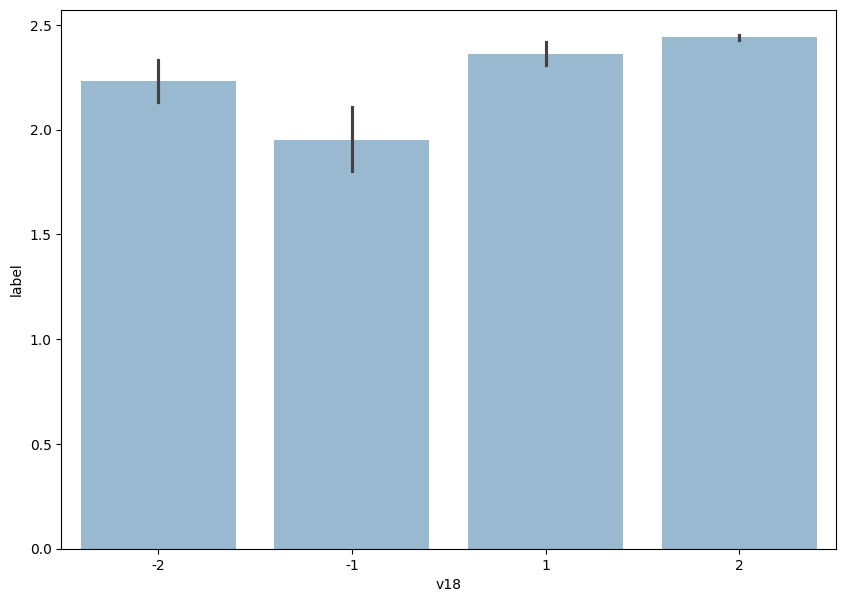

--------------------------------------------------
col: v19


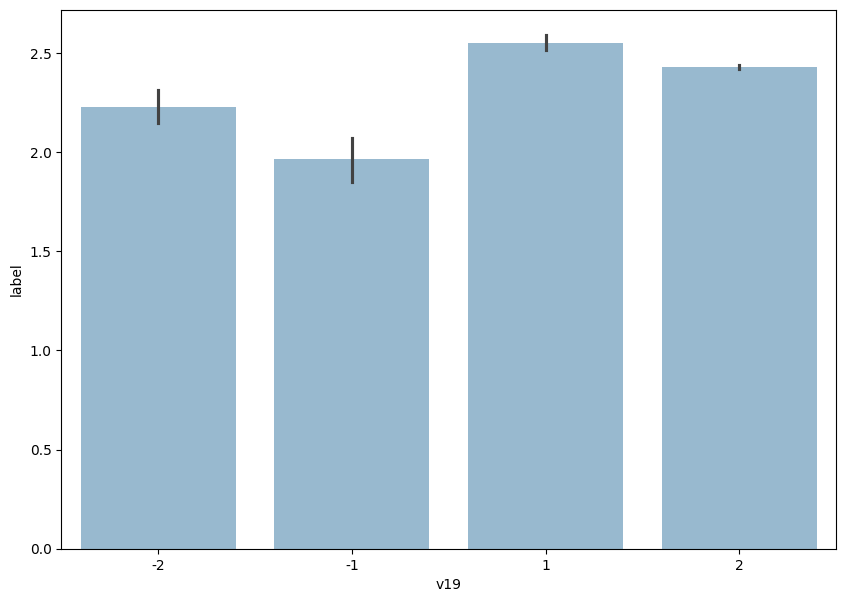

--------------------------------------------------
col: f20


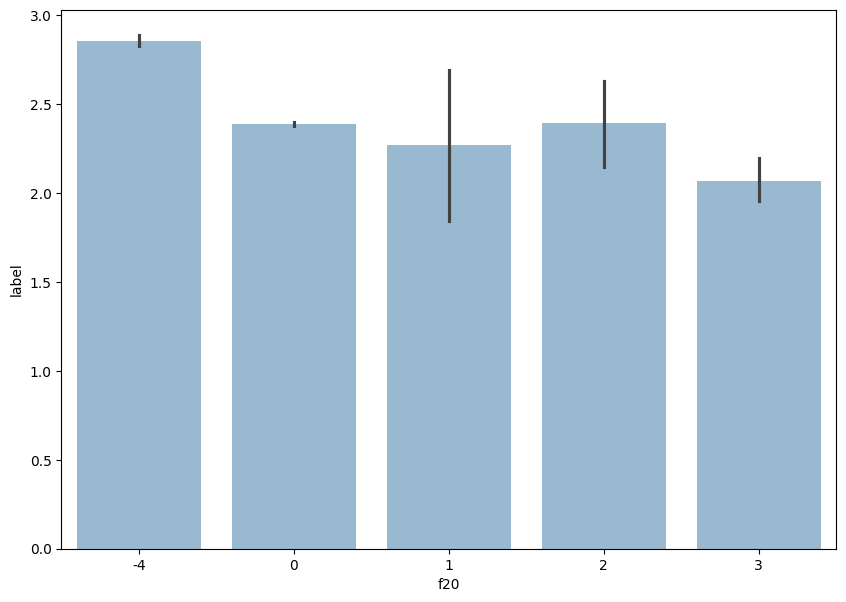

--------------------------------------------------
col: v20


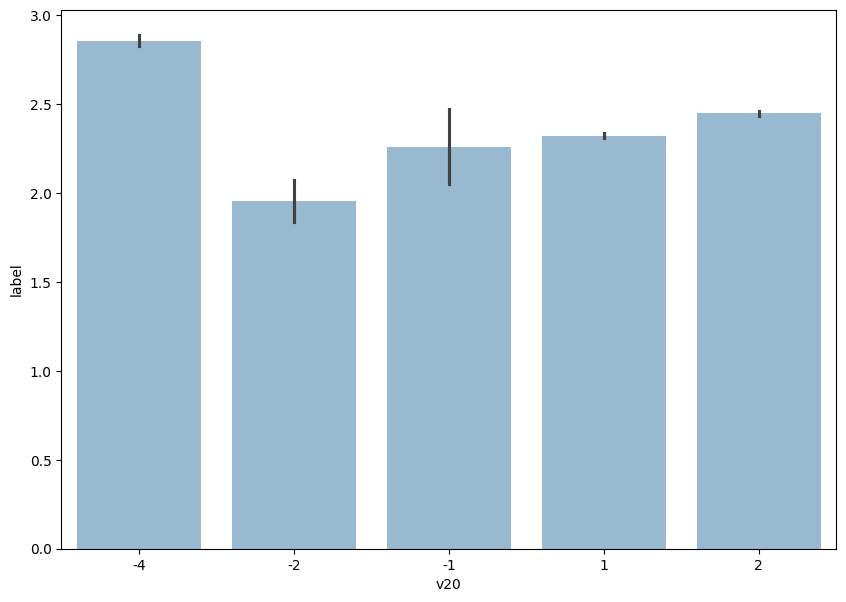

--------------------------------------------------
col: v20b


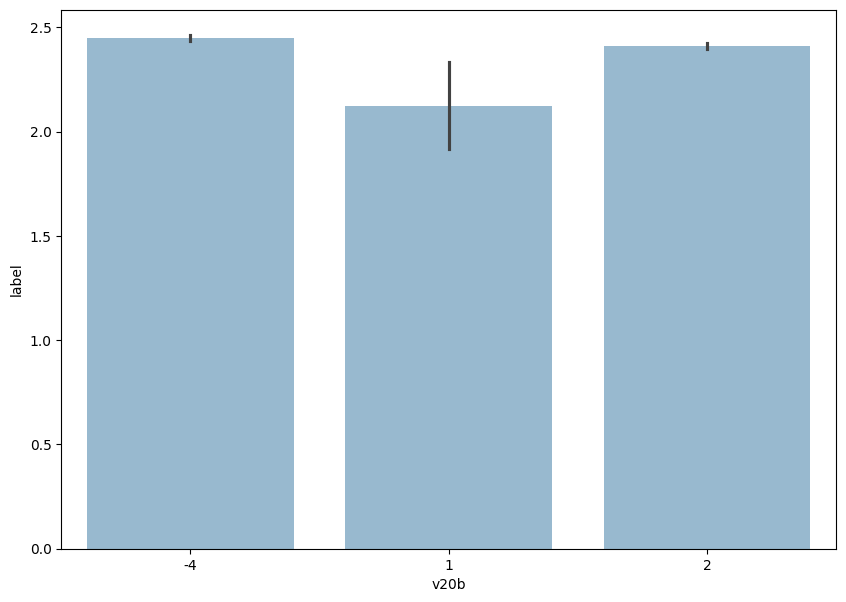

--------------------------------------------------
col: v21


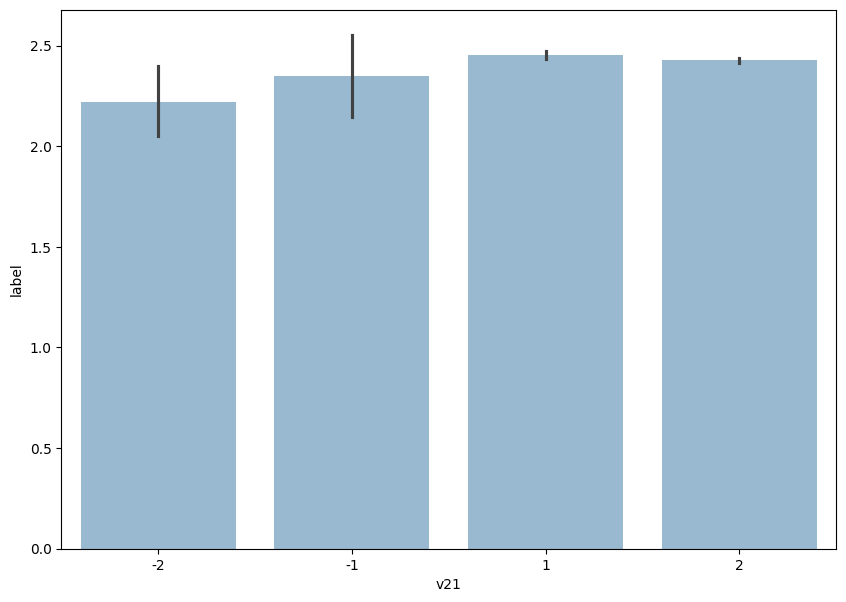

--------------------------------------------------
col: v22


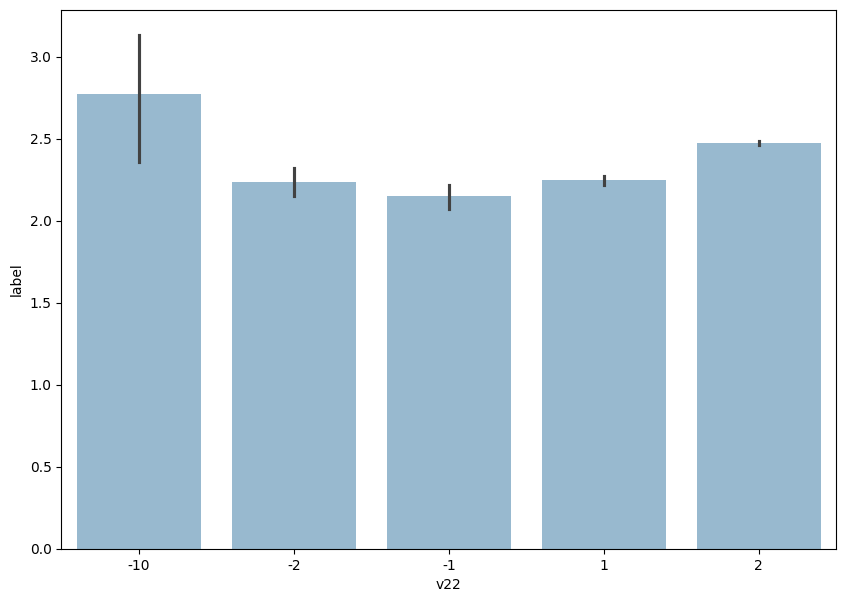

--------------------------------------------------
col: v23


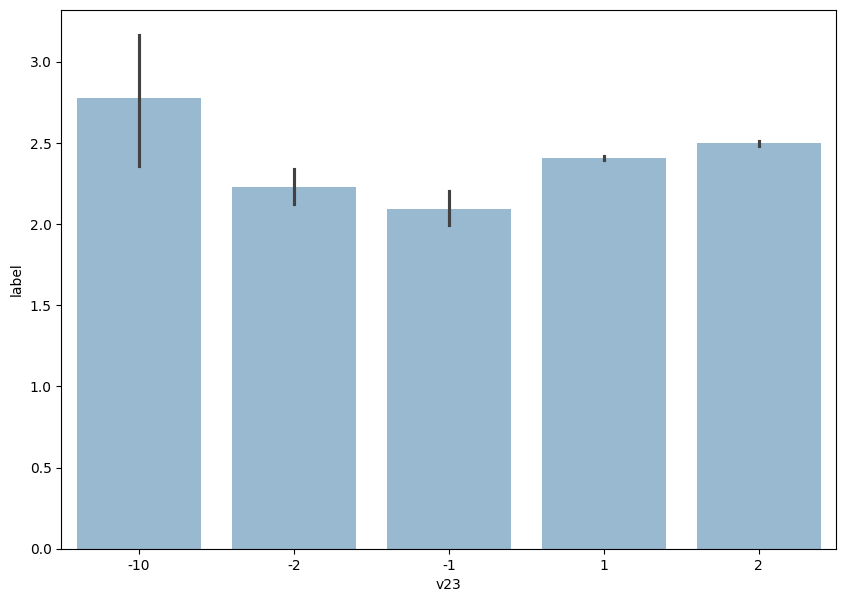

--------------------------------------------------
col: v24


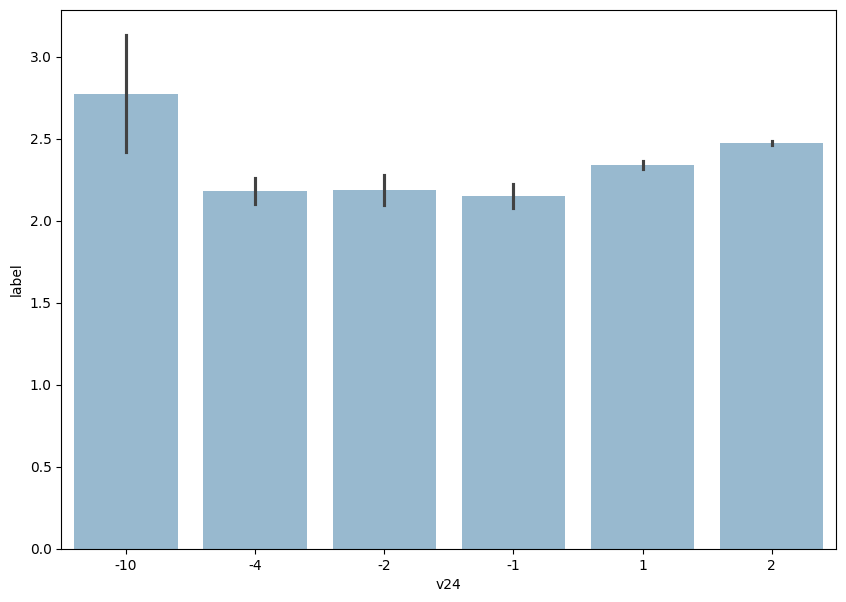

--------------------------------------------------
col: f24_IT


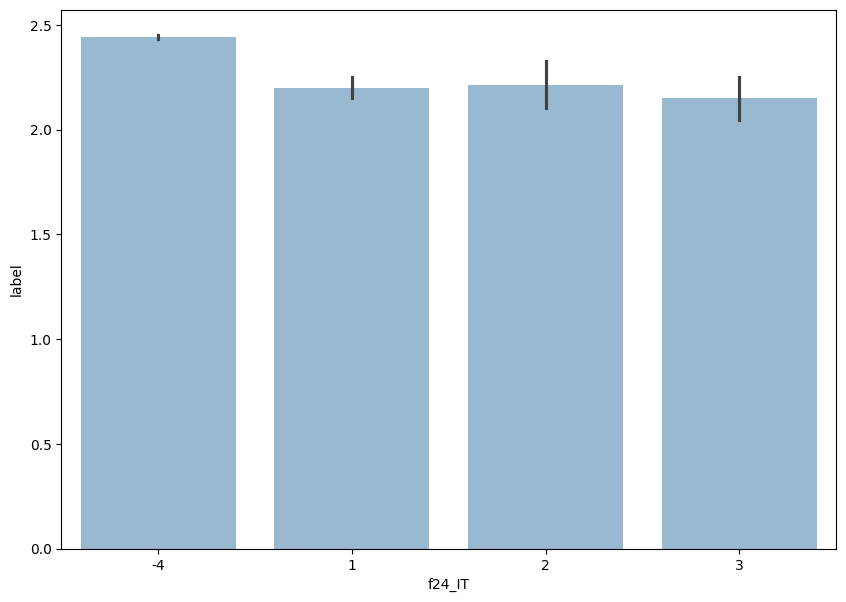

--------------------------------------------------
col: v24a_IT


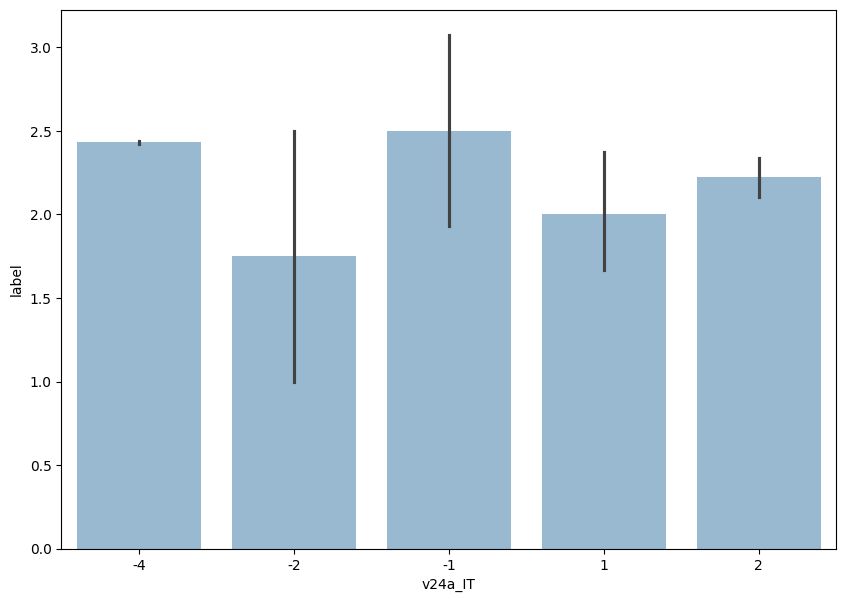

--------------------------------------------------
col: v24b_IT


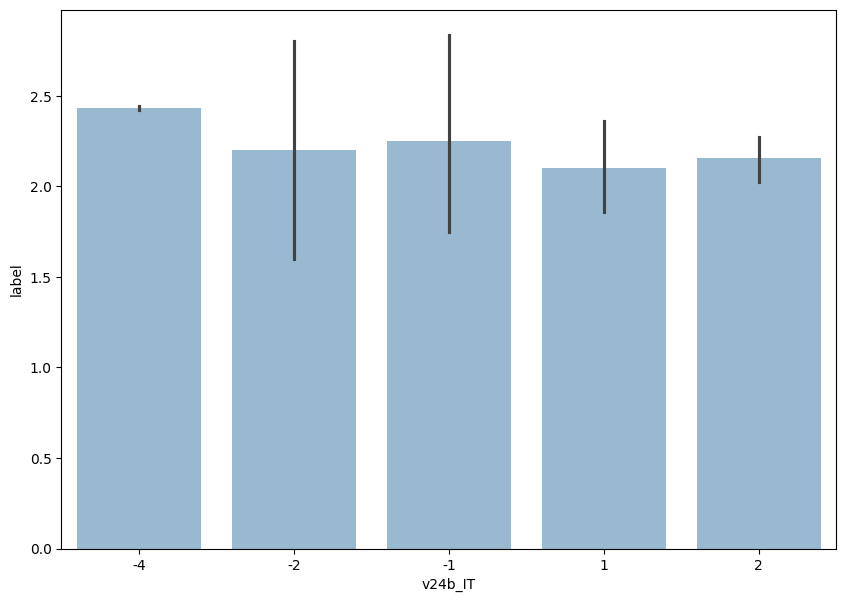

--------------------------------------------------
col: v25


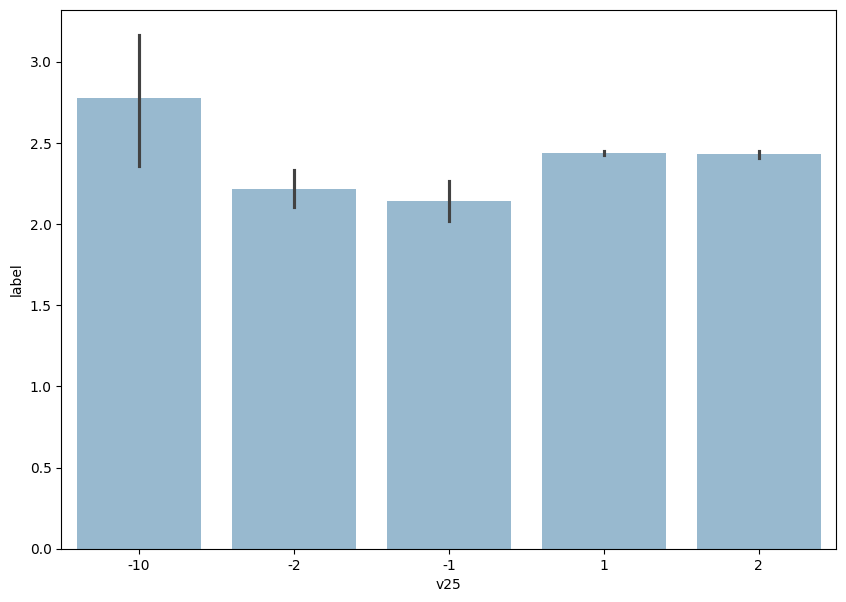

--------------------------------------------------
col: v26


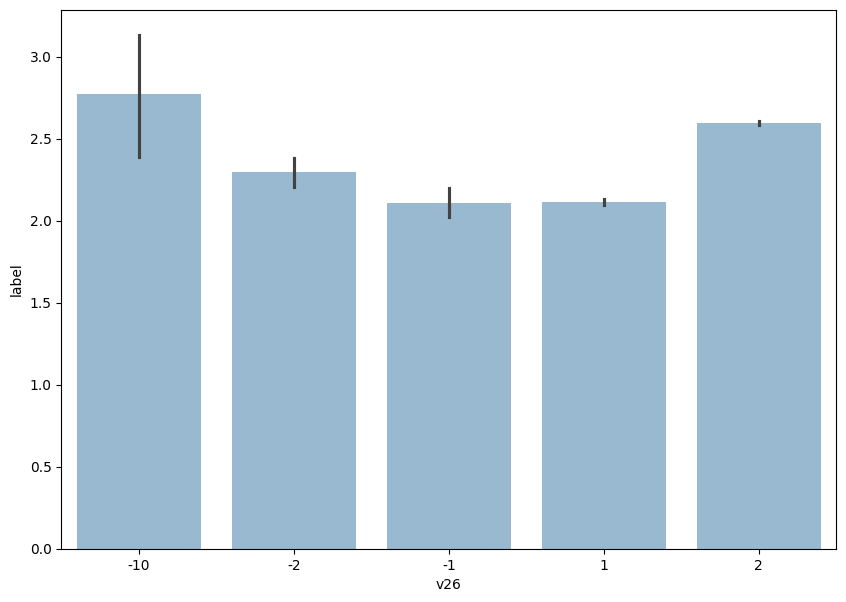

--------------------------------------------------
col: v27


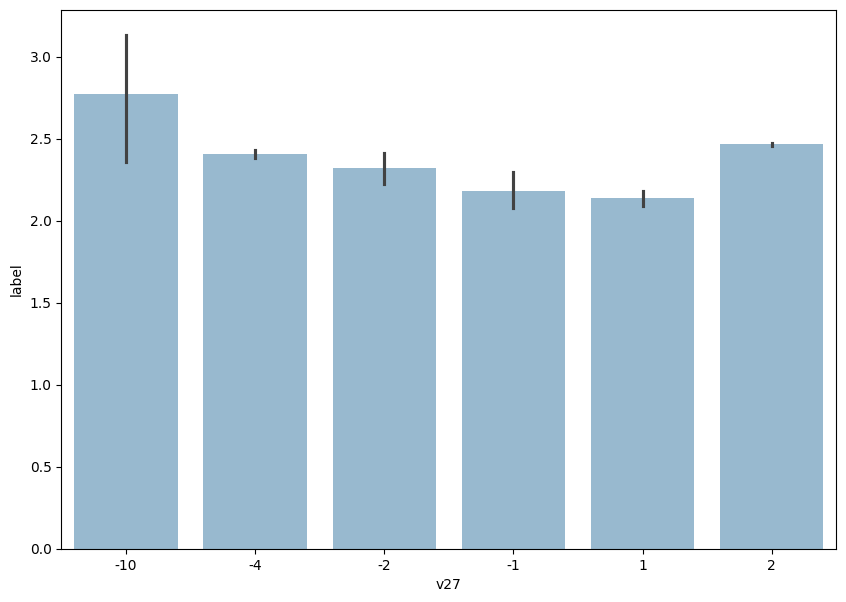

--------------------------------------------------
col: v28


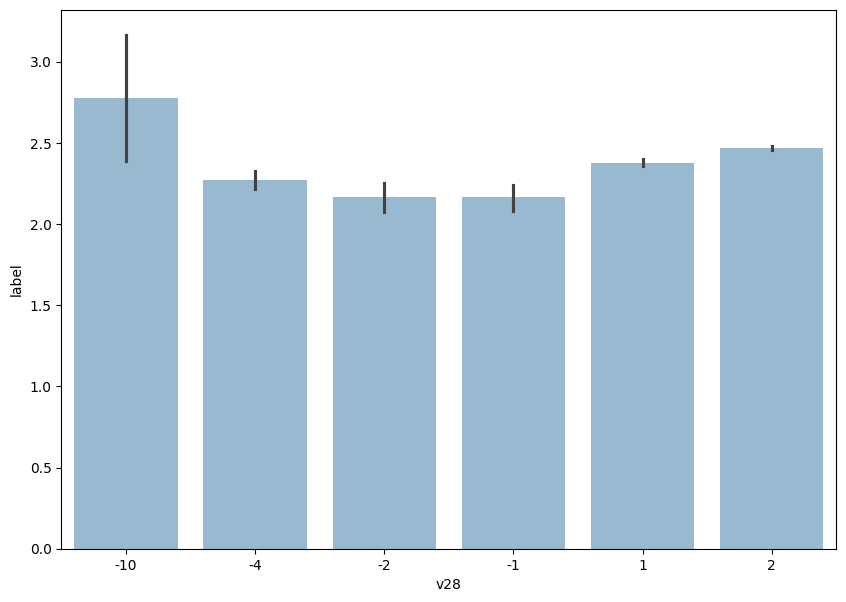

--------------------------------------------------
col: v29


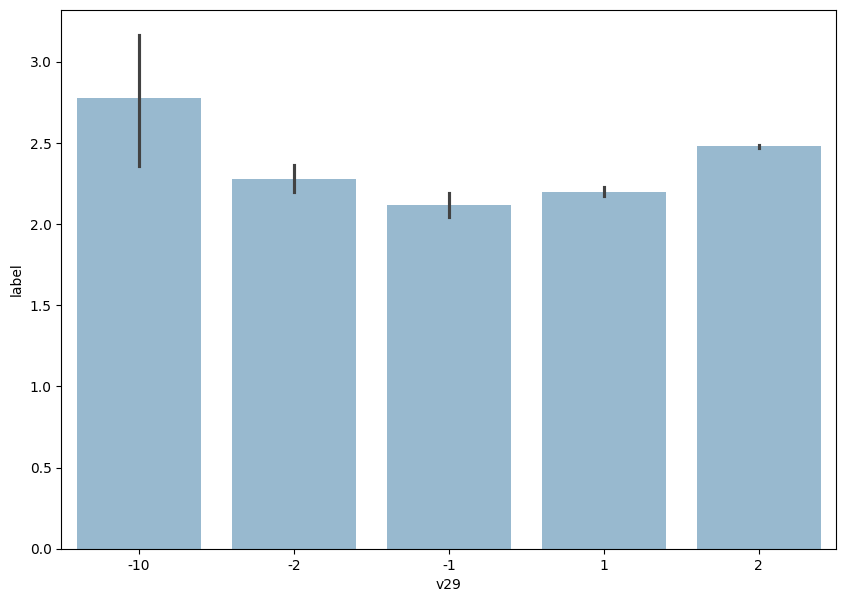

--------------------------------------------------
col: v30


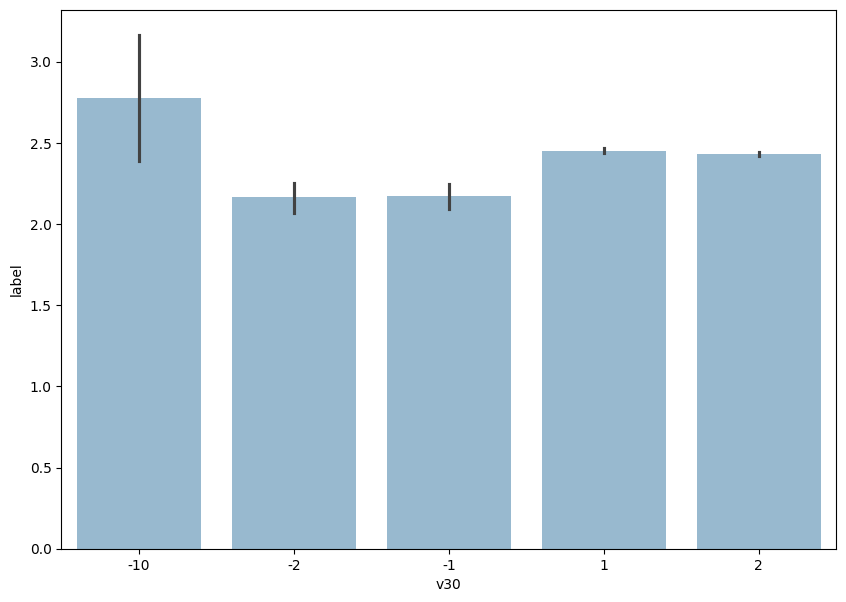

--------------------------------------------------
col: f30a


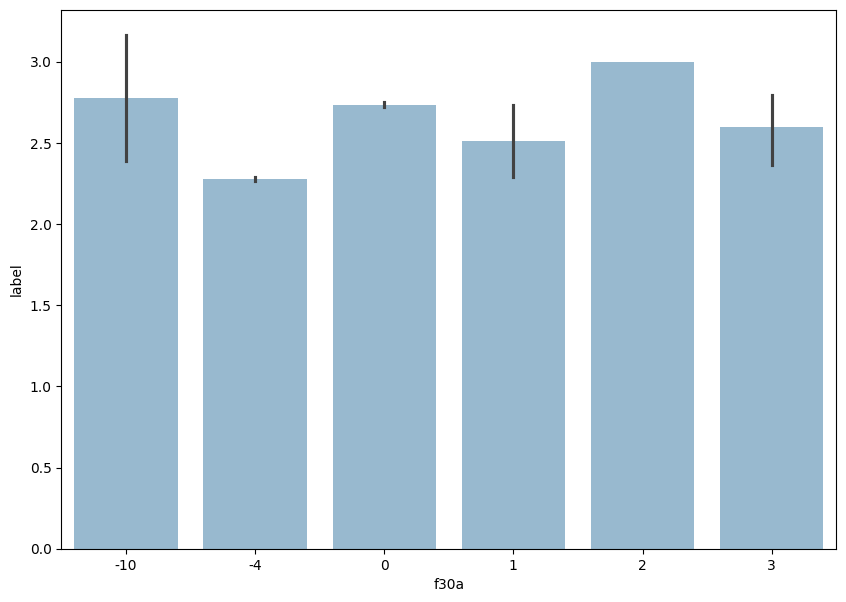

--------------------------------------------------
col: v30a


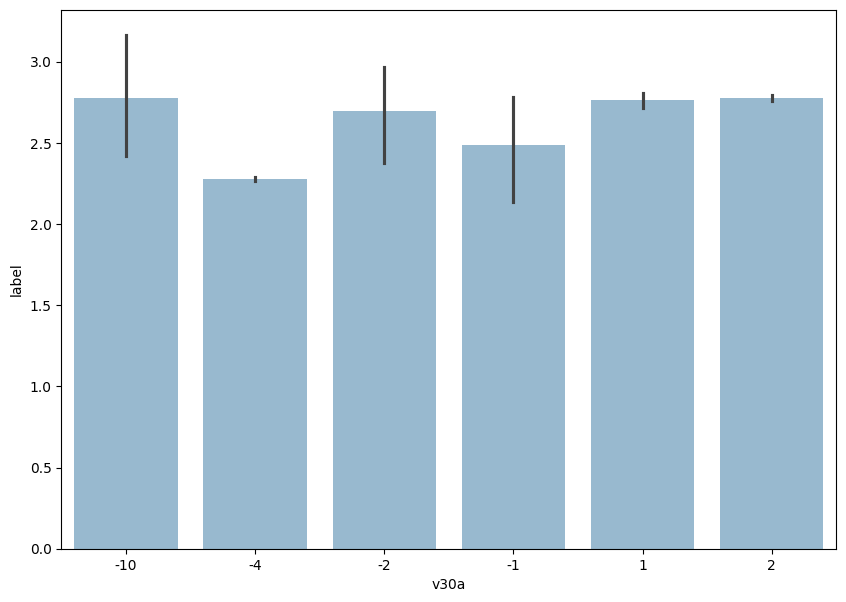

--------------------------------------------------
col: v30c


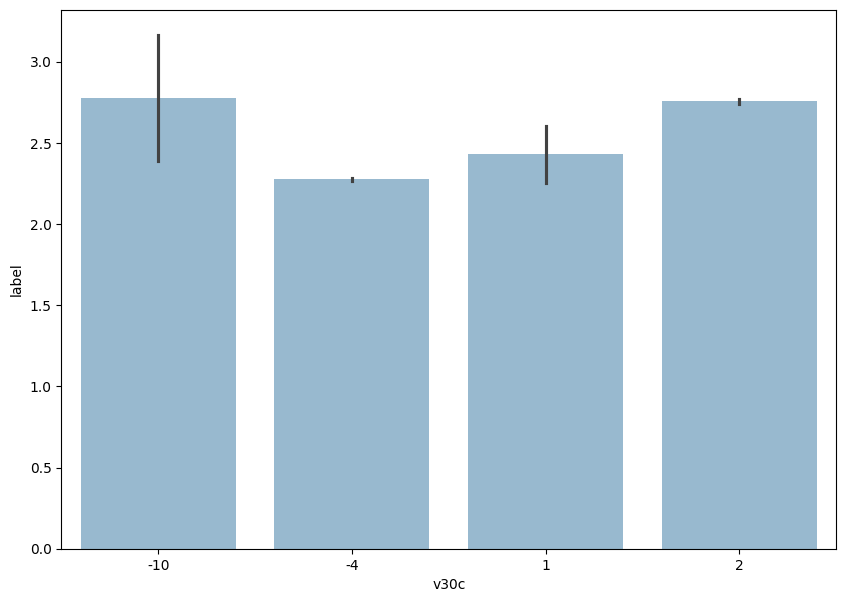

--------------------------------------------------
col: v31


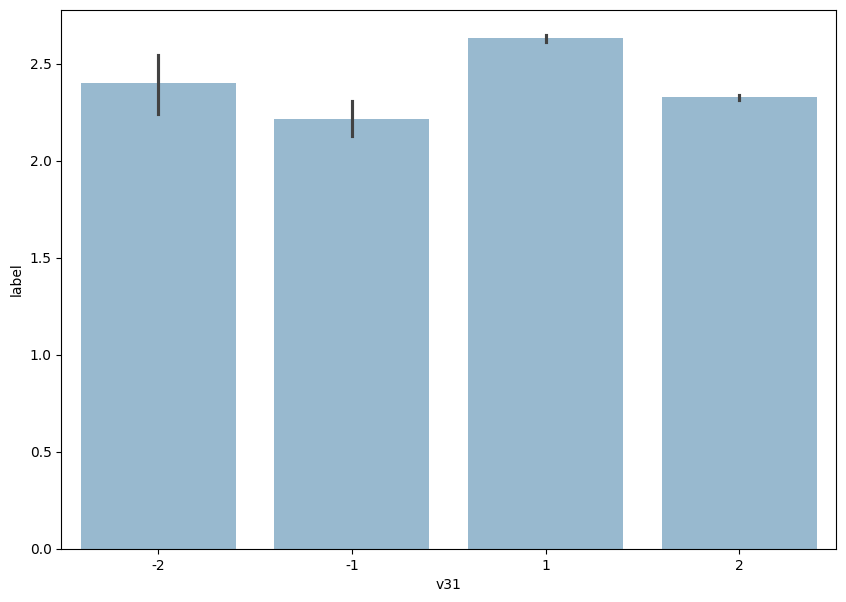

--------------------------------------------------
col: v32


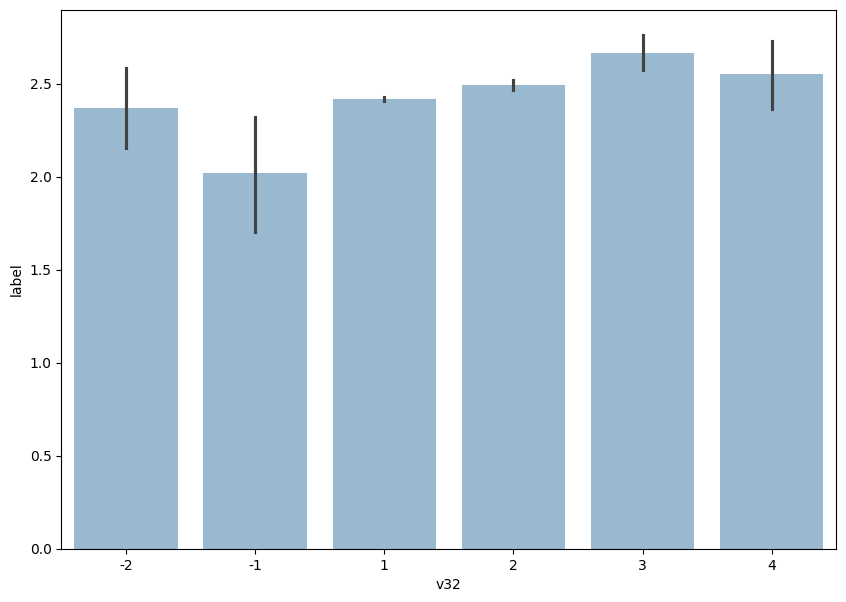

--------------------------------------------------
col: v33


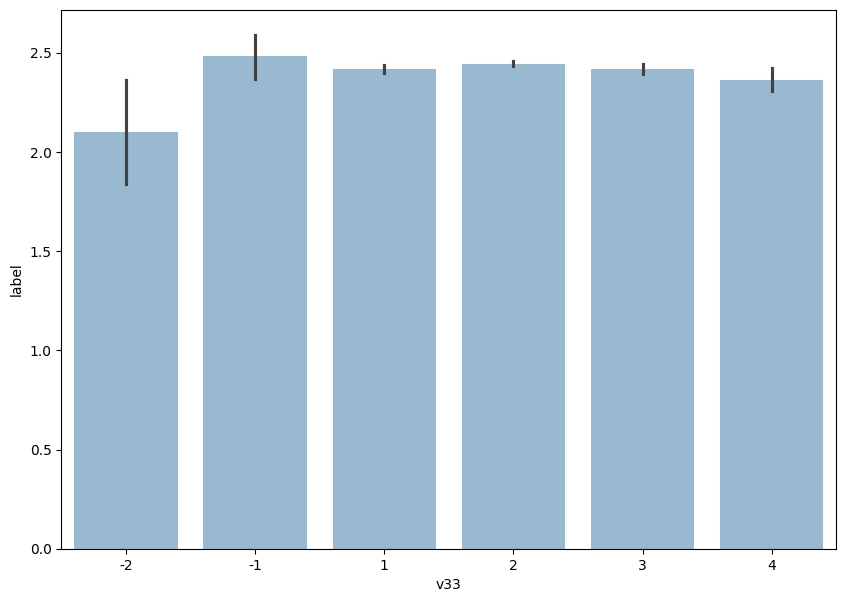

--------------------------------------------------
col: v34


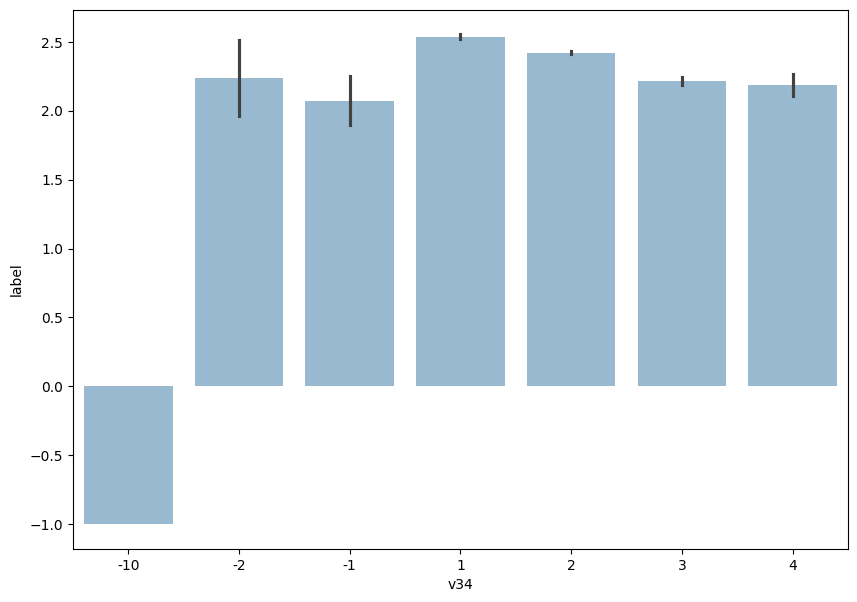

--------------------------------------------------
col: v35


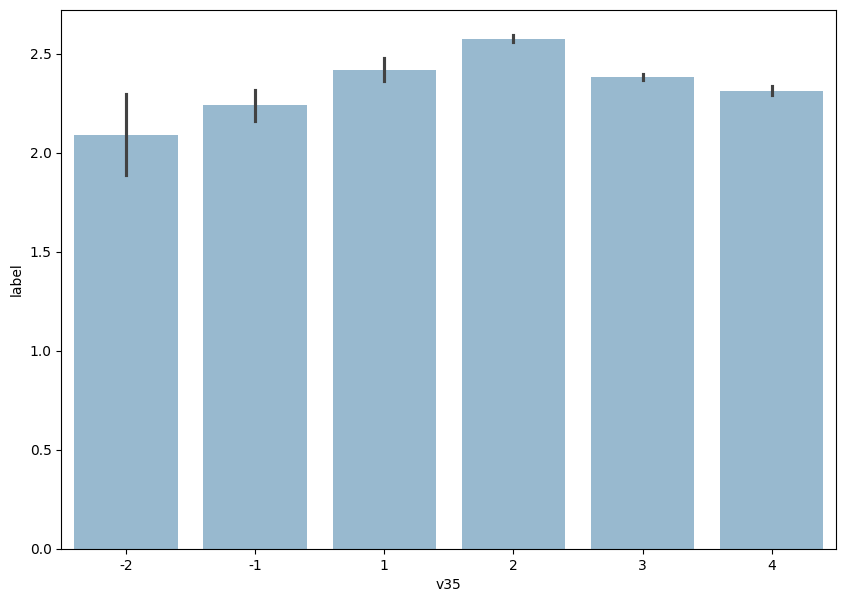

--------------------------------------------------
col: v36


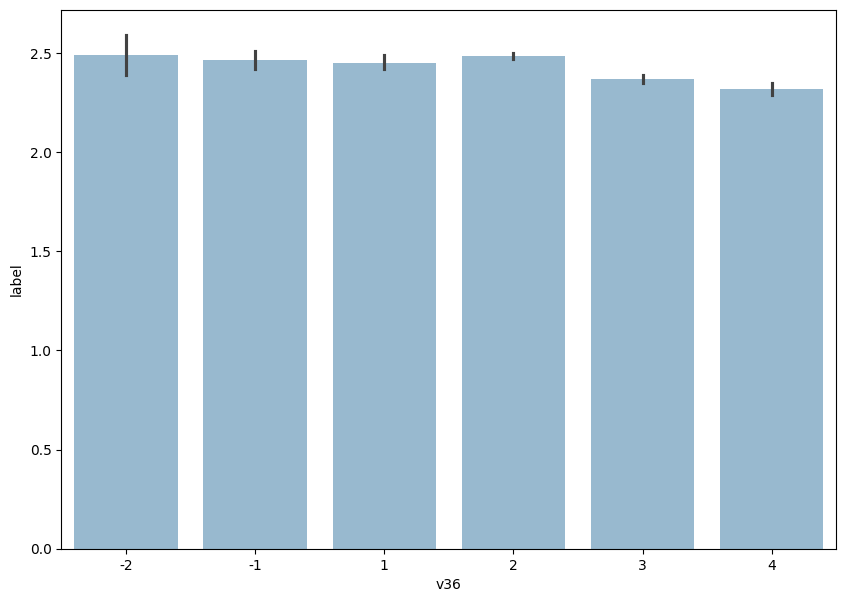

--------------------------------------------------
col: v37


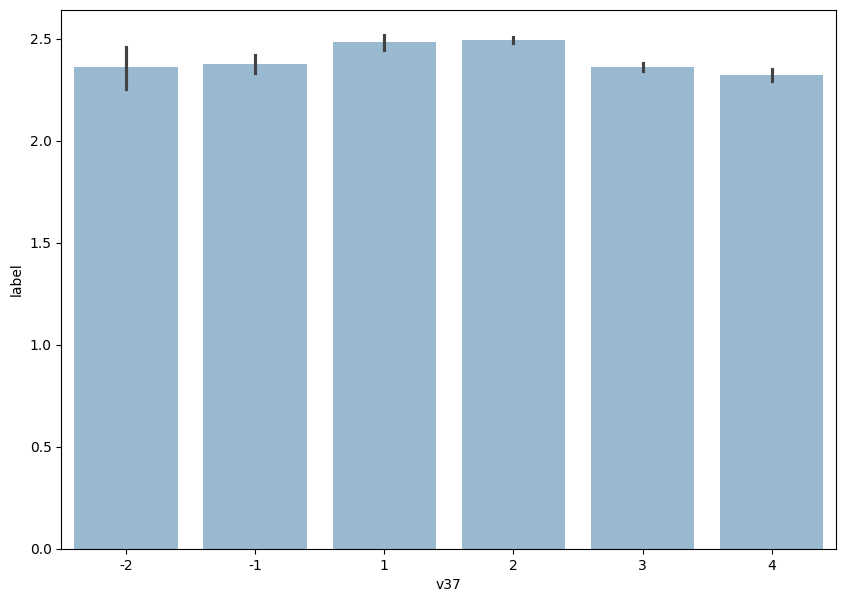

--------------------------------------------------
col: v38


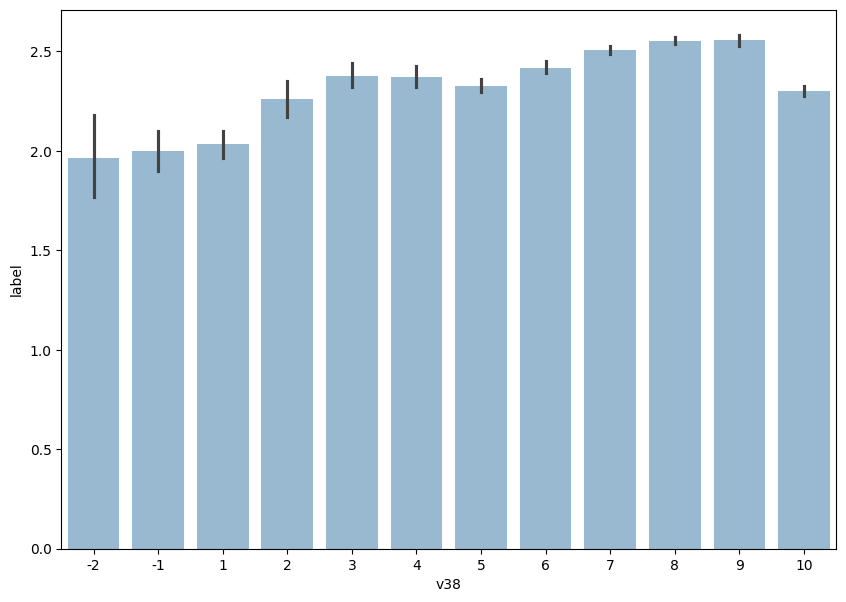

--------------------------------------------------
col: v39


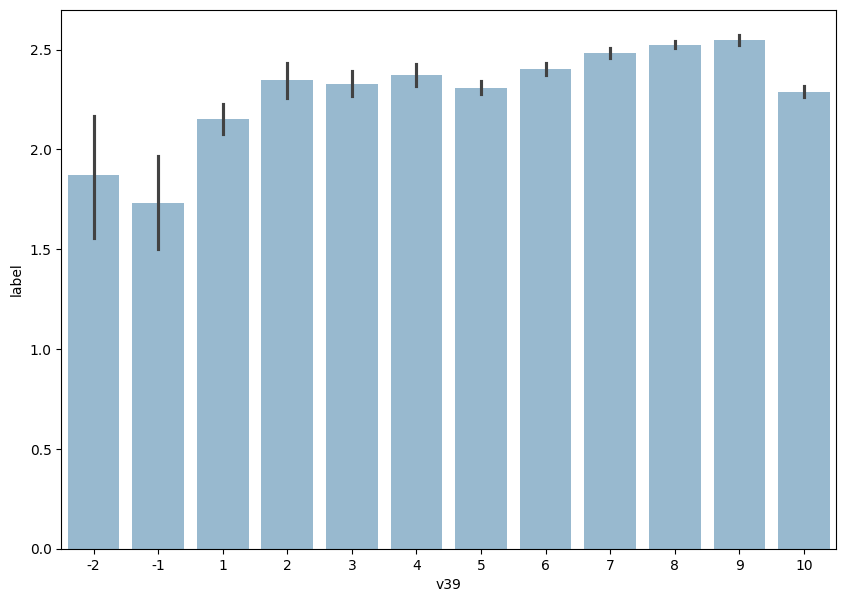

--------------------------------------------------
col: v40


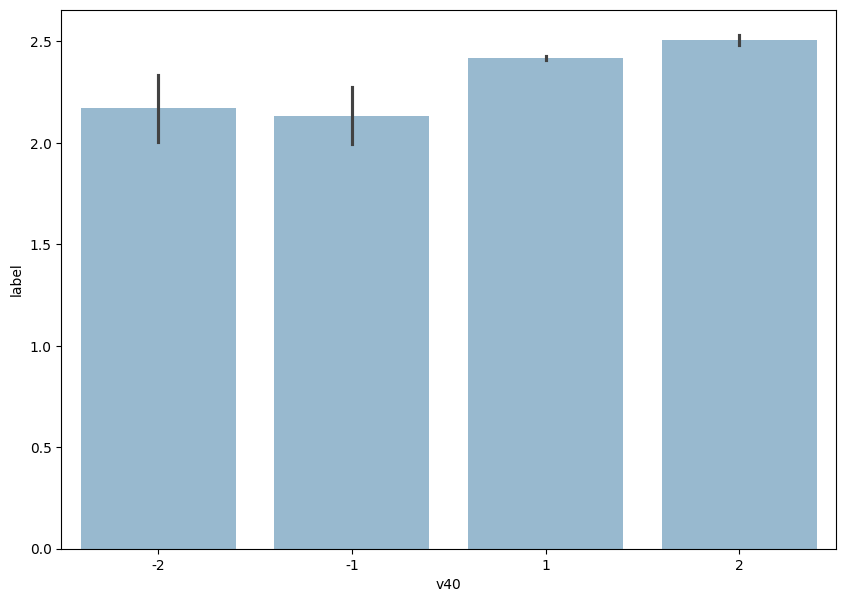

--------------------------------------------------
col: v41


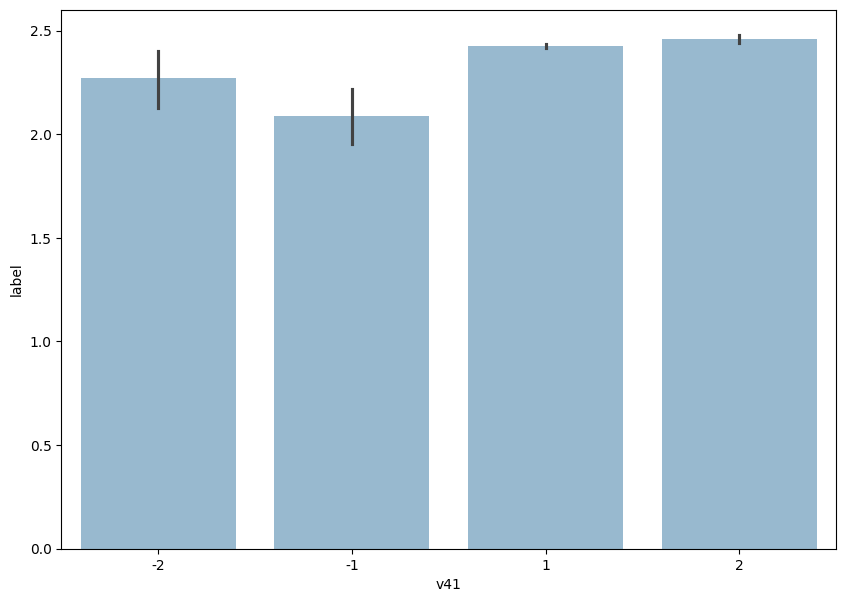

--------------------------------------------------
col: v42


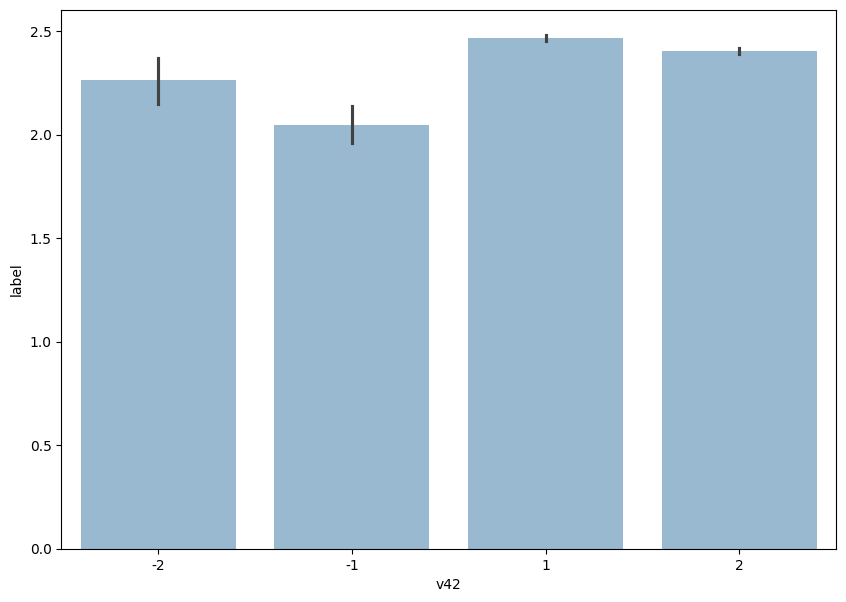

--------------------------------------------------
col: v43


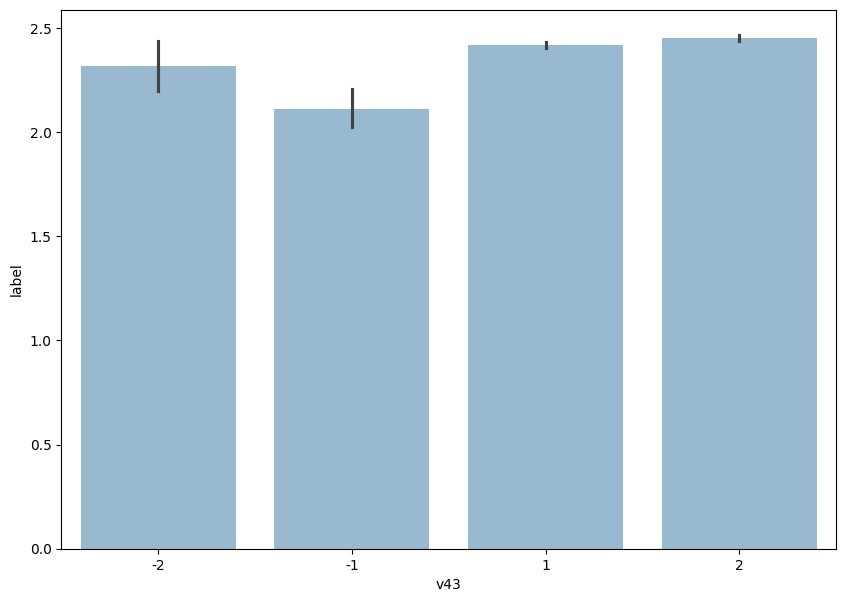

--------------------------------------------------
col: v44


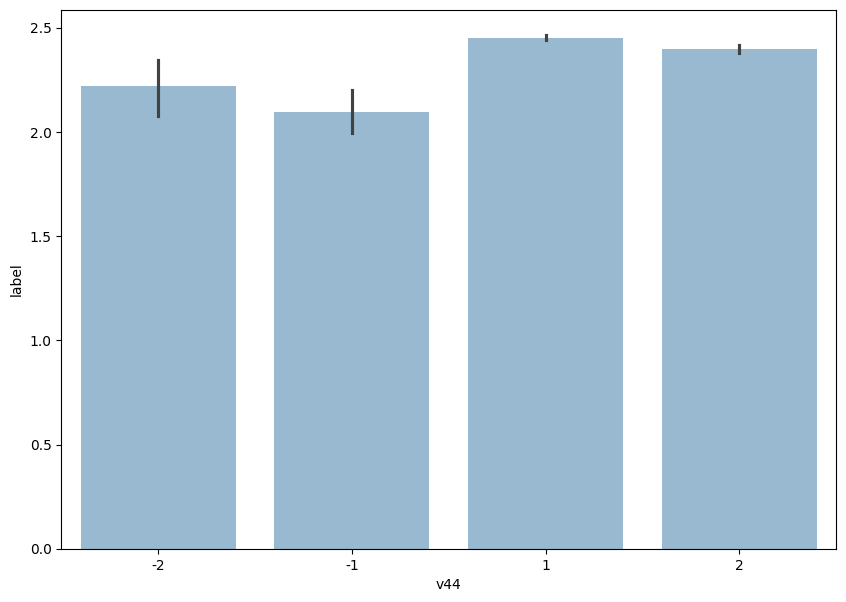

--------------------------------------------------
col: v45


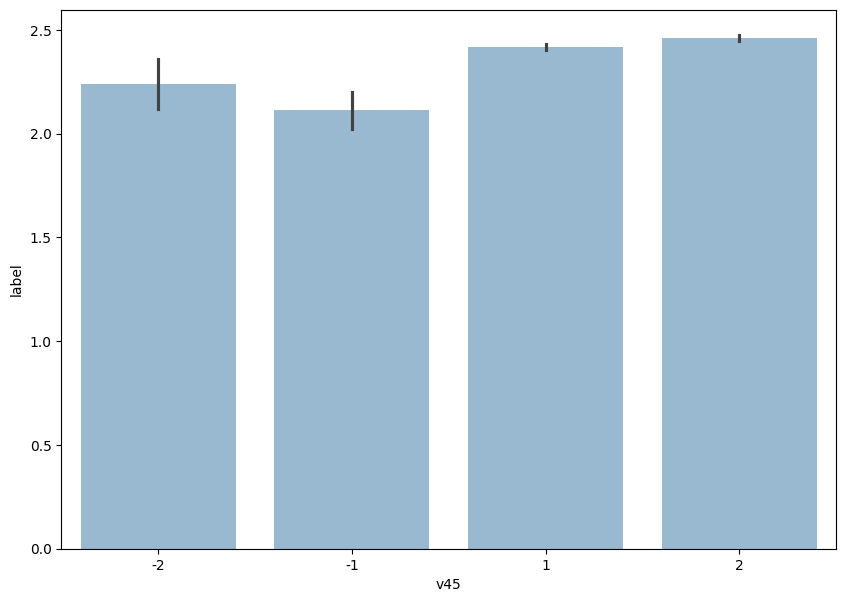

--------------------------------------------------
col: f45a


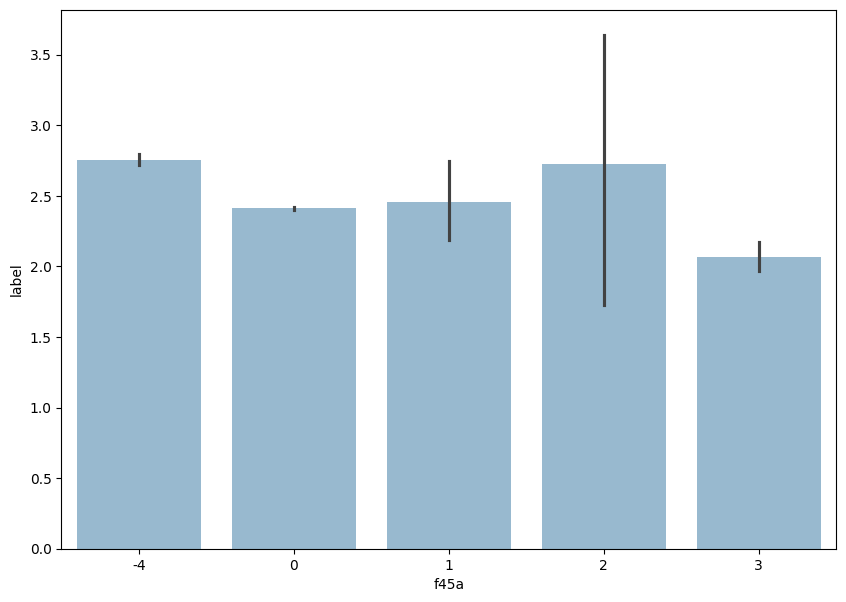

--------------------------------------------------
col: v45a


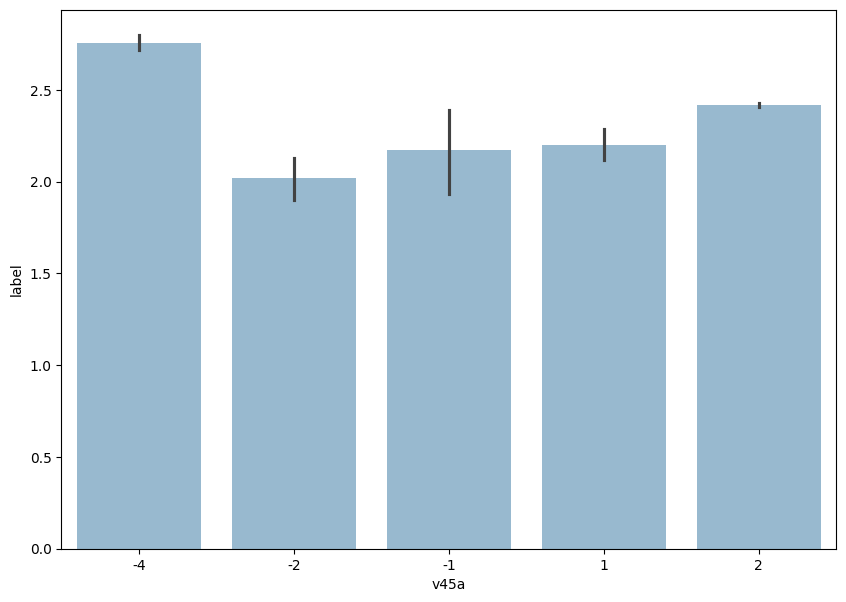

--------------------------------------------------
col: v45c


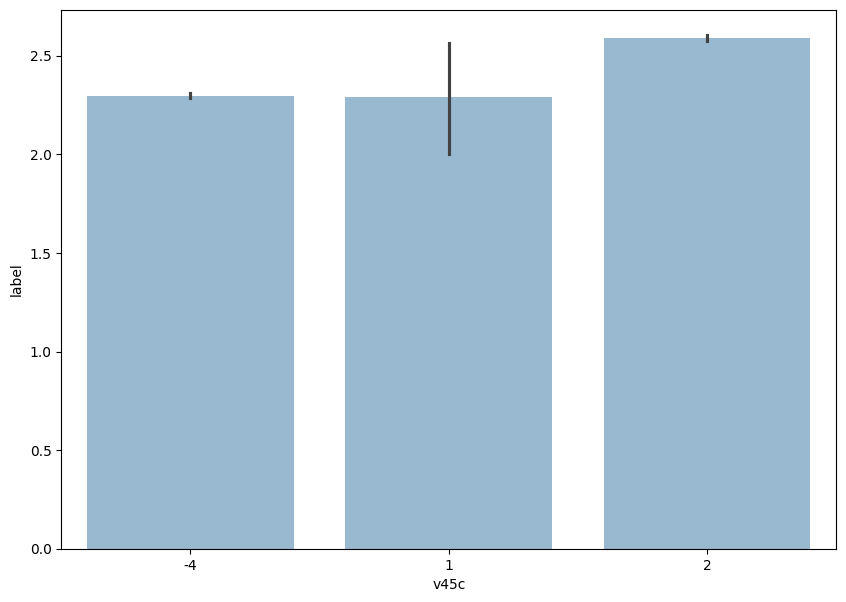

--------------------------------------------------
col: v46


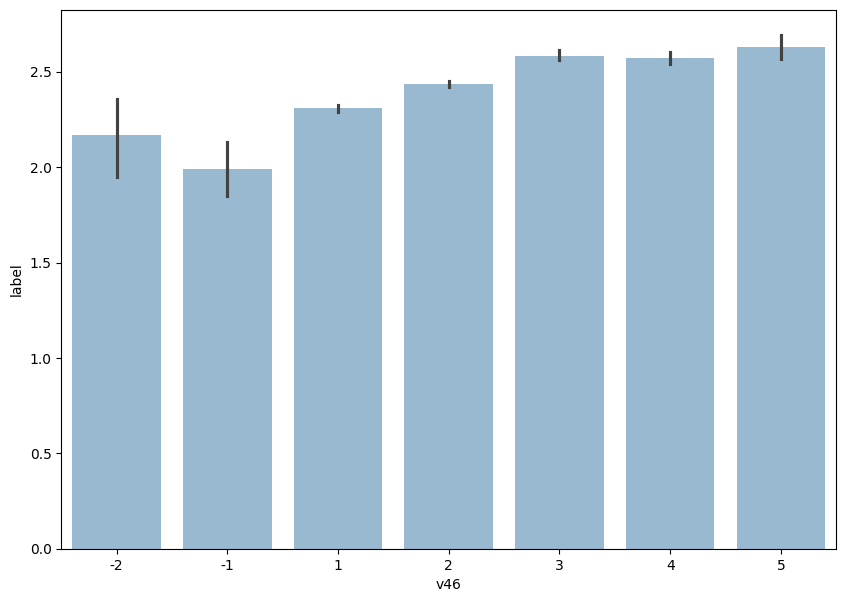

--------------------------------------------------
col: v47


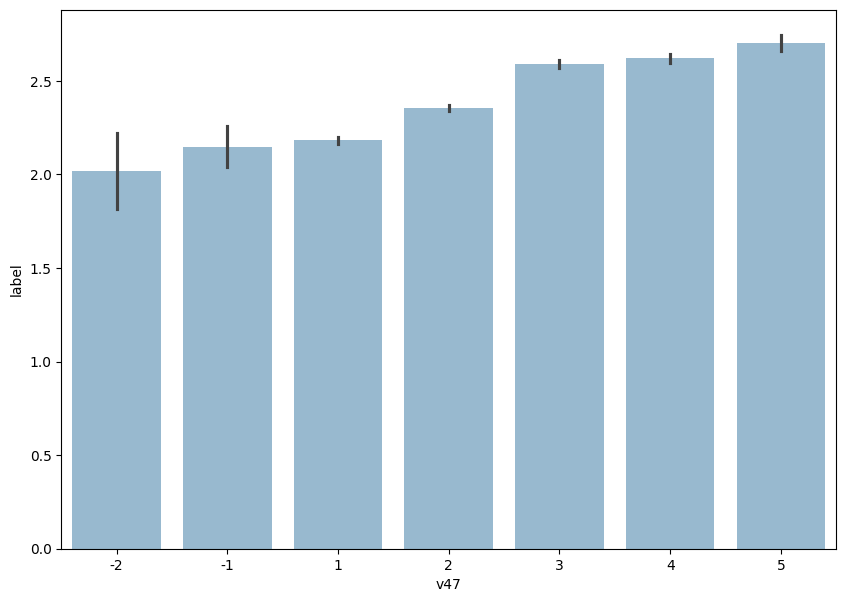

--------------------------------------------------
col: v48


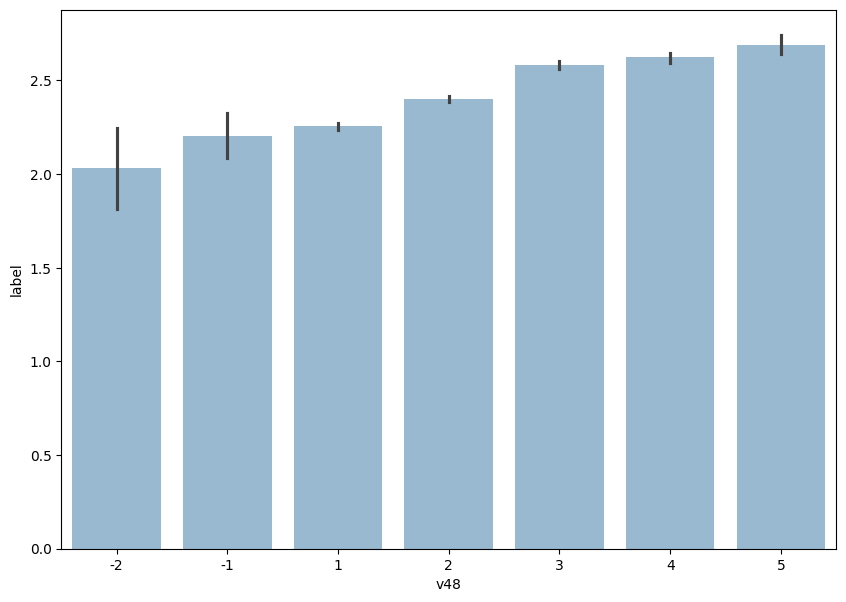

--------------------------------------------------
col: v49


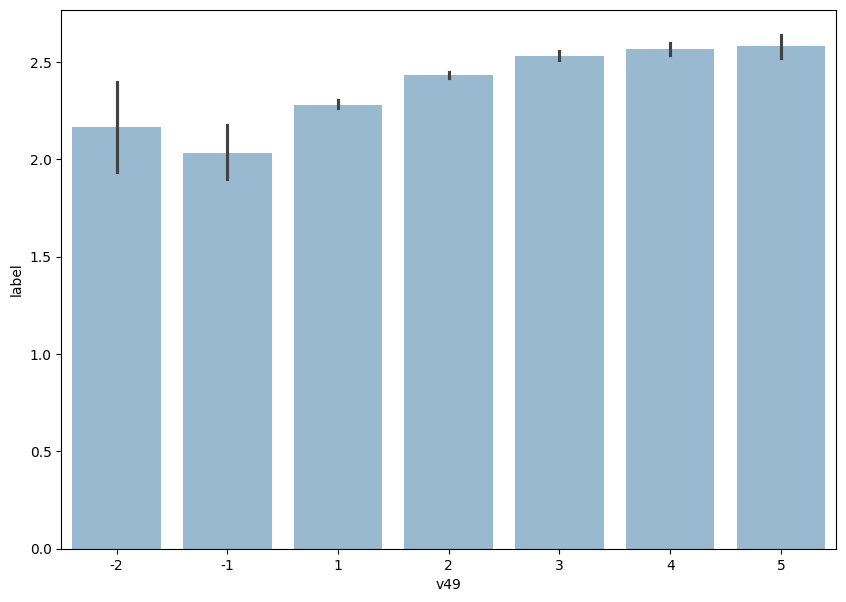

--------------------------------------------------
col: v50


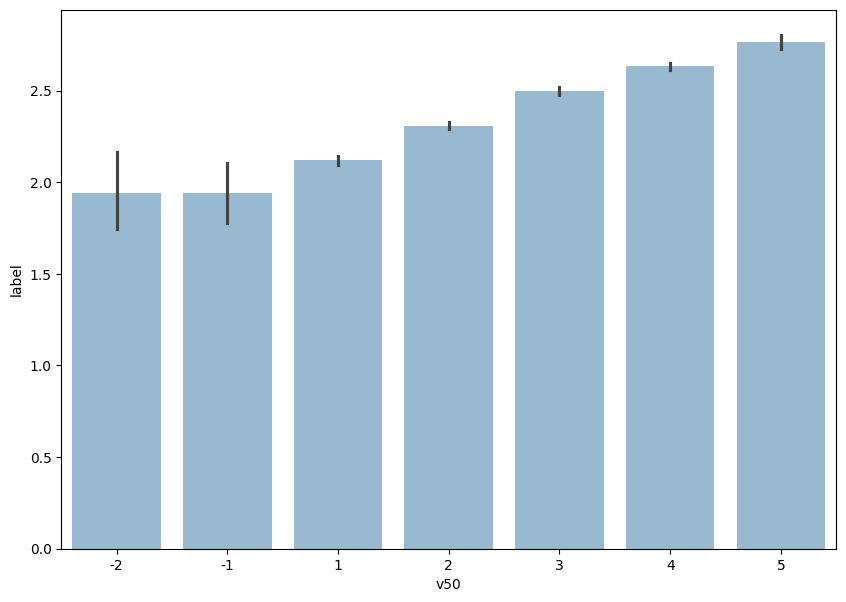

--------------------------------------------------
col: v51


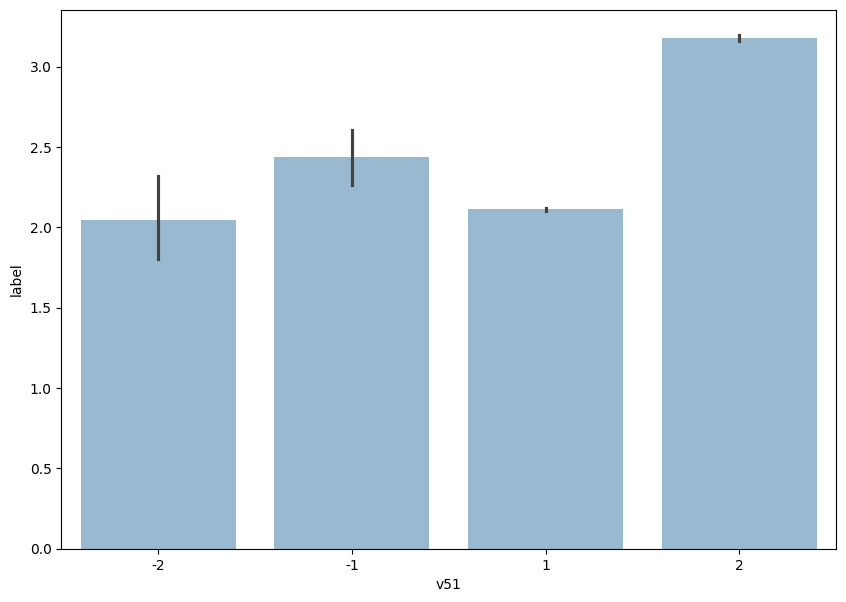

--------------------------------------------------
col: v52


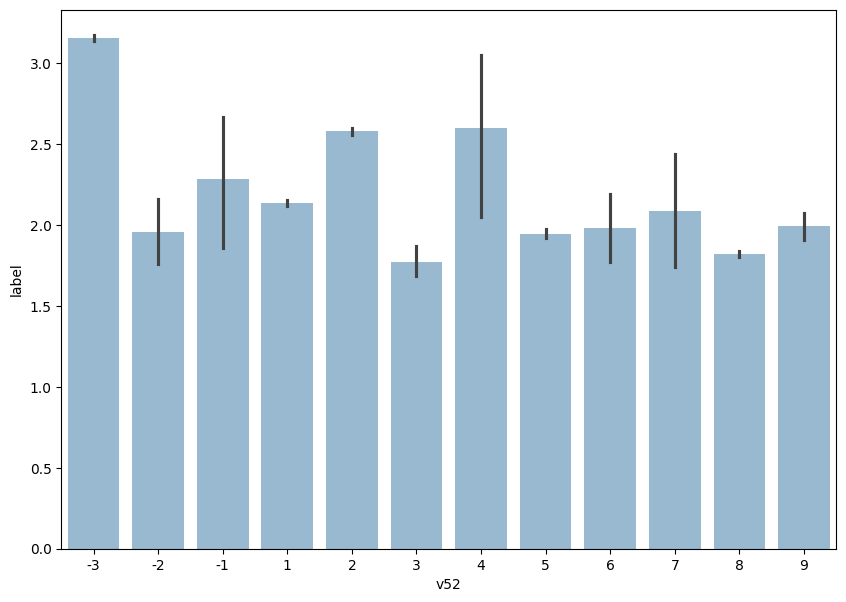

--------------------------------------------------
col: v52_cs


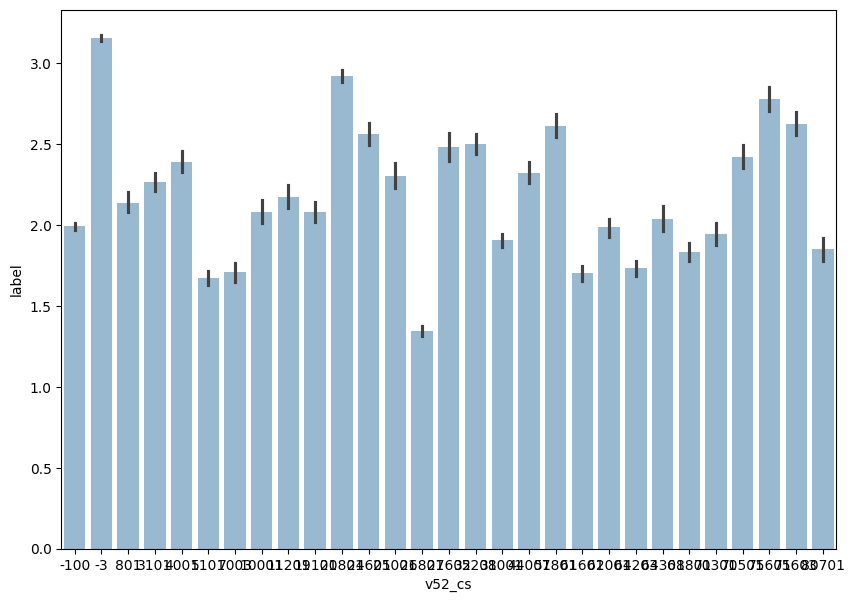

--------------------------------------------------
col: v53


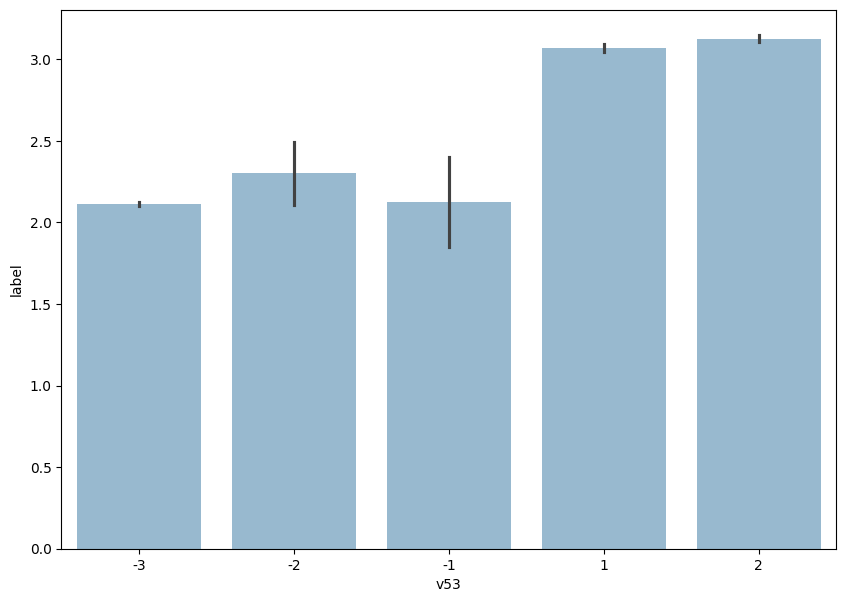

--------------------------------------------------
col: v54


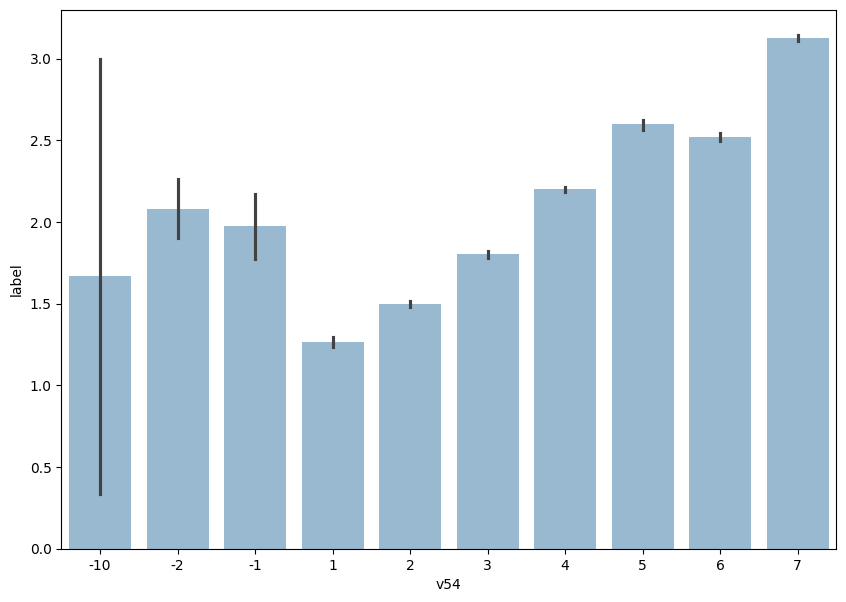

--------------------------------------------------
col: v55


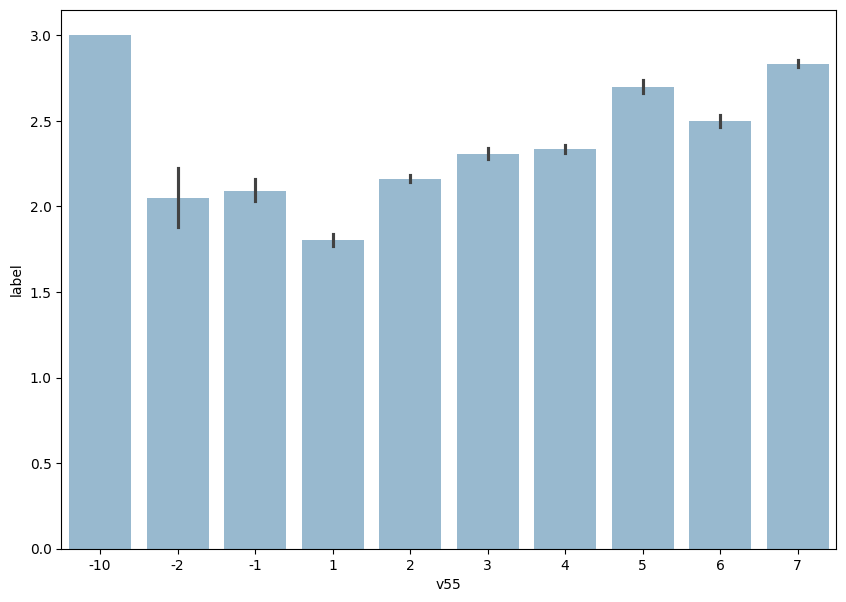

--------------------------------------------------
col: v56


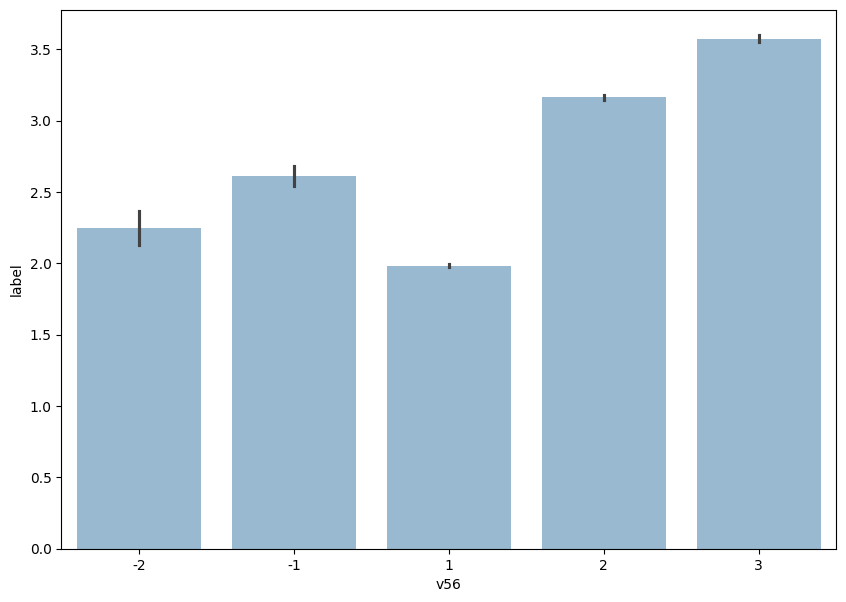

--------------------------------------------------
col: v57


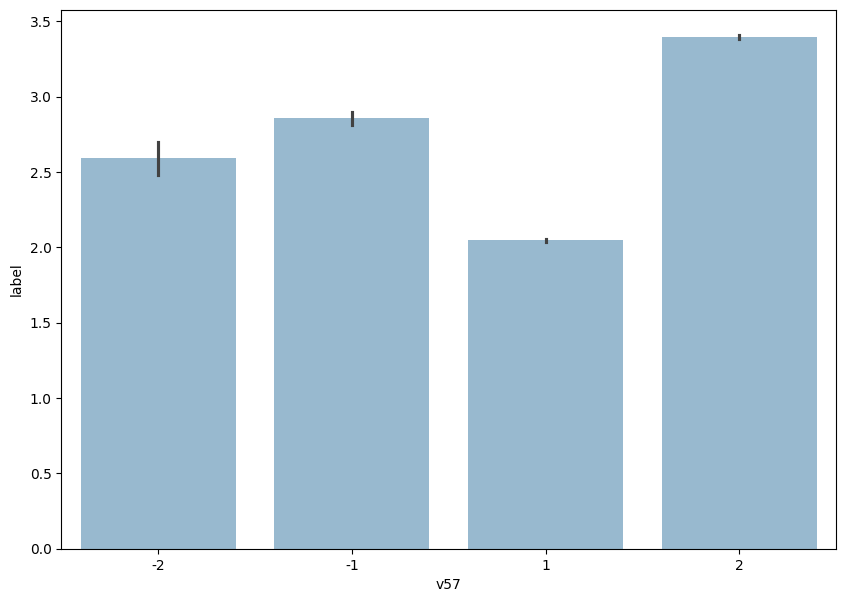

--------------------------------------------------
col: v58


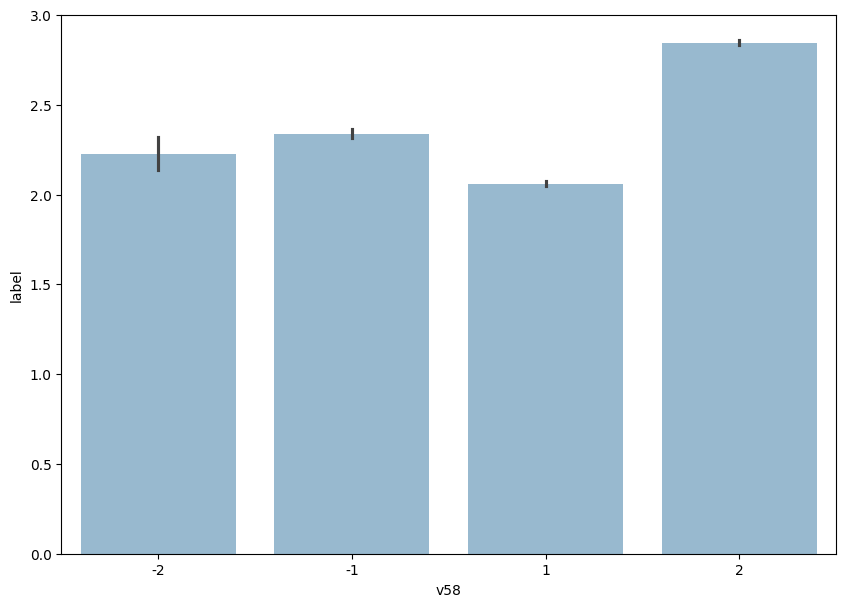

--------------------------------------------------
col: v59


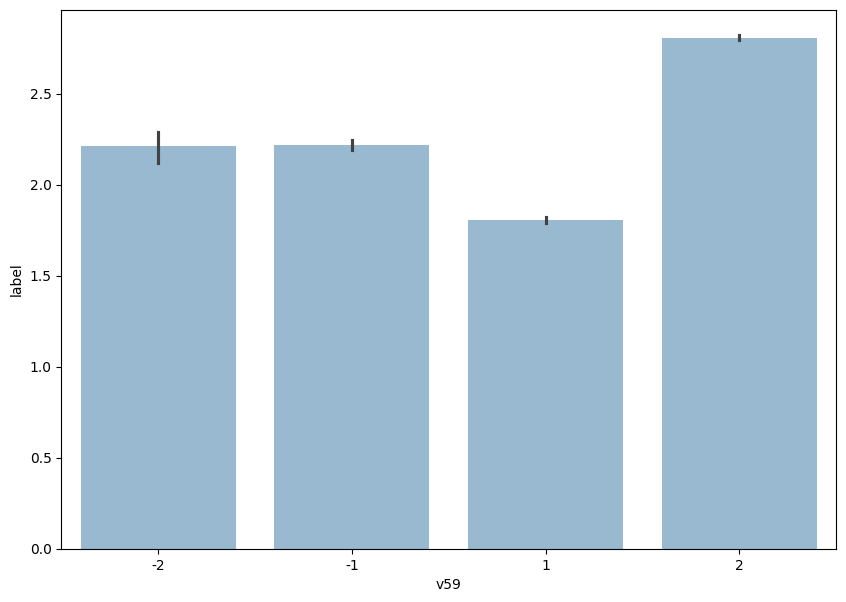

--------------------------------------------------
col: v60


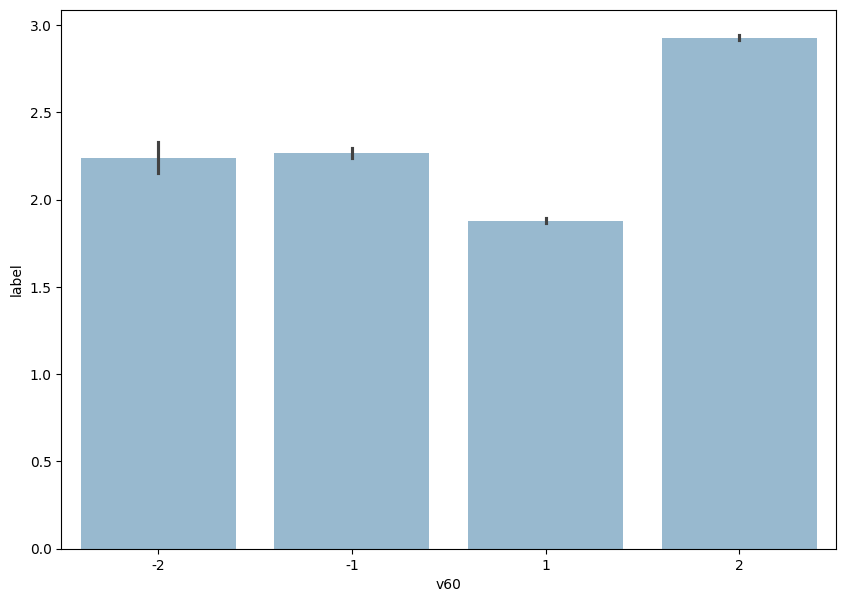

--------------------------------------------------
col: v61


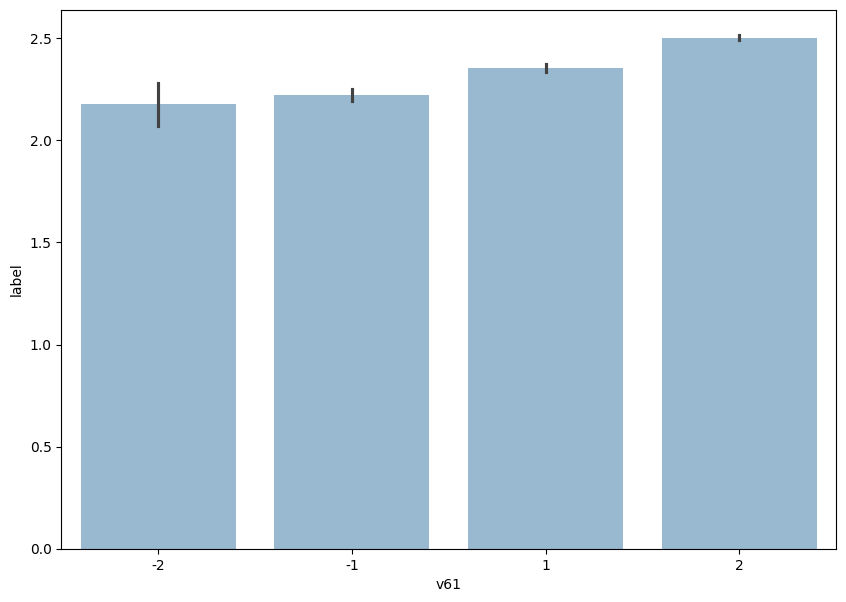

--------------------------------------------------
col: v62


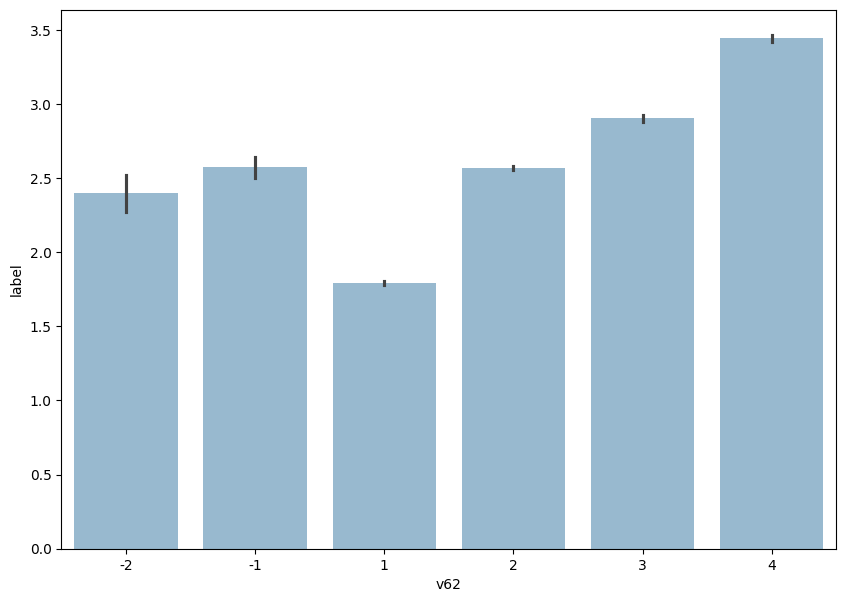

--------------------------------------------------
col: v63


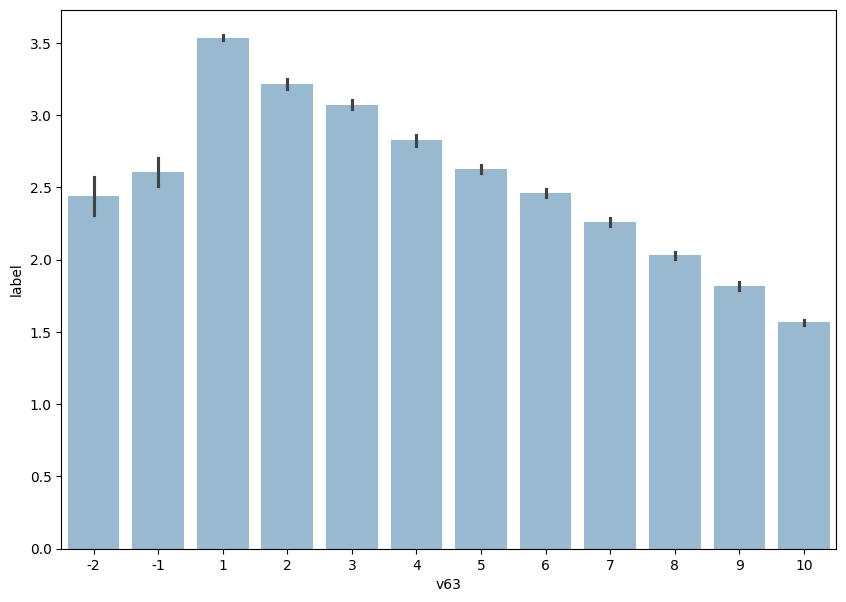

--------------------------------------------------
col: v64


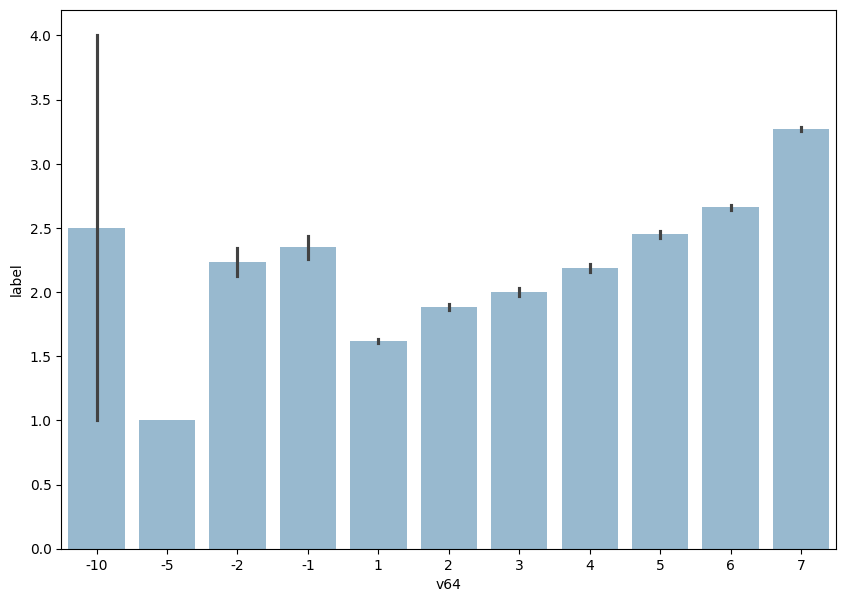

--------------------------------------------------
col: v65


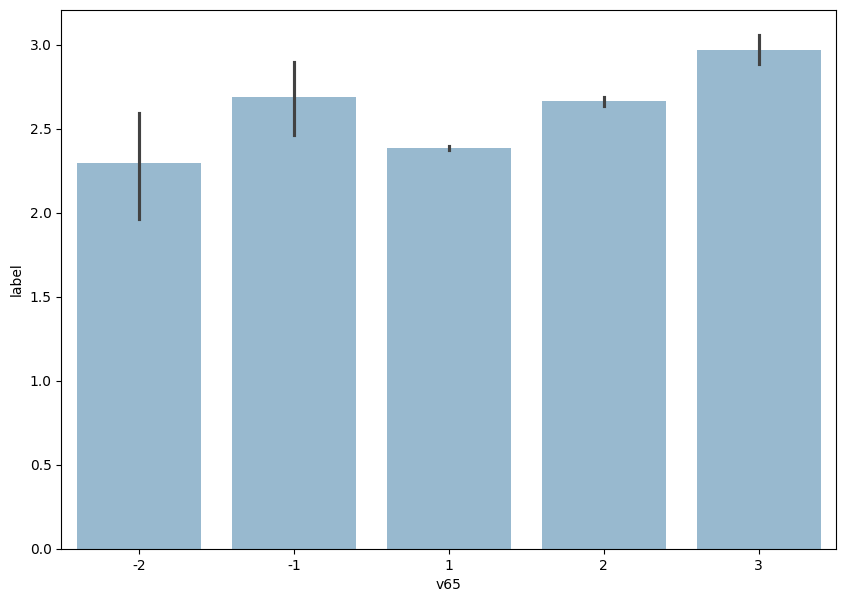

--------------------------------------------------
col: v66


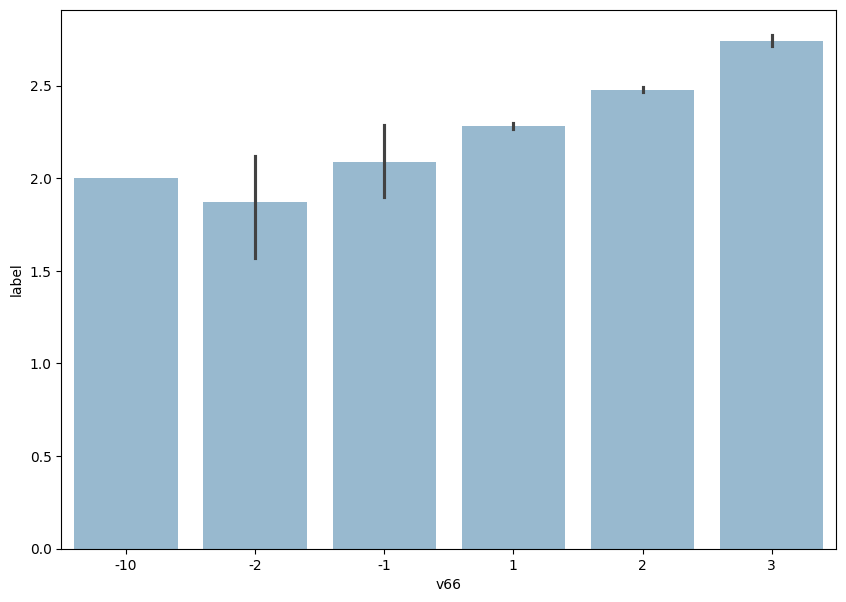

--------------------------------------------------
col: v67


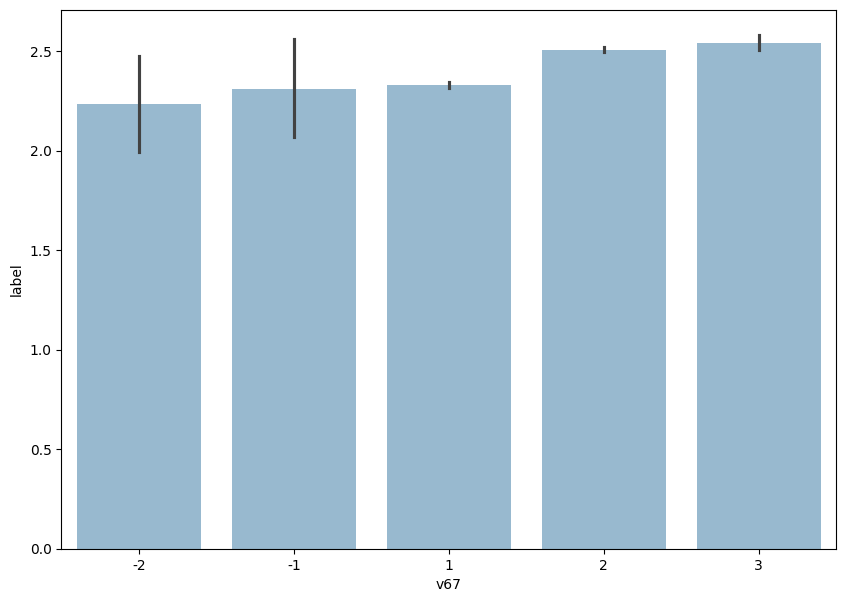

--------------------------------------------------
col: v68


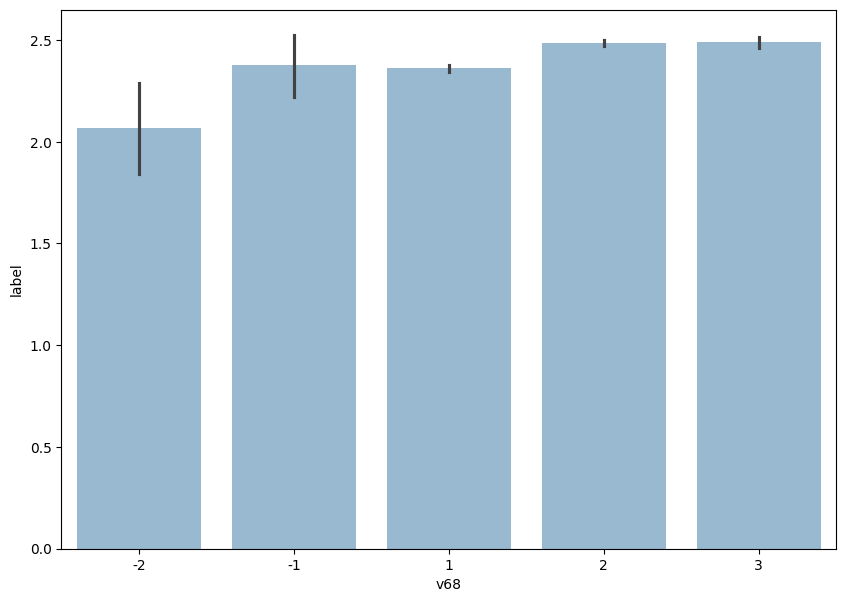

--------------------------------------------------
col: v69


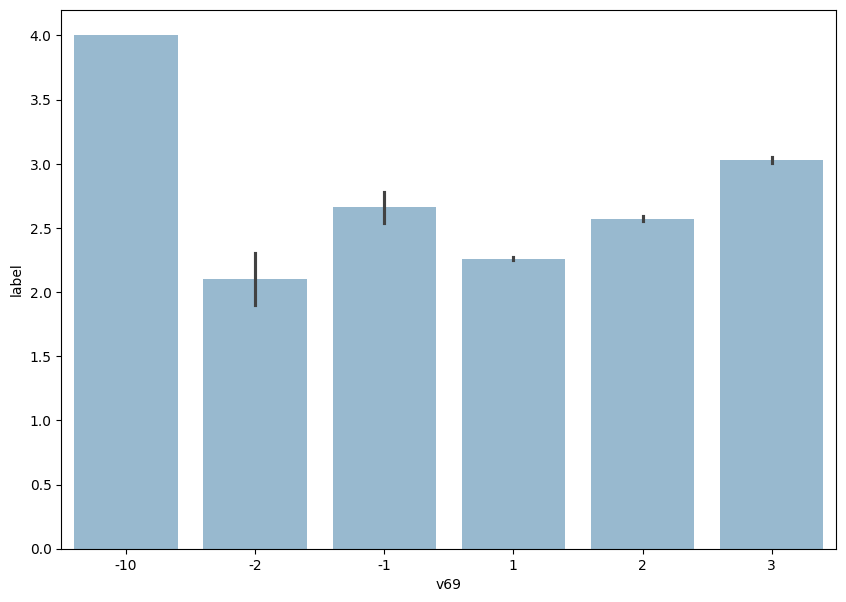

--------------------------------------------------
col: v70


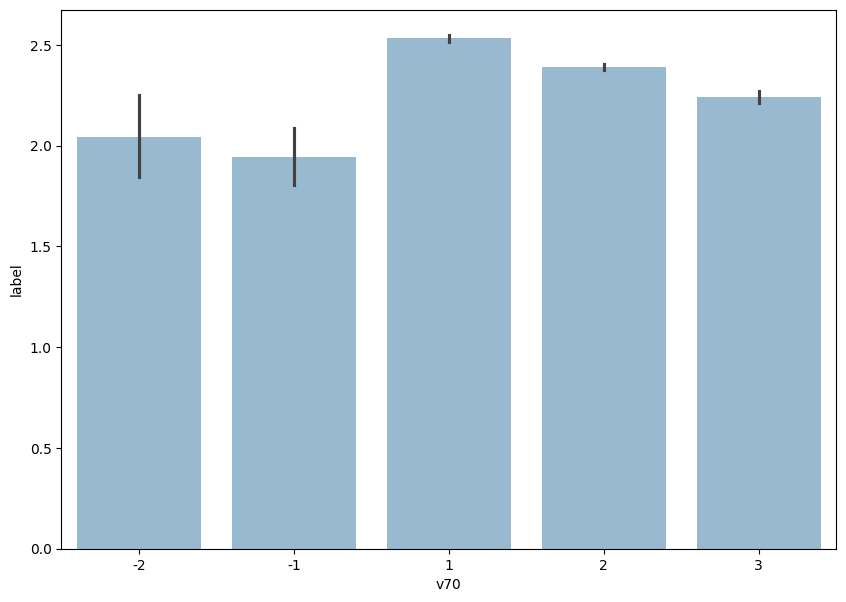

--------------------------------------------------
col: v71


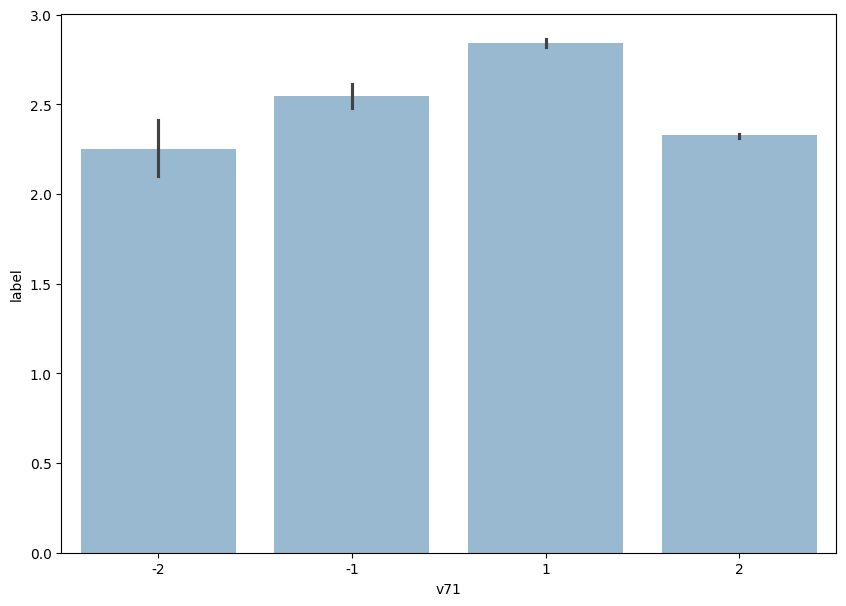

--------------------------------------------------
col: v72


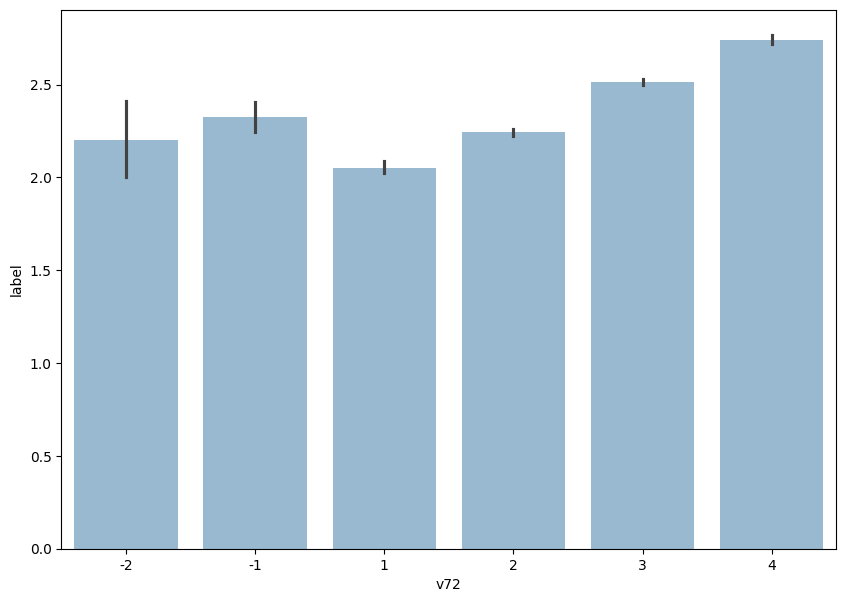

--------------------------------------------------
col: v73


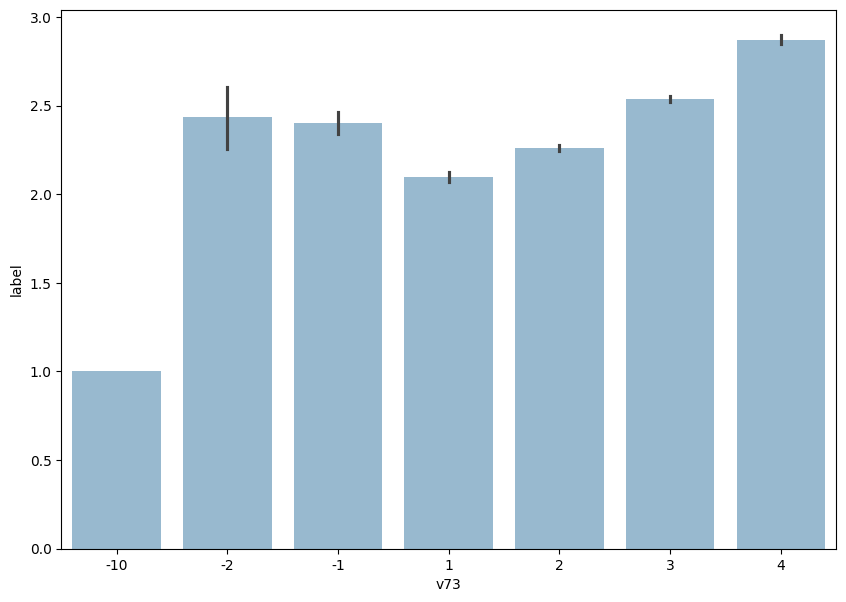

--------------------------------------------------
col: v74


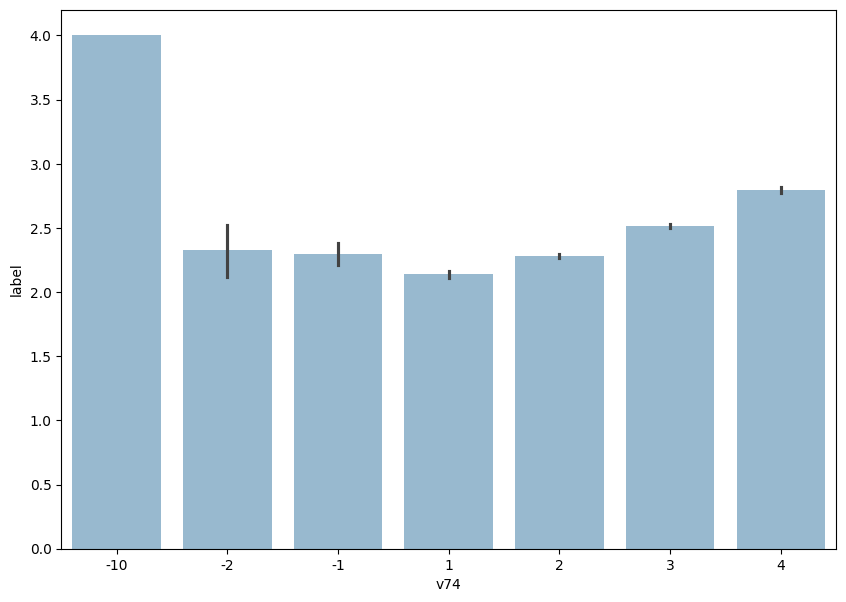

--------------------------------------------------
col: v75


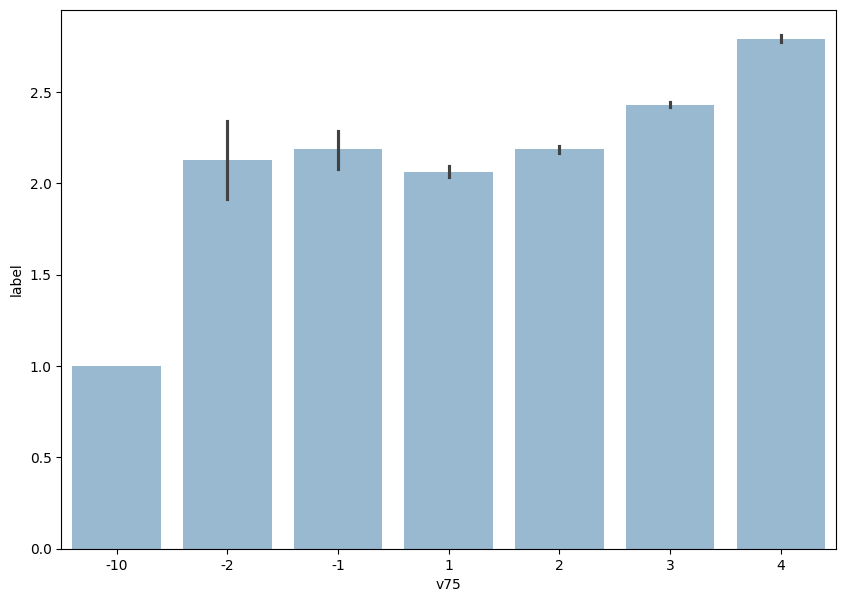

--------------------------------------------------
col: v76


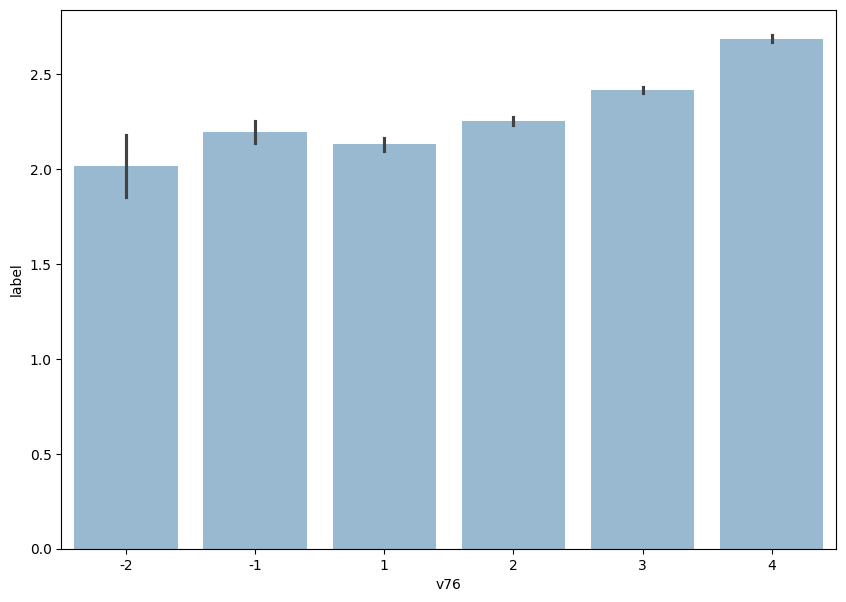

--------------------------------------------------
col: v77


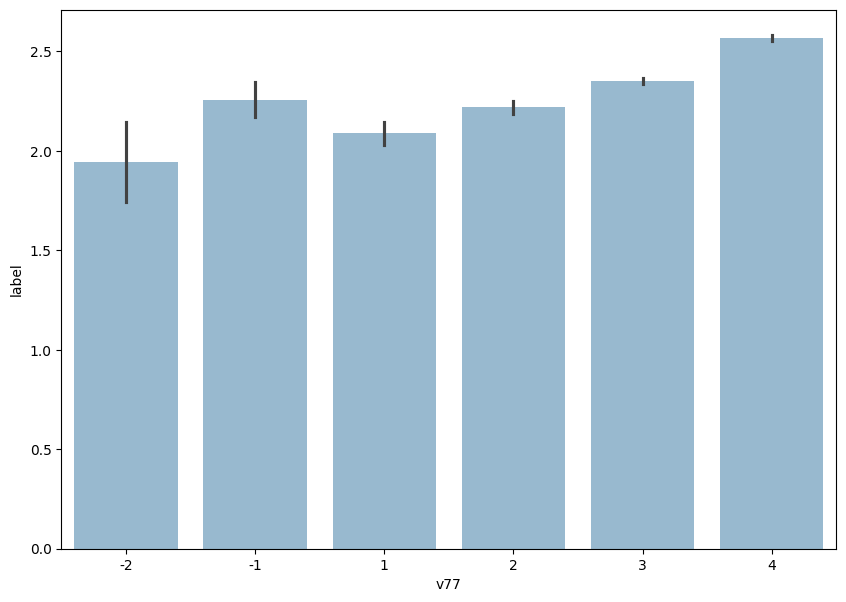

--------------------------------------------------
col: v78


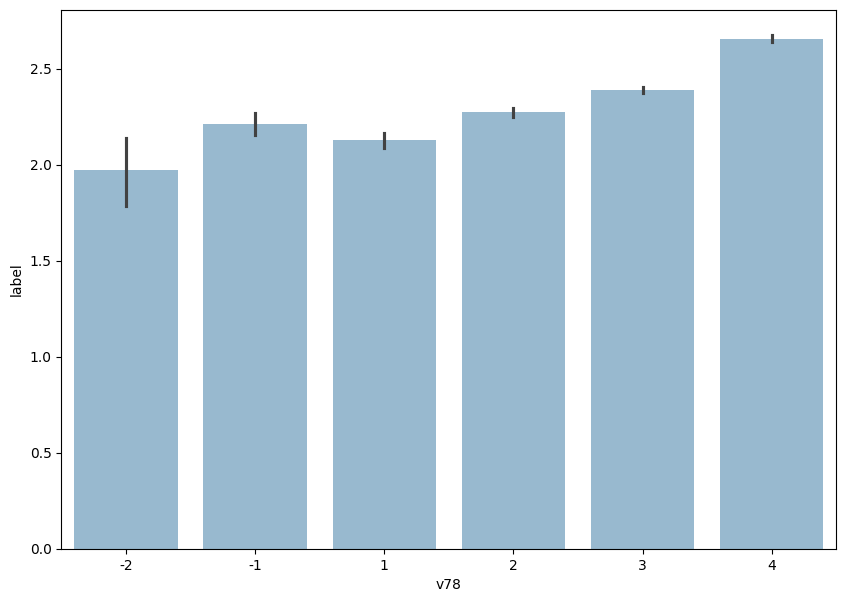

--------------------------------------------------
col: v79


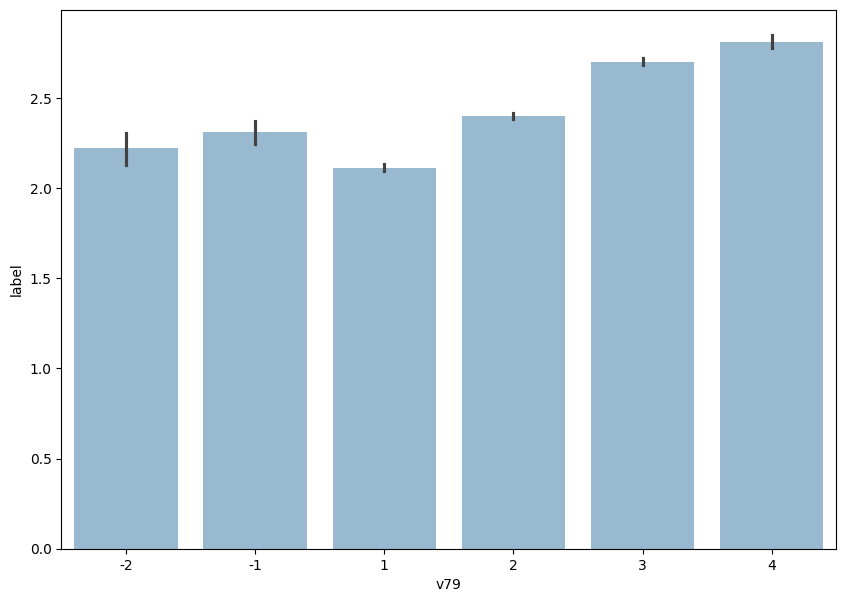

--------------------------------------------------
col: v80


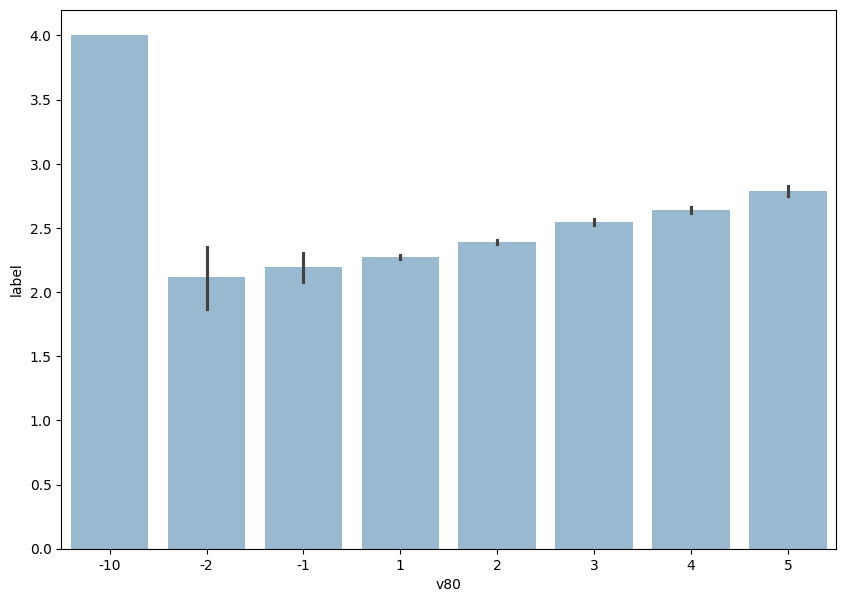

--------------------------------------------------
col: v81


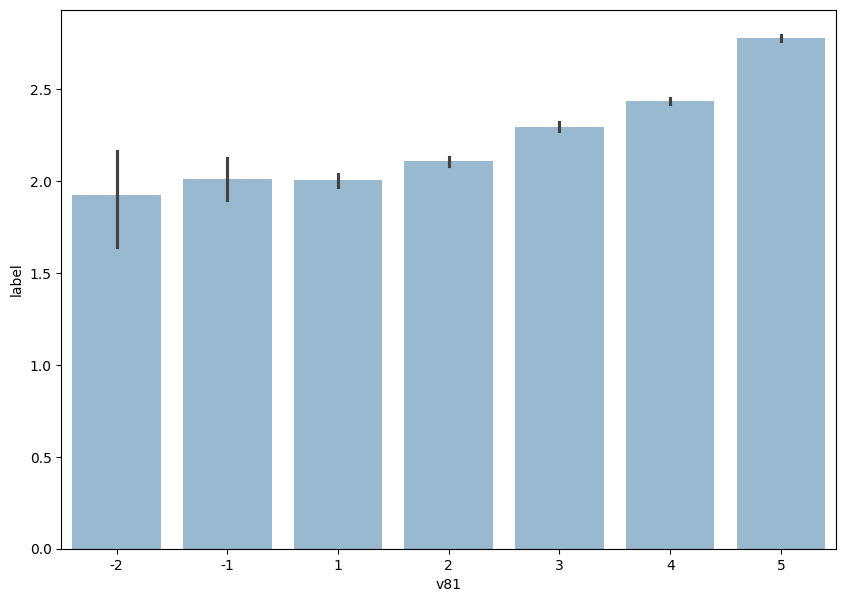

--------------------------------------------------
col: v82


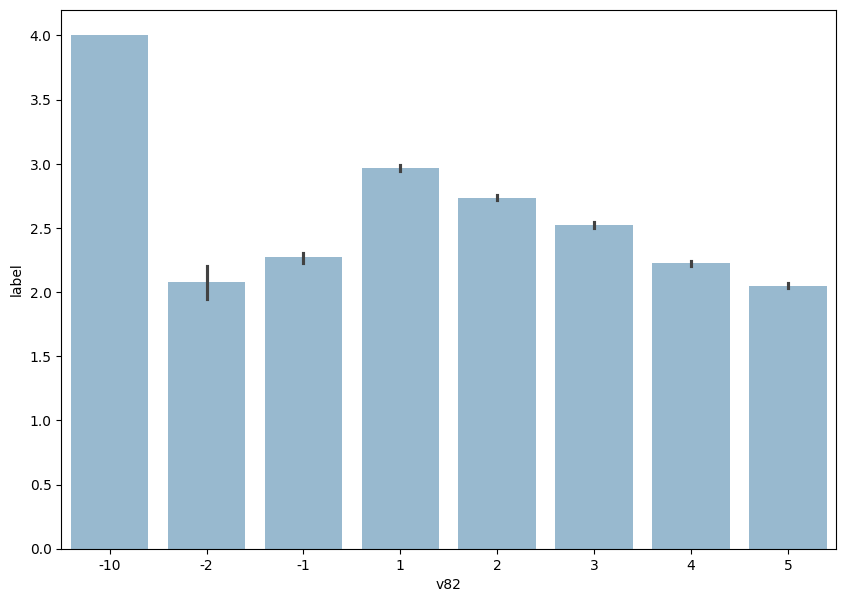

--------------------------------------------------
col: v83


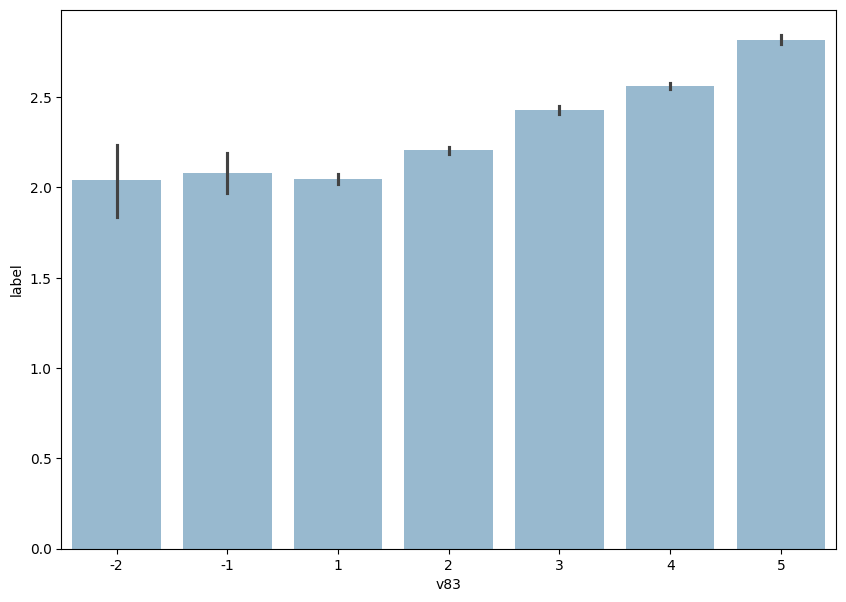

--------------------------------------------------
col: v84


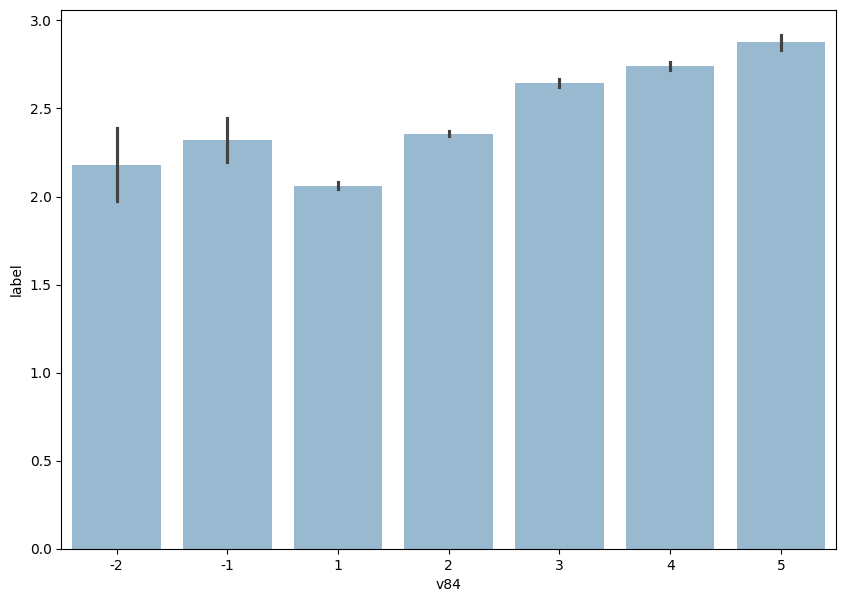

--------------------------------------------------
col: f85


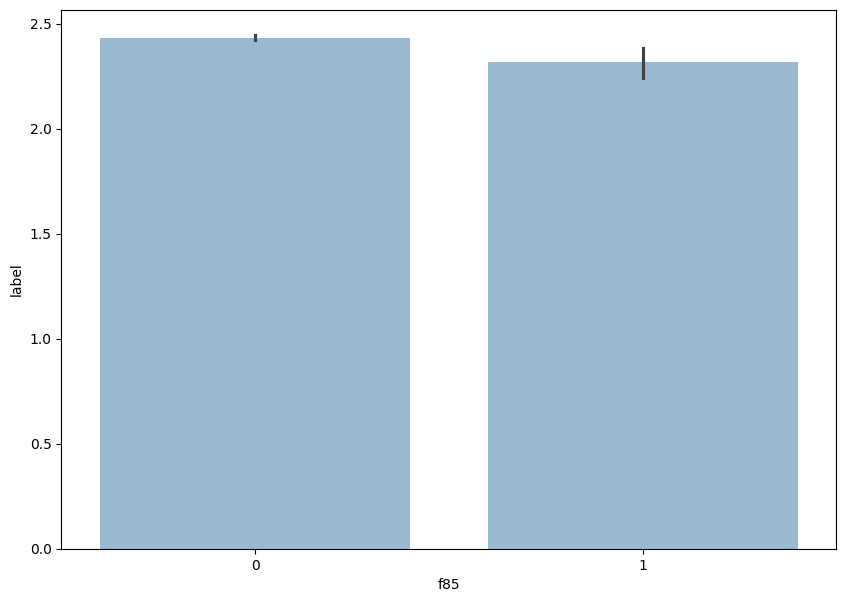

--------------------------------------------------
col: v85


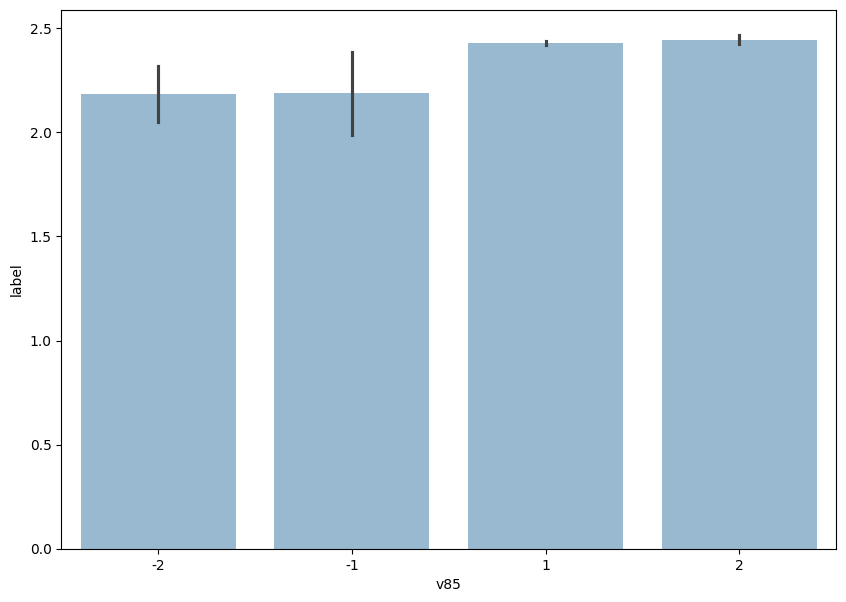

--------------------------------------------------
col: v86


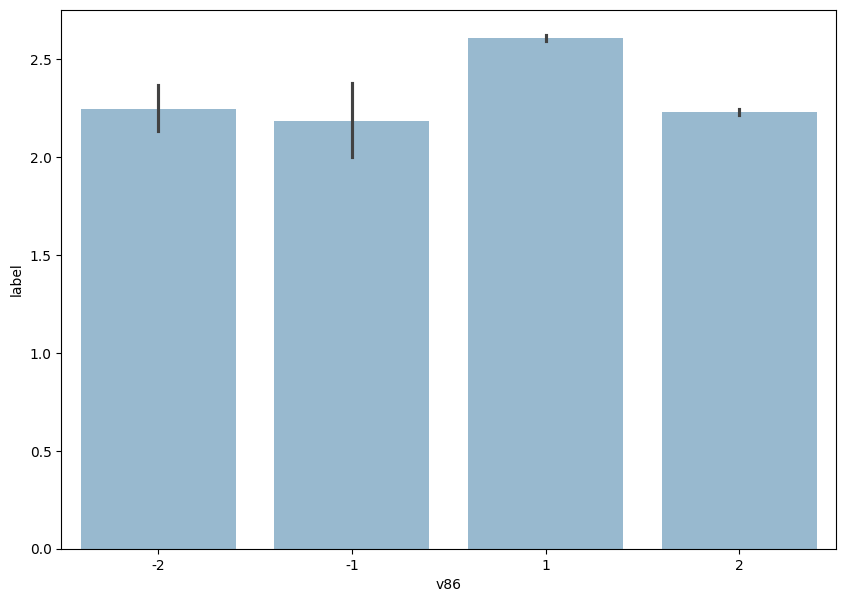

--------------------------------------------------
col: v87


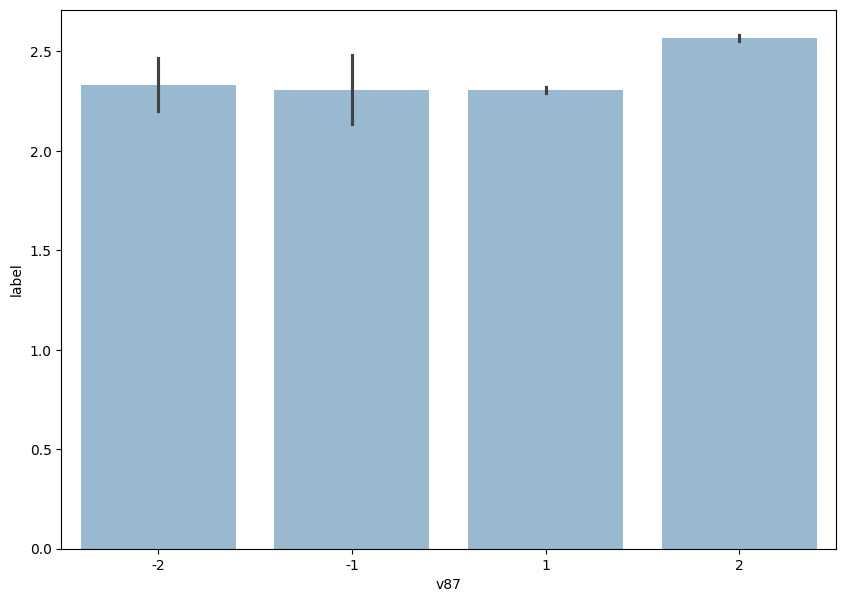

--------------------------------------------------
col: v88


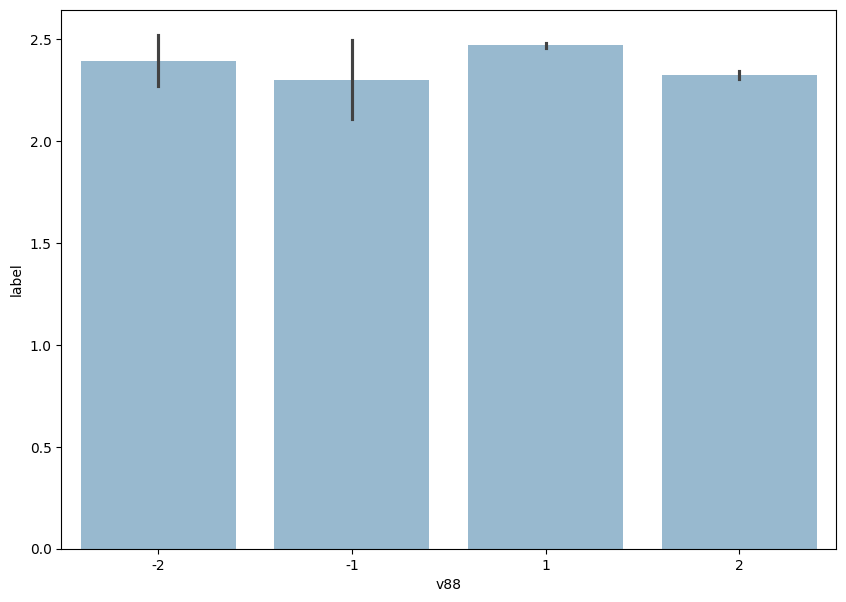

--------------------------------------------------
col: v89


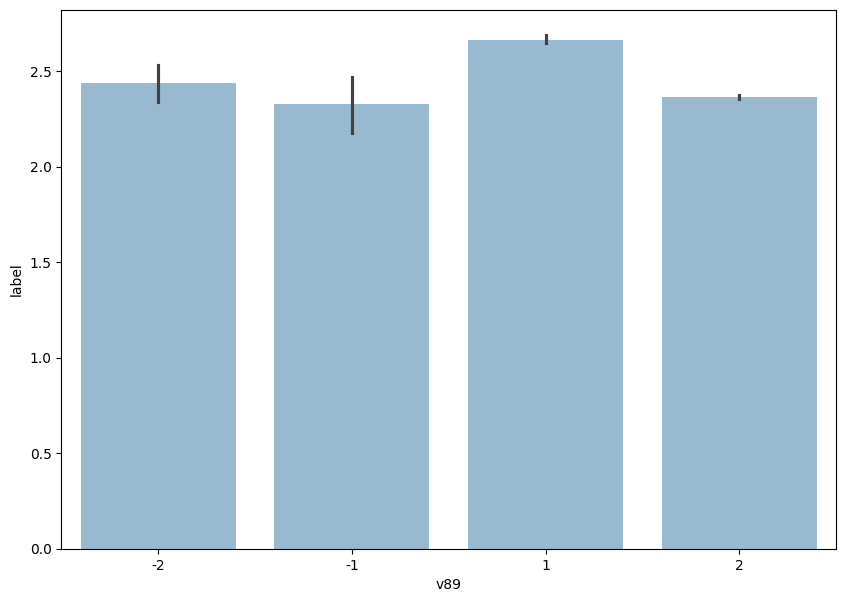

--------------------------------------------------
col: v90


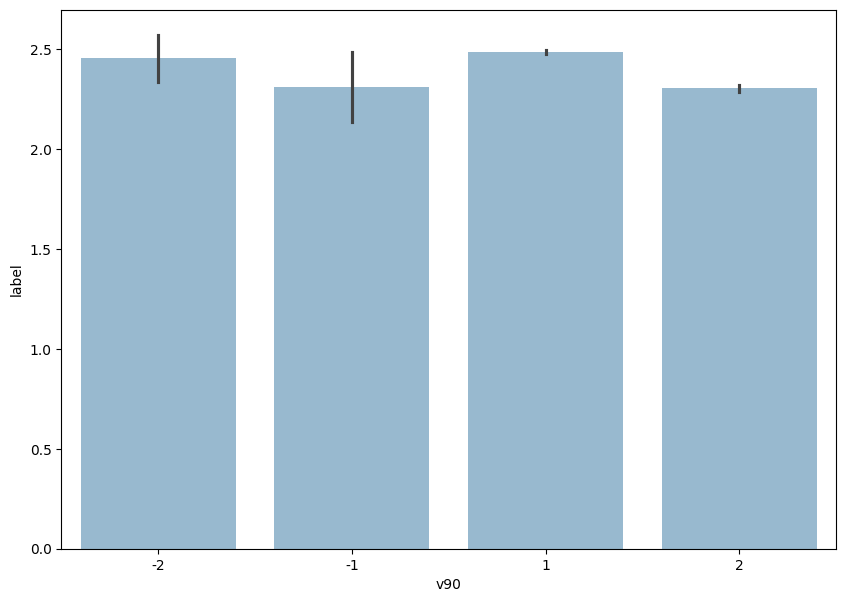

--------------------------------------------------
col: v91


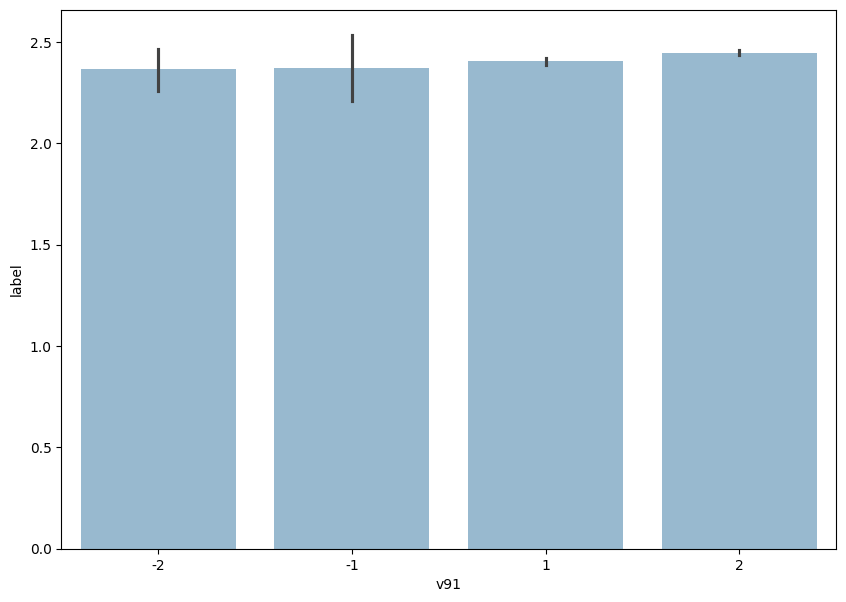

--------------------------------------------------
col: v92


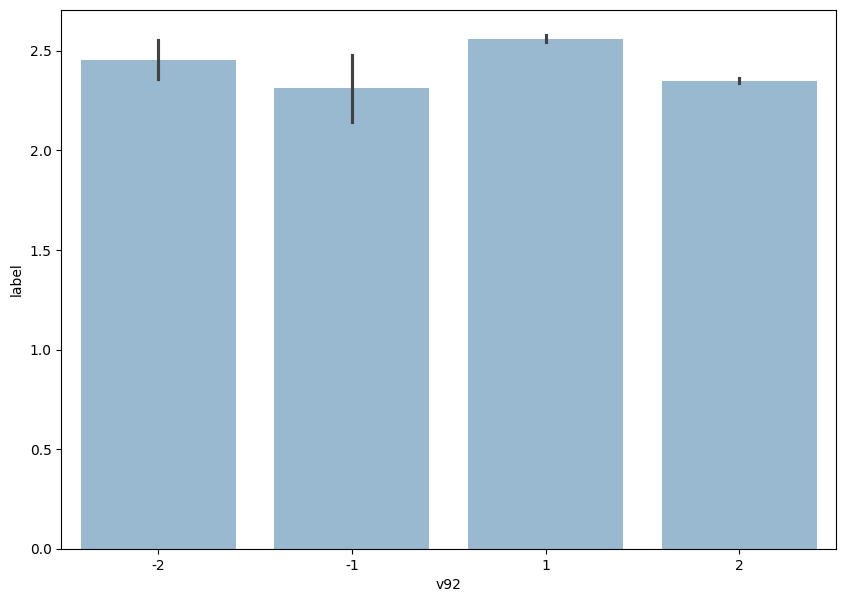

--------------------------------------------------
col: v93


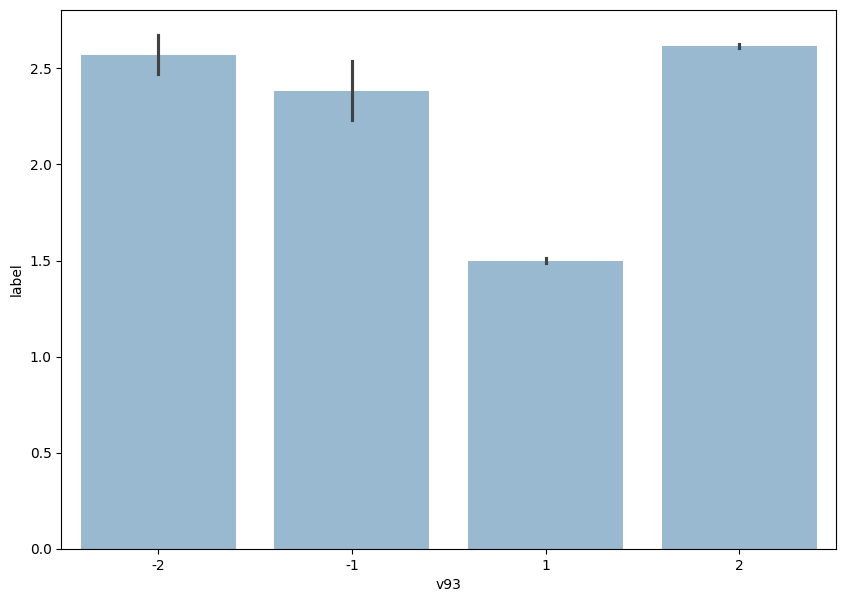

--------------------------------------------------
col: v94


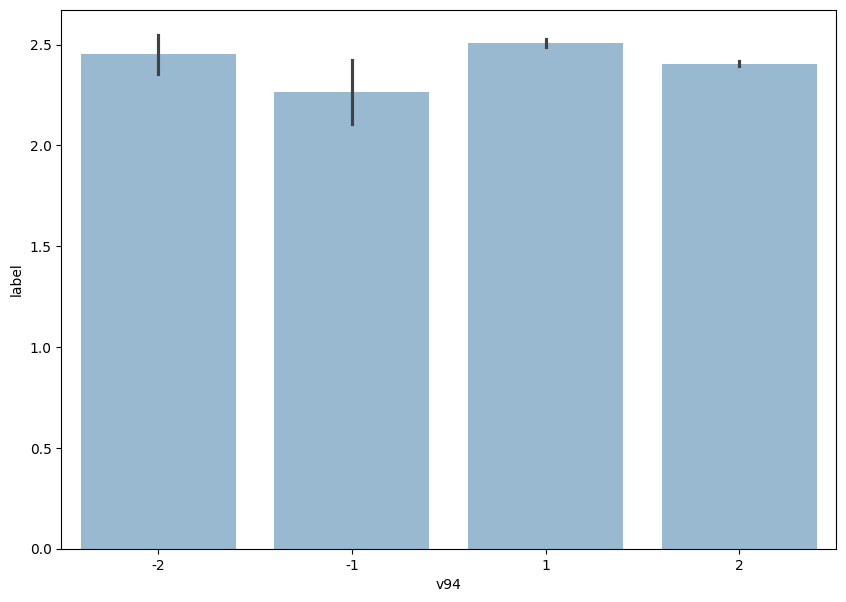

--------------------------------------------------
col: v95


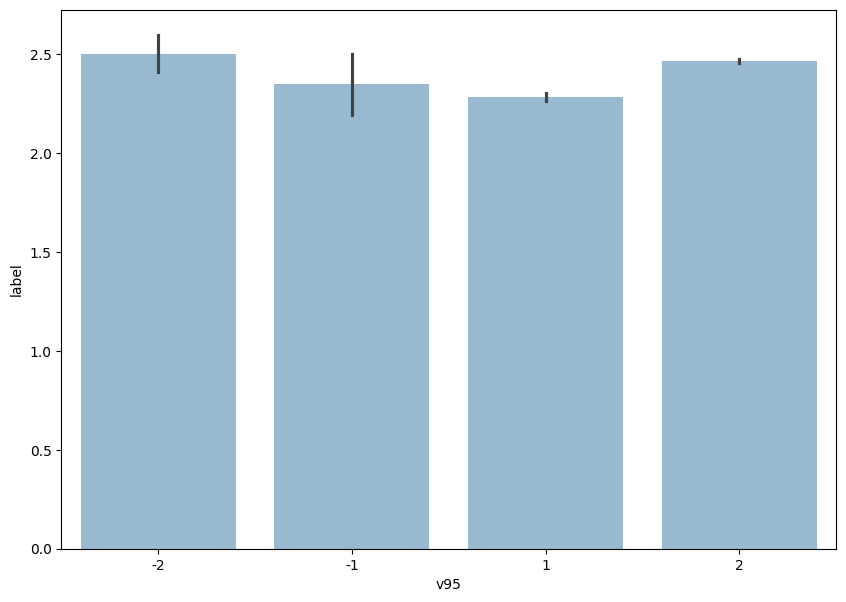

--------------------------------------------------
col: f96


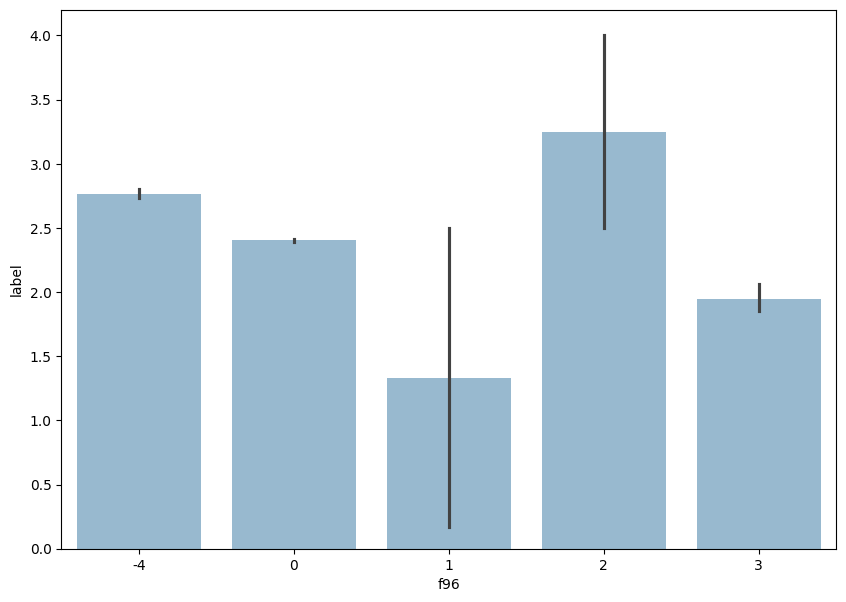

--------------------------------------------------
col: v96


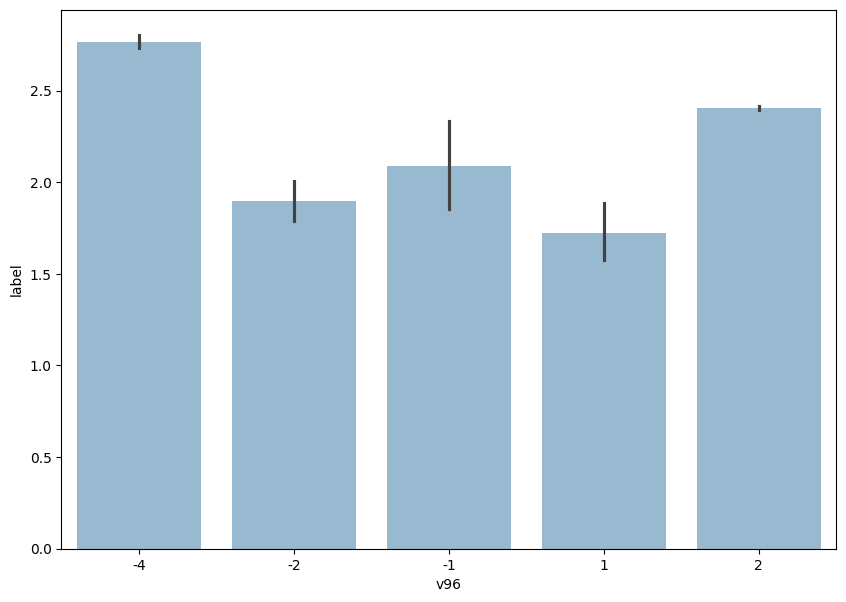

--------------------------------------------------
col: v96b


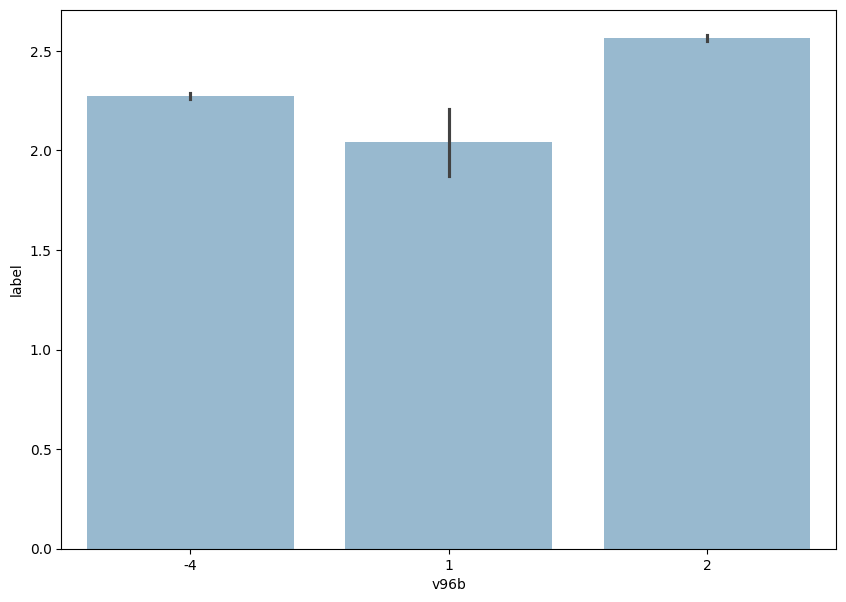

--------------------------------------------------
col: v97


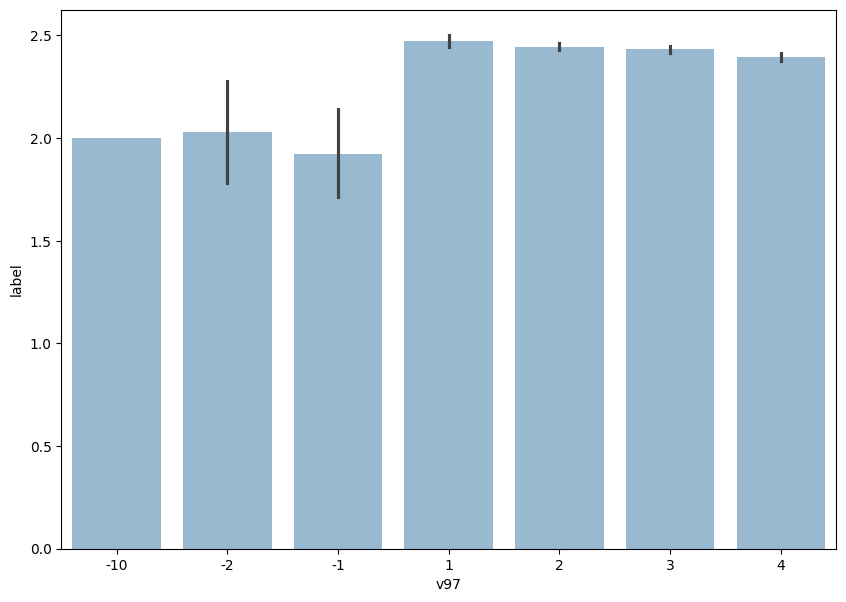

--------------------------------------------------
col: v98


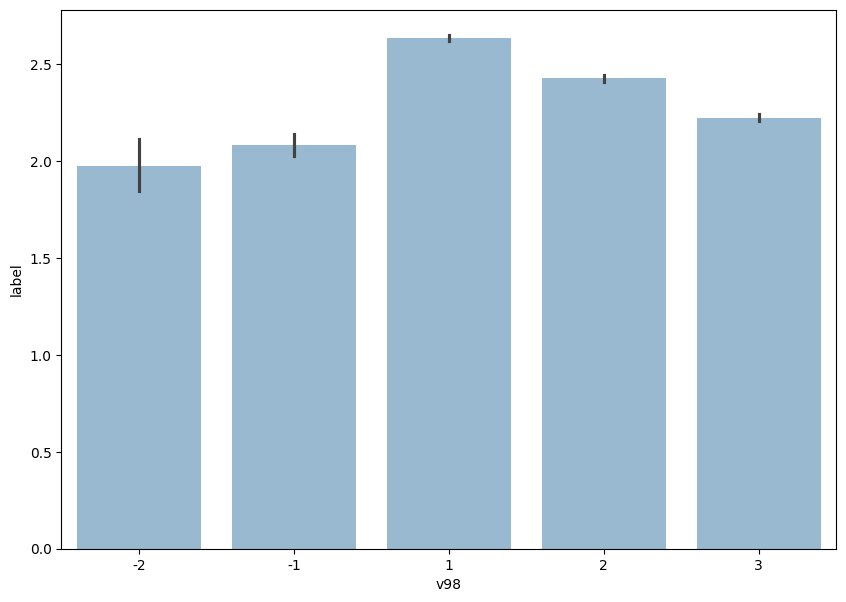

--------------------------------------------------
col: v99


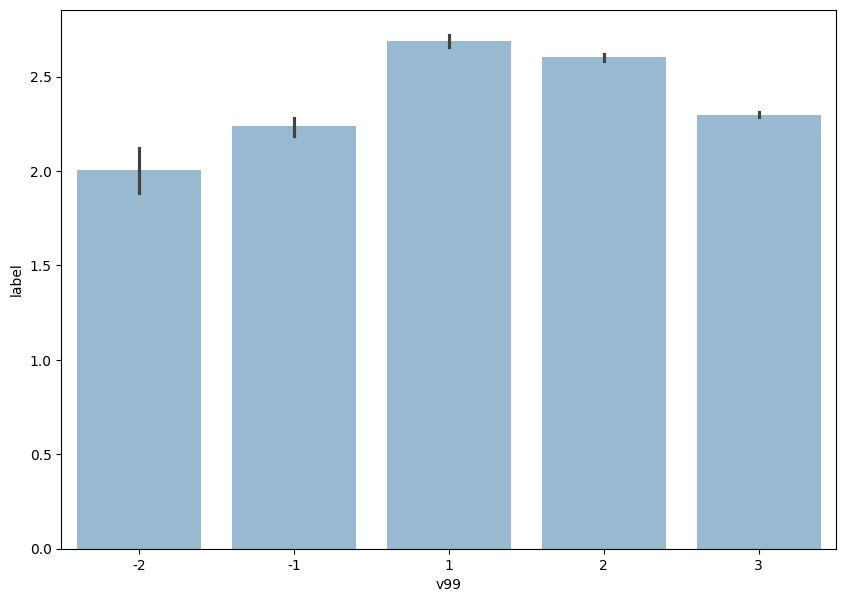

--------------------------------------------------
col: v100


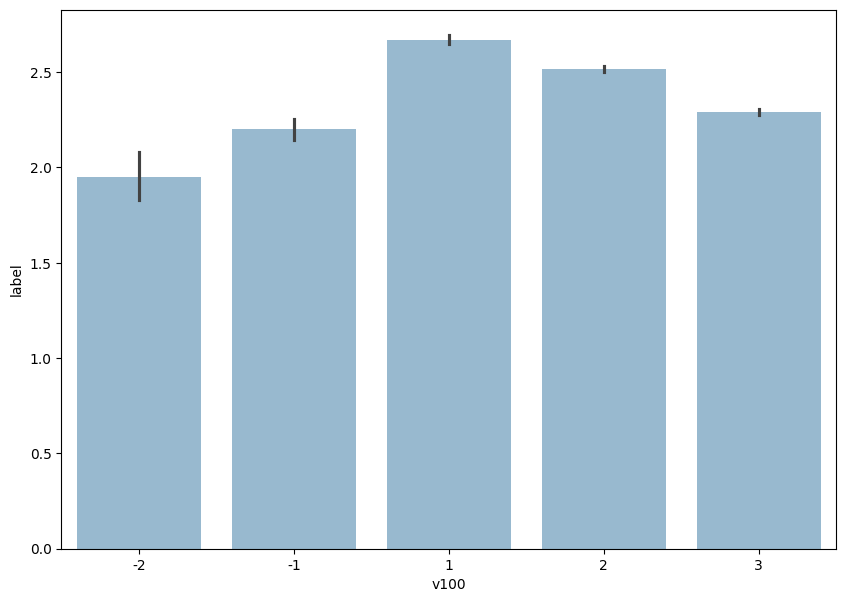

--------------------------------------------------
col: v101


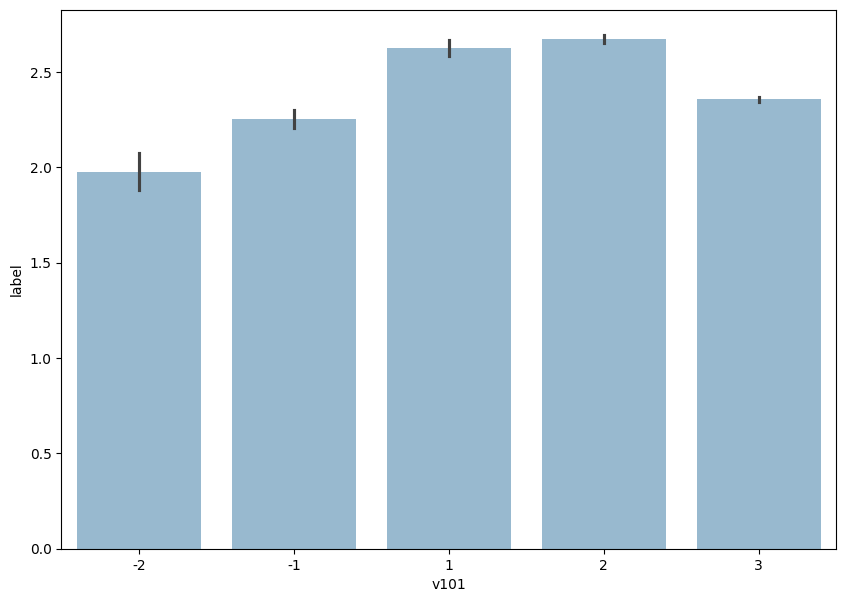

--------------------------------------------------
col: v102


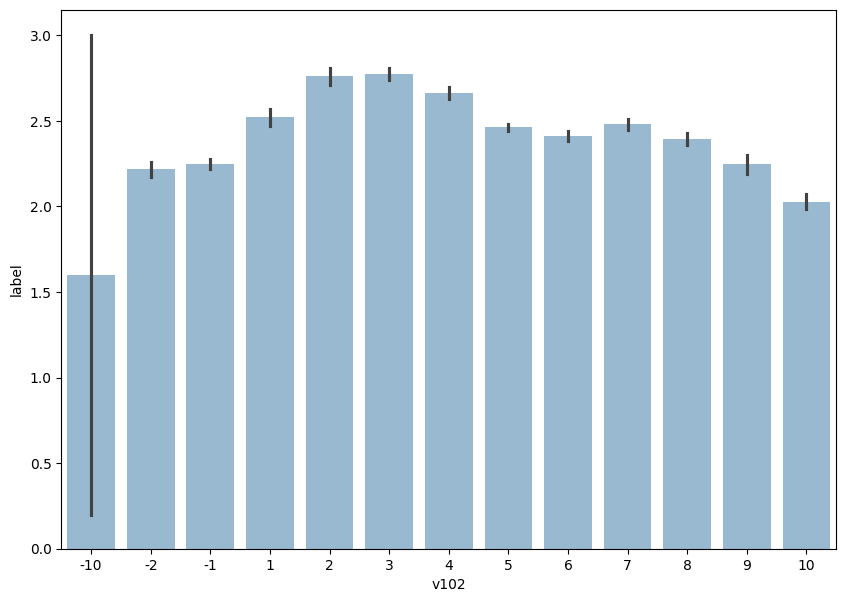

--------------------------------------------------
col: v103


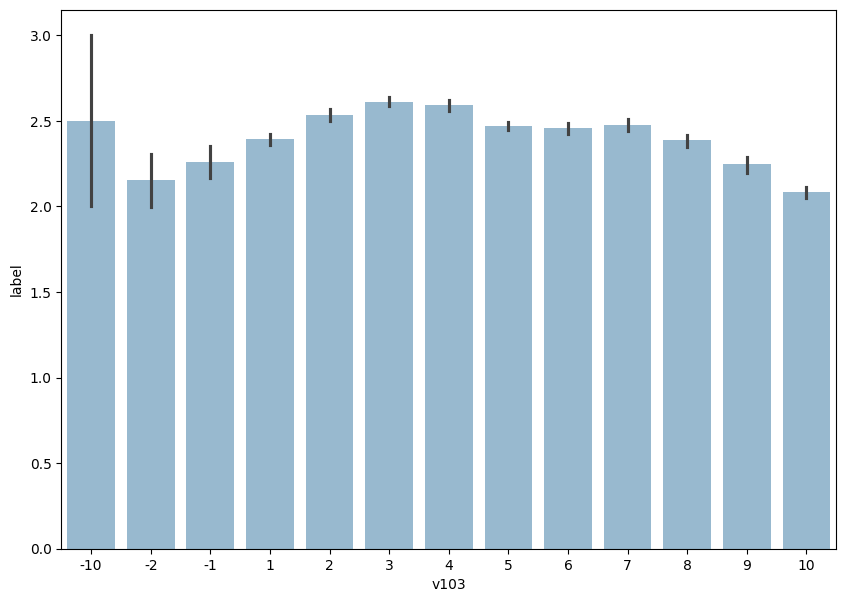

--------------------------------------------------
col: v104


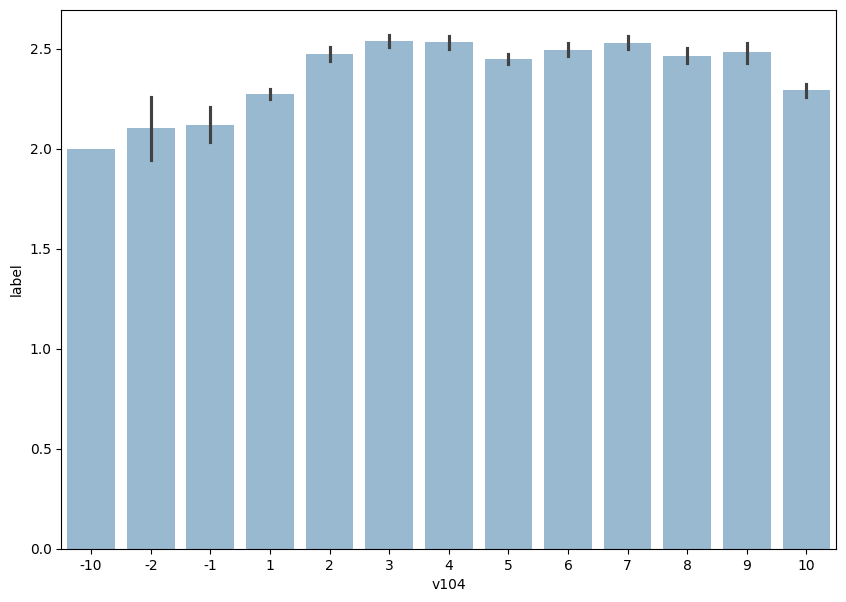

--------------------------------------------------
col: v105


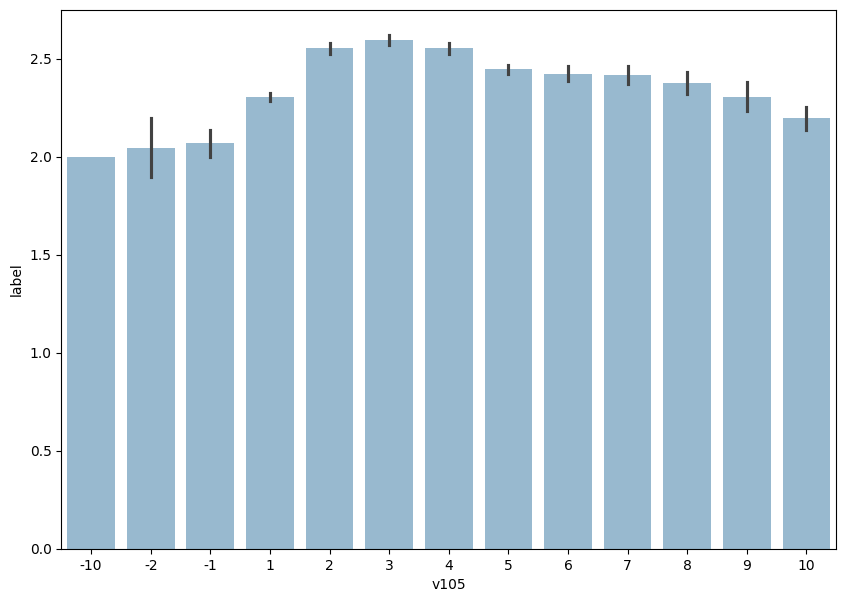

--------------------------------------------------
col: v106


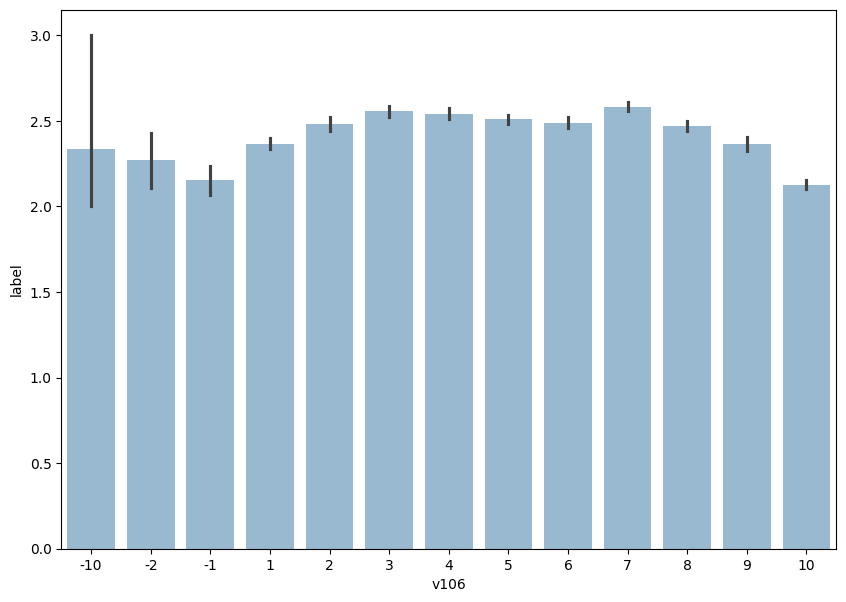

--------------------------------------------------
col: v107


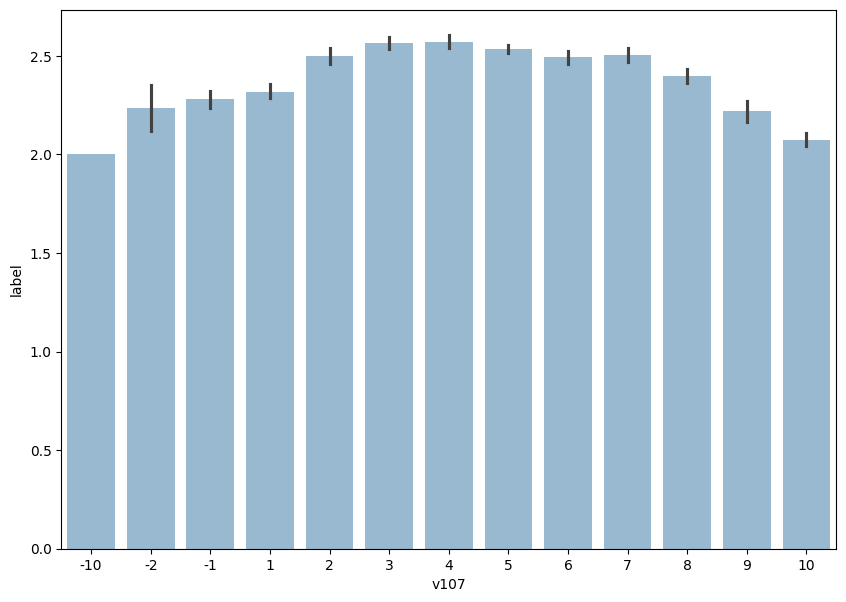

--------------------------------------------------
col: f108


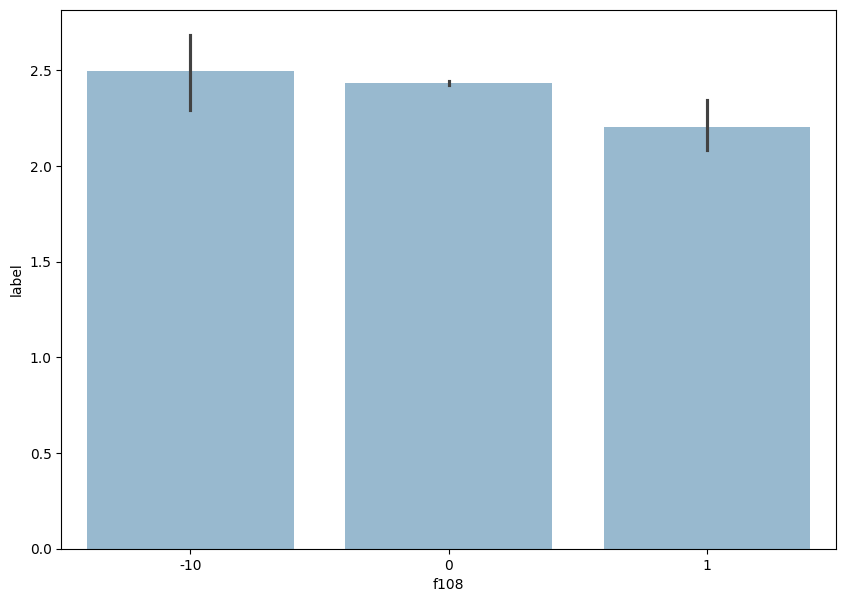

--------------------------------------------------
col: v108


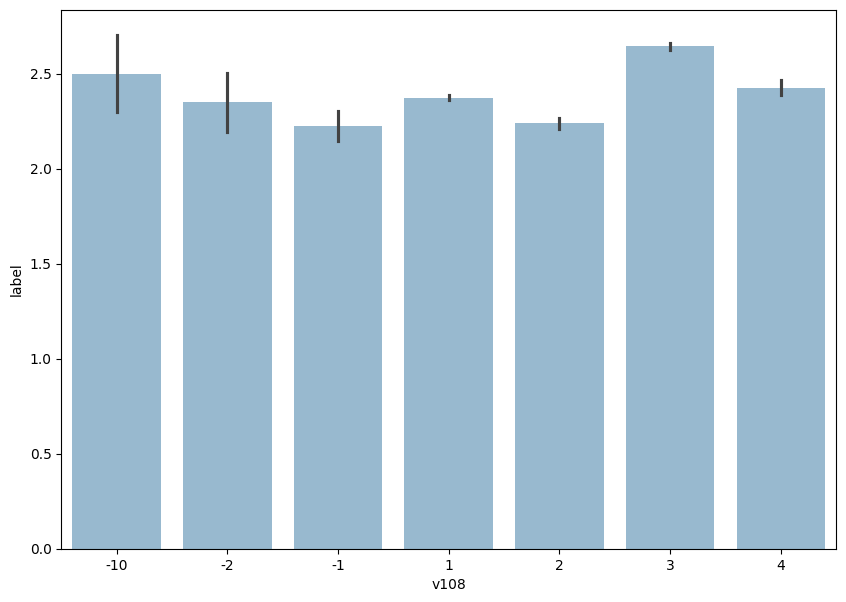

--------------------------------------------------
col: v109


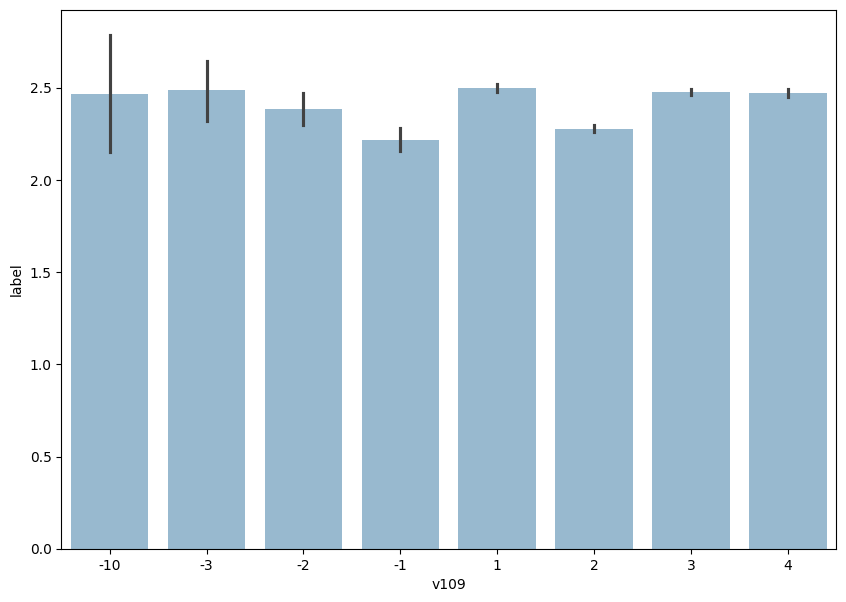

--------------------------------------------------
col: f110


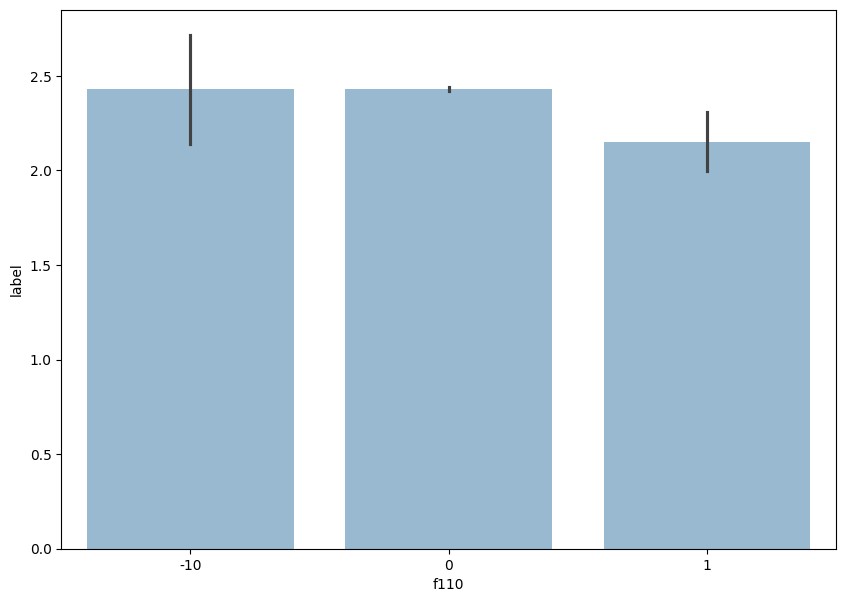

--------------------------------------------------
col: v110


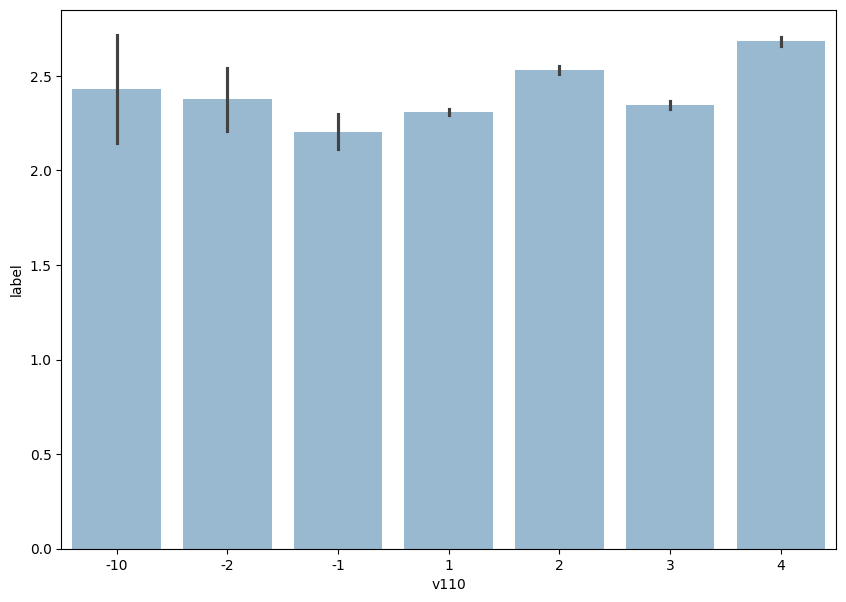

--------------------------------------------------
col: v111


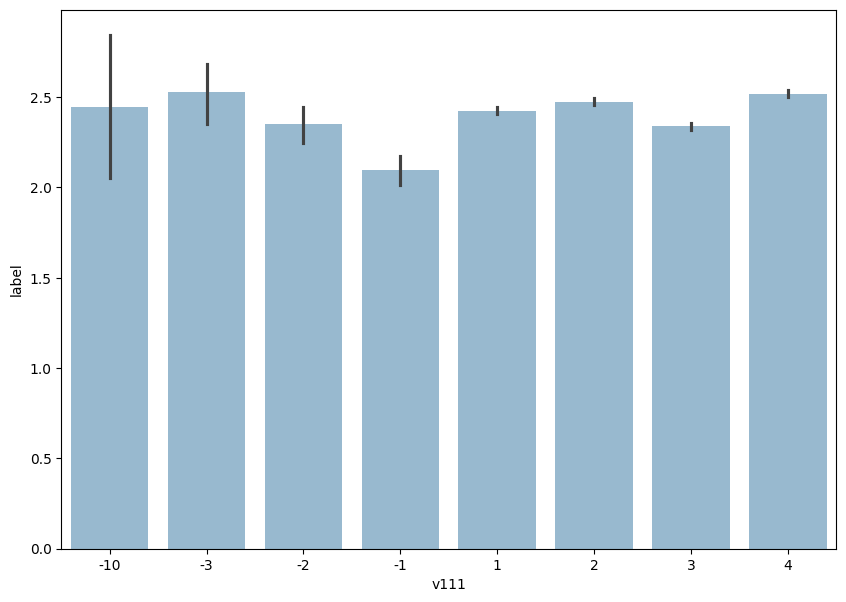

--------------------------------------------------
col: v111_4


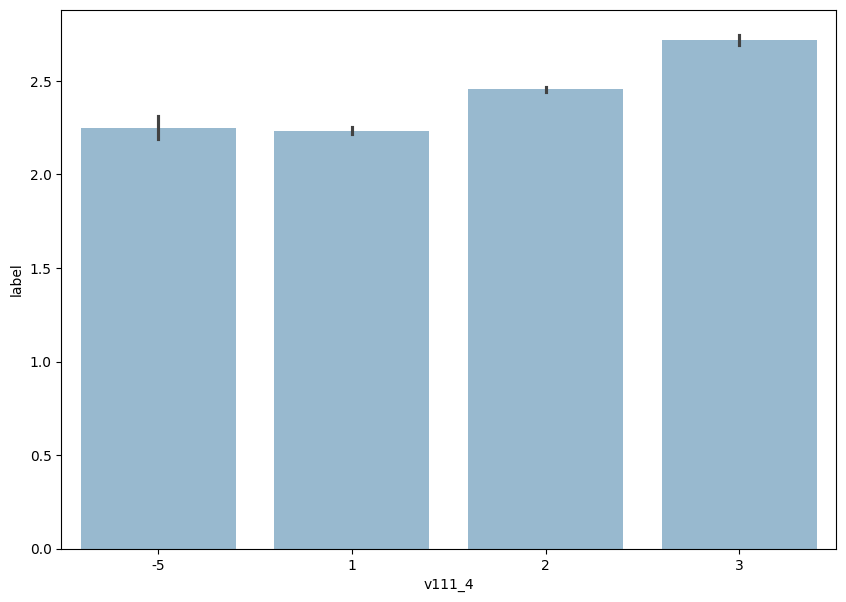

--------------------------------------------------
col: v112


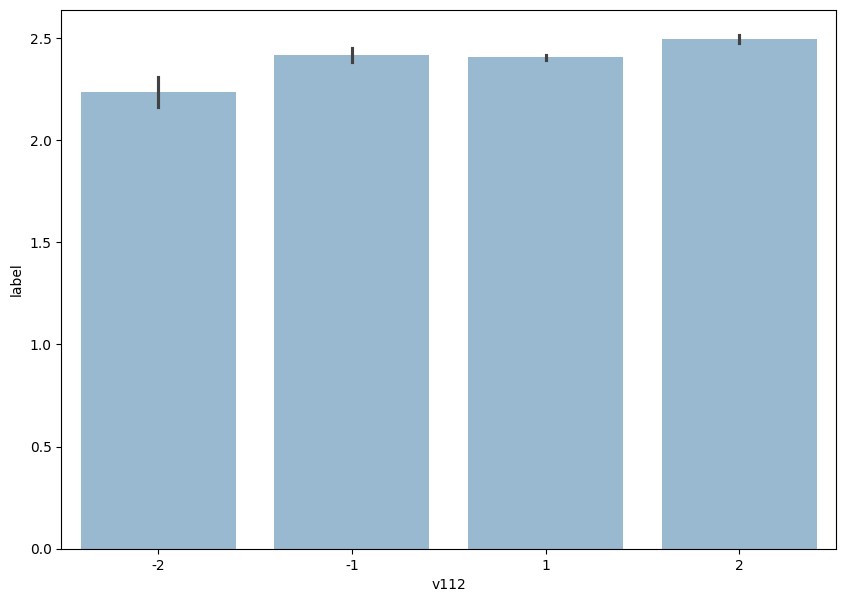

--------------------------------------------------
col: f112_SE


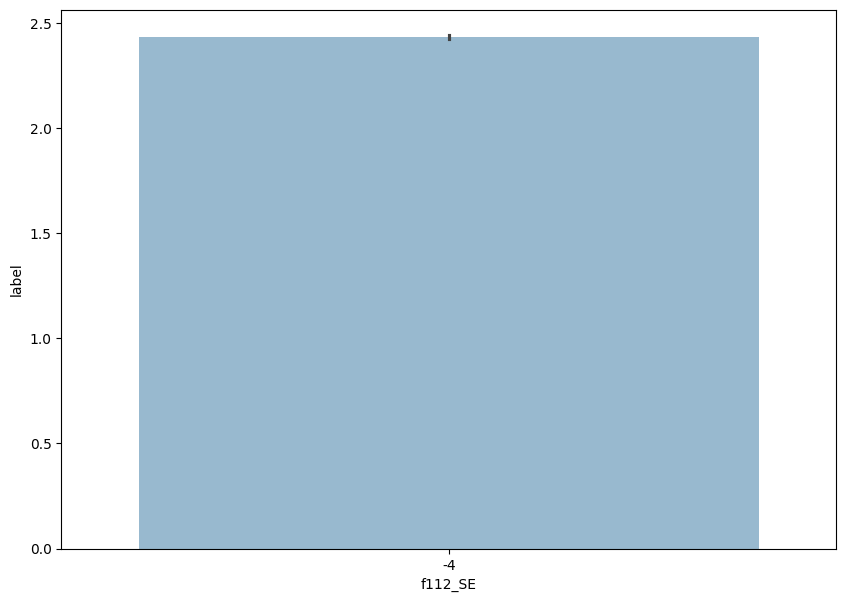

--------------------------------------------------
col: v113


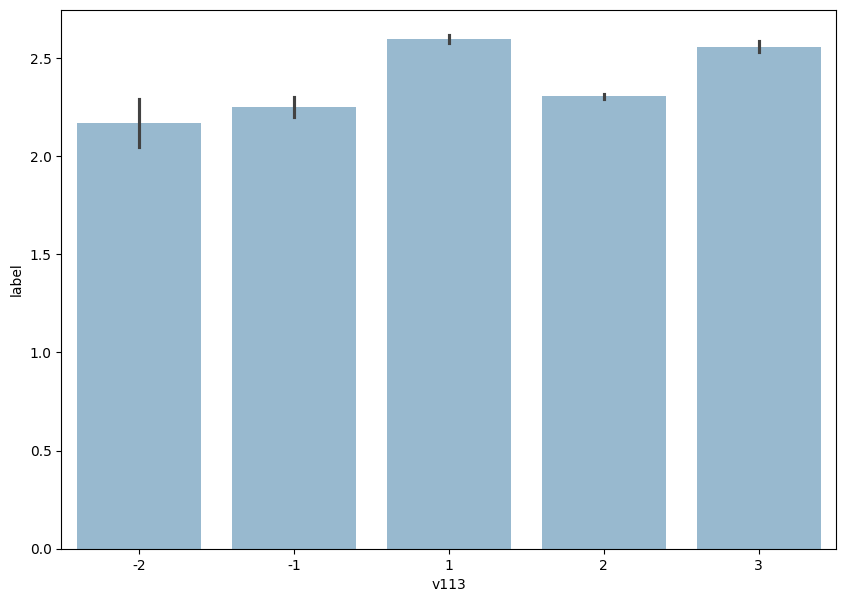

--------------------------------------------------
col: v114


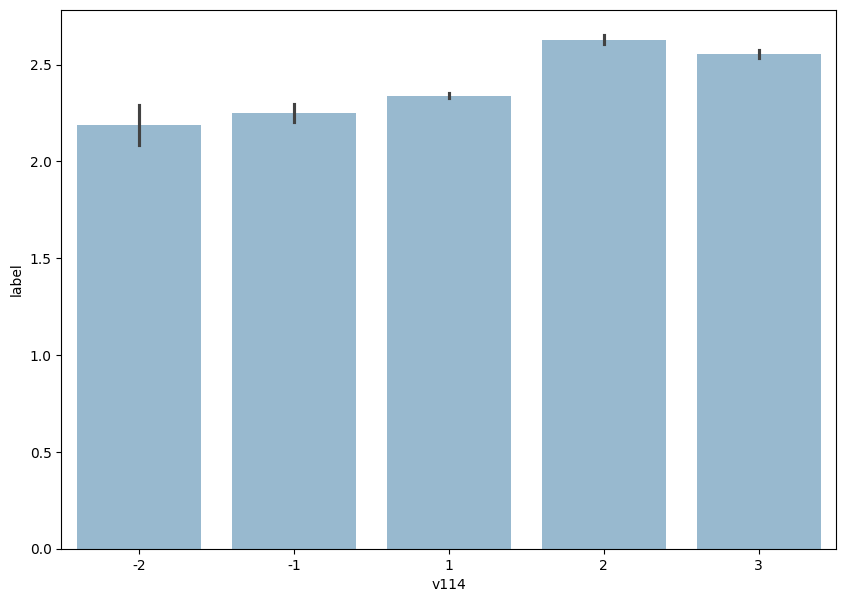

--------------------------------------------------
col: v115


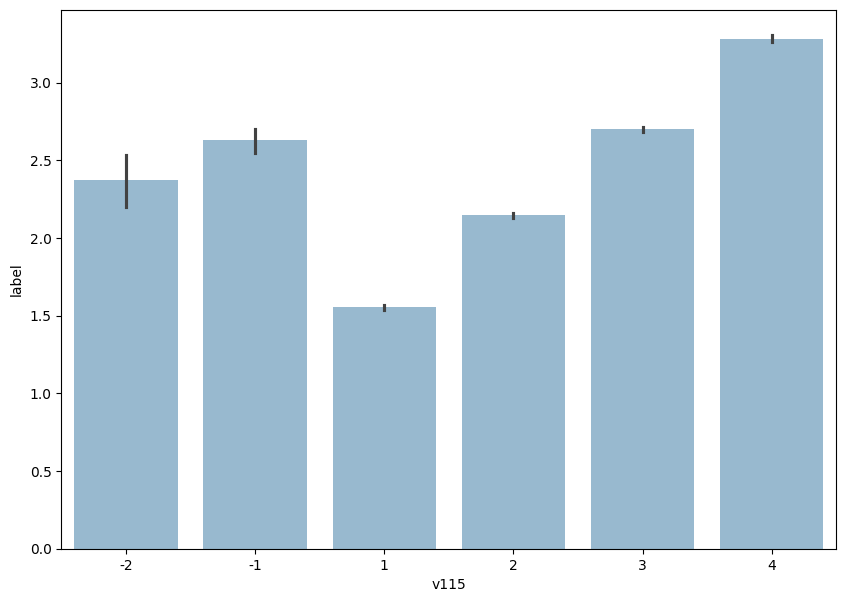

--------------------------------------------------
col: v116


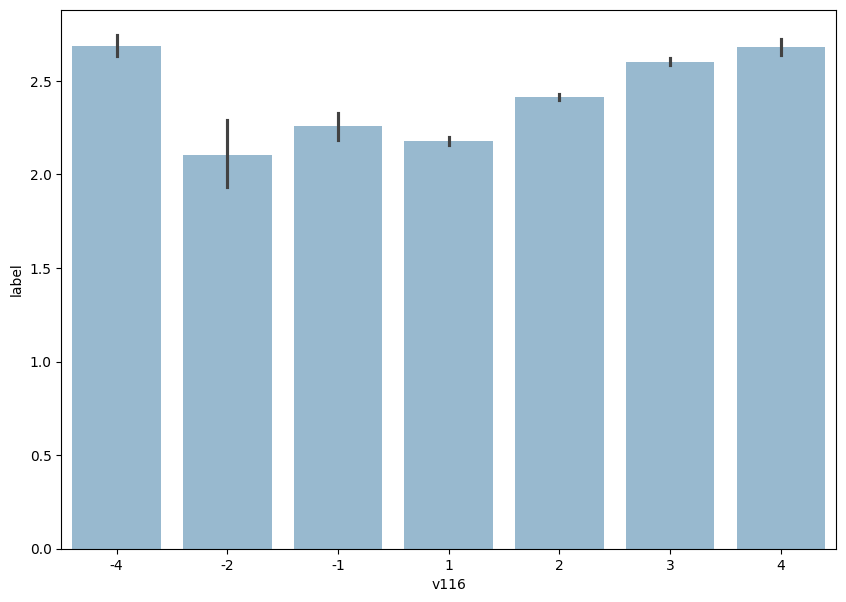

--------------------------------------------------
col: v117


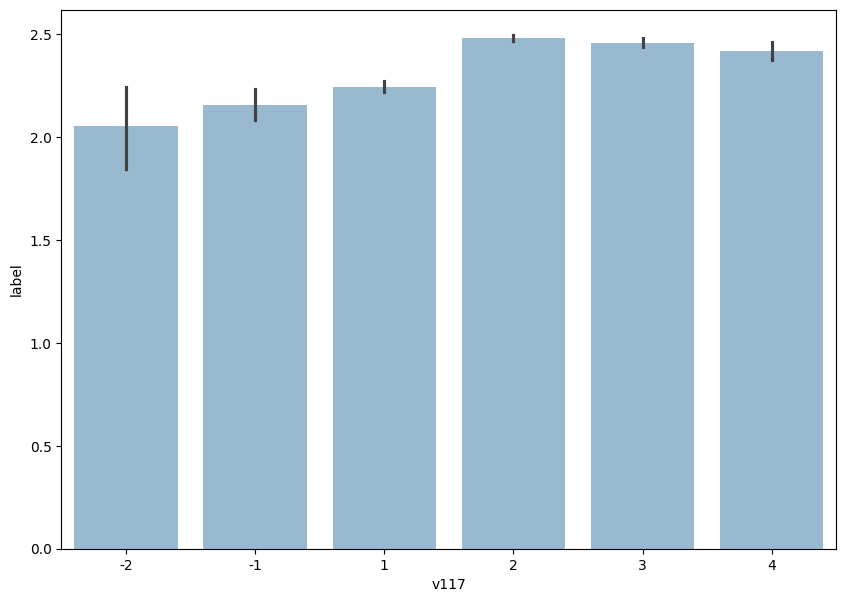

--------------------------------------------------
col: v118


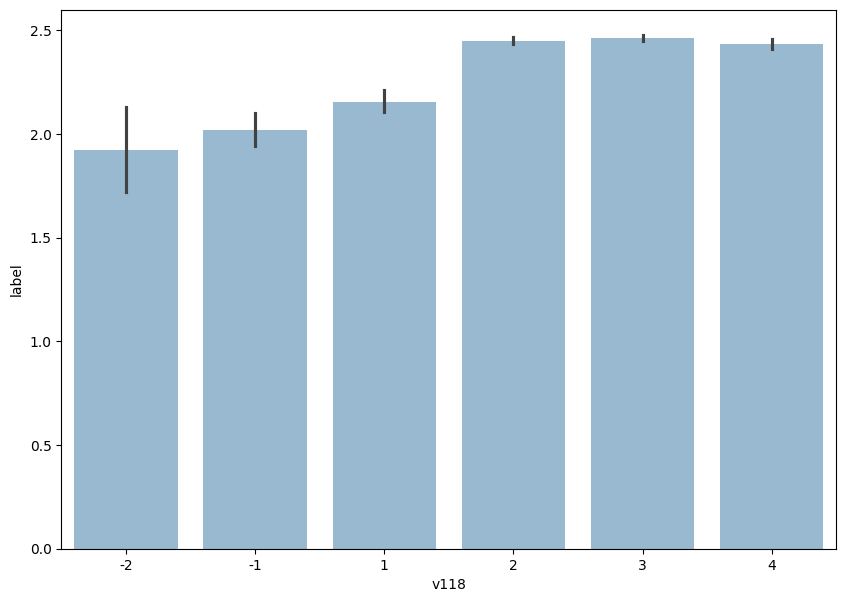

--------------------------------------------------
col: v119


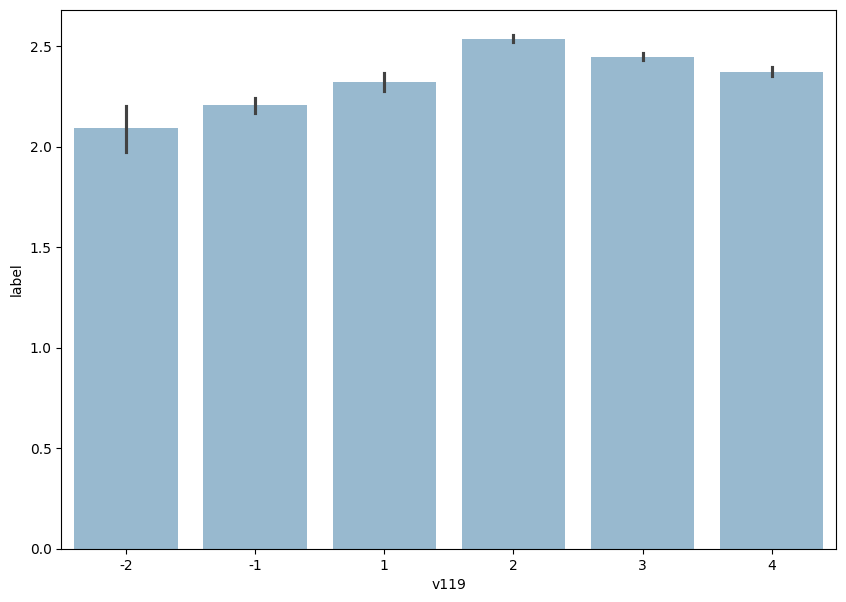

--------------------------------------------------
col: v120


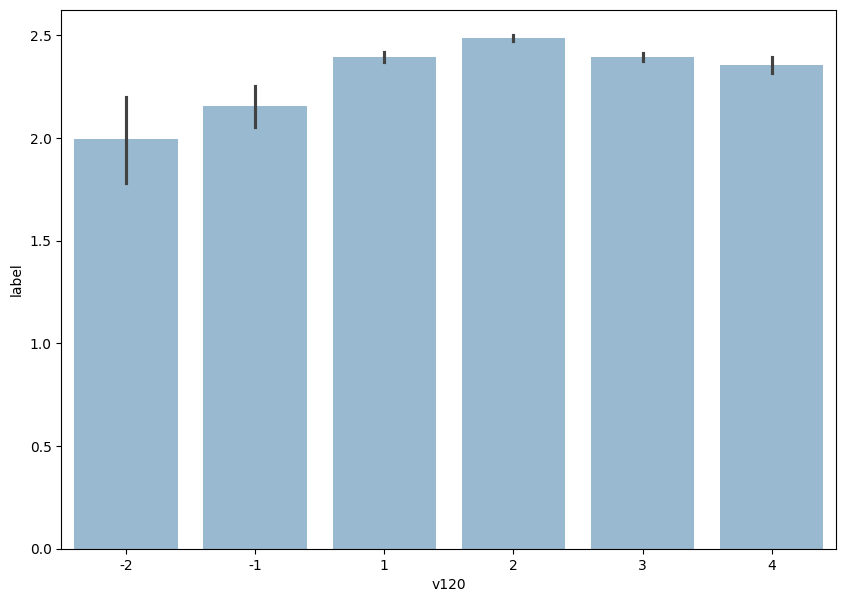

--------------------------------------------------
col: v121


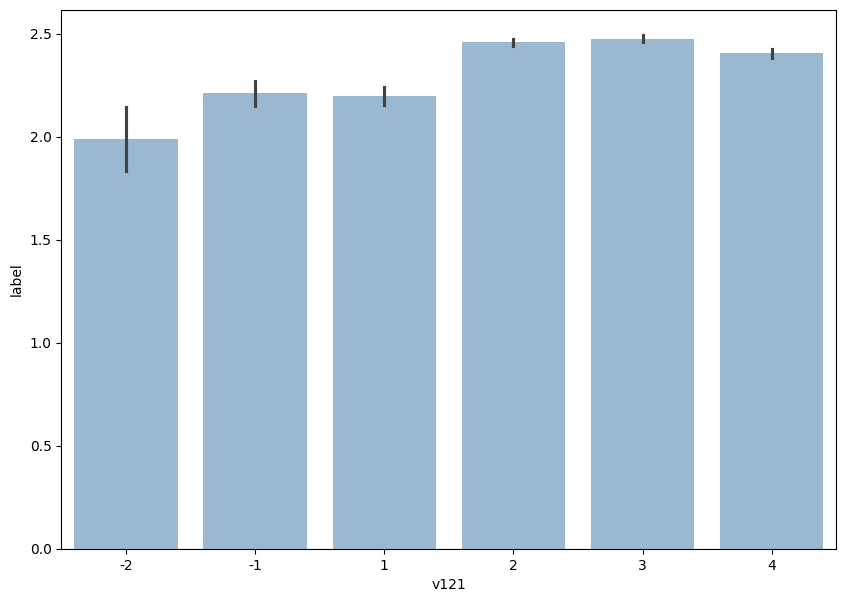

--------------------------------------------------
col: v122


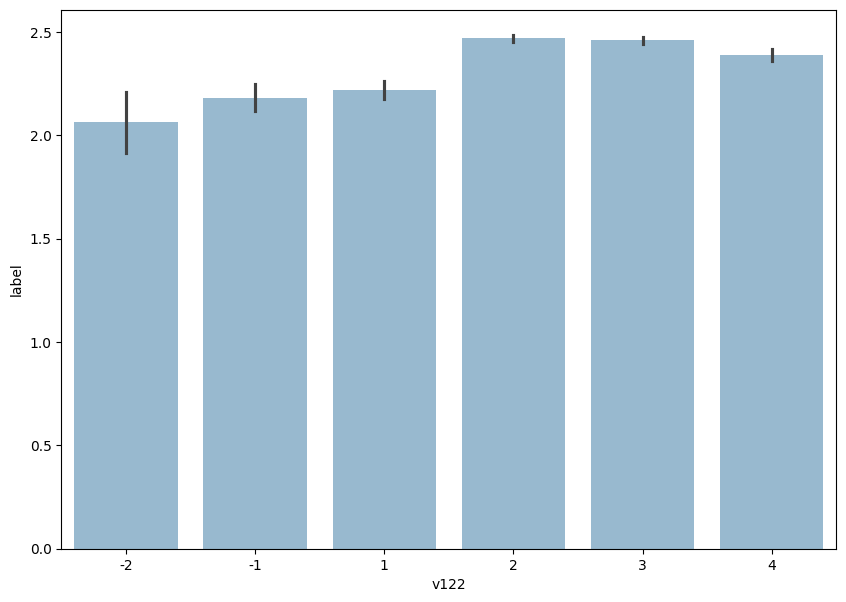

--------------------------------------------------
col: v123


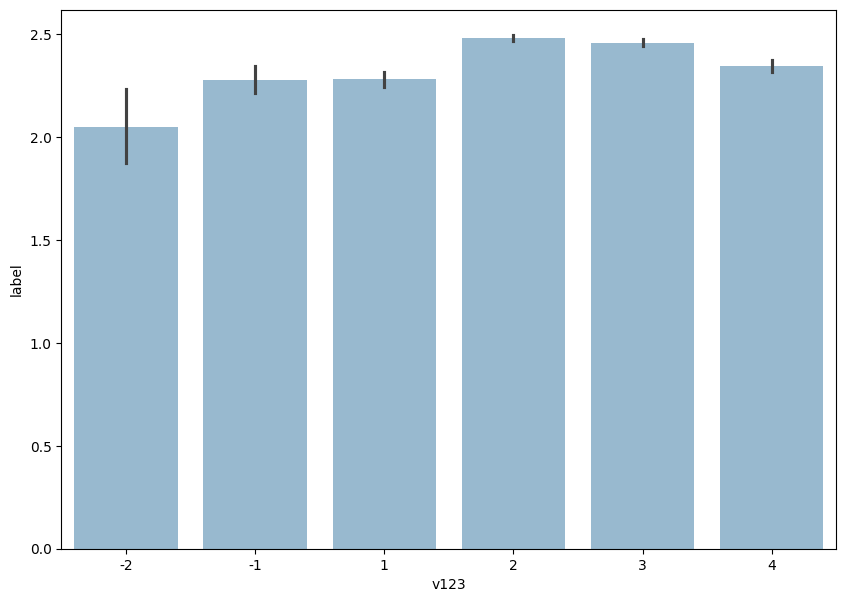

--------------------------------------------------
col: v124


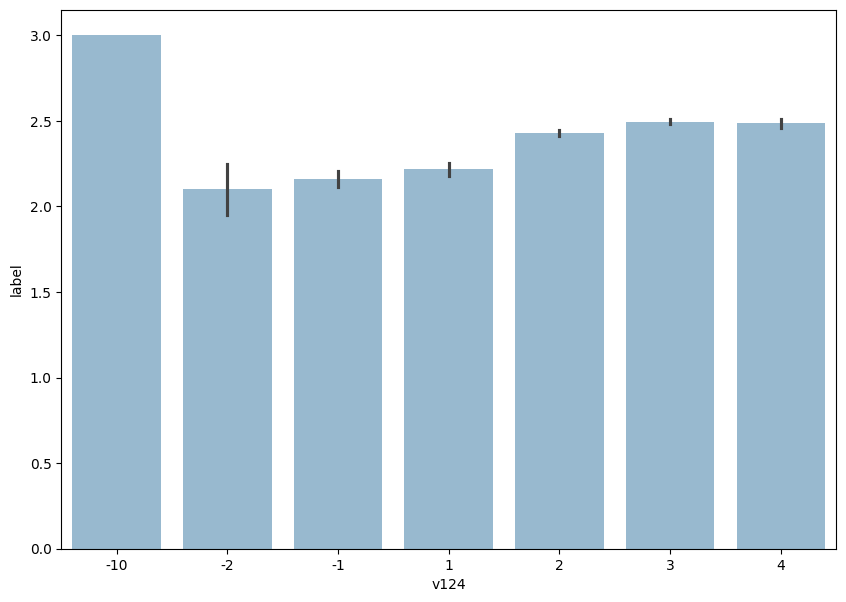

--------------------------------------------------
col: v125


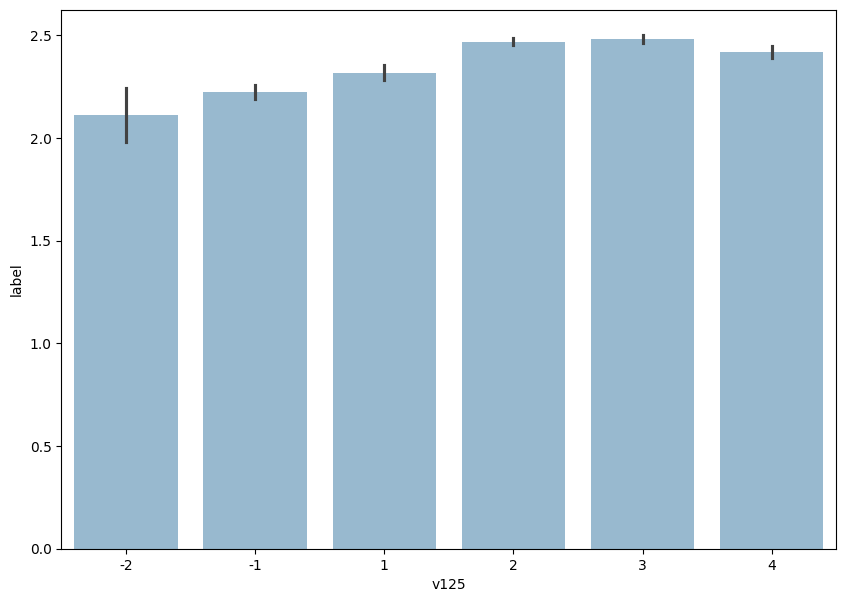

--------------------------------------------------
col: v126


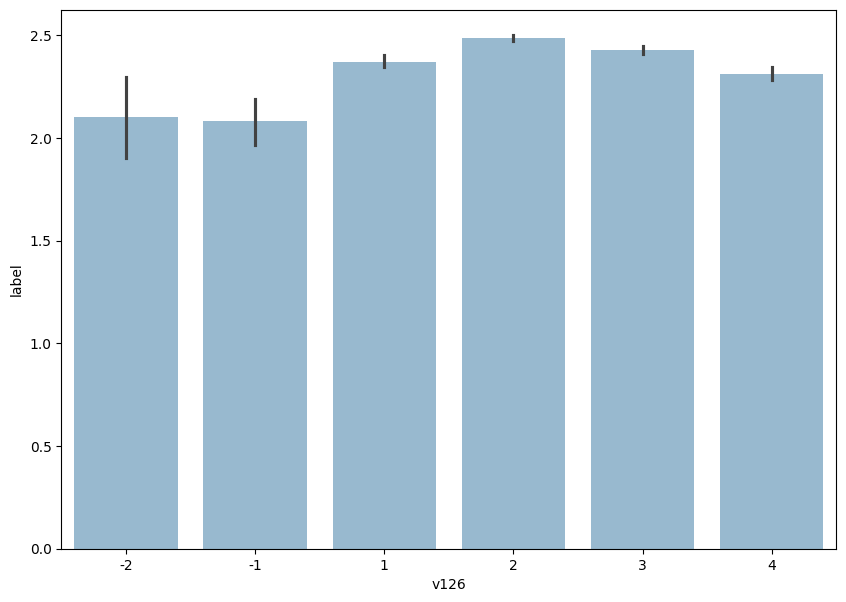

--------------------------------------------------
col: v127


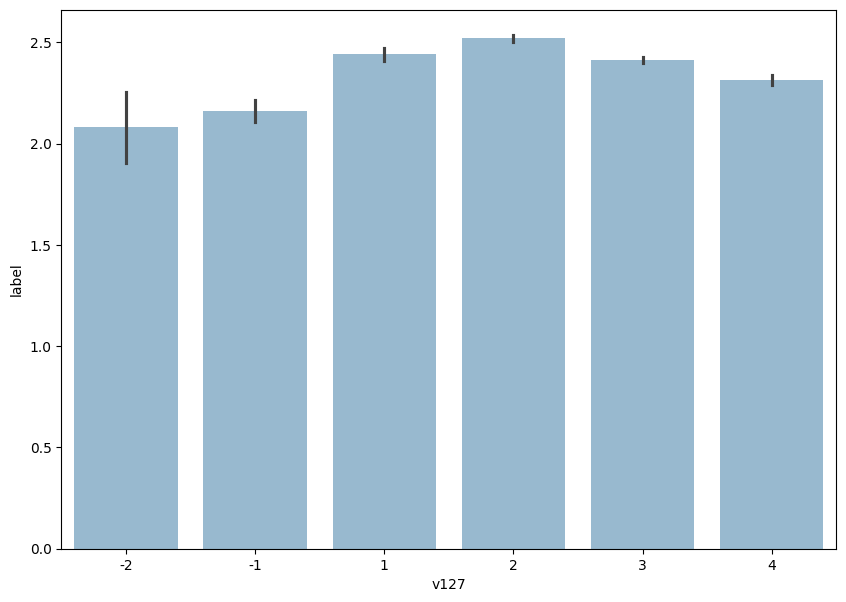

--------------------------------------------------
col: v128


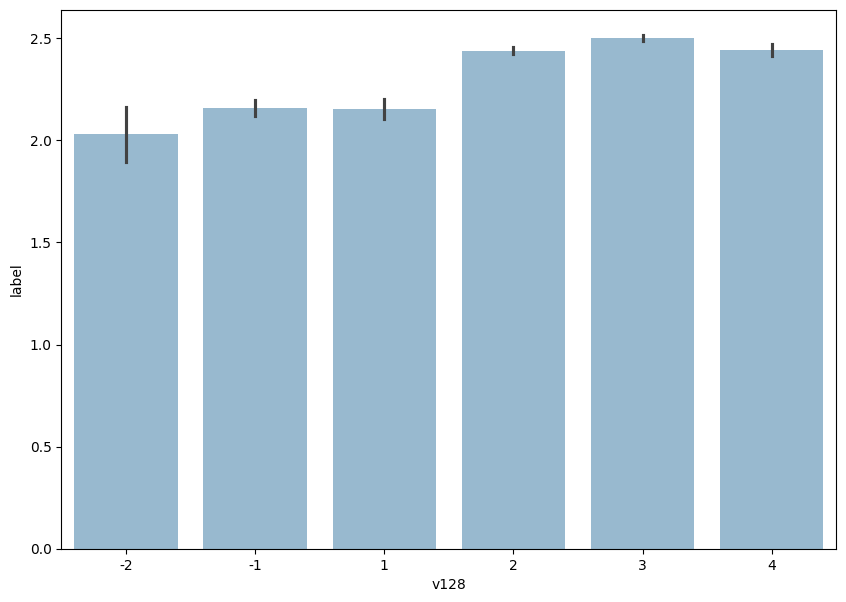

--------------------------------------------------
col: v129


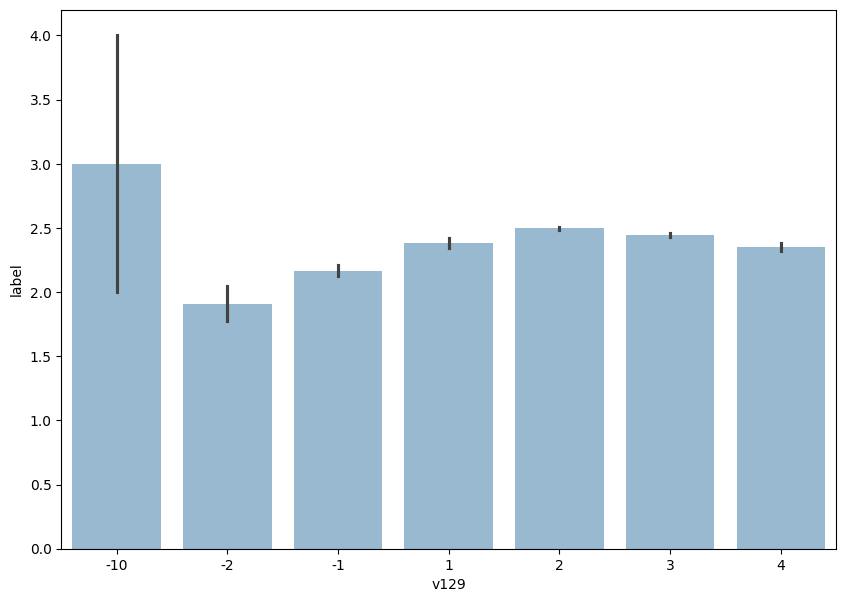

--------------------------------------------------
col: v130


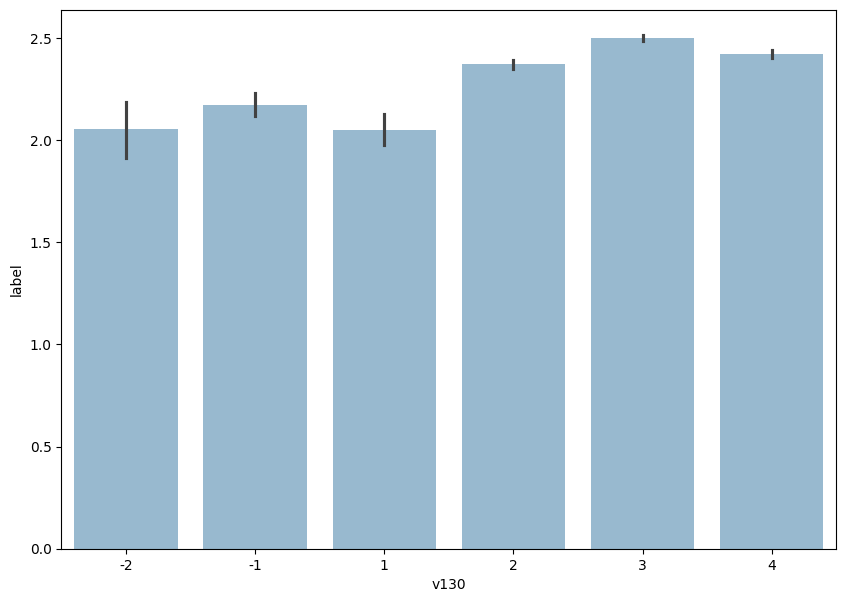

--------------------------------------------------
col: v131


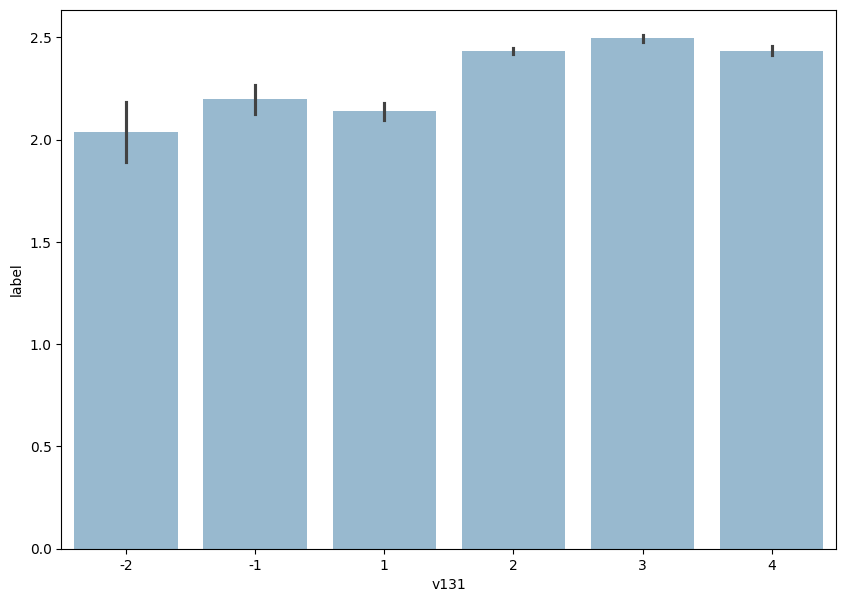

--------------------------------------------------
col: v132


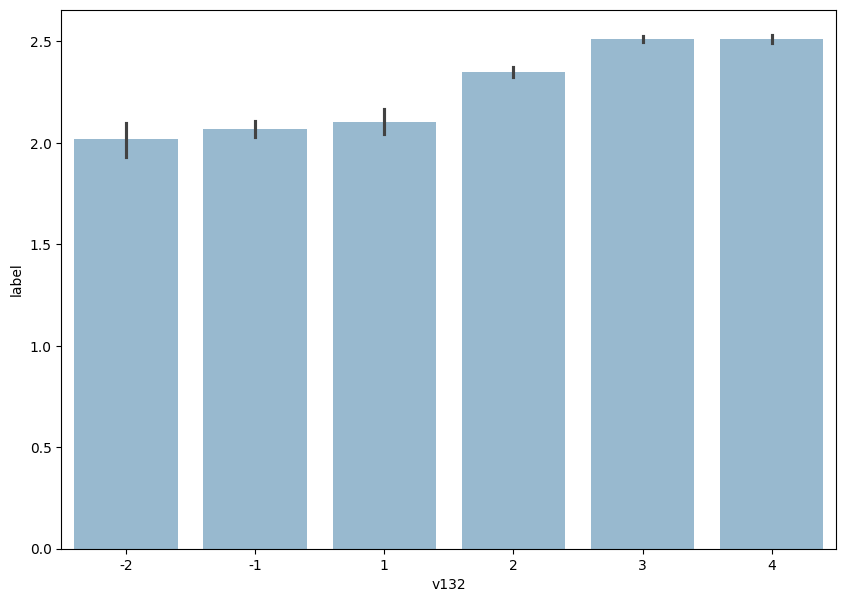

--------------------------------------------------
col: v133


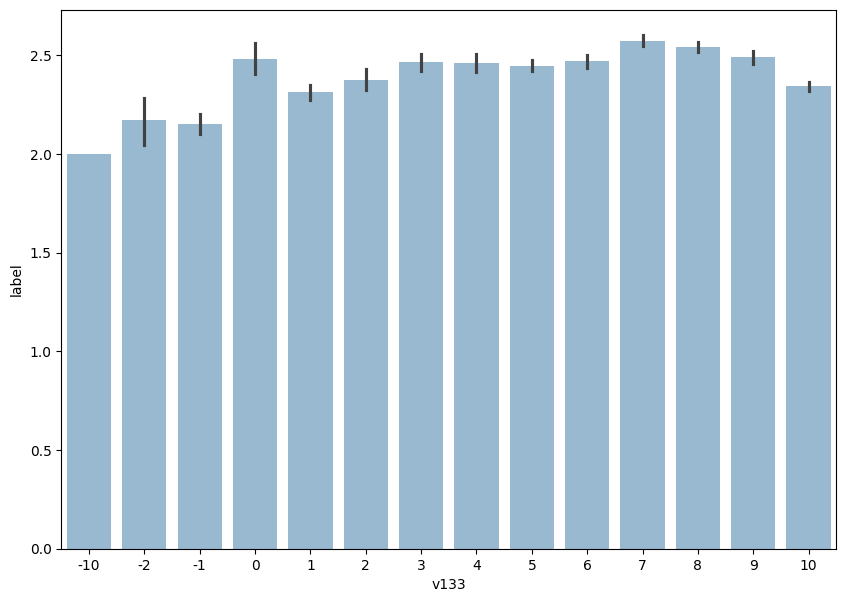

--------------------------------------------------
col: v133_11c


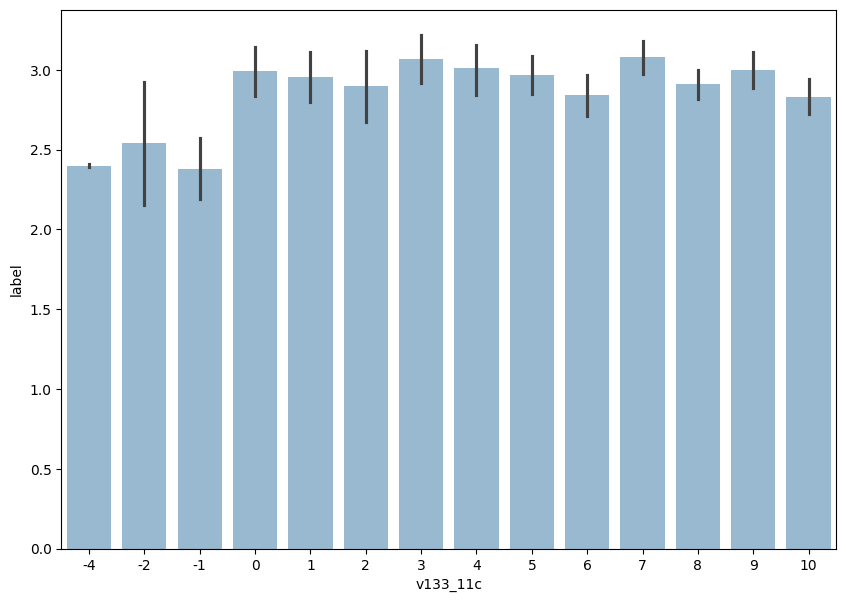

--------------------------------------------------
col: v134


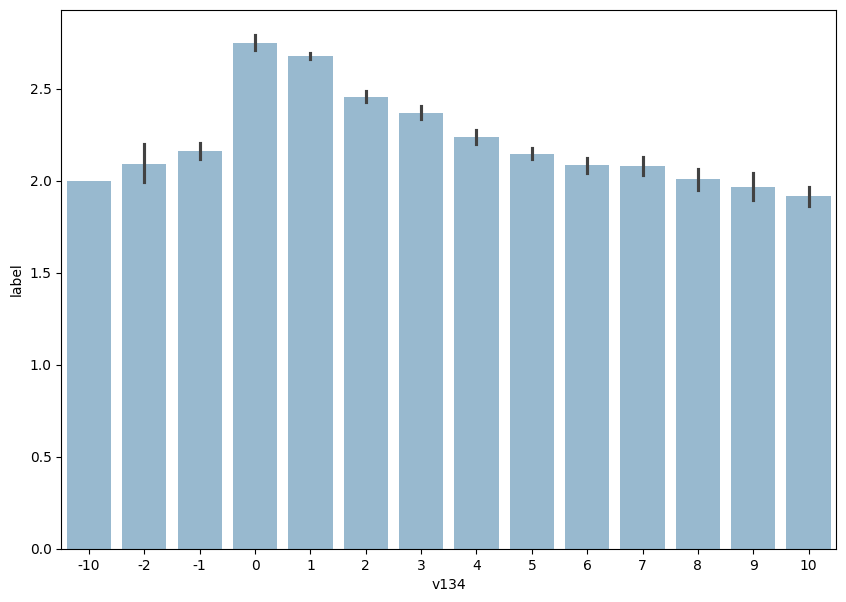

--------------------------------------------------
col: v134_11c


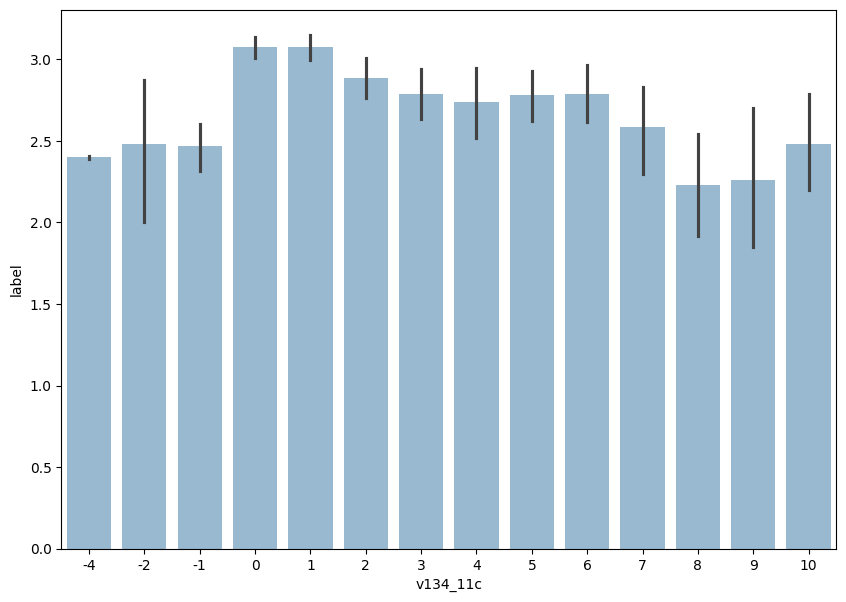

--------------------------------------------------
col: v135


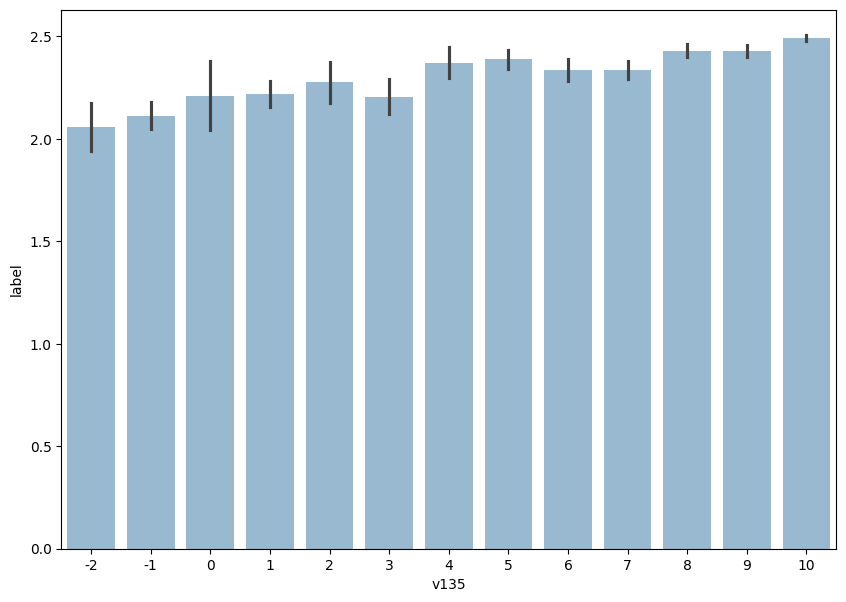

--------------------------------------------------
col: v136


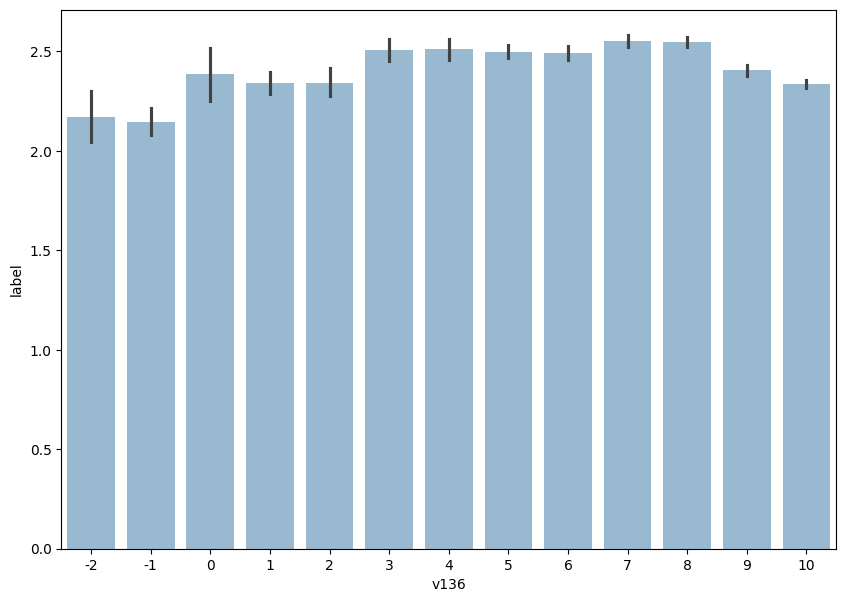

--------------------------------------------------
col: v137


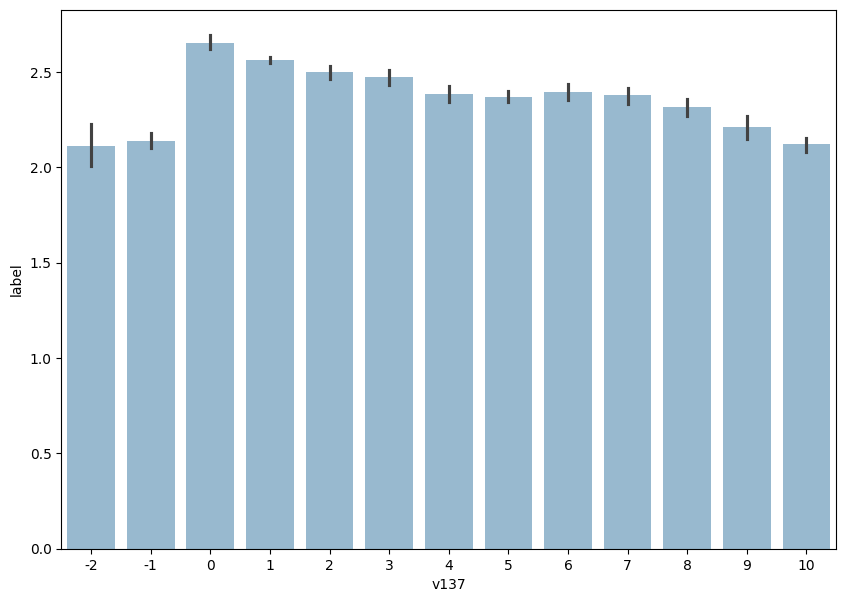

--------------------------------------------------
col: v137_11c


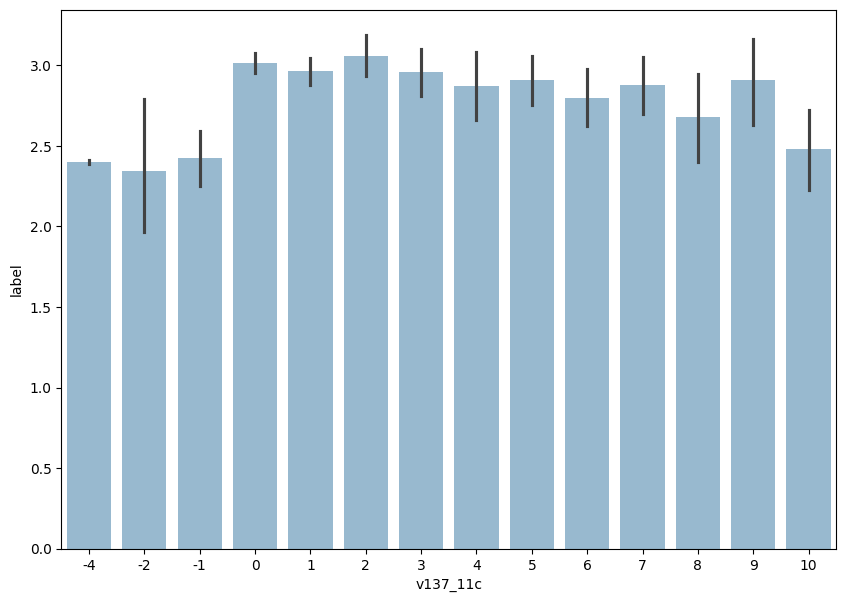

--------------------------------------------------
col: v138


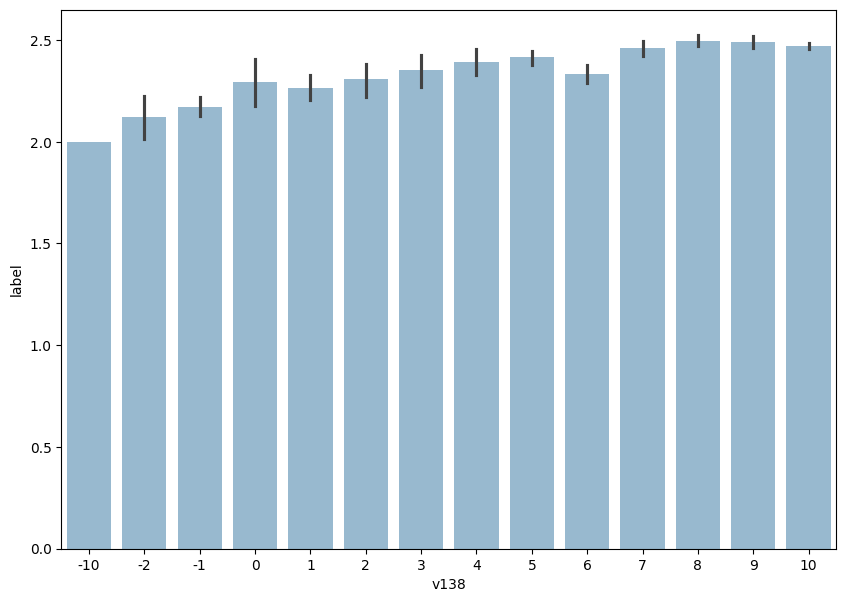

--------------------------------------------------
col: v138_11c


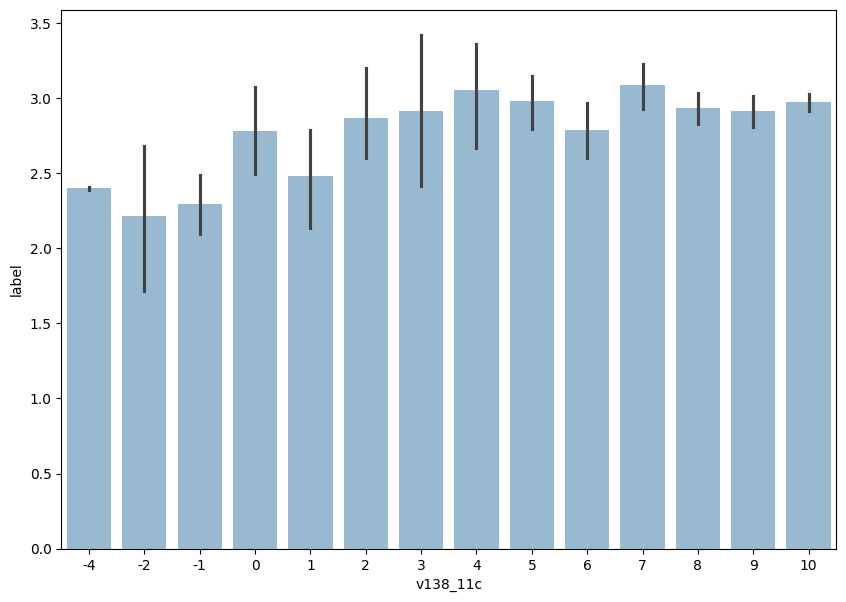

--------------------------------------------------
col: v139


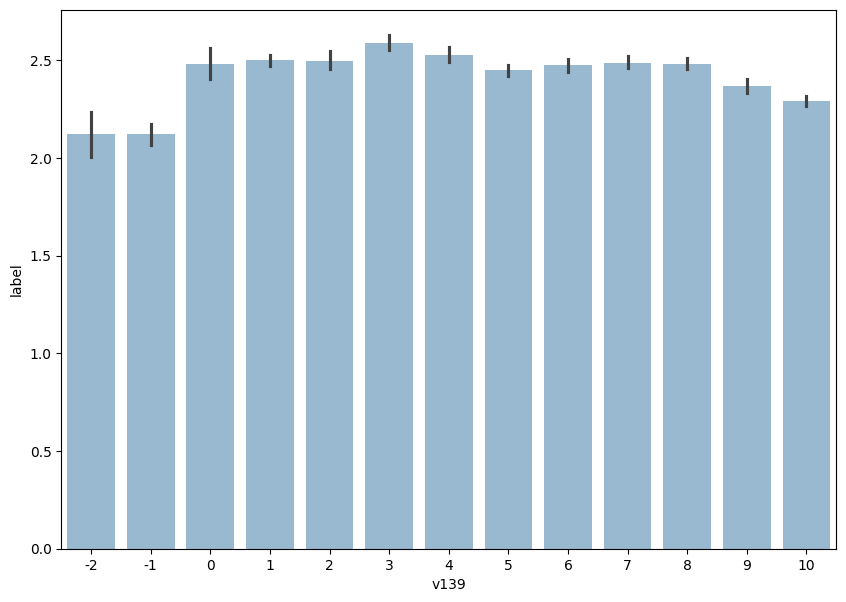

--------------------------------------------------
col: v139_11c


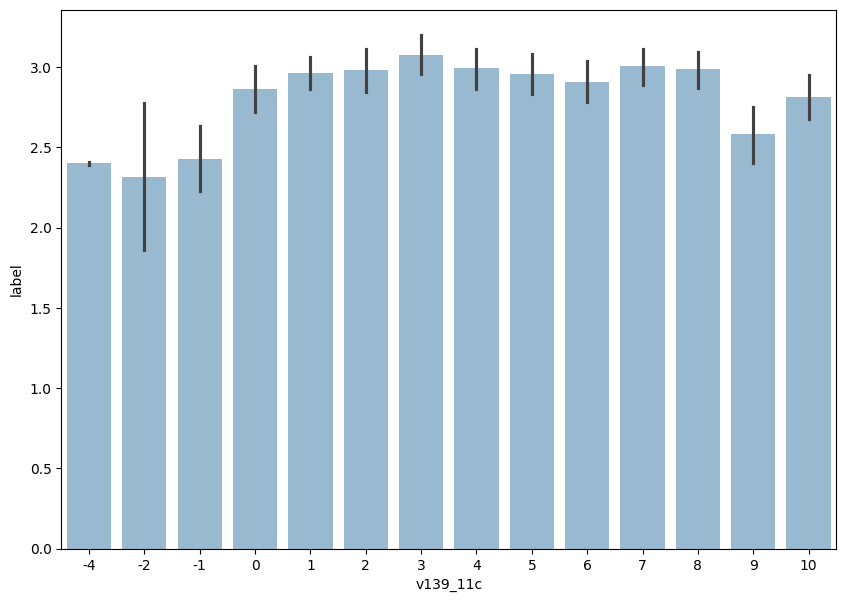

--------------------------------------------------
col: v140


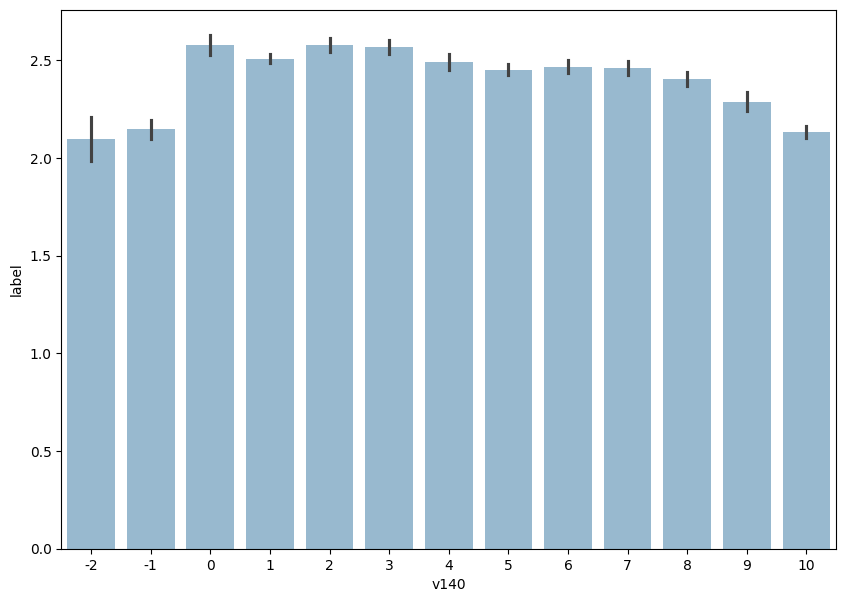

--------------------------------------------------
col: v140_11c


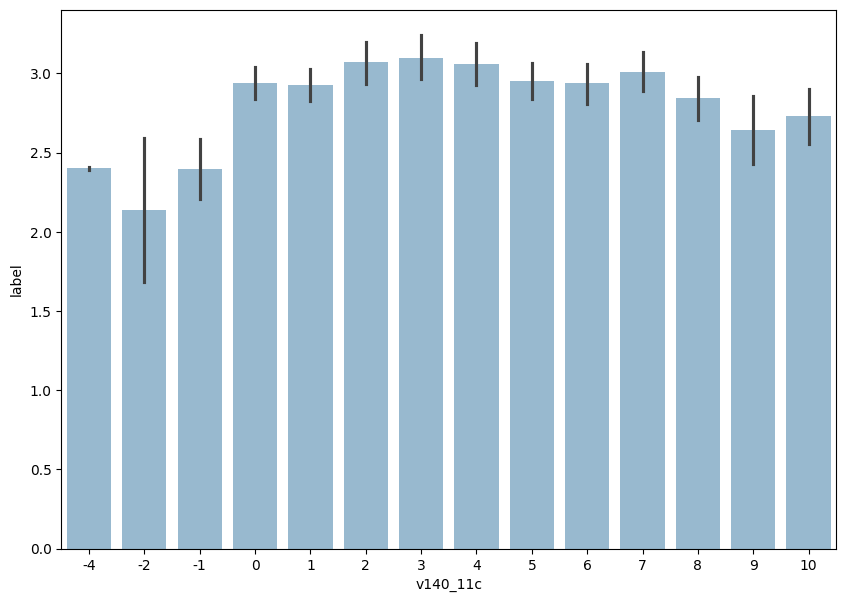

--------------------------------------------------
col: v141


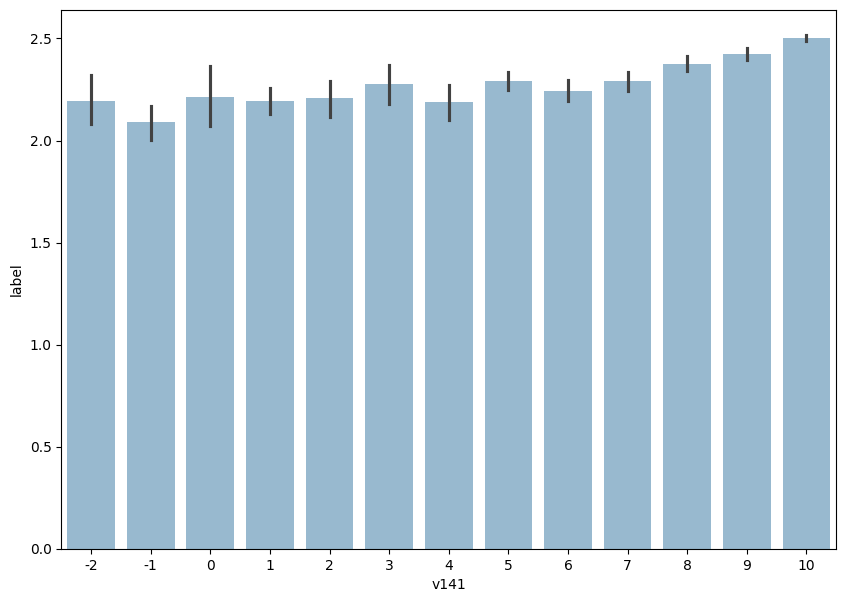

--------------------------------------------------
col: v142


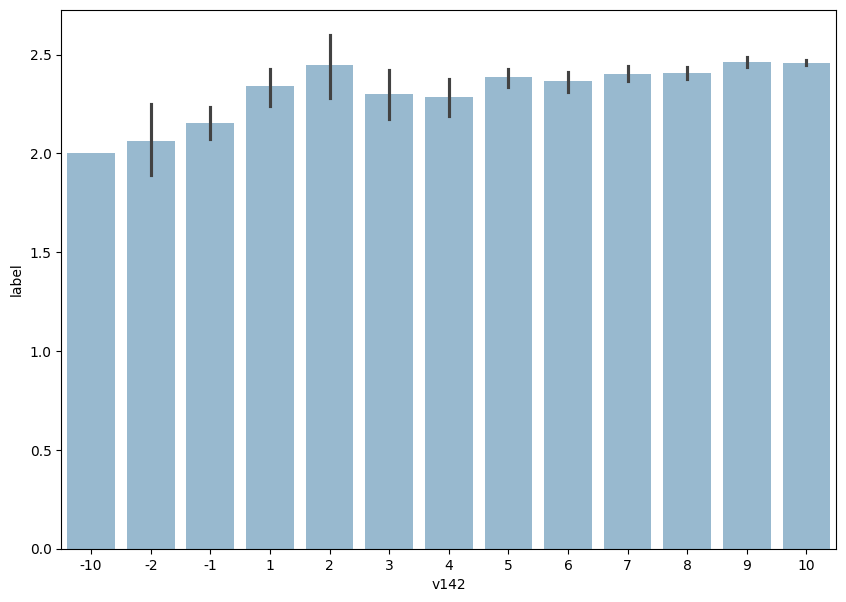

--------------------------------------------------
col: v143


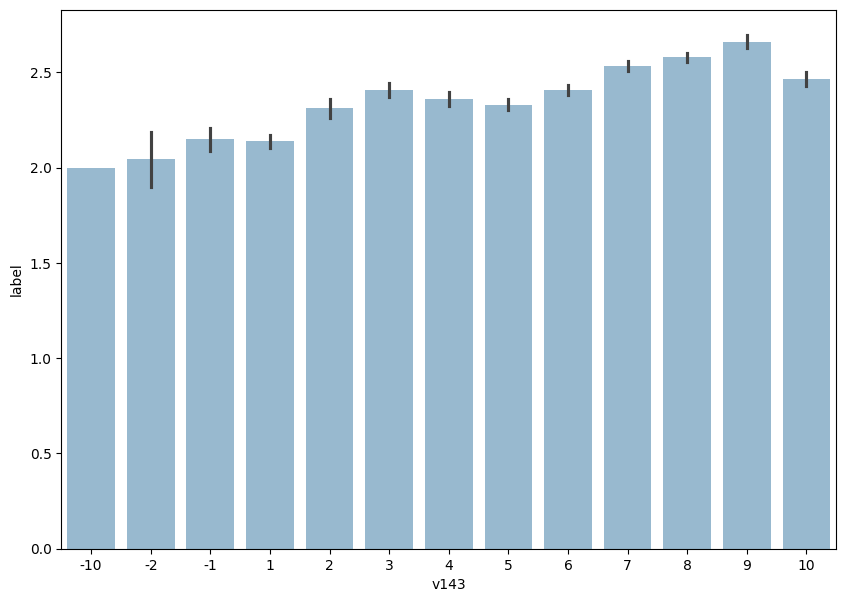

--------------------------------------------------
col: v144


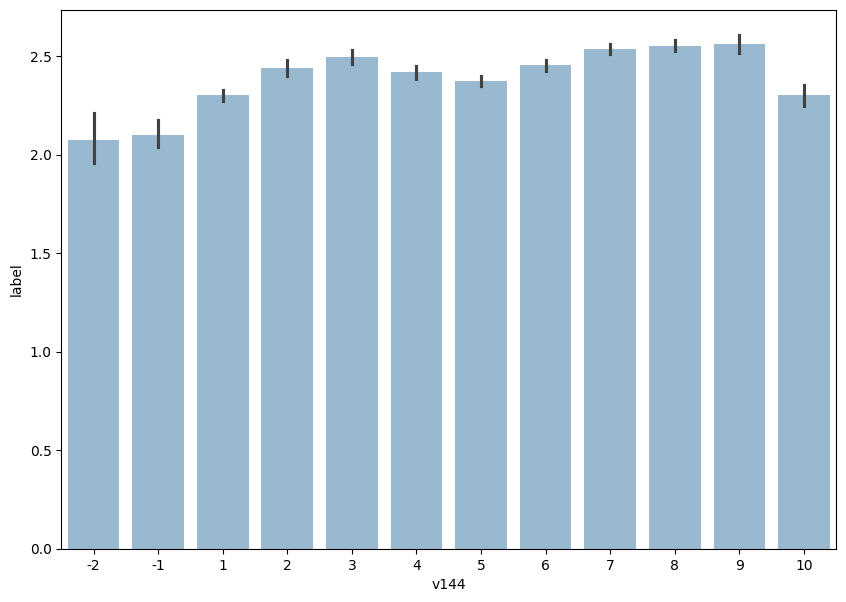

--------------------------------------------------
col: v145


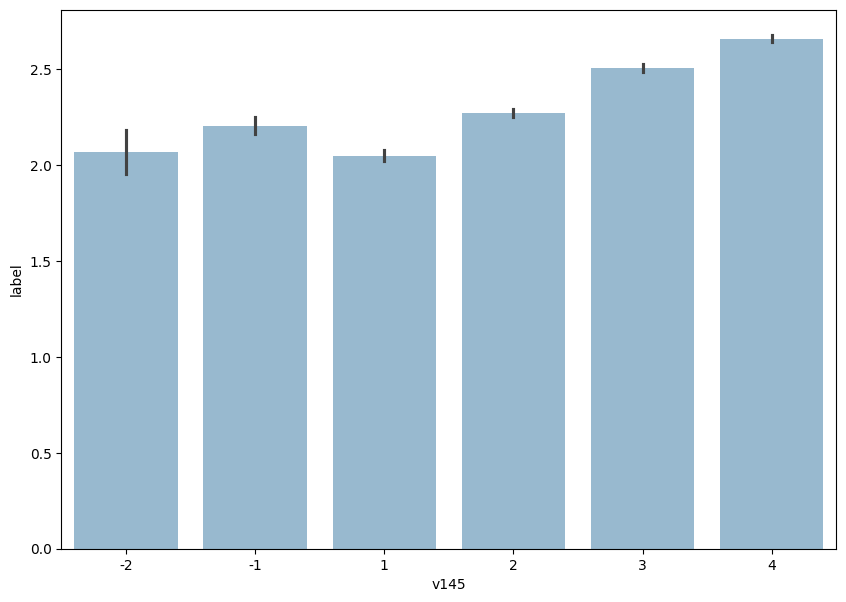

--------------------------------------------------
col: v146


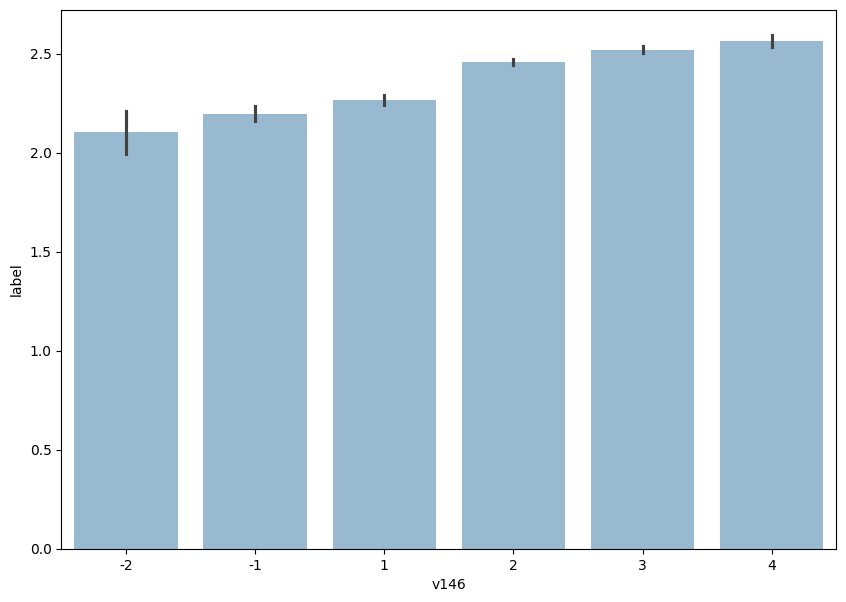

--------------------------------------------------
col: v147


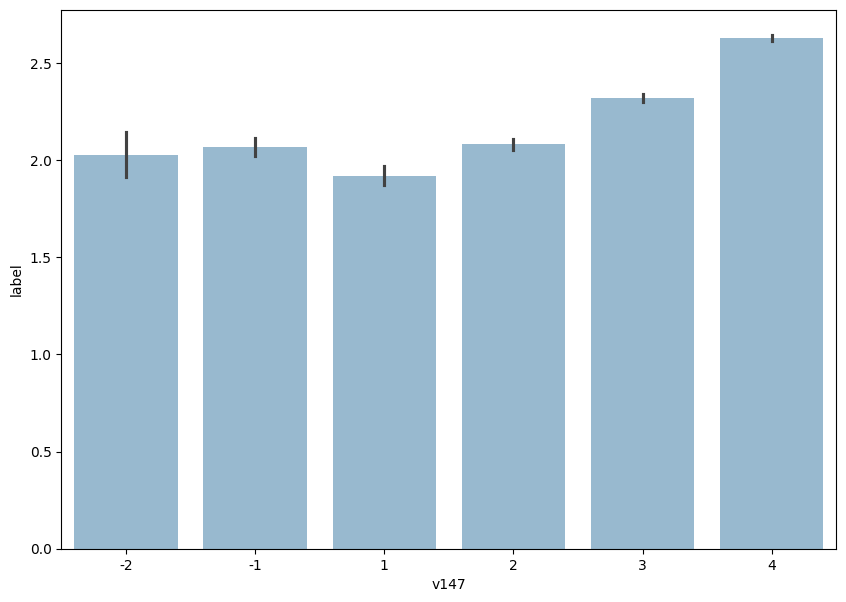

--------------------------------------------------
col: v148


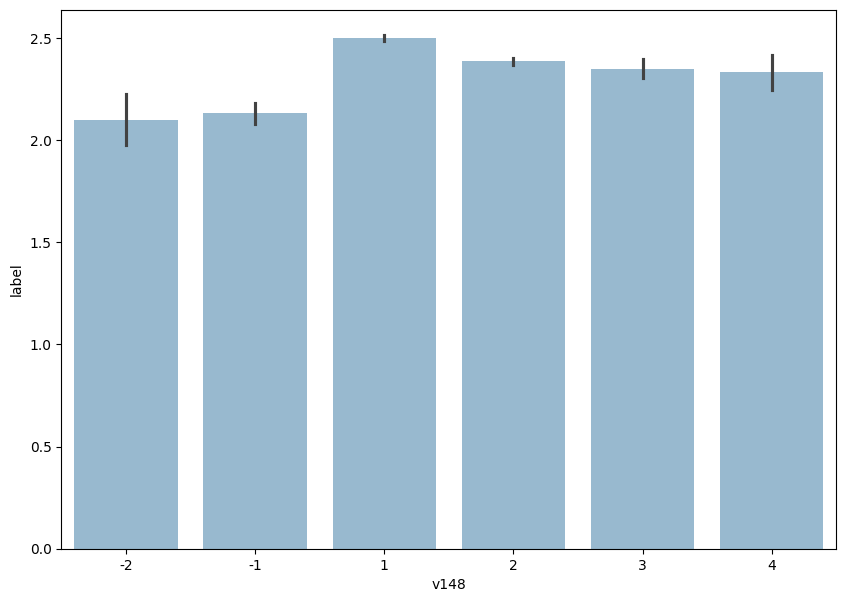

--------------------------------------------------
col: v149


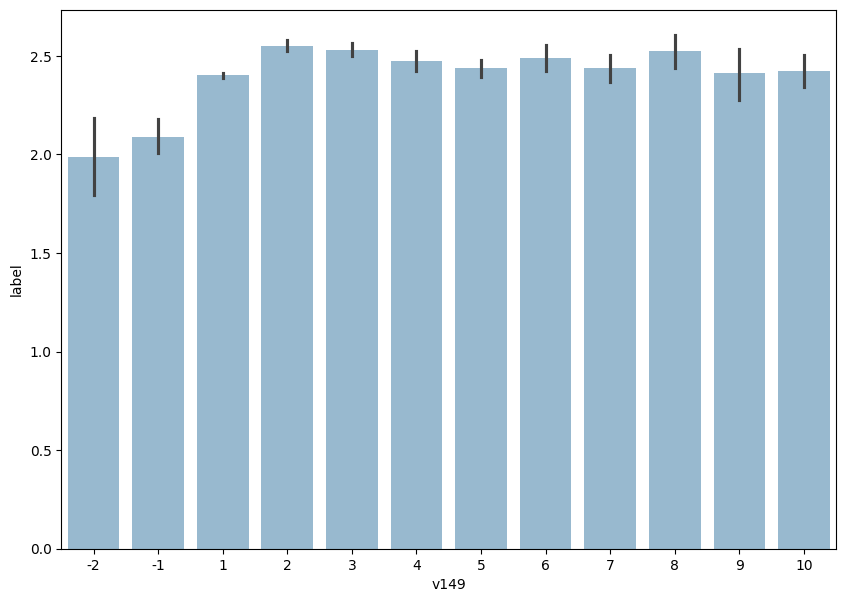

--------------------------------------------------
col: v150


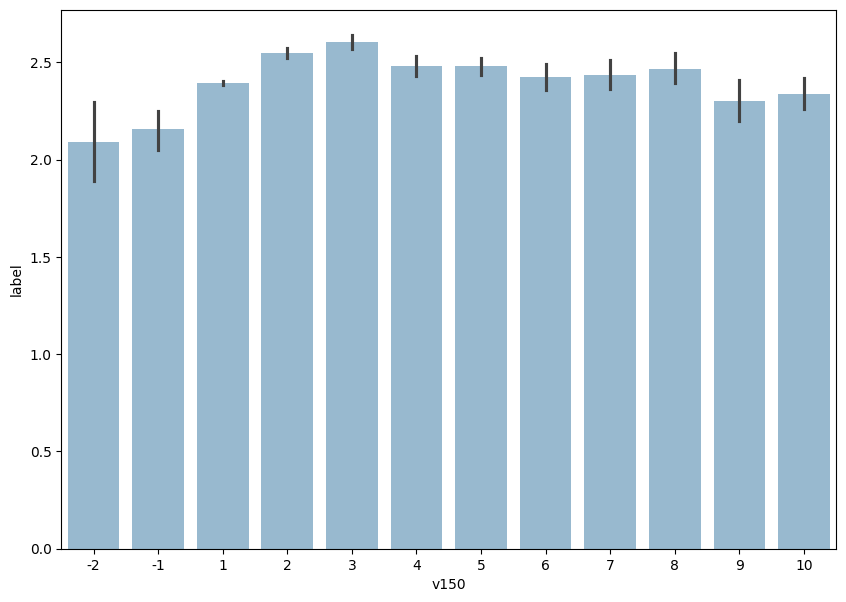

--------------------------------------------------
col: v151


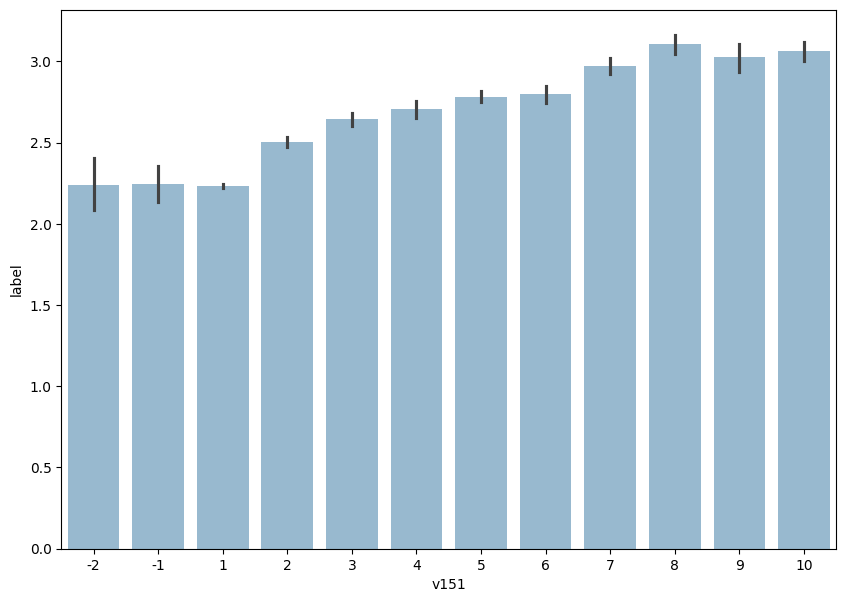

--------------------------------------------------
col: v152


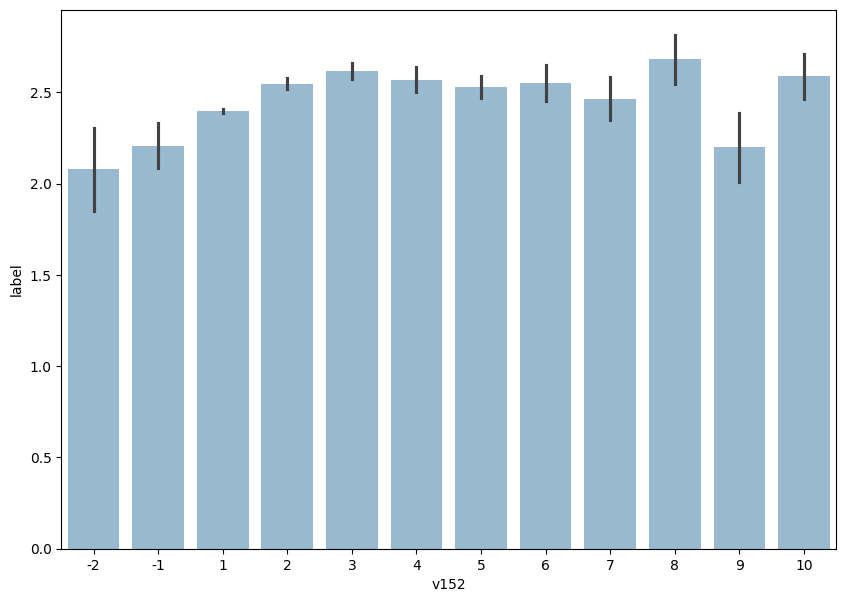

--------------------------------------------------
col: v153


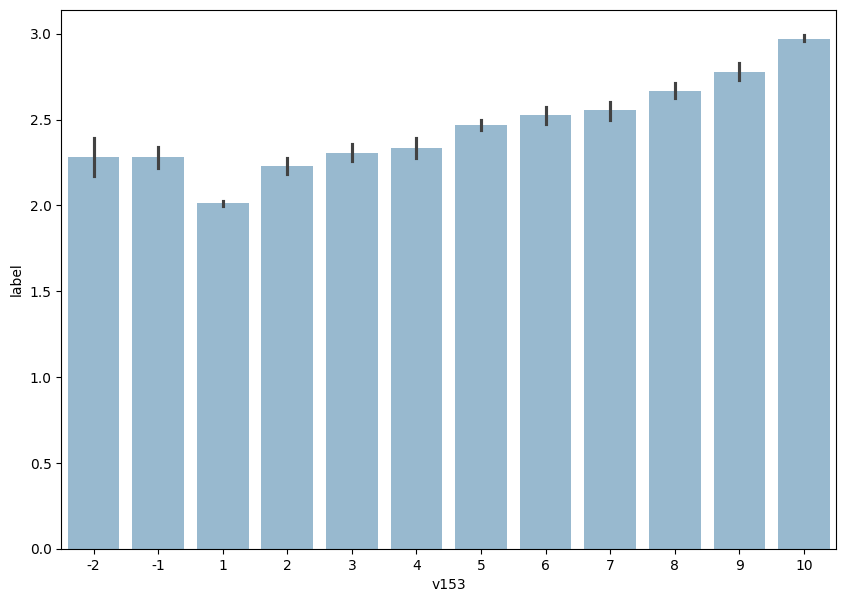

--------------------------------------------------
col: v154


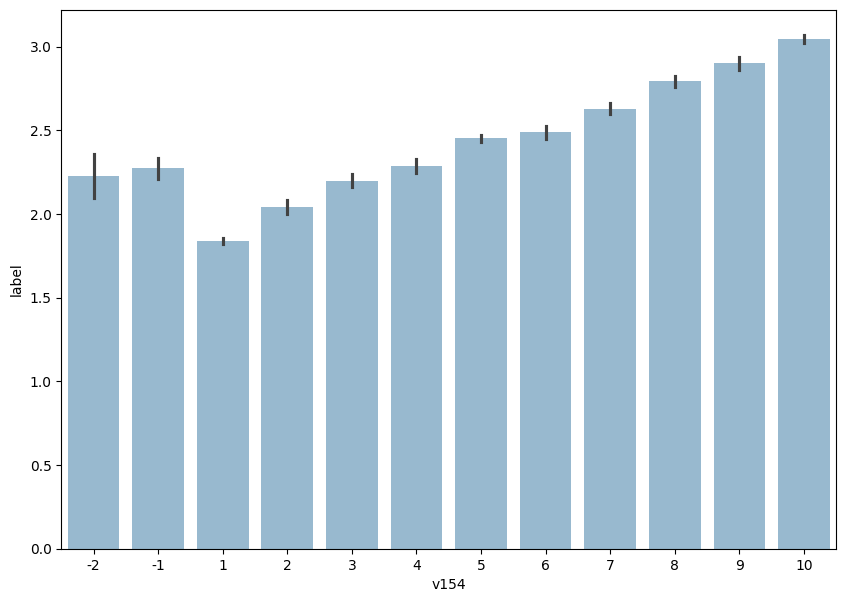

--------------------------------------------------
col: v155


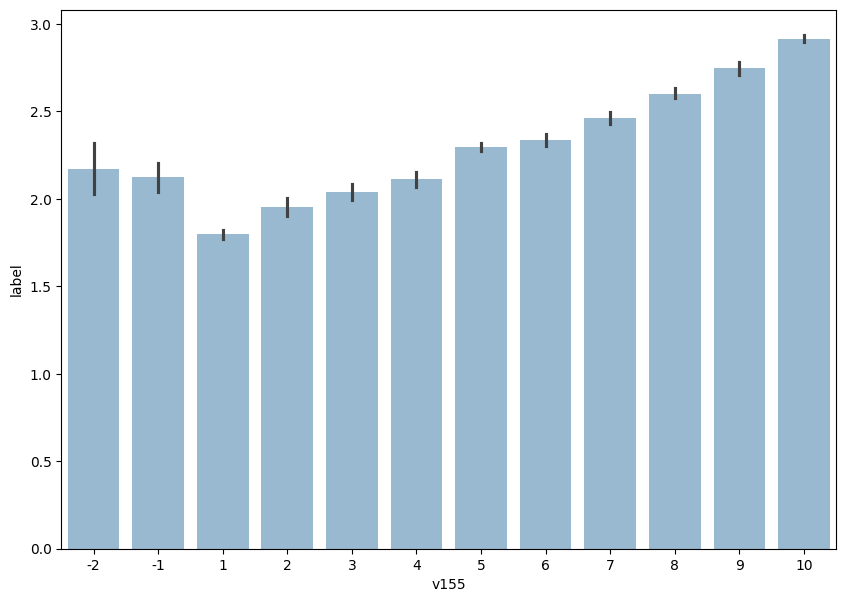

--------------------------------------------------
col: v156


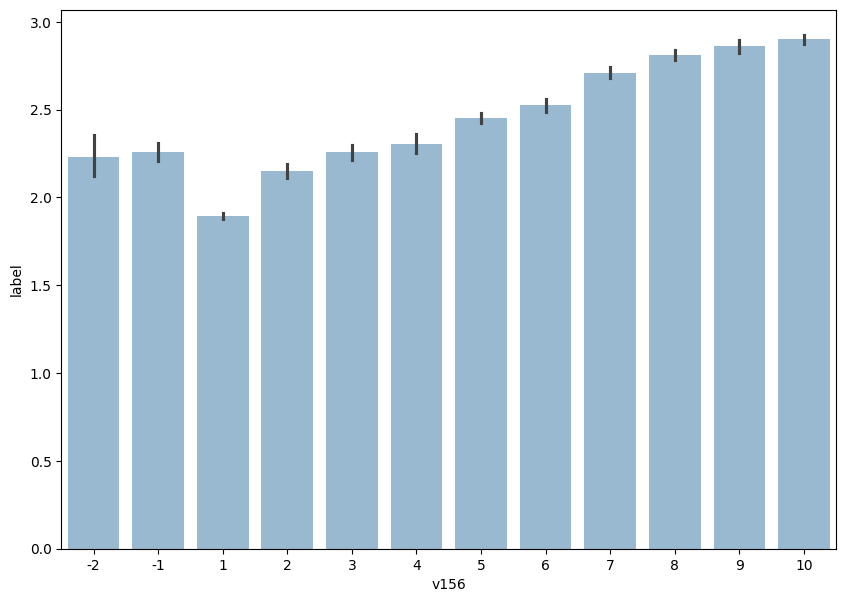

--------------------------------------------------
col: v157


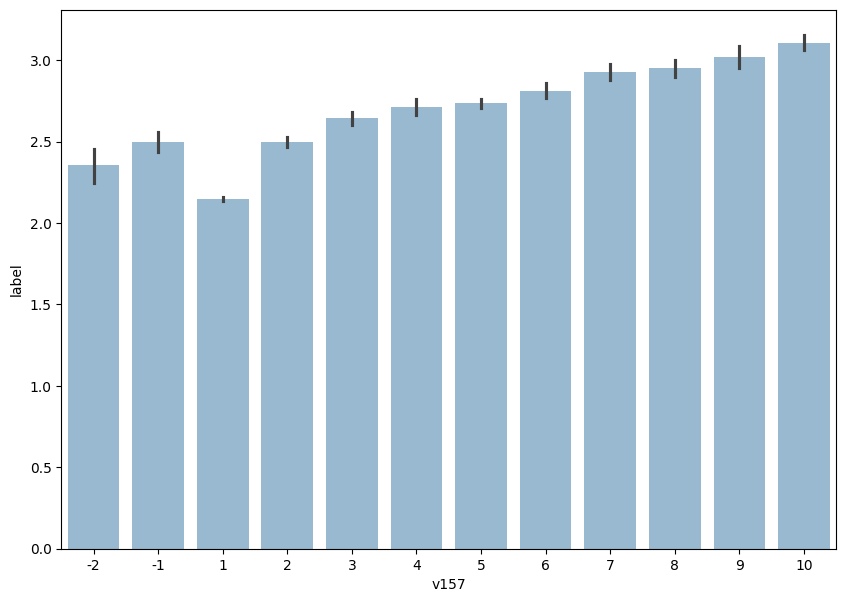

--------------------------------------------------
col: v158


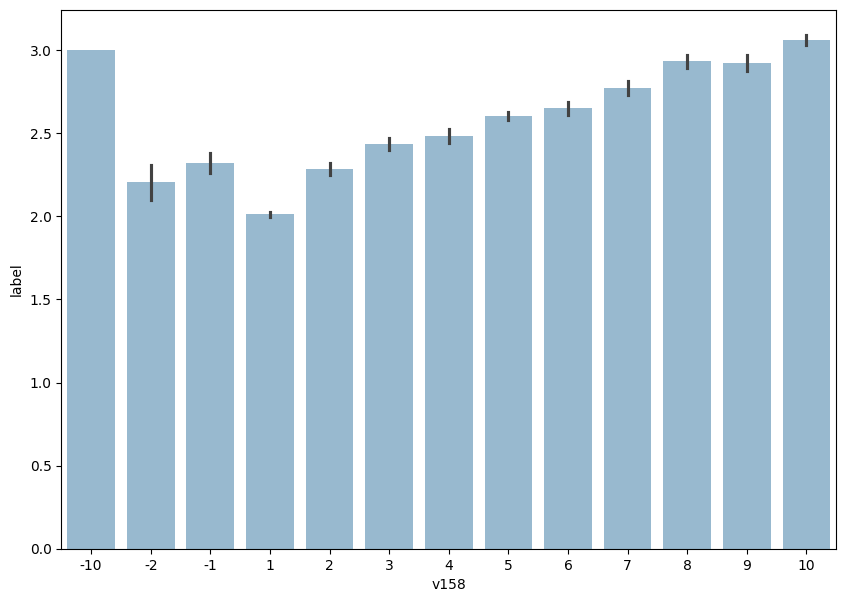

--------------------------------------------------
col: v159


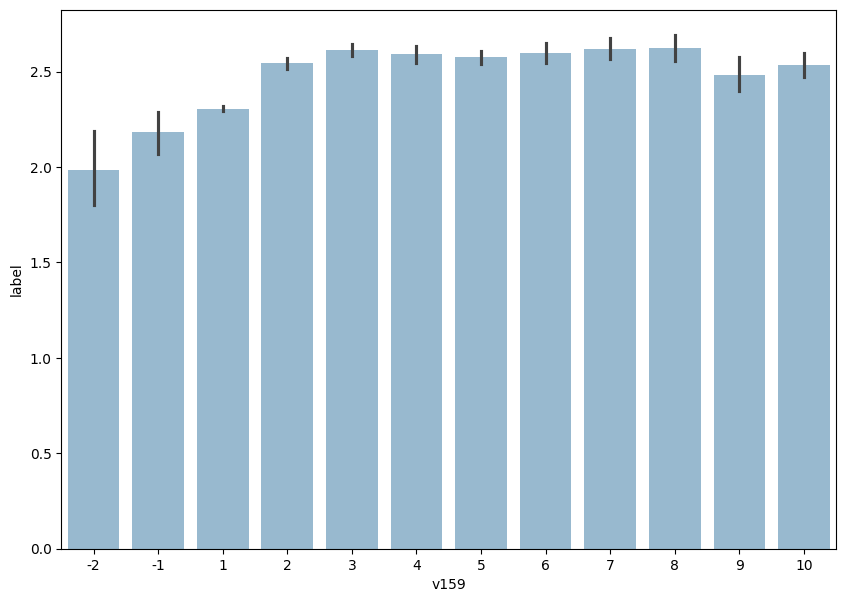

--------------------------------------------------
col: v160


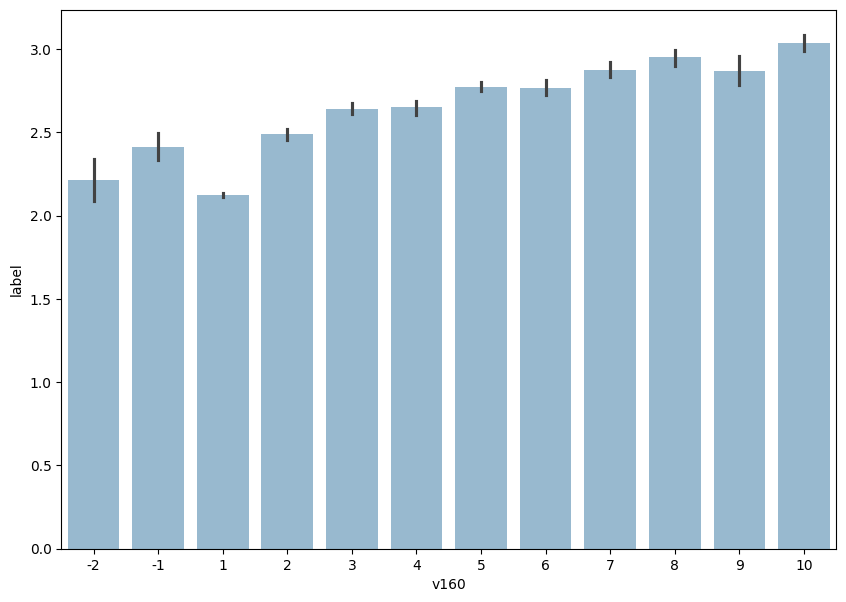

--------------------------------------------------
col: v161


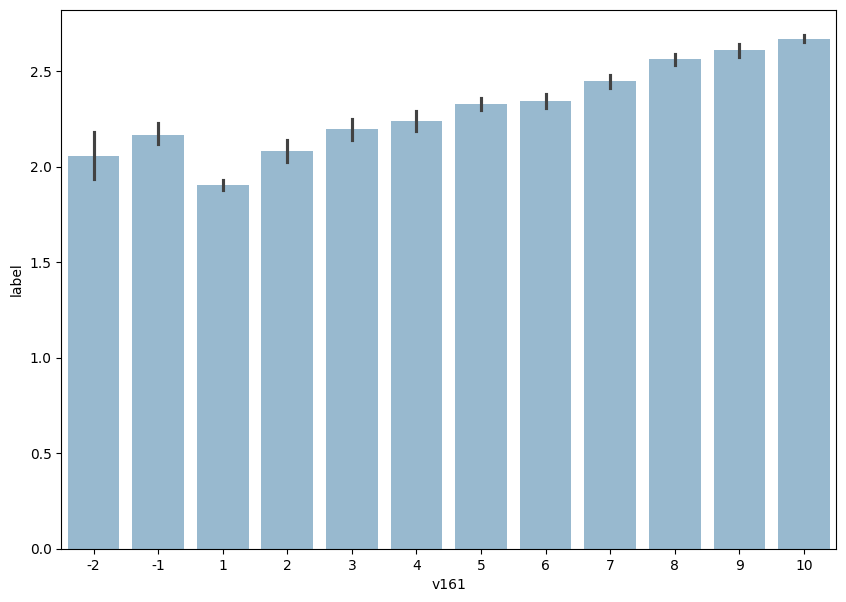

--------------------------------------------------
col: v162


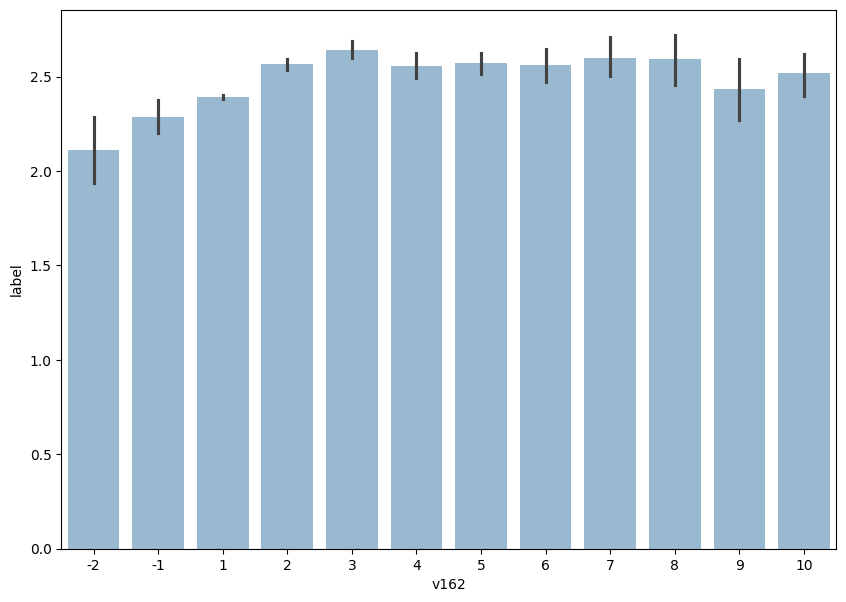

--------------------------------------------------
col: v163


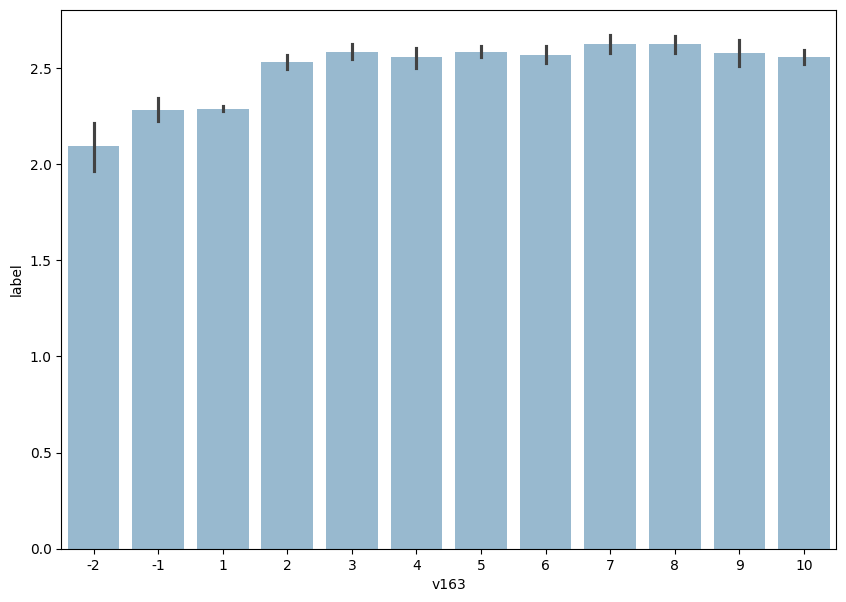

--------------------------------------------------
col: v164


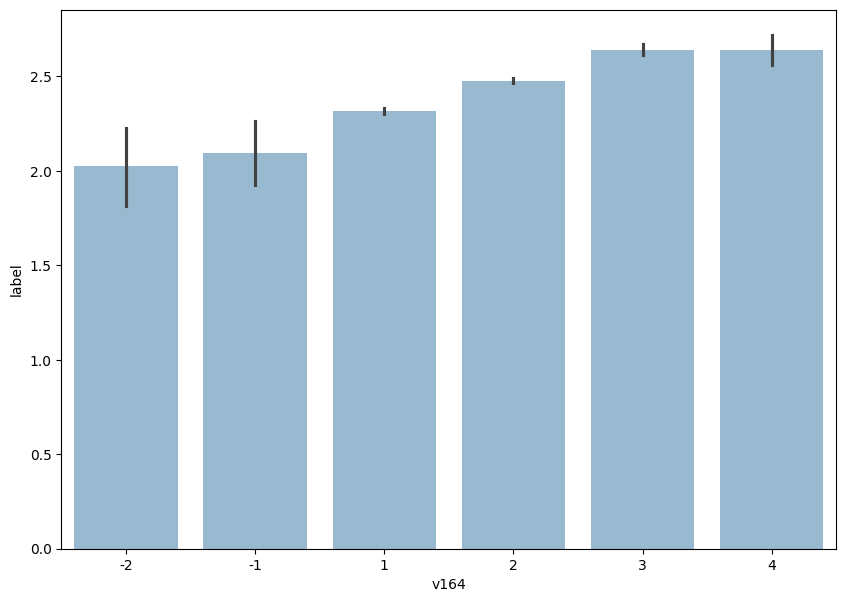

--------------------------------------------------
col: v165


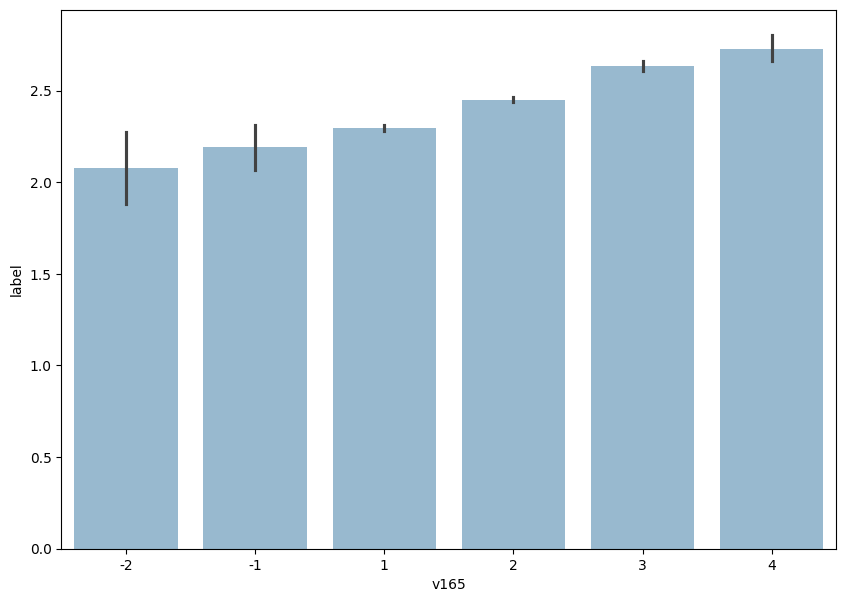

--------------------------------------------------
col: v166


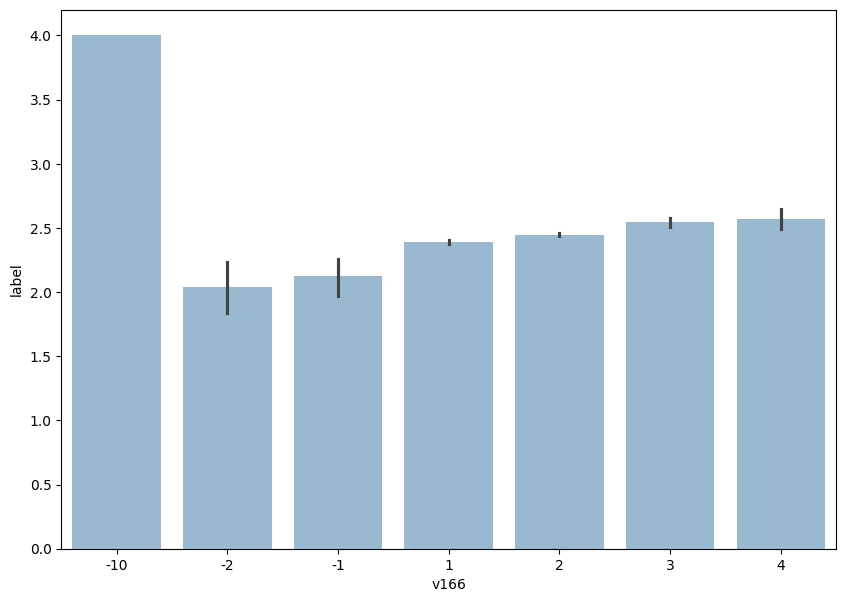

--------------------------------------------------
col: v167


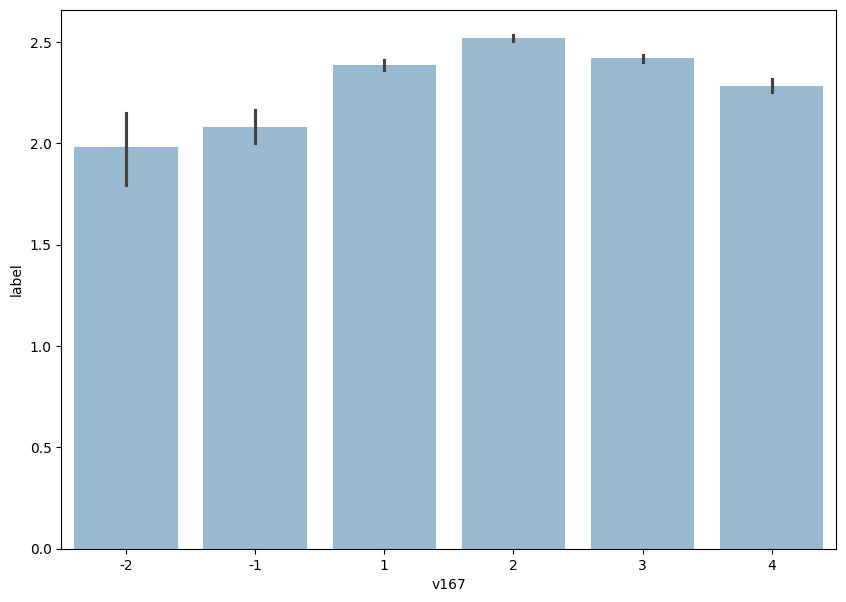

--------------------------------------------------
col: v168


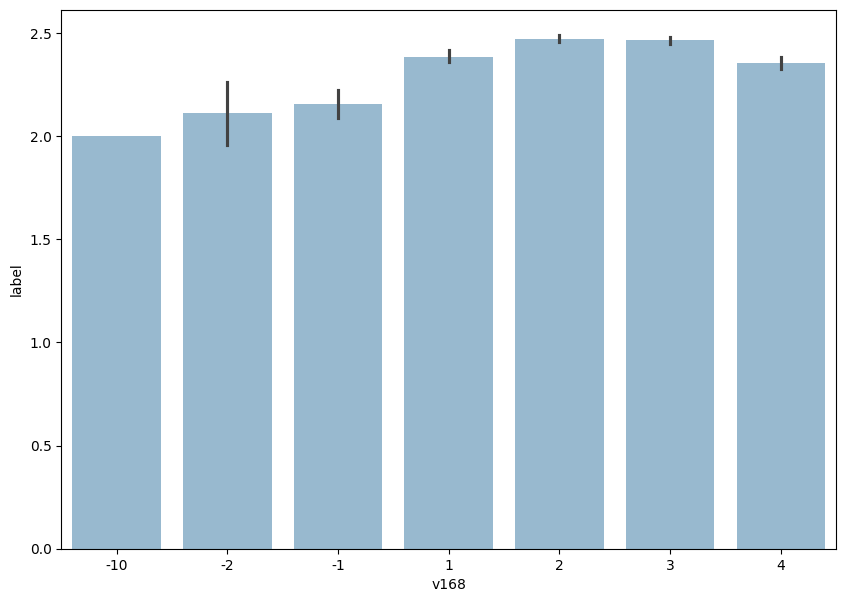

--------------------------------------------------
col: v169


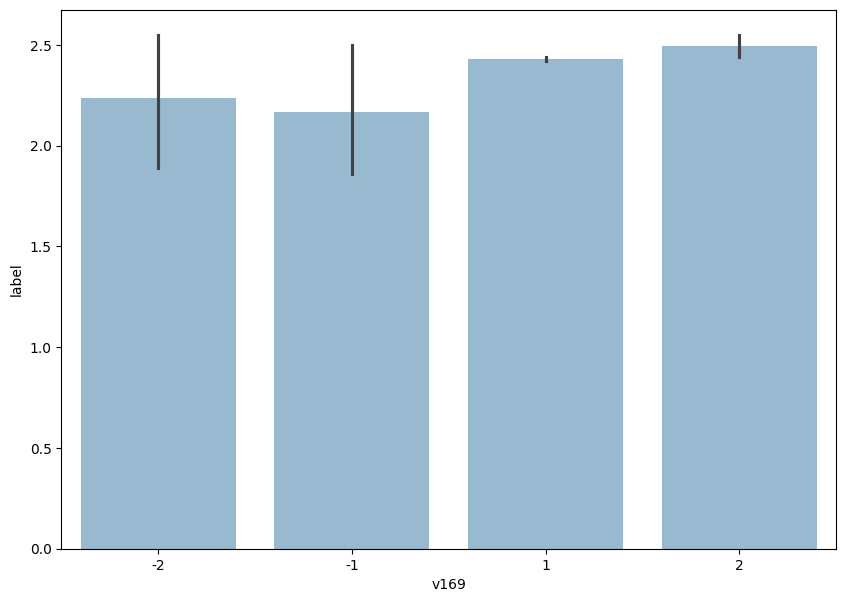

--------------------------------------------------
col: v170


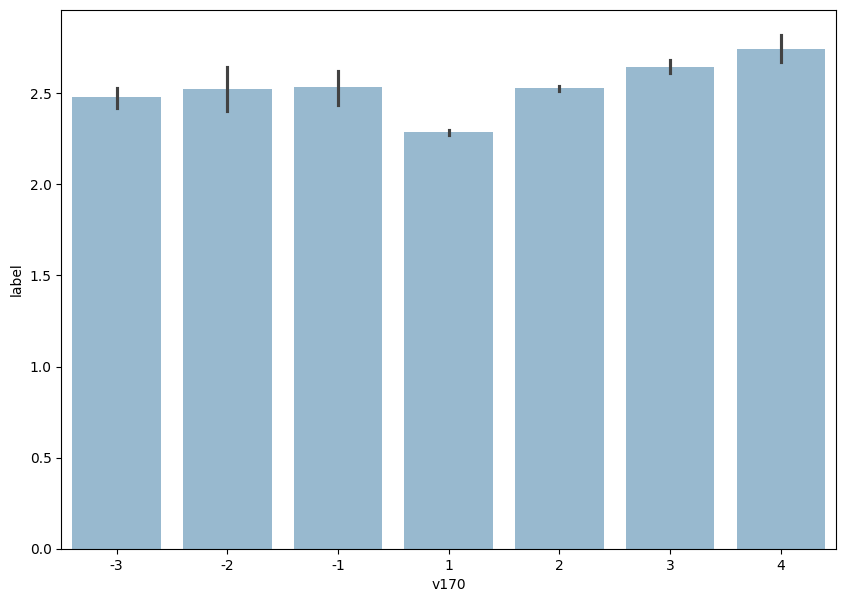

--------------------------------------------------
col: v171


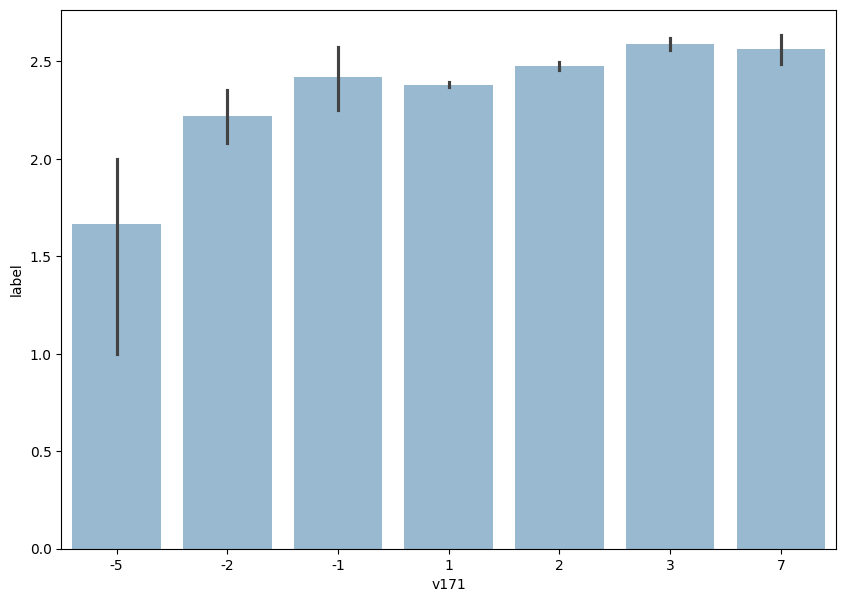

--------------------------------------------------
col: v172


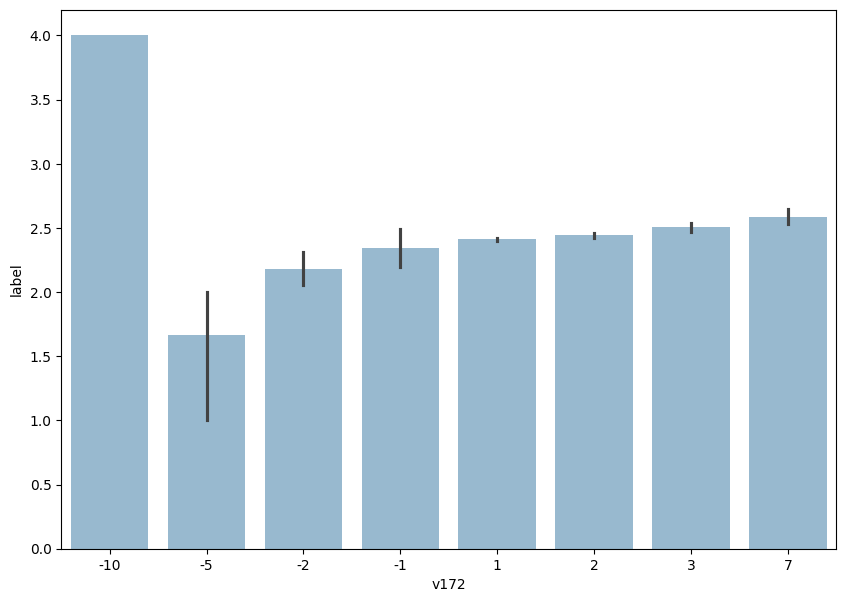

--------------------------------------------------
col: v173


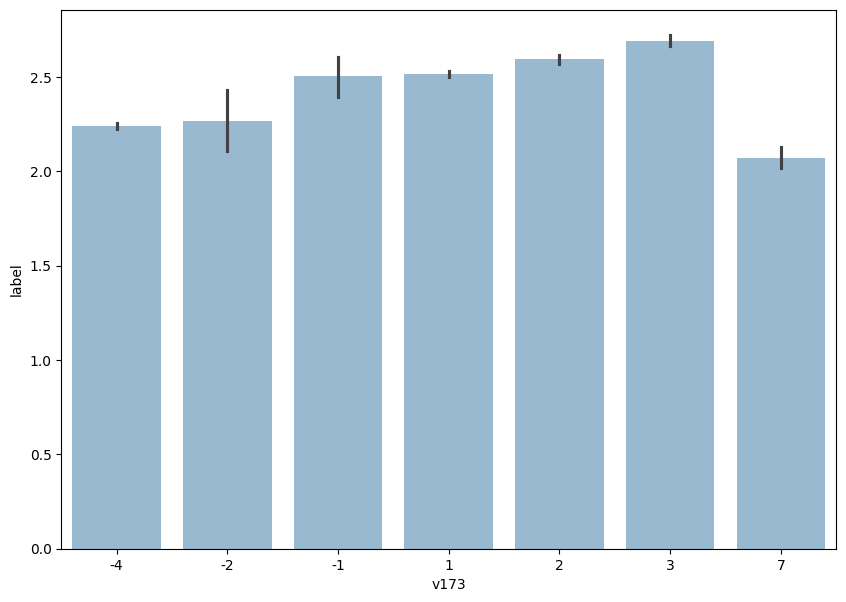

--------------------------------------------------
col: v174_LR


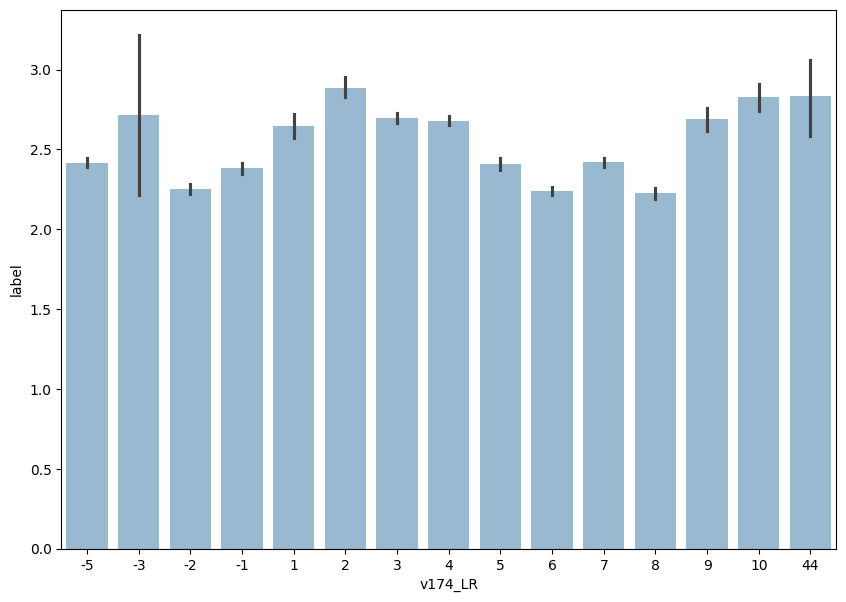

--------------------------------------------------
col: v174_cs


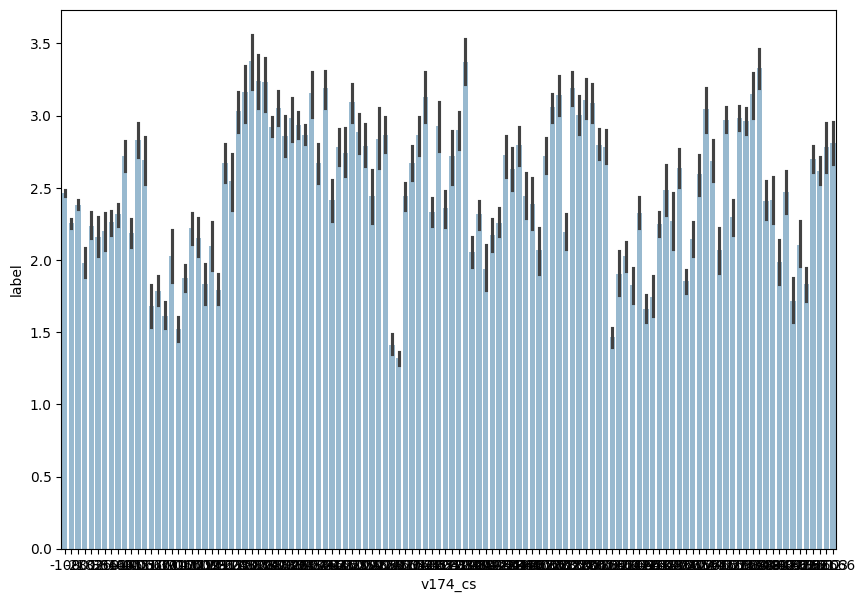

--------------------------------------------------
col: v175_LR


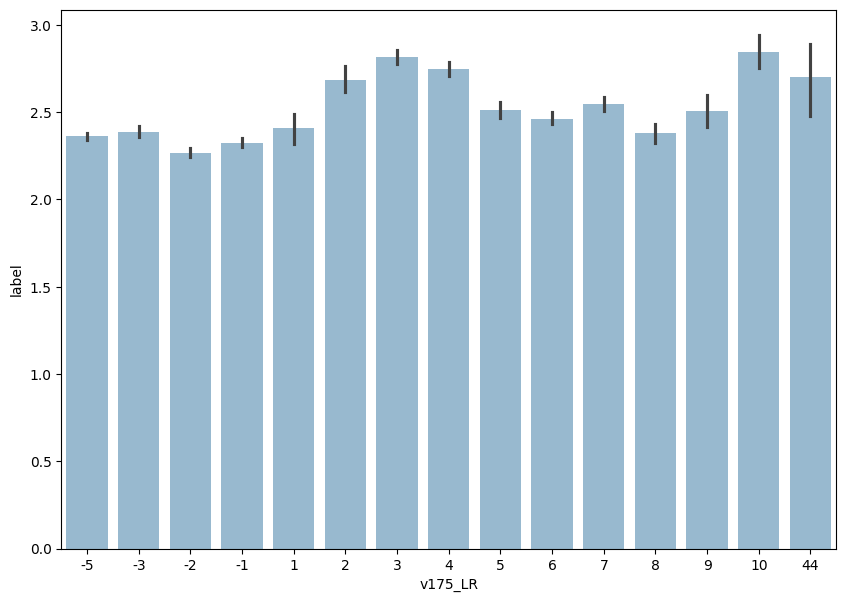

--------------------------------------------------
col: v175_cs


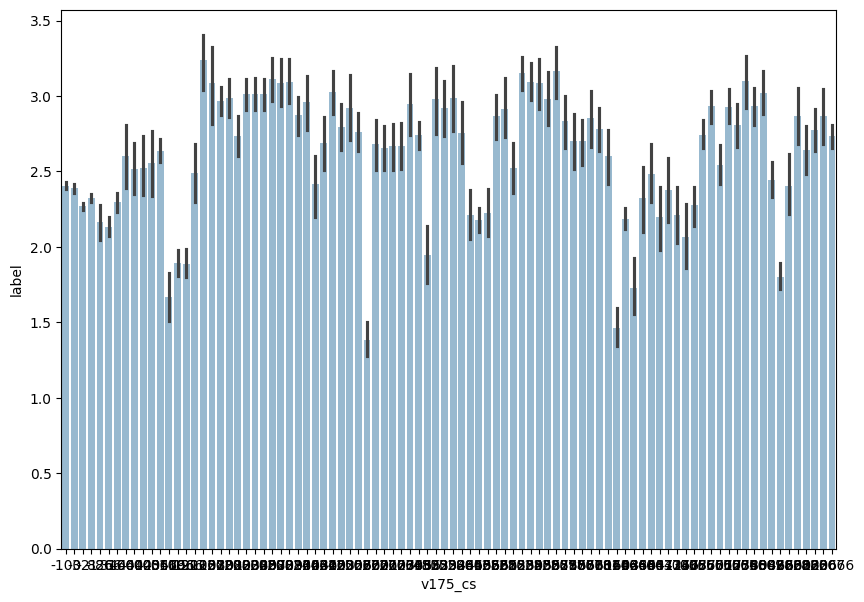

--------------------------------------------------
col: v176


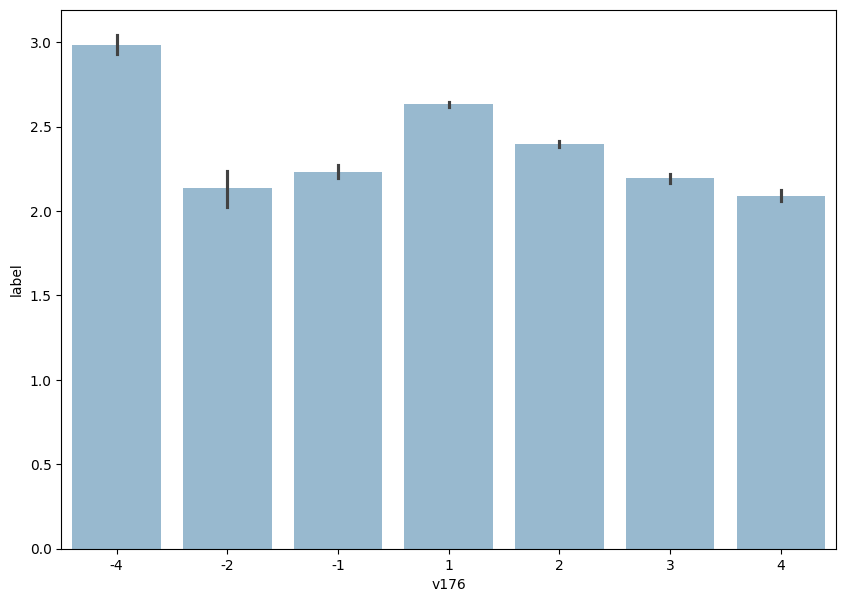

--------------------------------------------------
col: v177


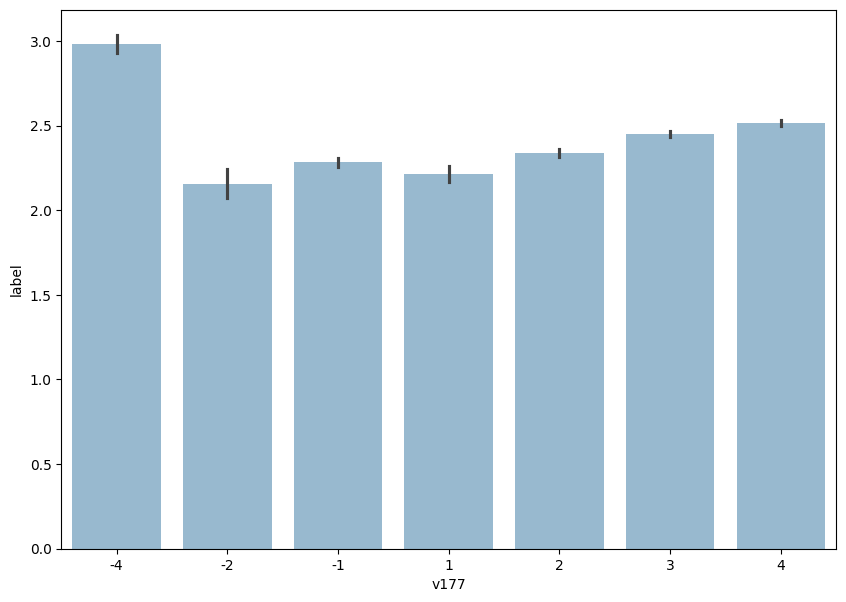

--------------------------------------------------
col: v178


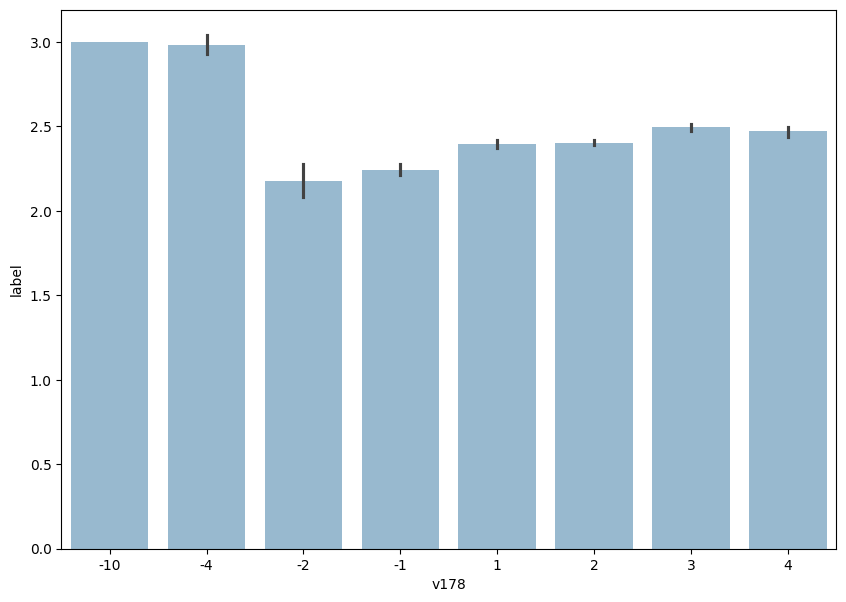

--------------------------------------------------
col: v178_DK


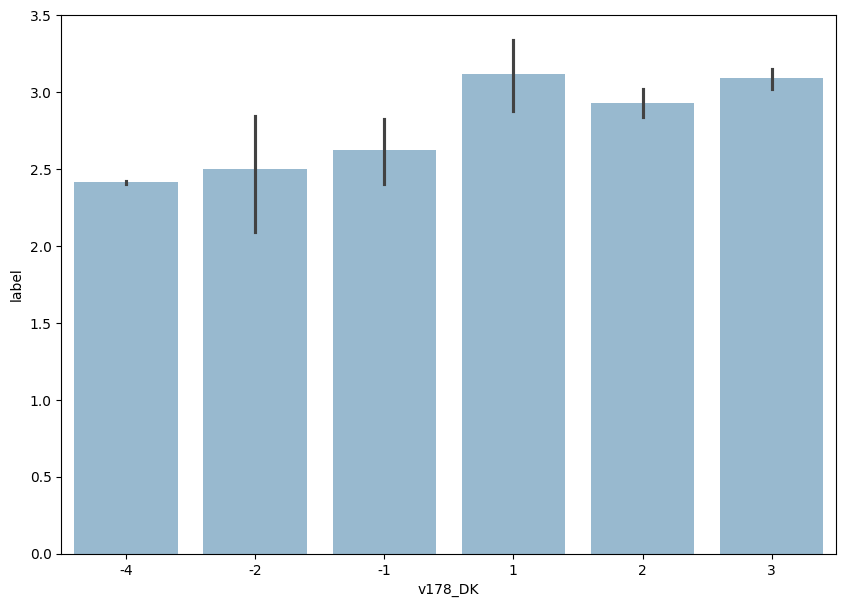

--------------------------------------------------
col: v179


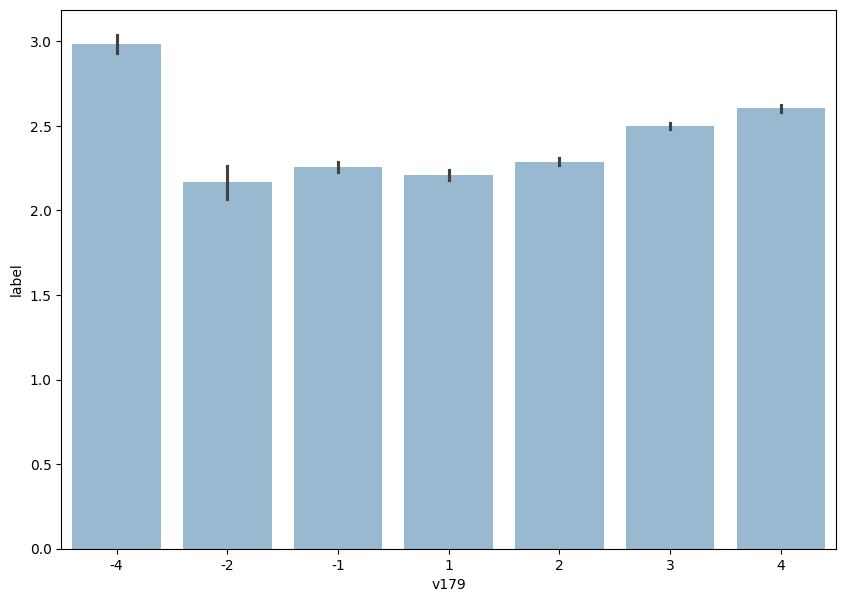

--------------------------------------------------
col: v180


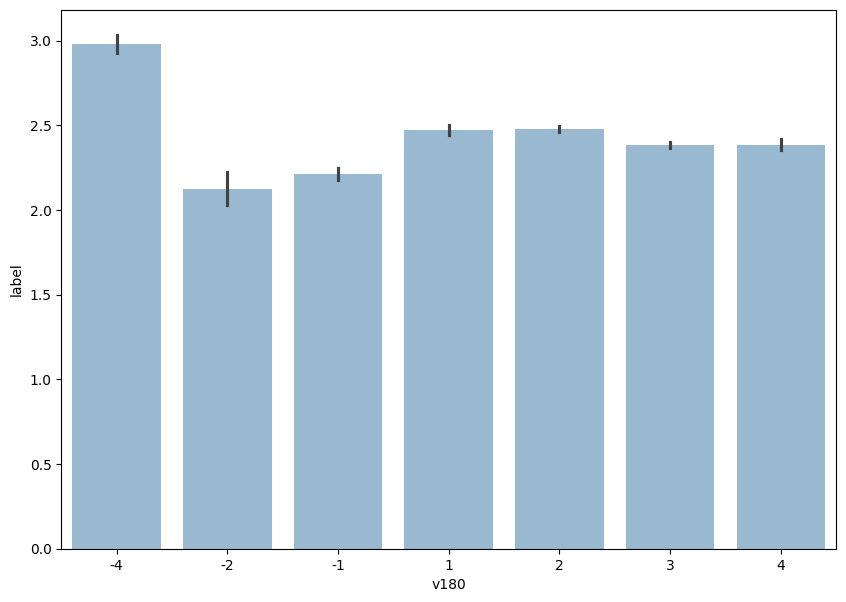

--------------------------------------------------
col: v181


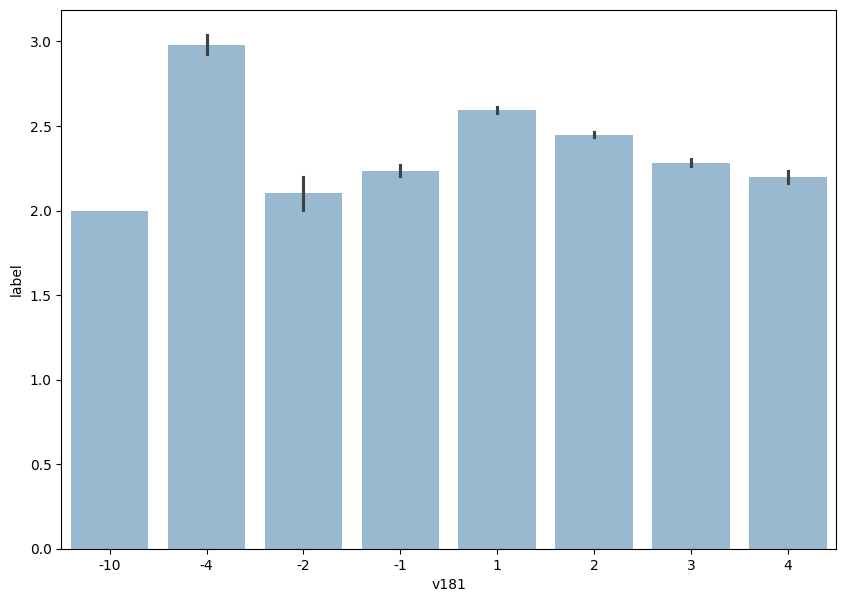

--------------------------------------------------
col: v182


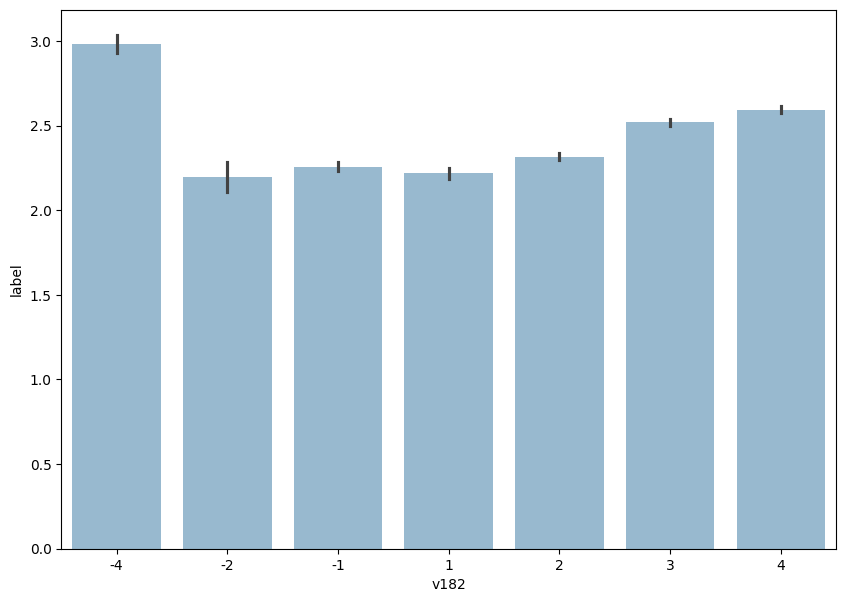

--------------------------------------------------
col: v183


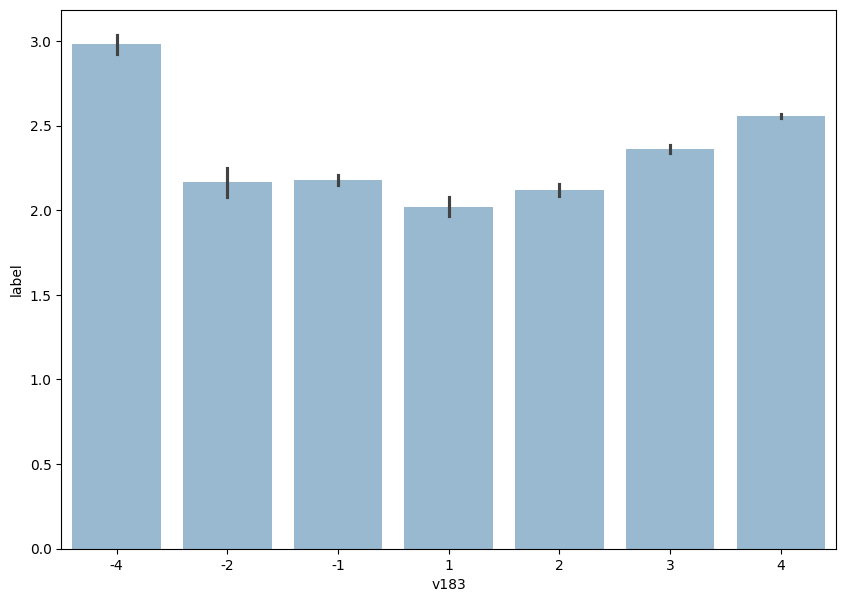

--------------------------------------------------
col: v184


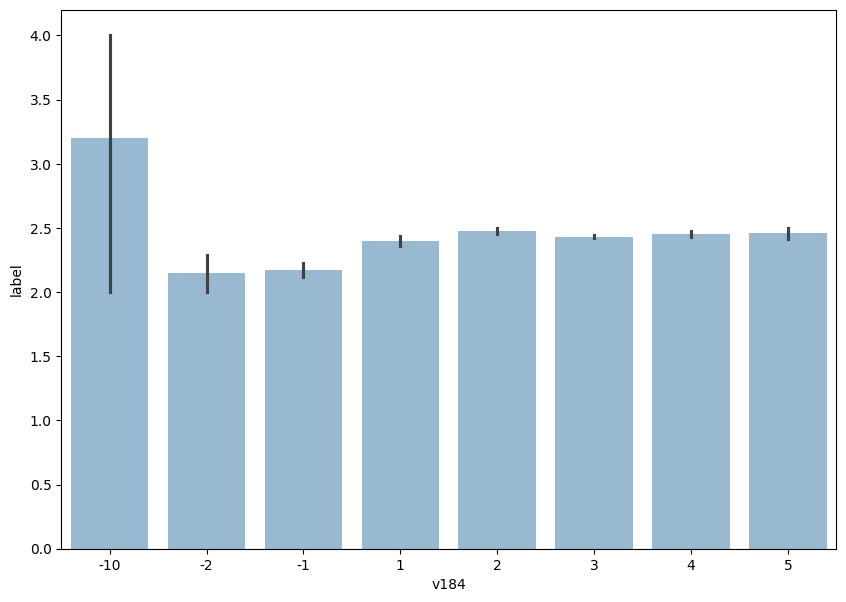

--------------------------------------------------
col: v185


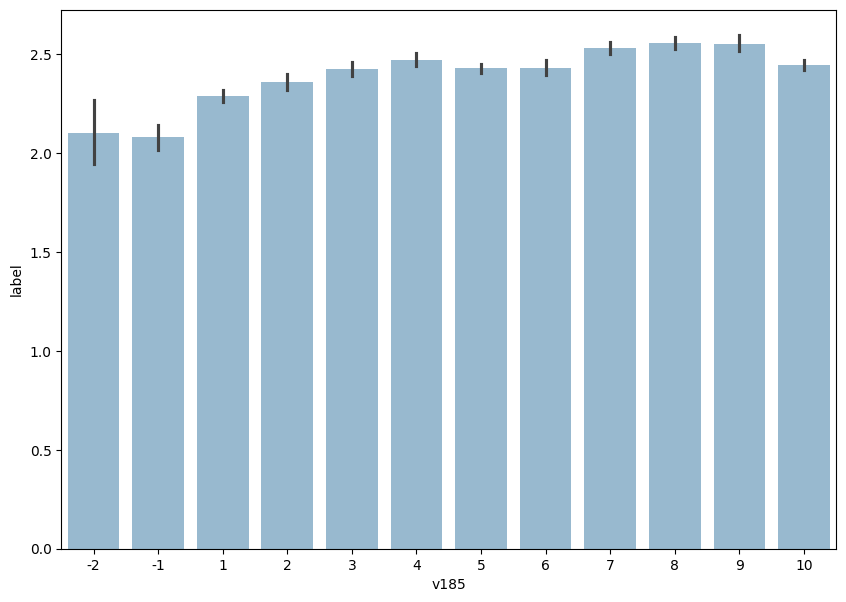

--------------------------------------------------
col: v186


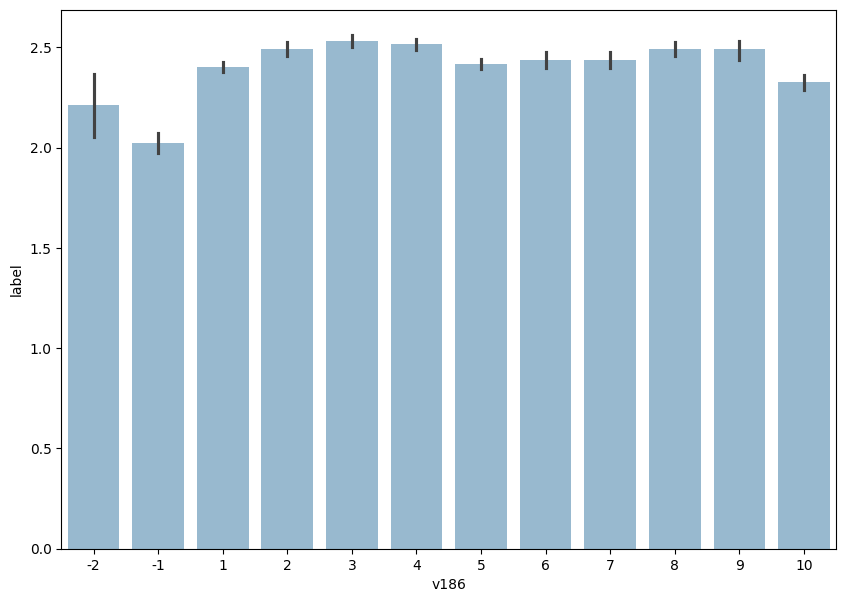

--------------------------------------------------
col: v187


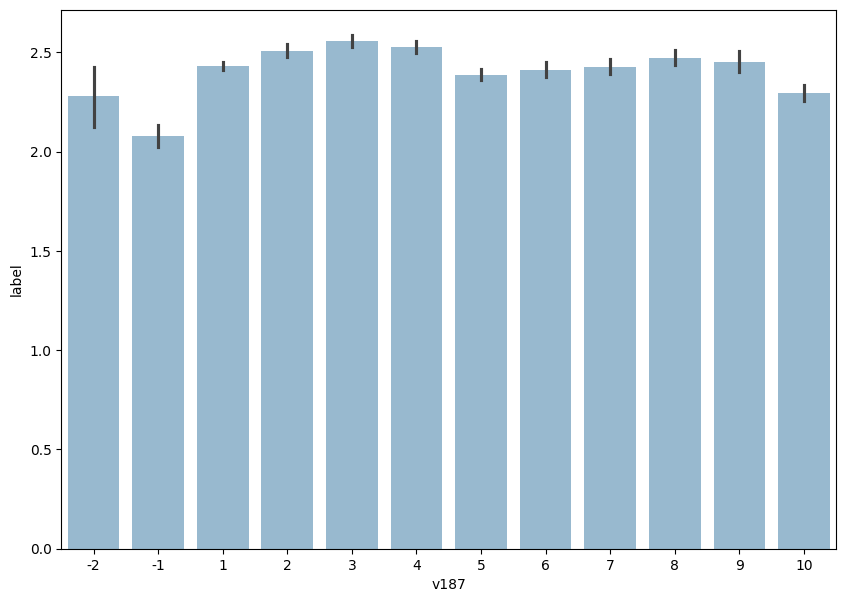

--------------------------------------------------
col: v188


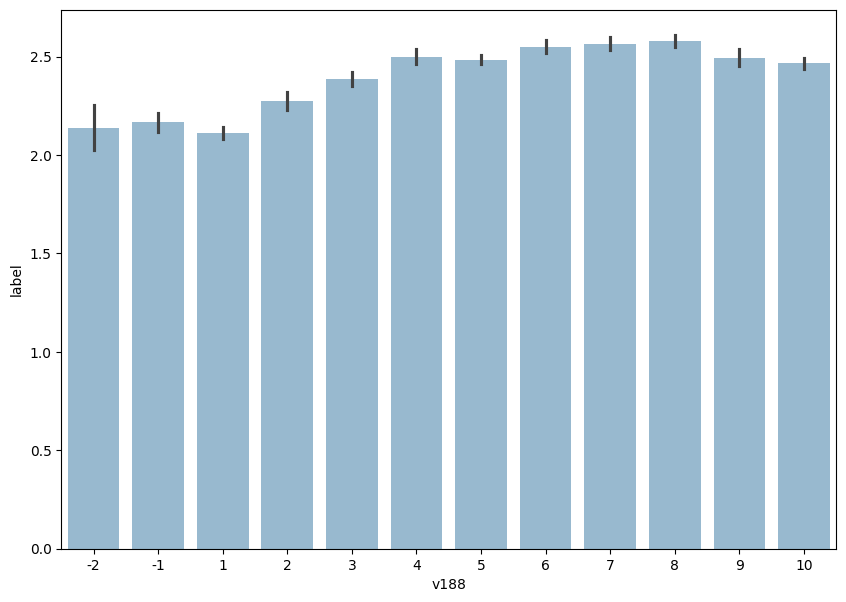

--------------------------------------------------
col: v189


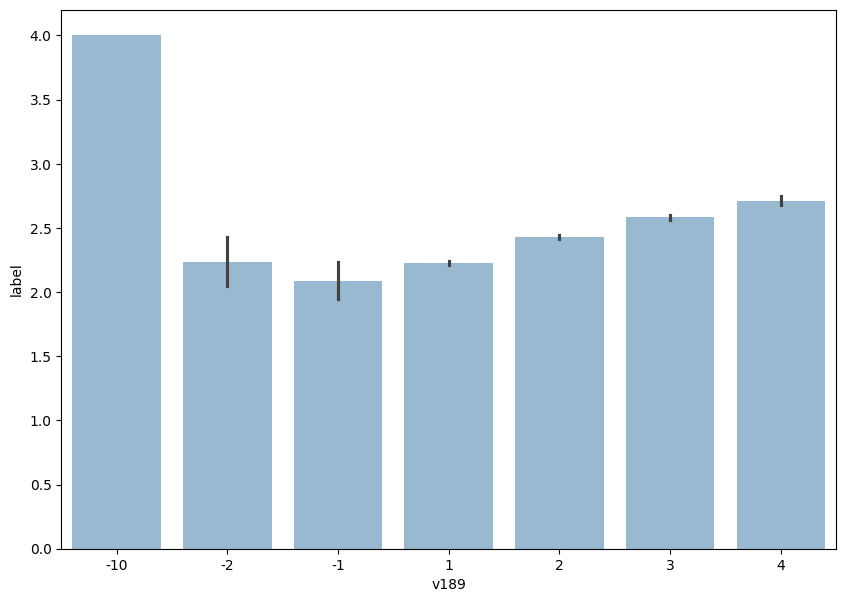

--------------------------------------------------
col: v190


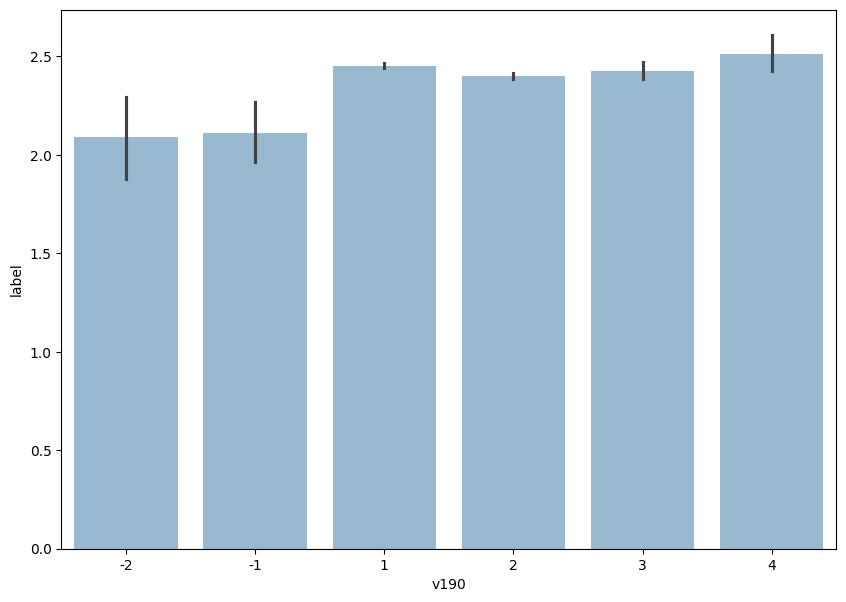

--------------------------------------------------
col: v191


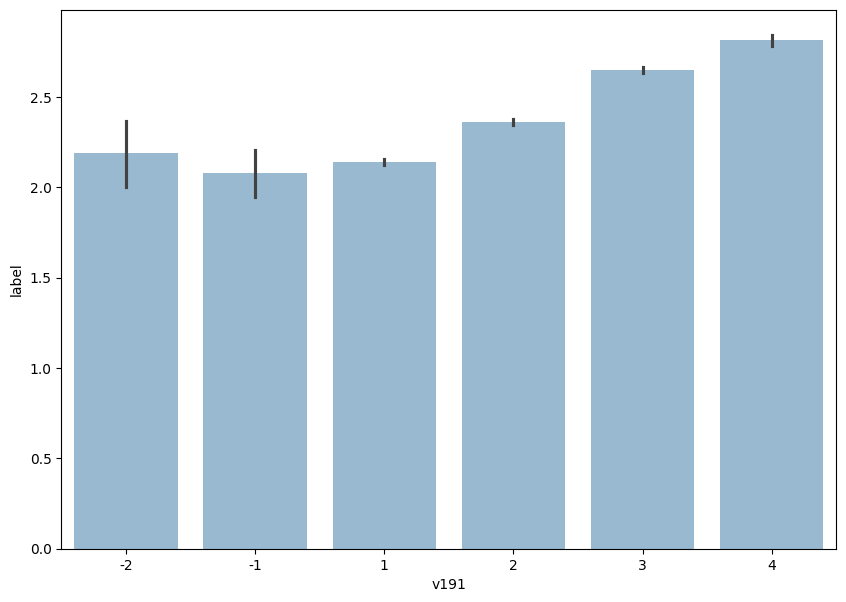

--------------------------------------------------
col: v192


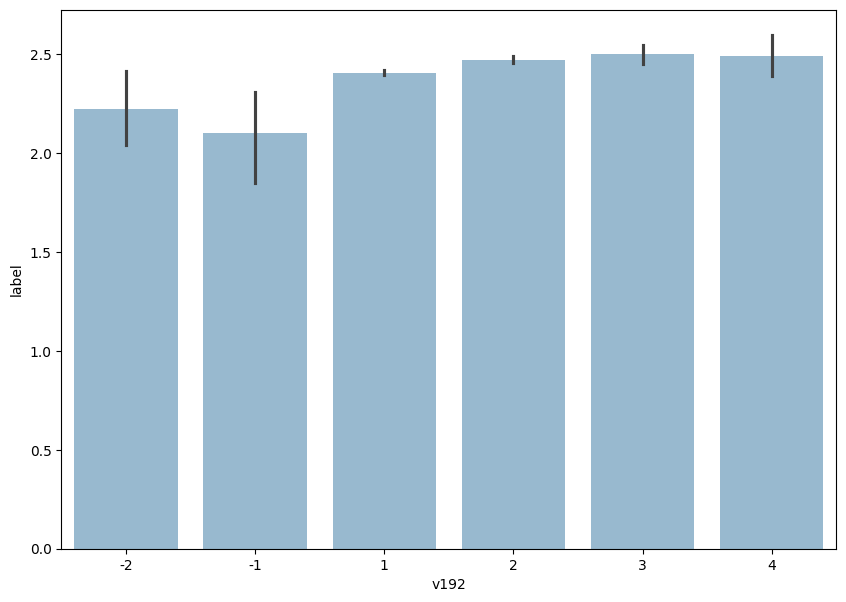

--------------------------------------------------
col: v193


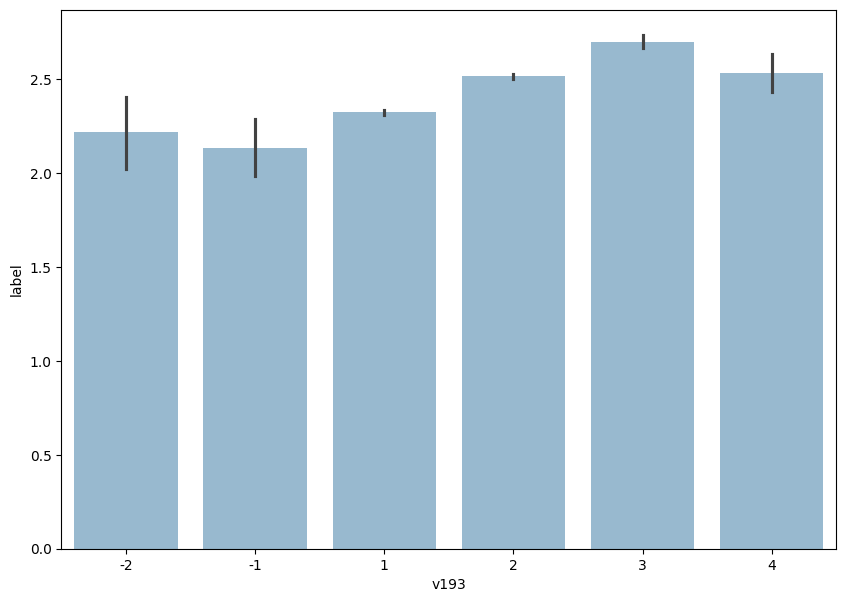

--------------------------------------------------
col: v194


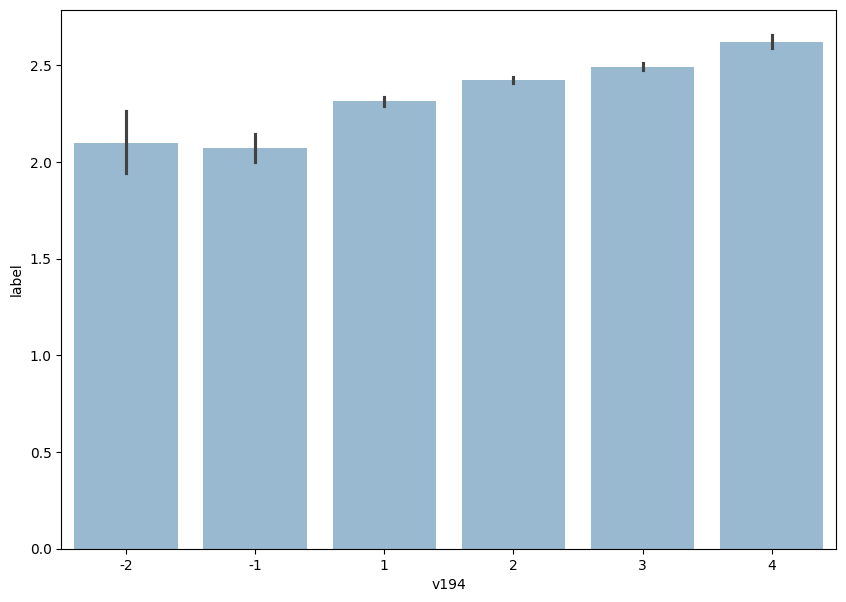

--------------------------------------------------
col: v195


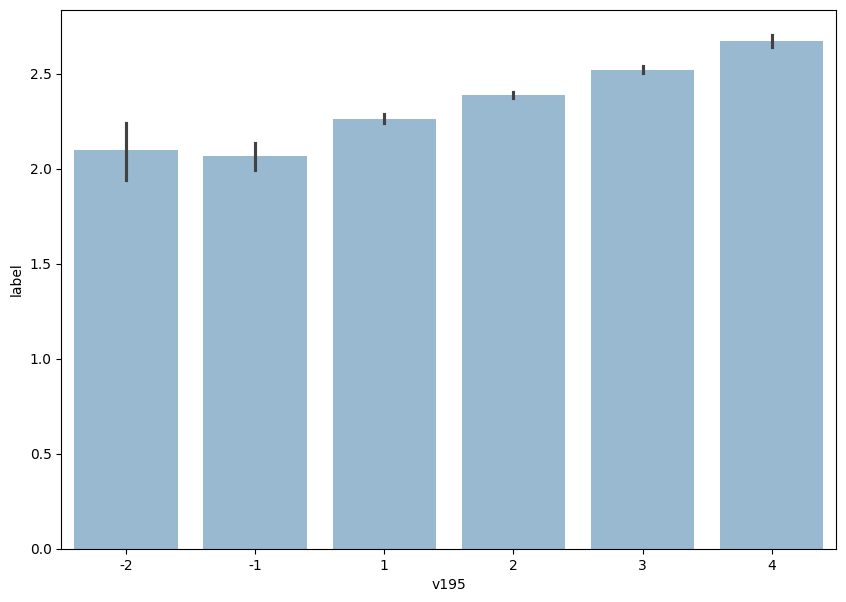

--------------------------------------------------
col: v196


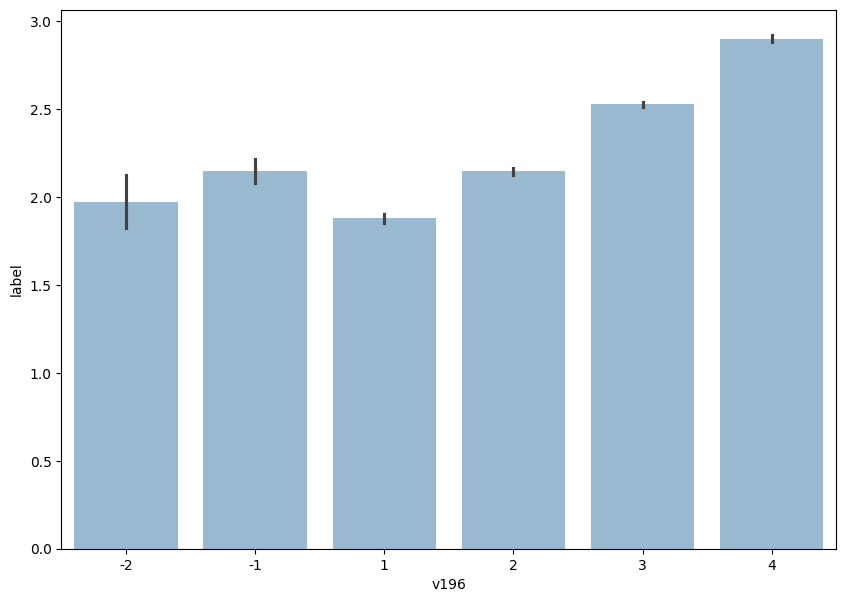

--------------------------------------------------
col: v197


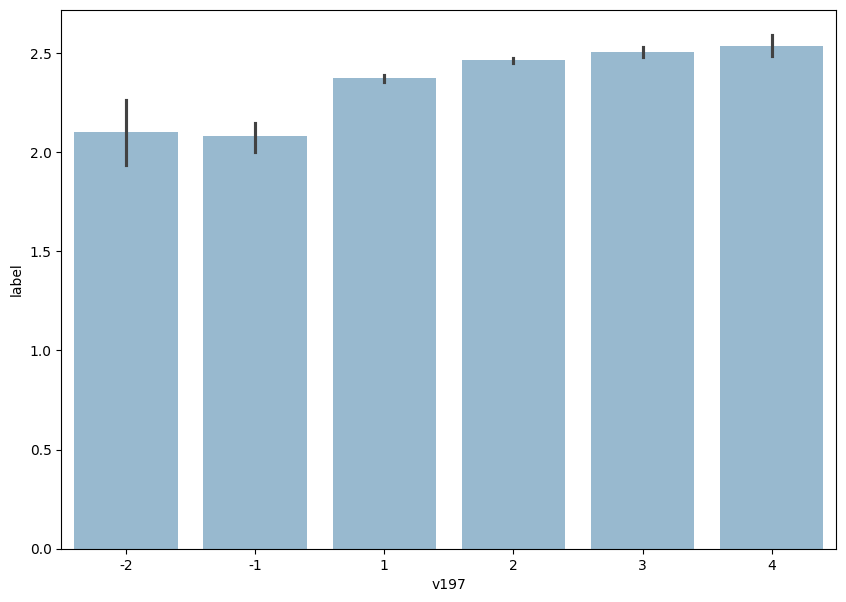

--------------------------------------------------
col: v198


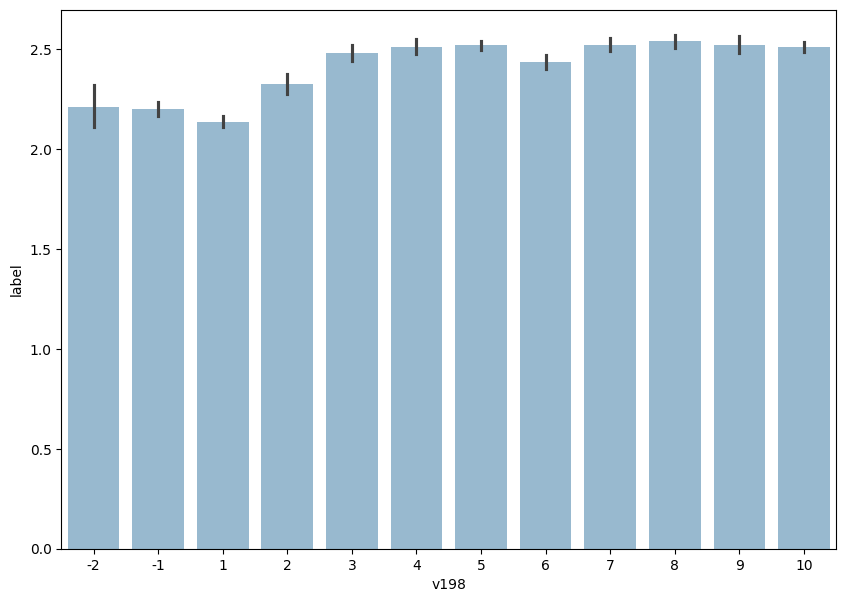

--------------------------------------------------
col: v199


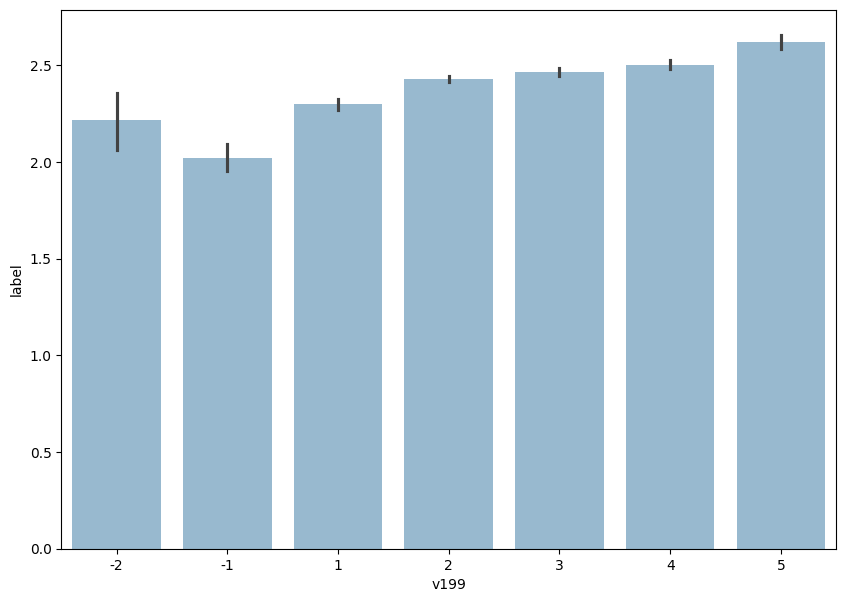

--------------------------------------------------
col: v200


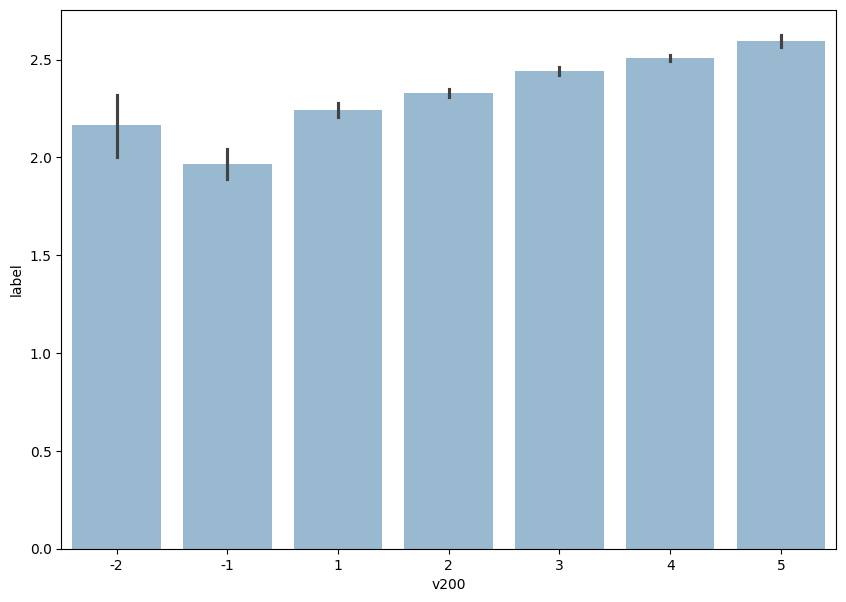

--------------------------------------------------
col: v201


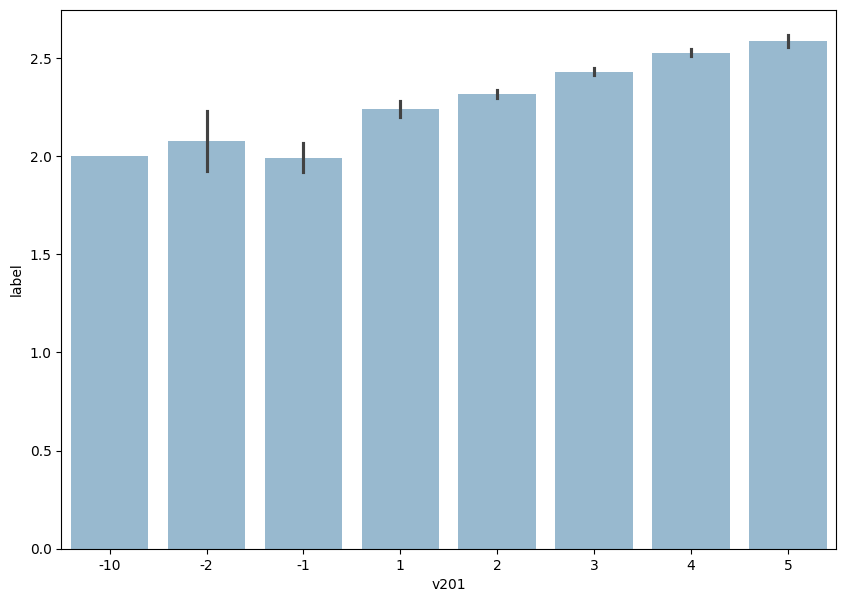

--------------------------------------------------
col: v202


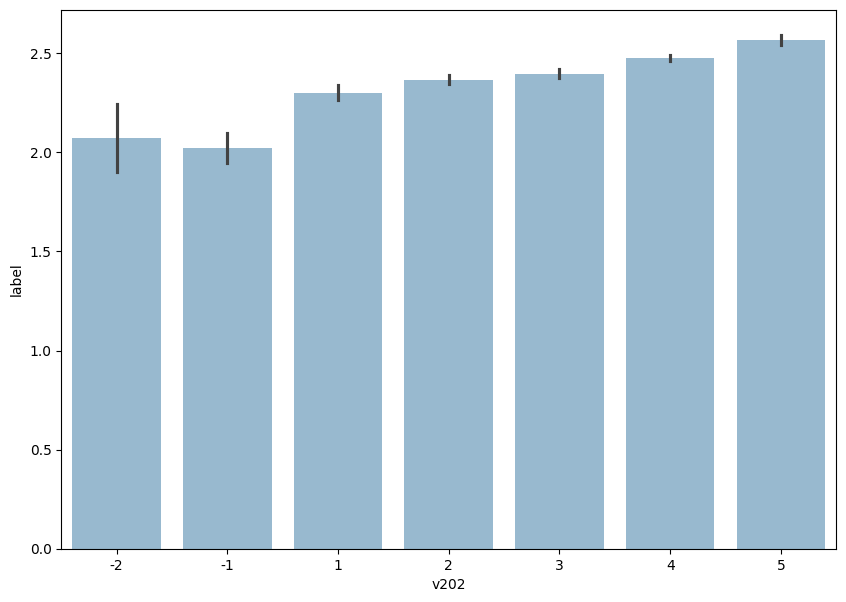

--------------------------------------------------
col: v203


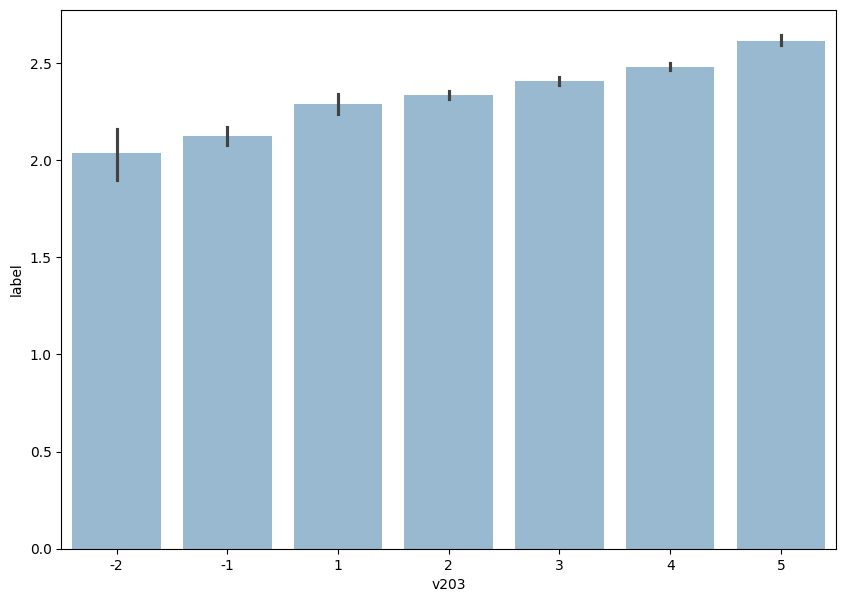

--------------------------------------------------
col: v204


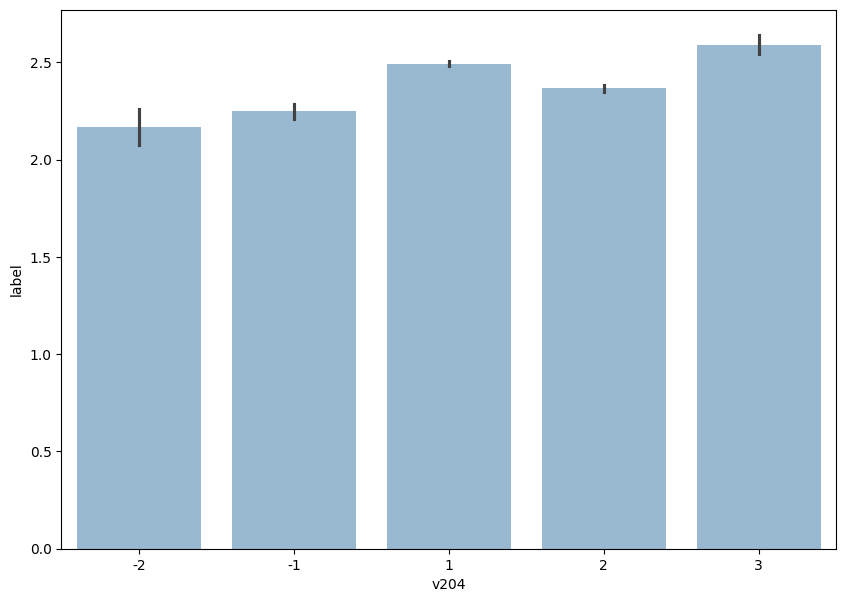

--------------------------------------------------
col: v205


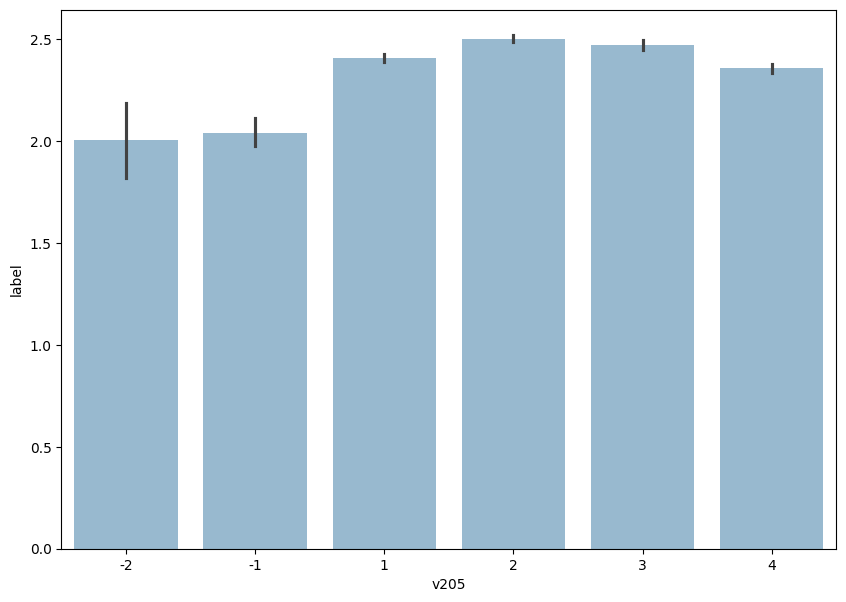

--------------------------------------------------
col: v206


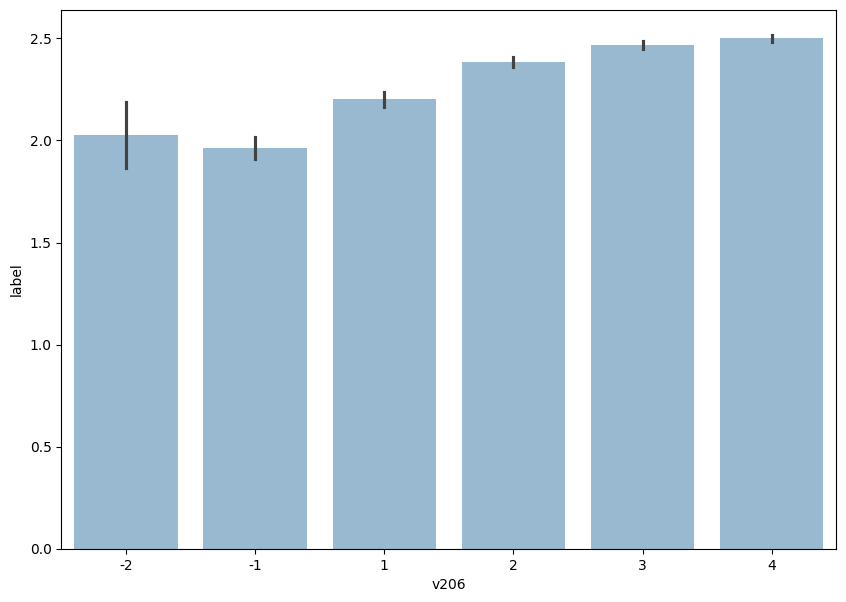

--------------------------------------------------
col: v207


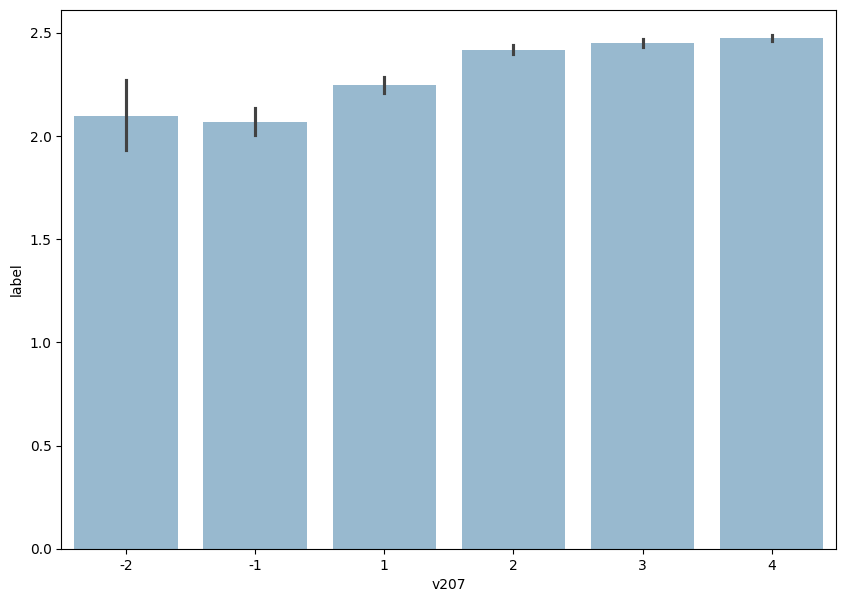

--------------------------------------------------
col: v208


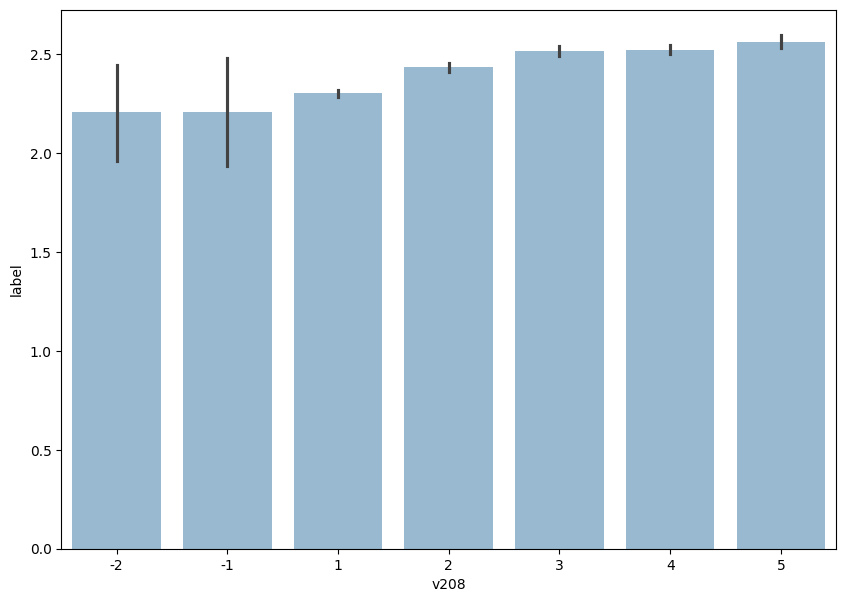

--------------------------------------------------
col: v209


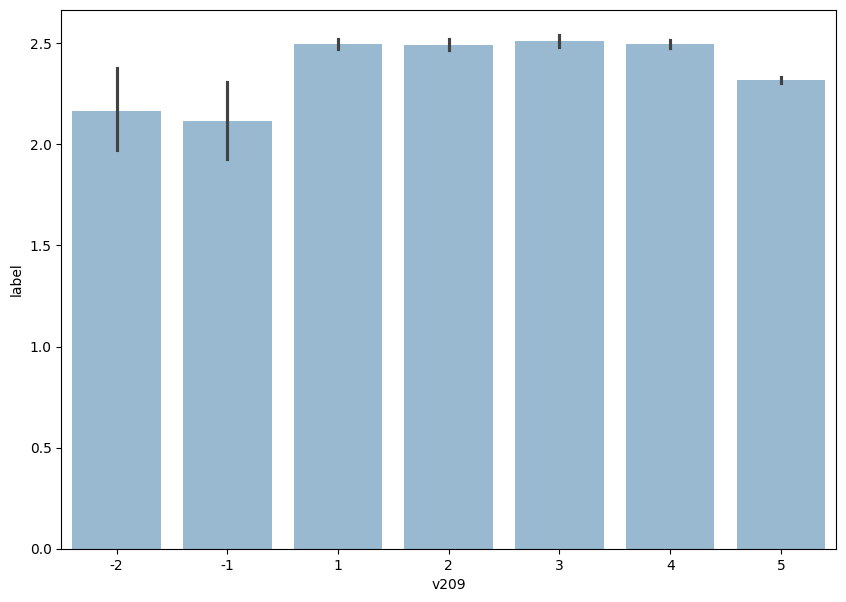

--------------------------------------------------
col: v210


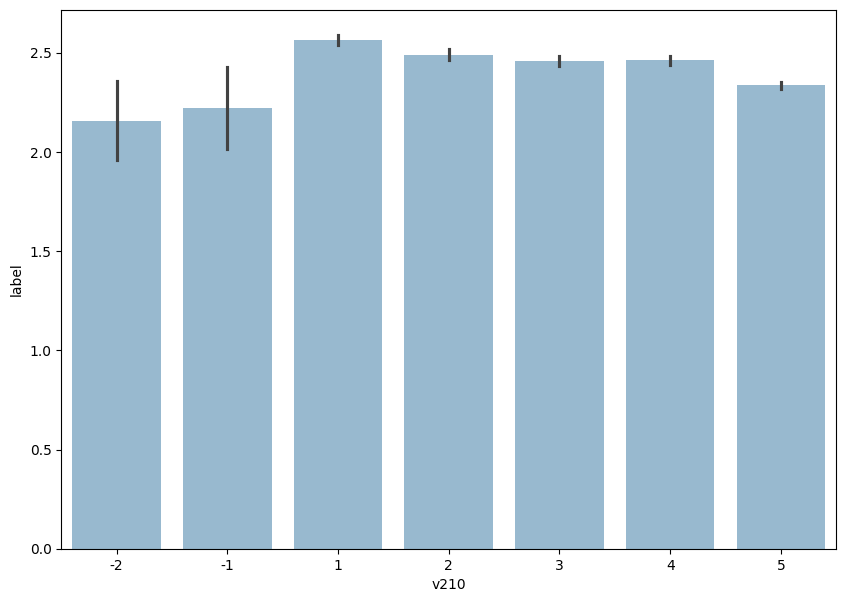

--------------------------------------------------
col: v211


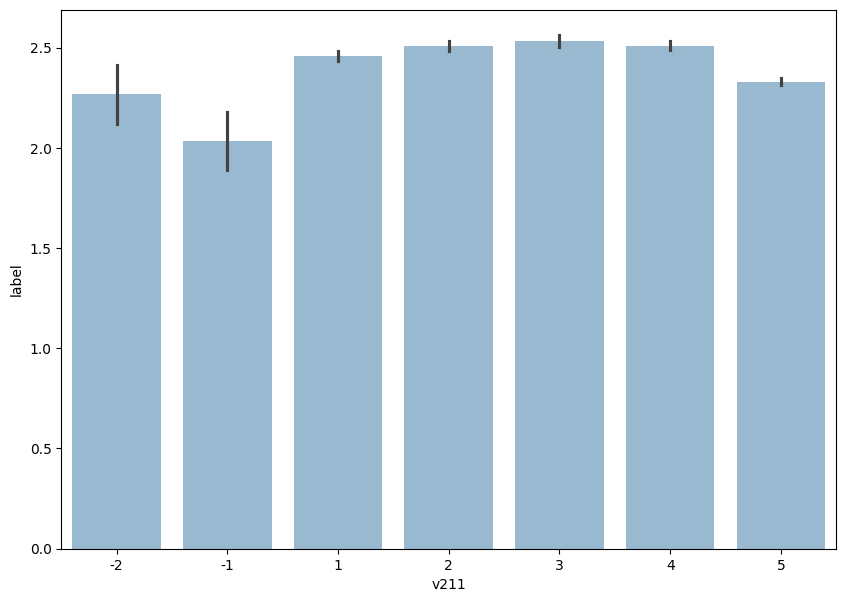

--------------------------------------------------
col: v212


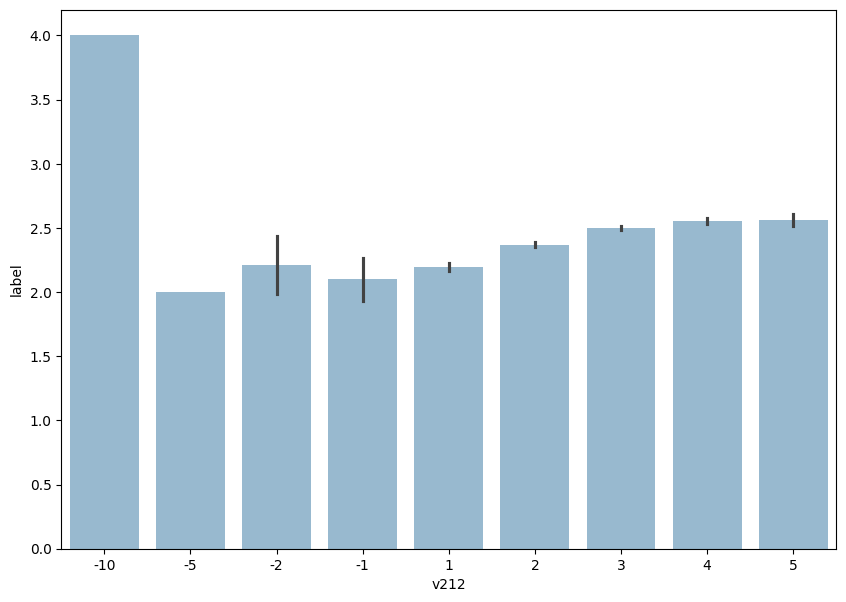

--------------------------------------------------
col: v213


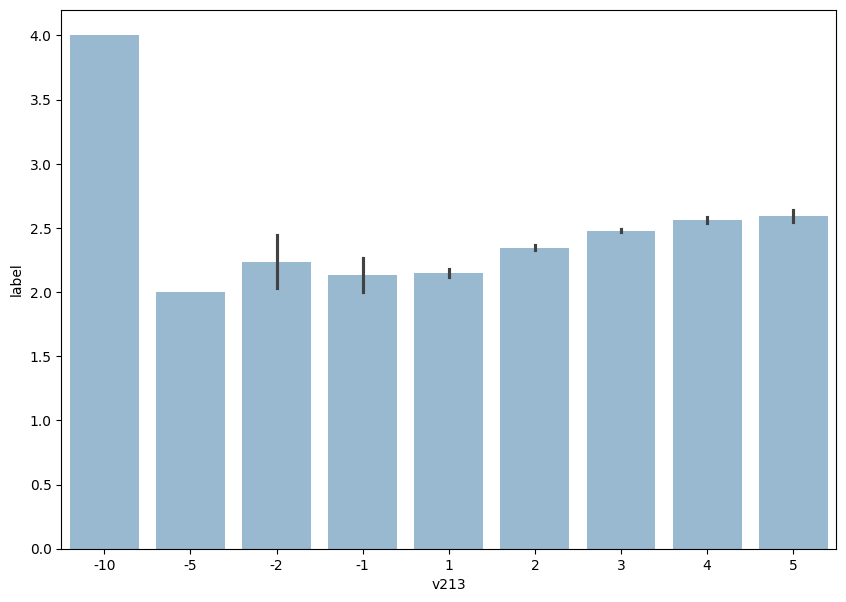

--------------------------------------------------
col: v214


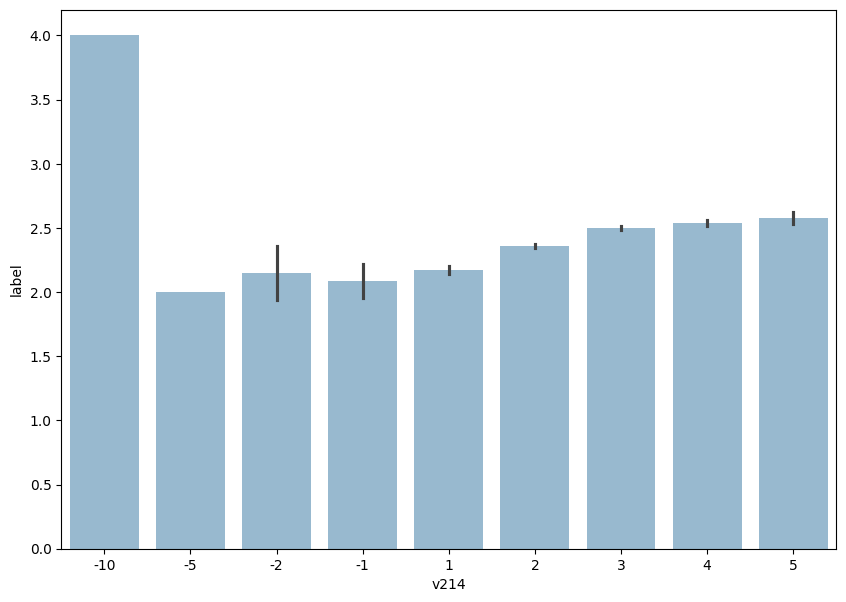

--------------------------------------------------
col: v215


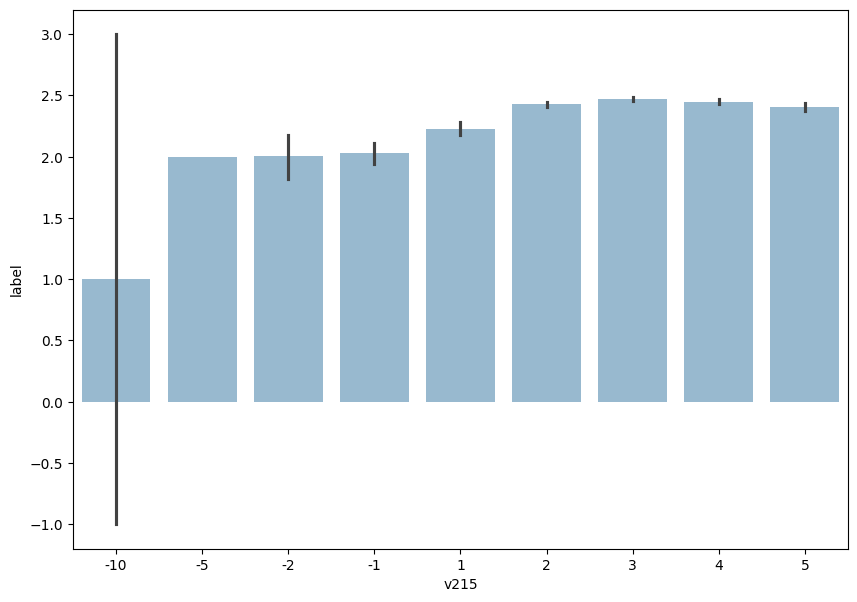

--------------------------------------------------
col: v216


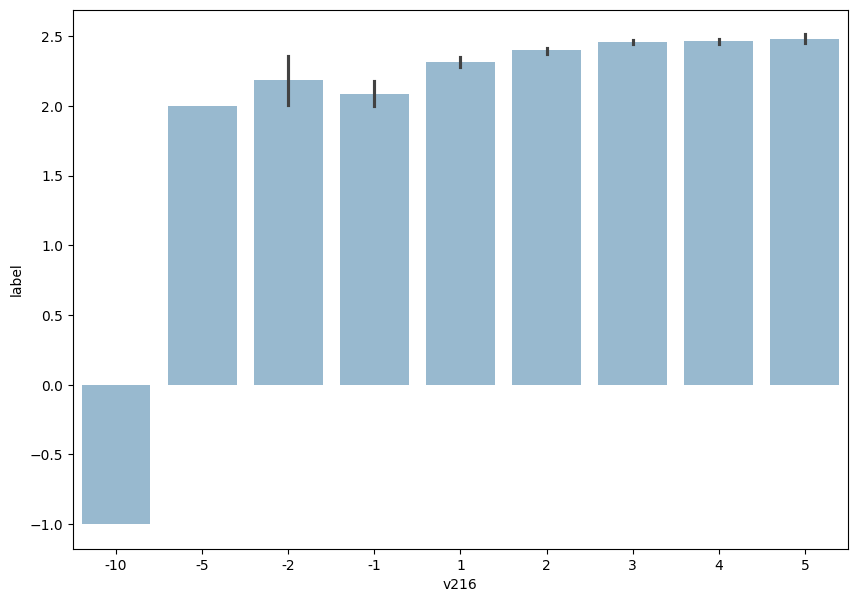

--------------------------------------------------
col: v217


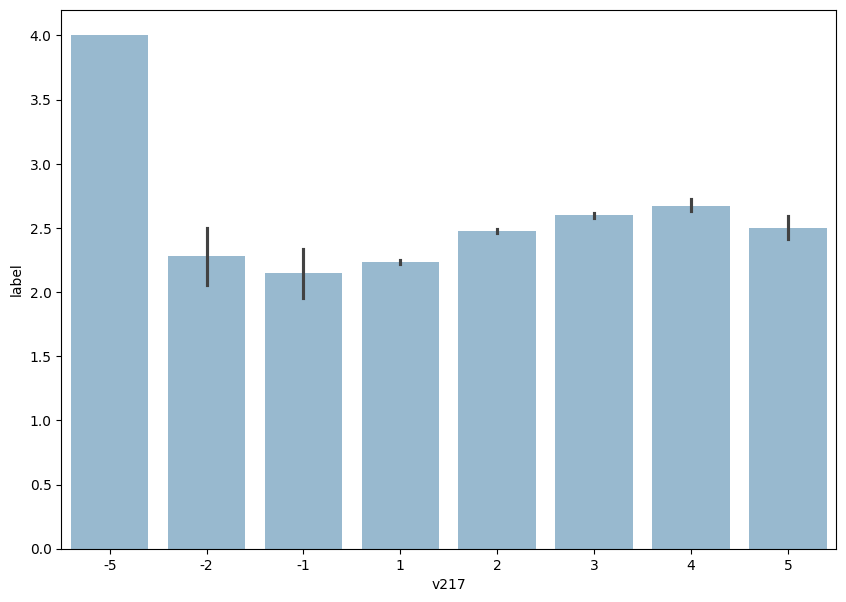

--------------------------------------------------
col: v218


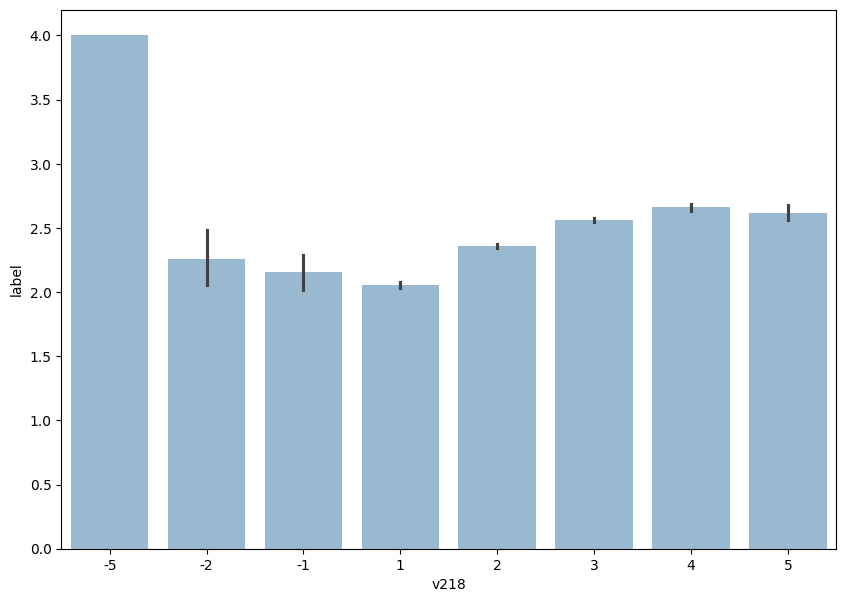

--------------------------------------------------
col: v219


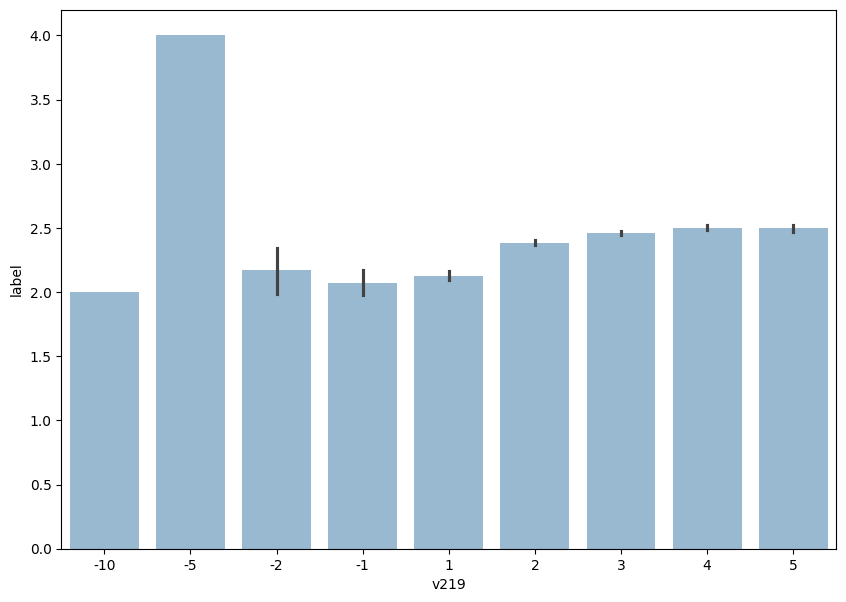

--------------------------------------------------
col: v220


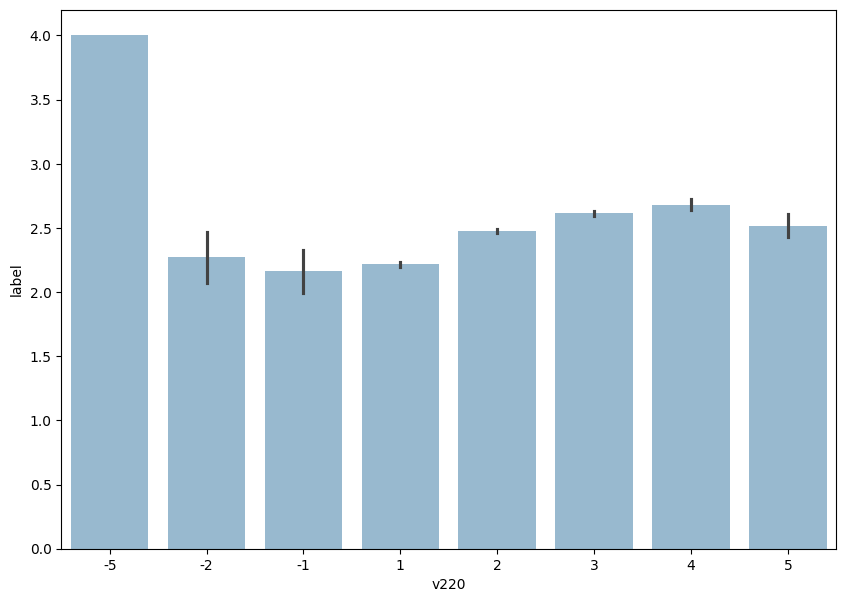

--------------------------------------------------
col: v221


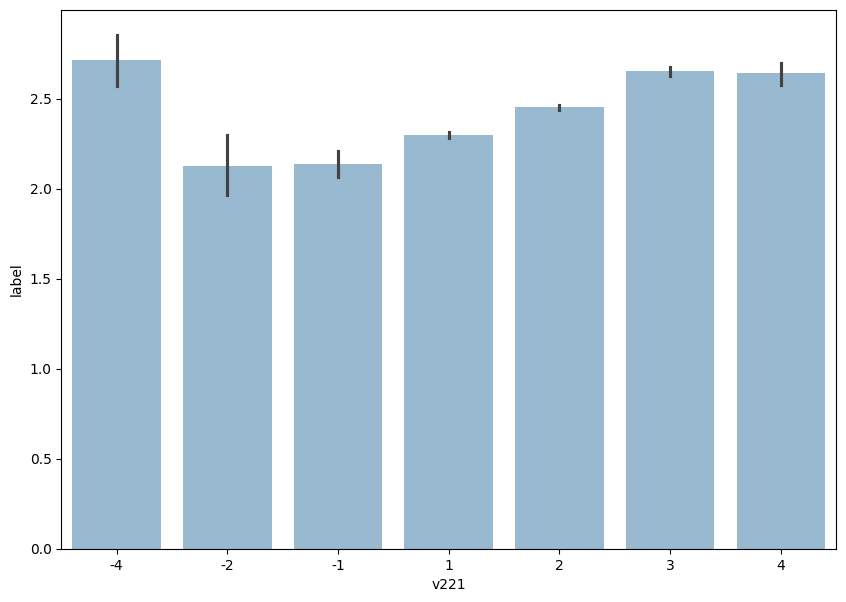

--------------------------------------------------
col: v221_DK


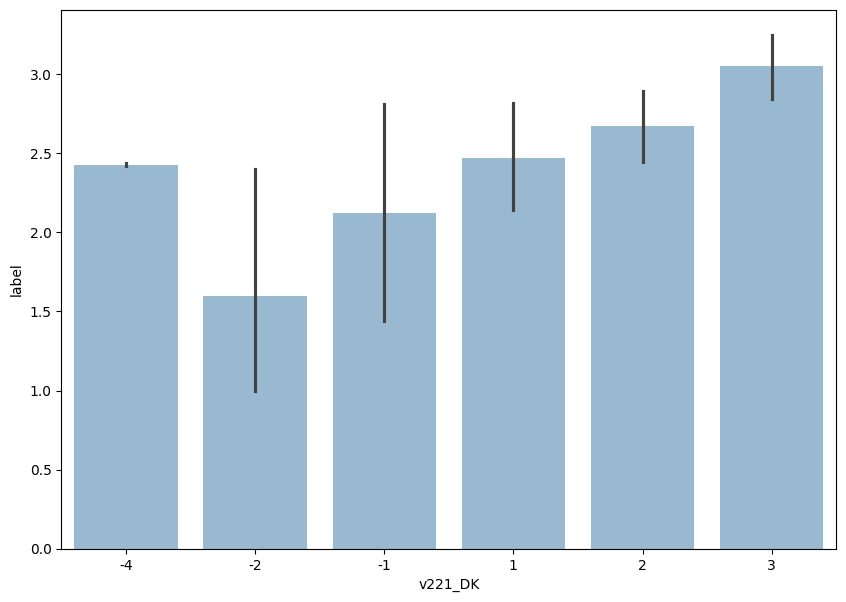

--------------------------------------------------
col: v222


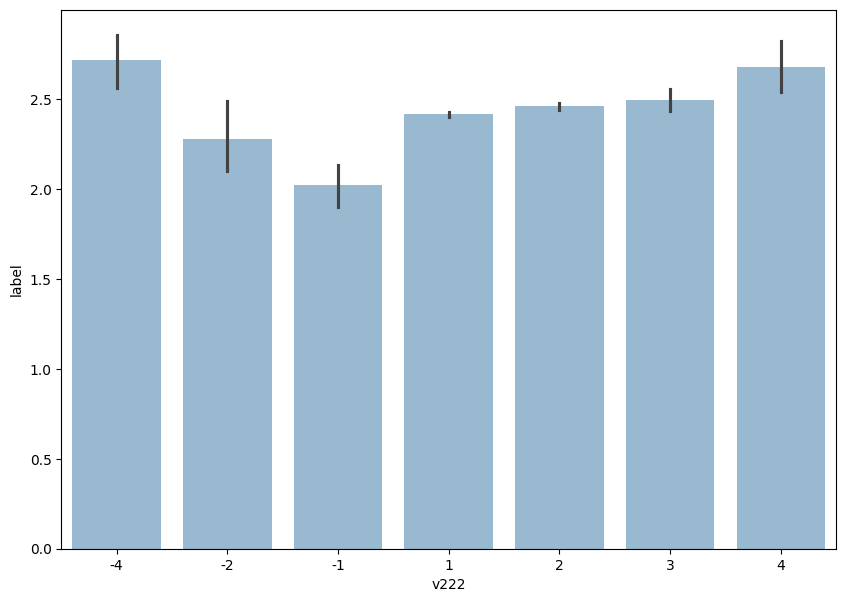

--------------------------------------------------
col: v223


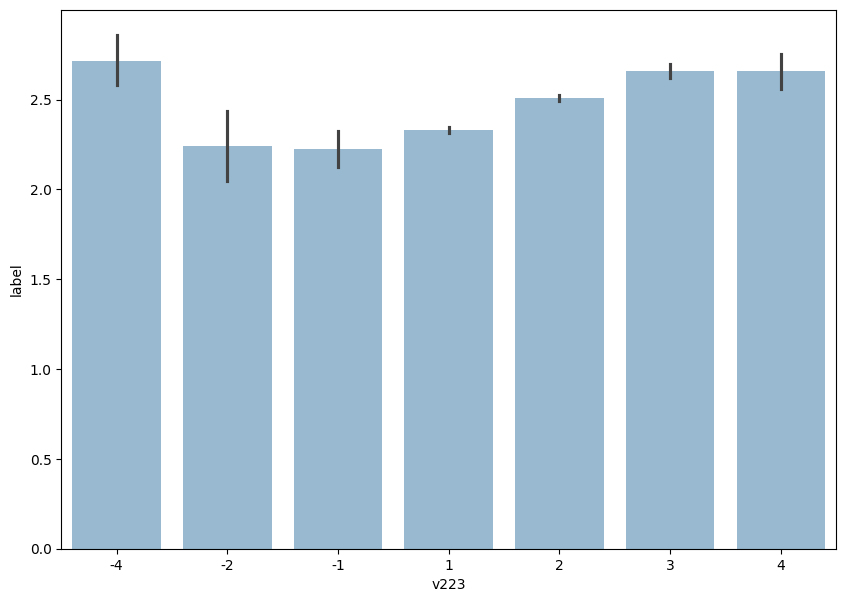

--------------------------------------------------
col: v224


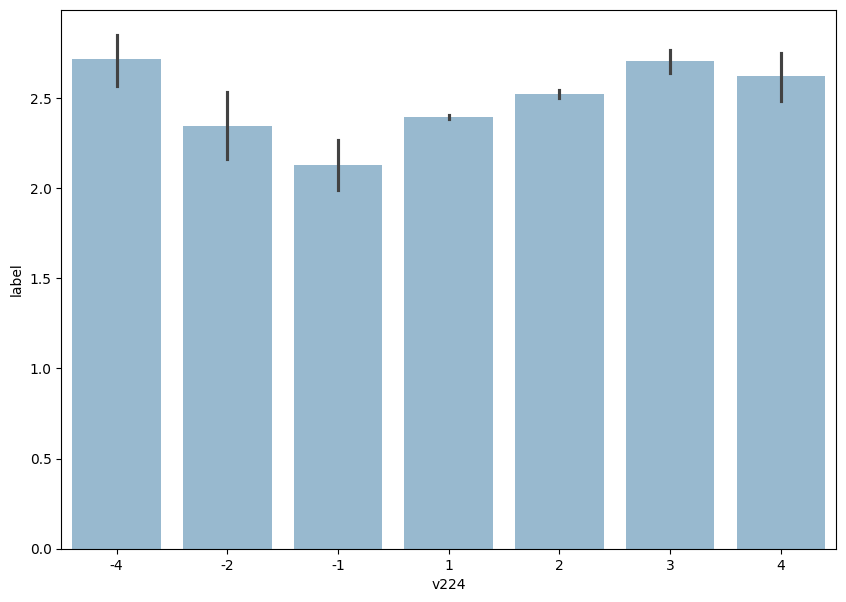

--------------------------------------------------
col: v225


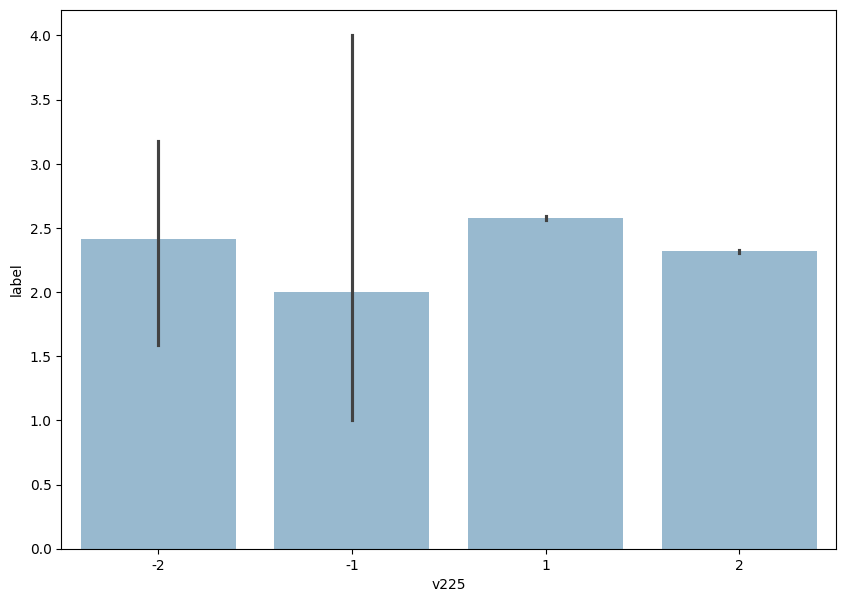

--------------------------------------------------
col: v226


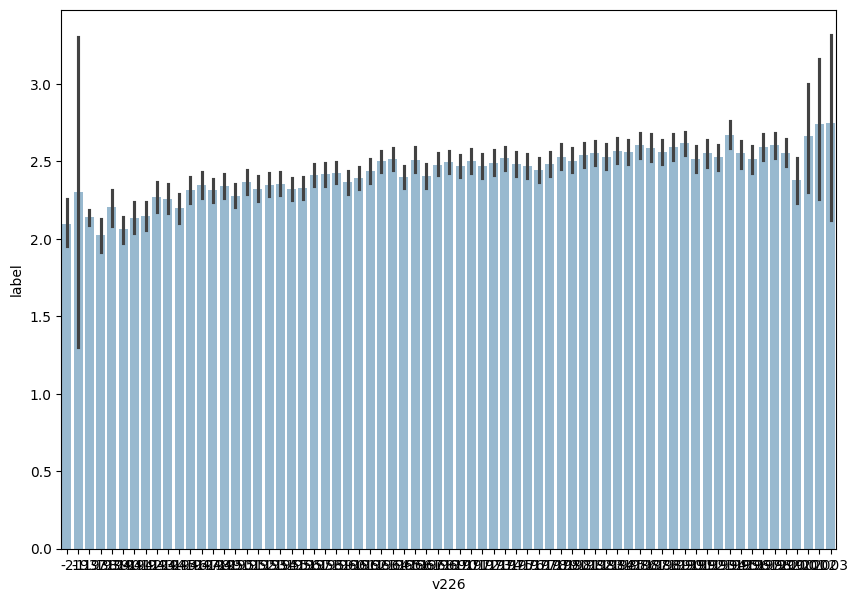

--------------------------------------------------
col: age


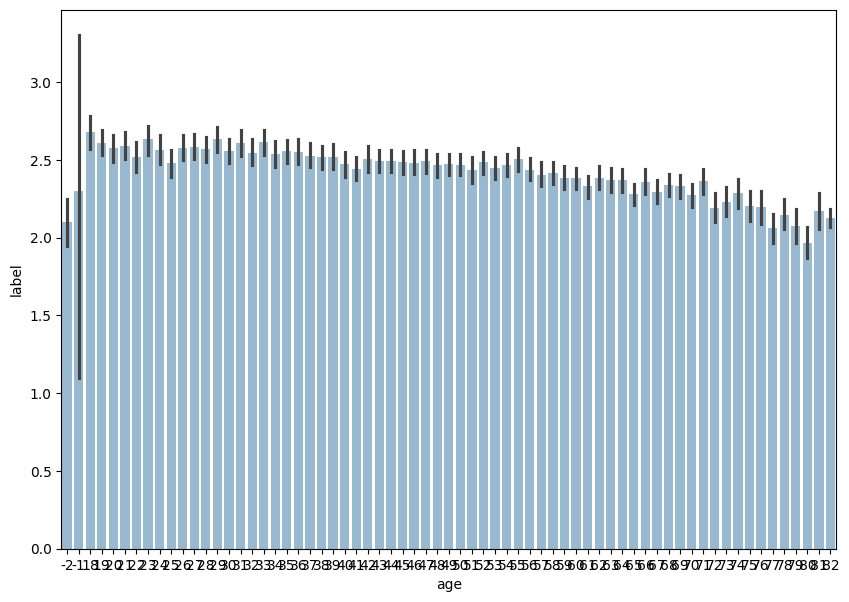

--------------------------------------------------
col: age_r2


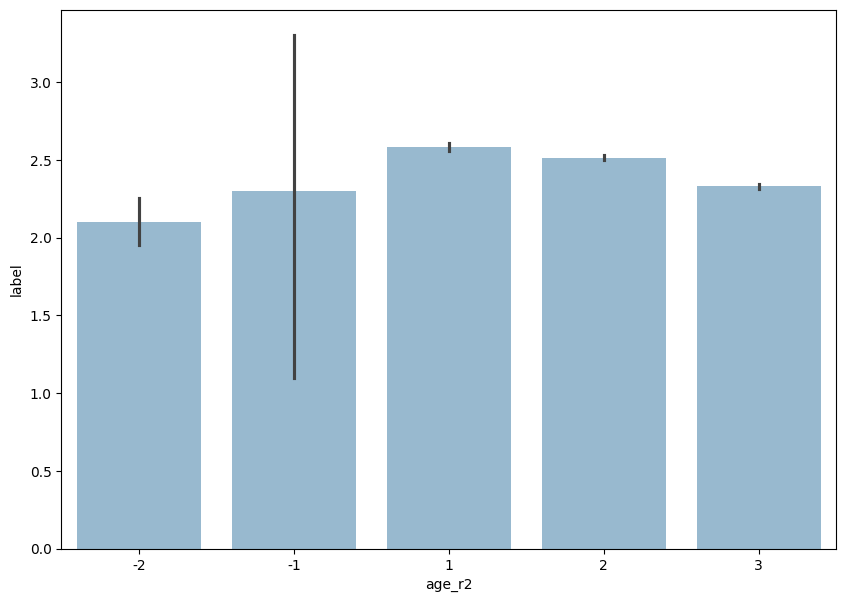

--------------------------------------------------
col: v227


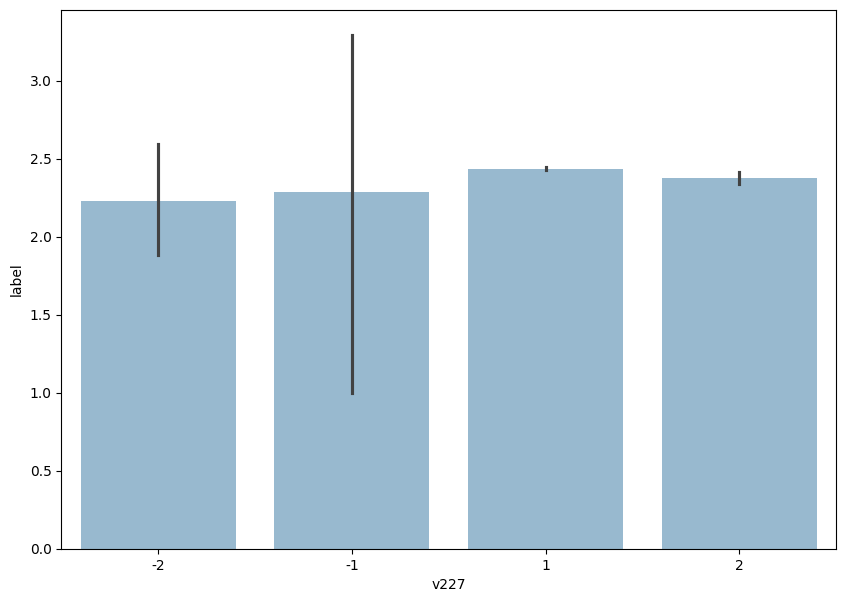

--------------------------------------------------
col: v228b_r


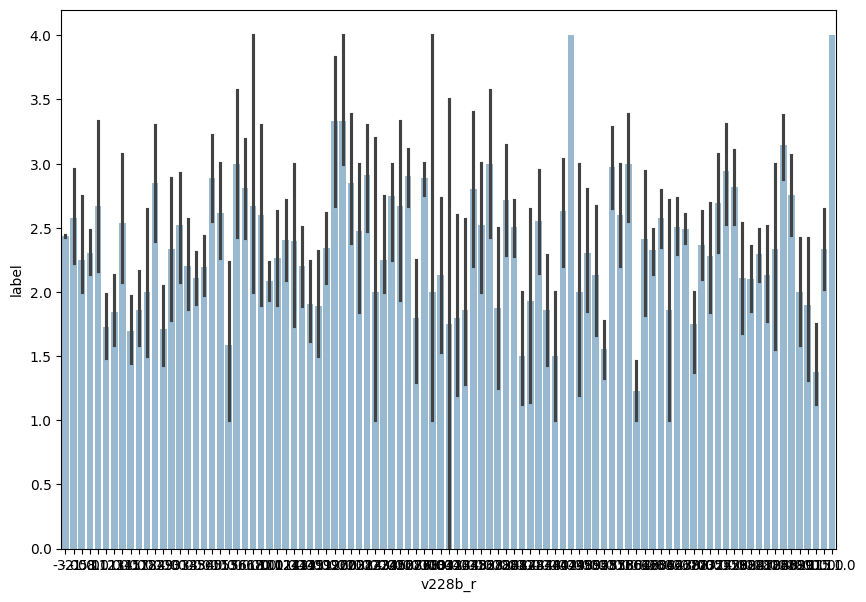

--------------------------------------------------
col: v229


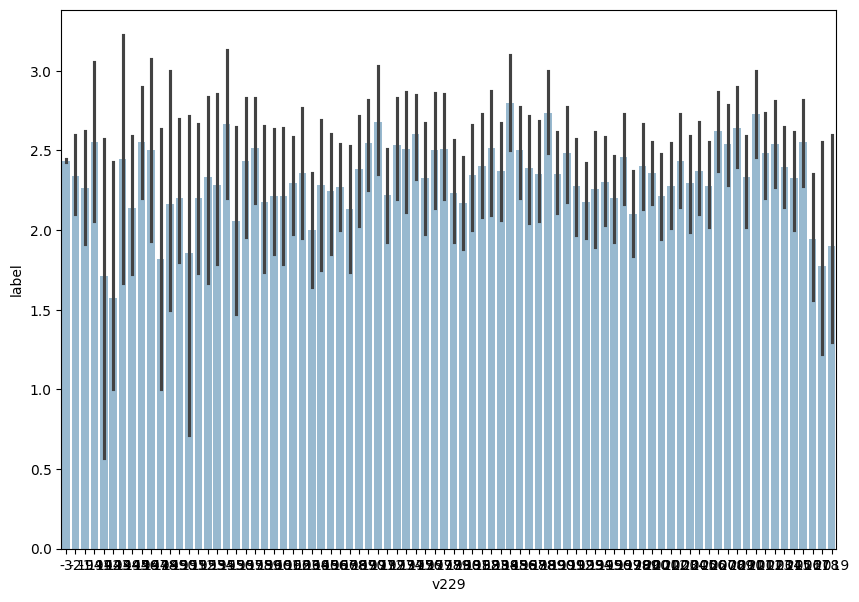

--------------------------------------------------
col: v230


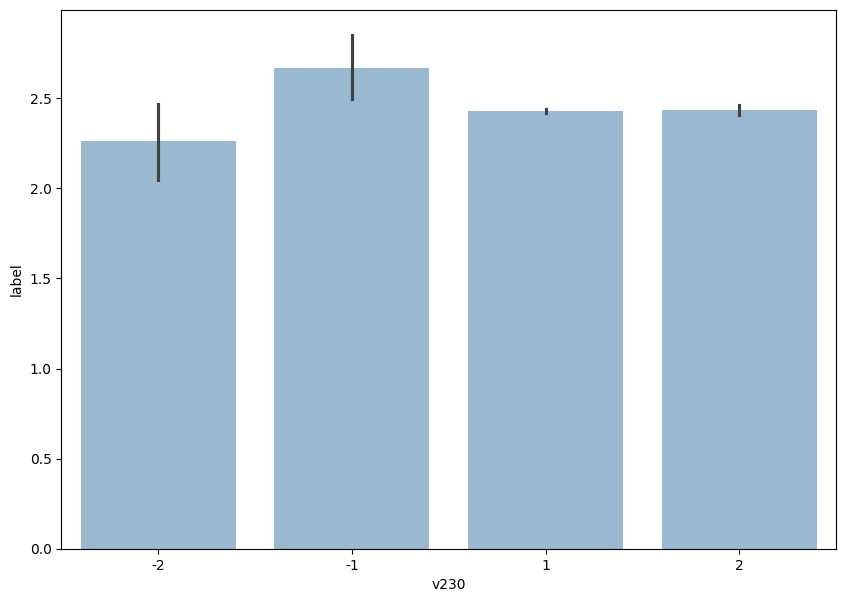

--------------------------------------------------
col: v231b_r


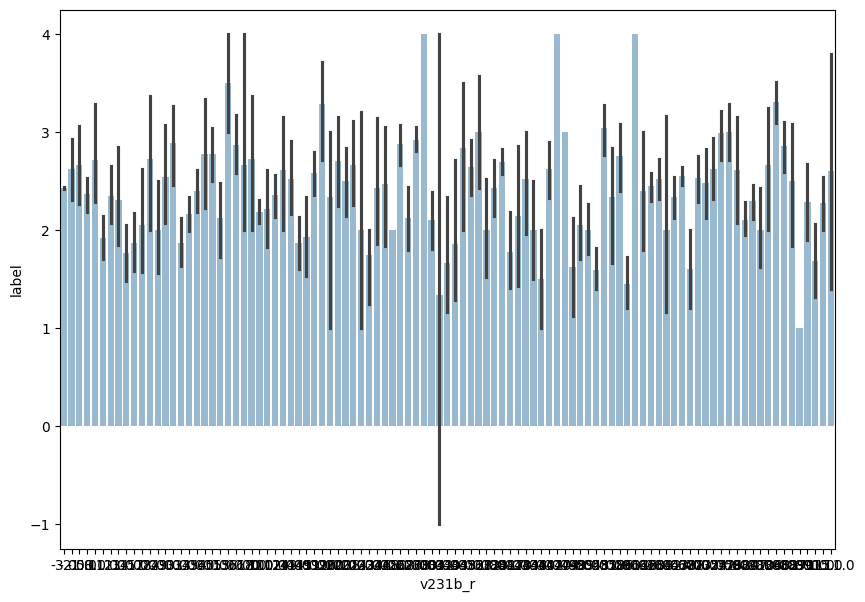

--------------------------------------------------
col: v232


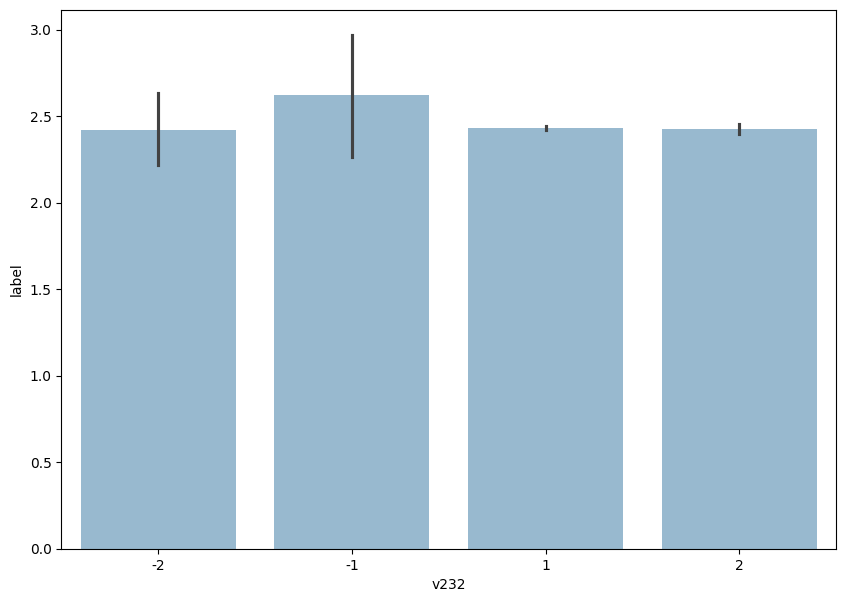

--------------------------------------------------
col: v233b_r


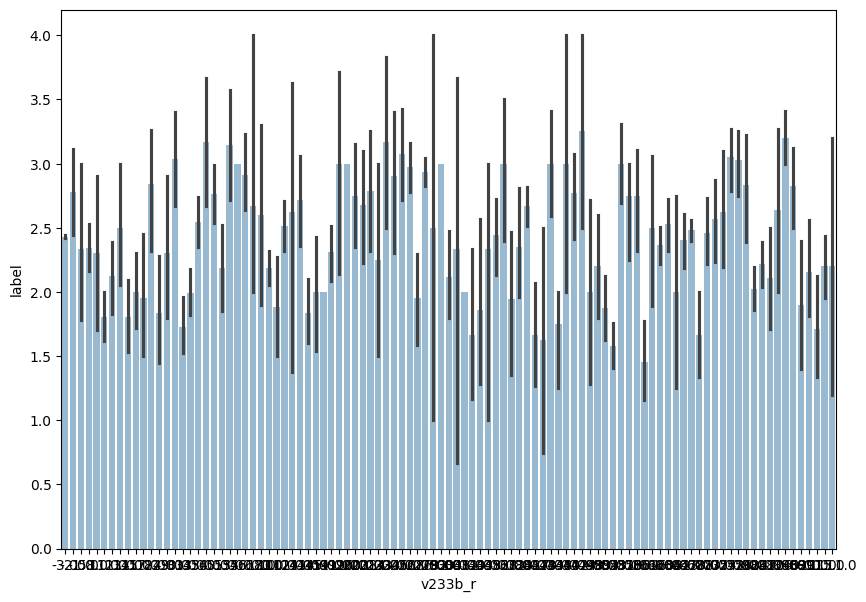

--------------------------------------------------
col: v234


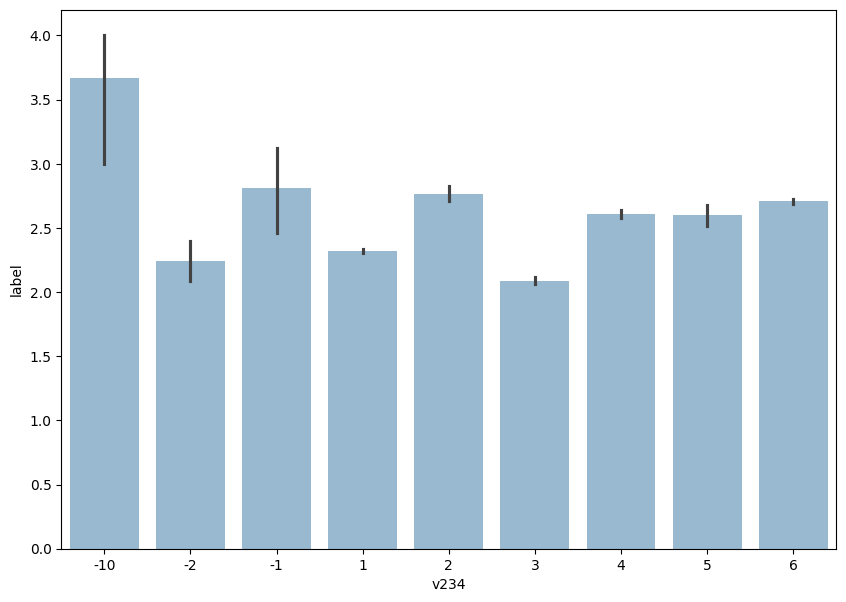

--------------------------------------------------
col: v235


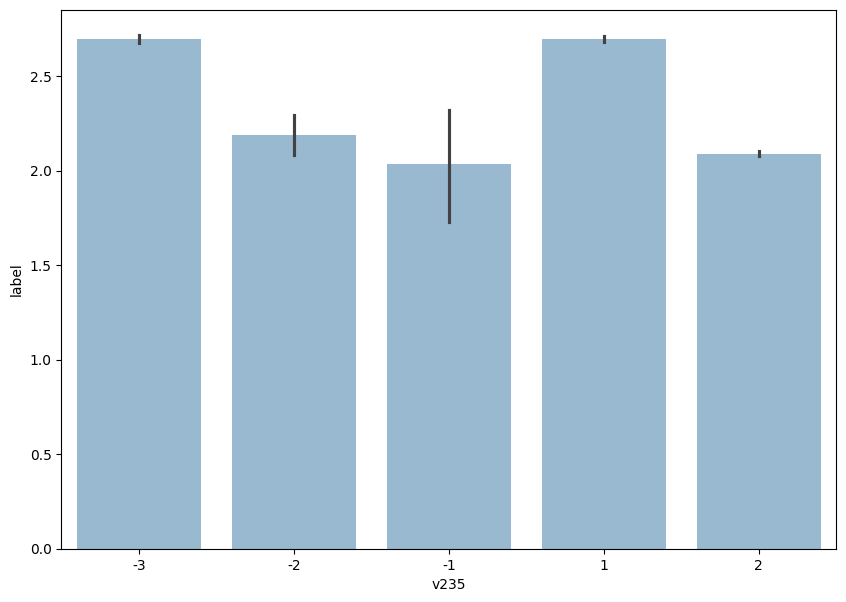

--------------------------------------------------
col: v236


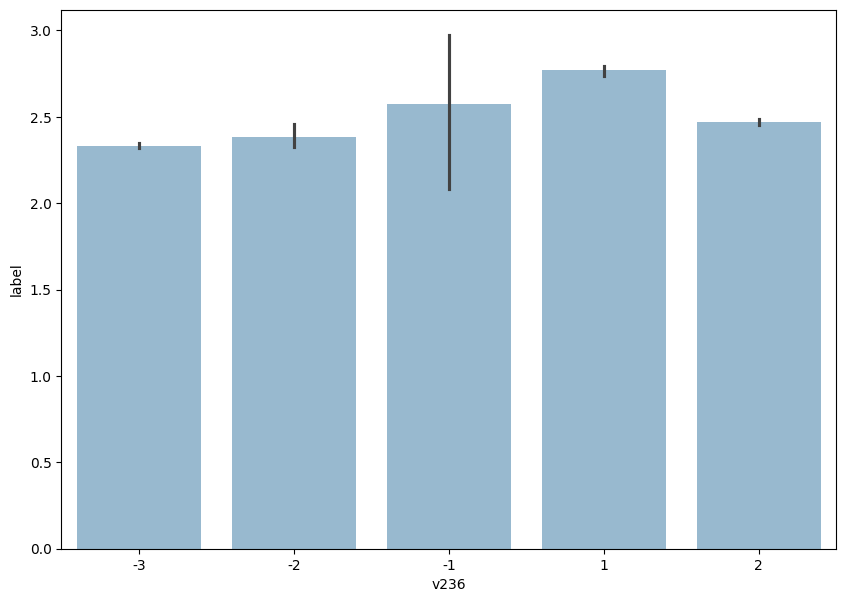

--------------------------------------------------
col: v237


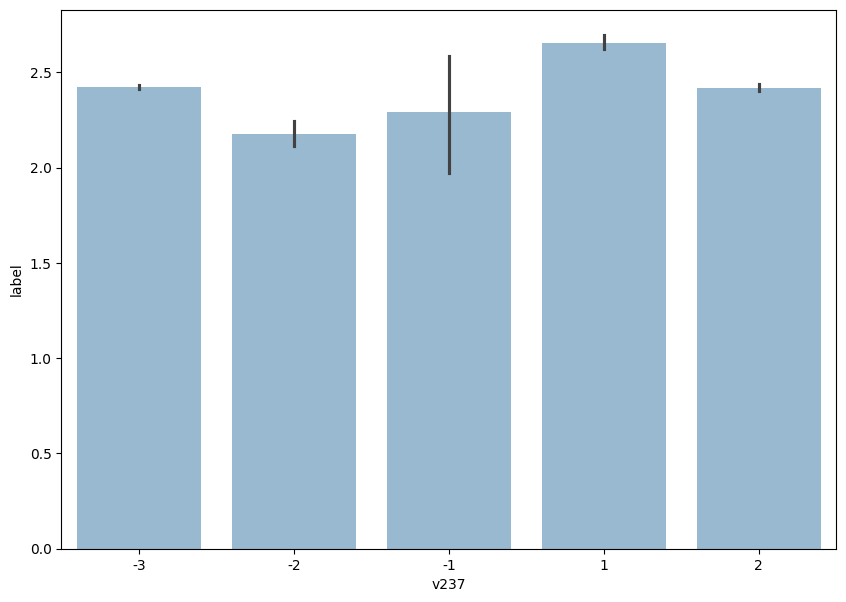

--------------------------------------------------
col: v238


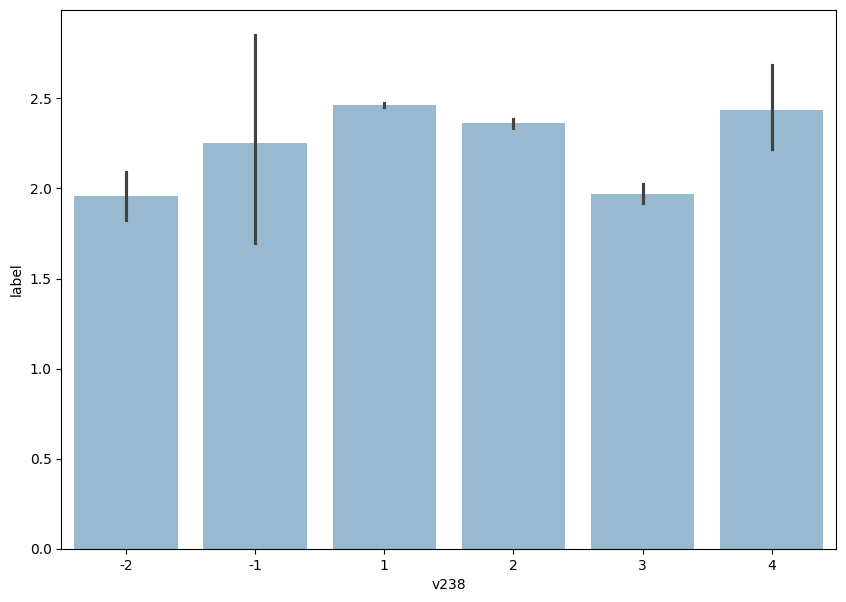

--------------------------------------------------
col: v239_r


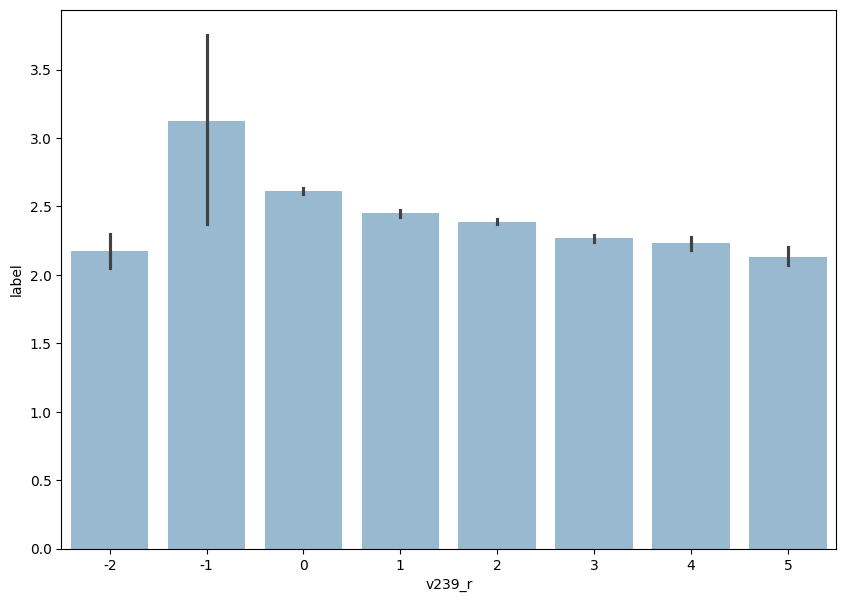

--------------------------------------------------
col: v239a


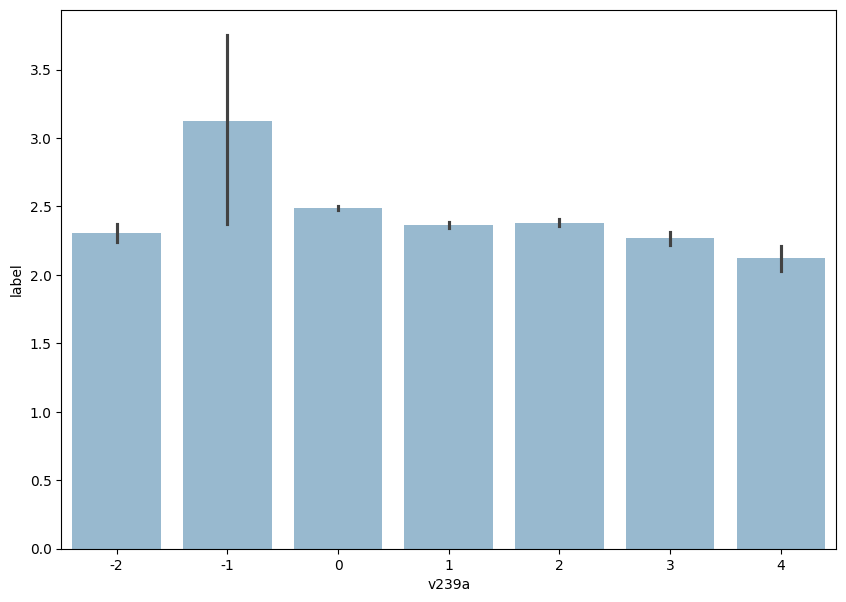

--------------------------------------------------
col: v239b


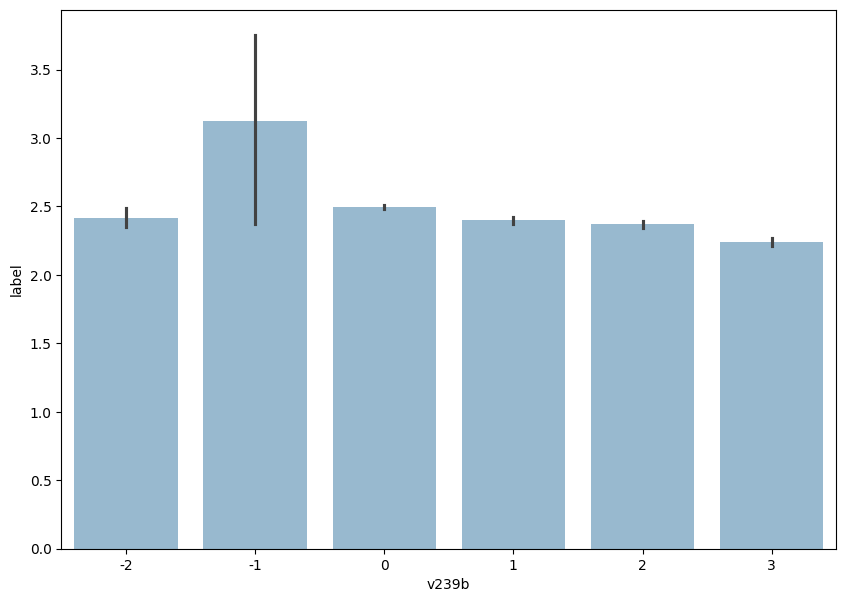

--------------------------------------------------
col: v240


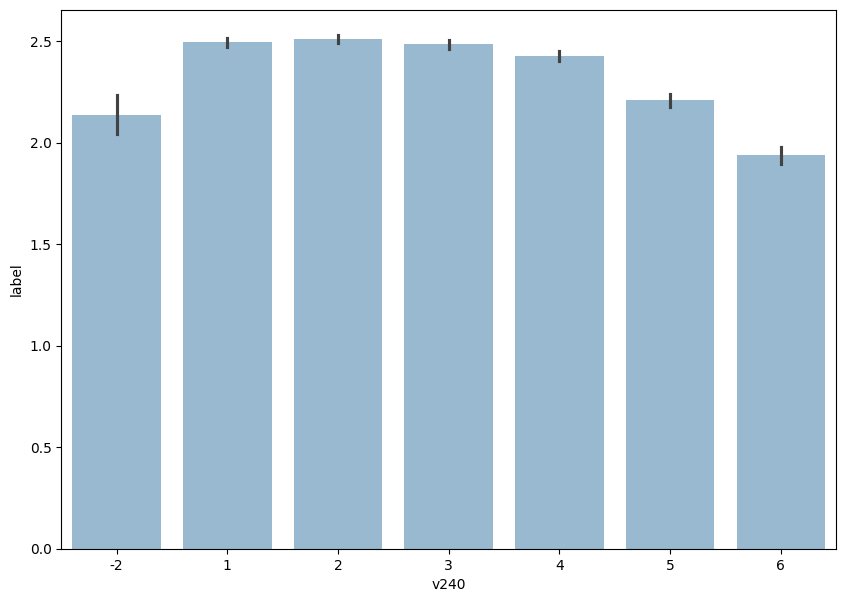

--------------------------------------------------
col: v241


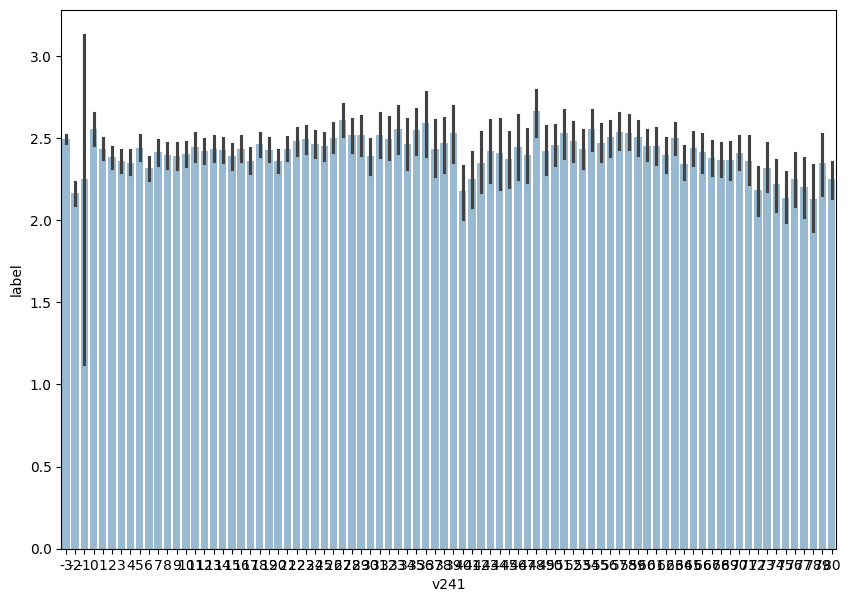

--------------------------------------------------
col: v242


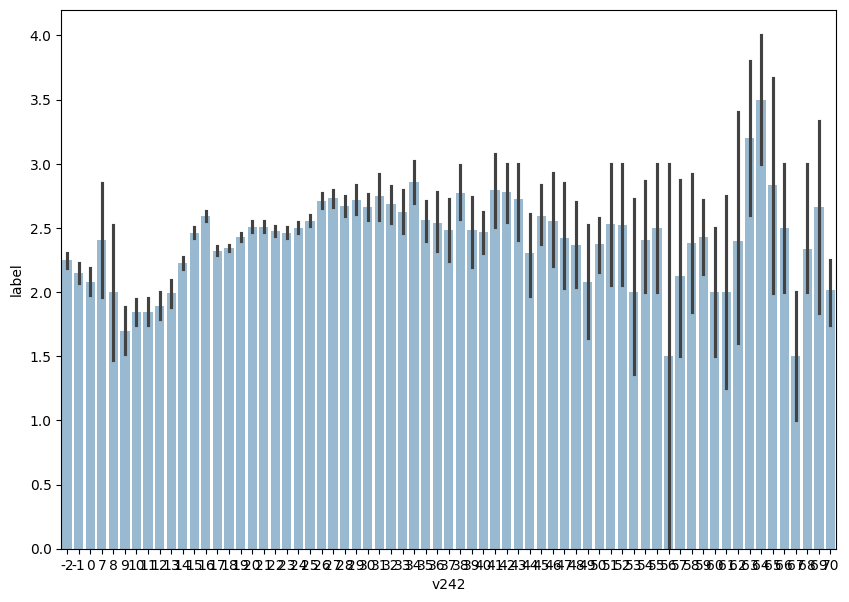

--------------------------------------------------
col: v242_r


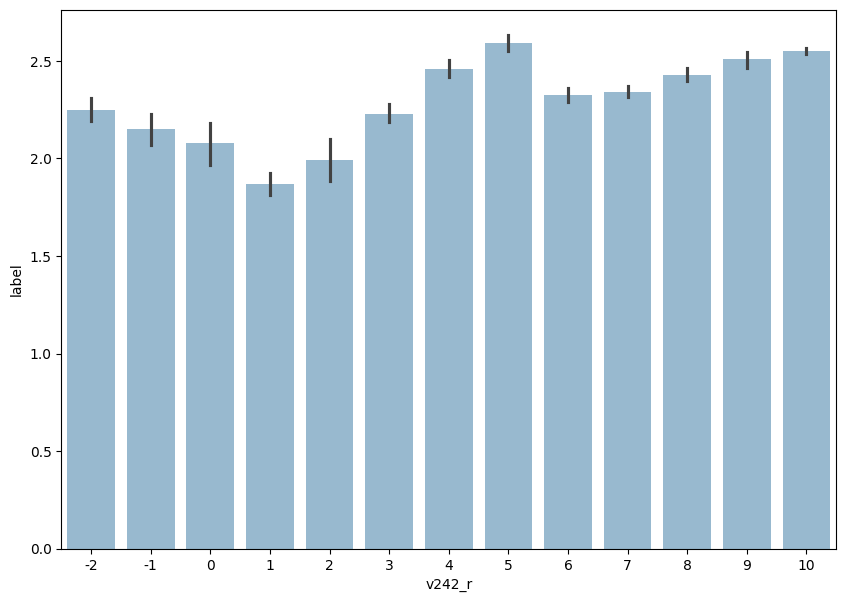

--------------------------------------------------
col: v243_ISCED_3


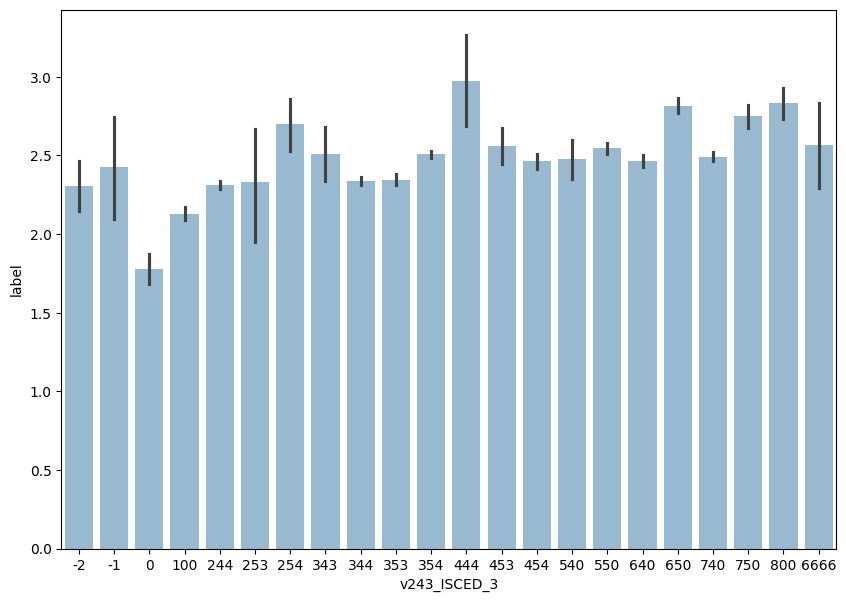

--------------------------------------------------
col: v244


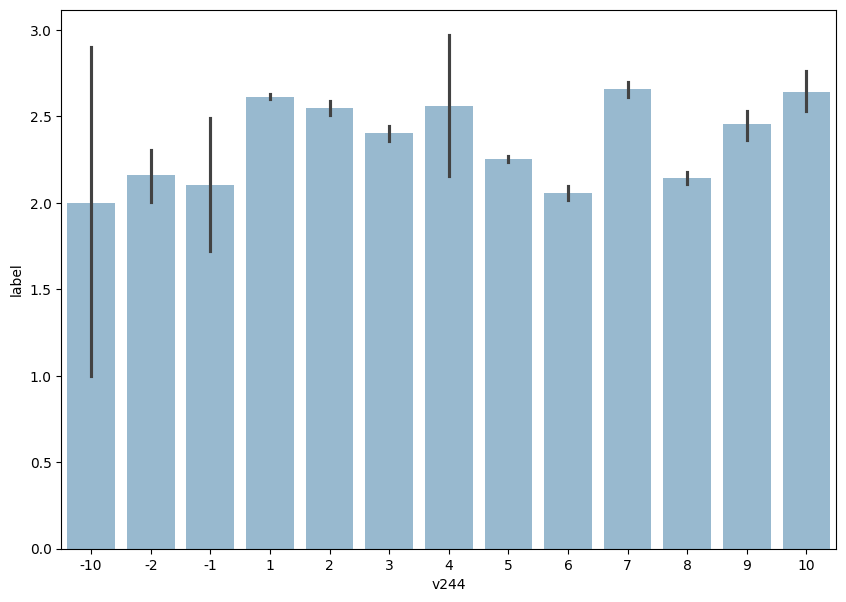

--------------------------------------------------
col: v245


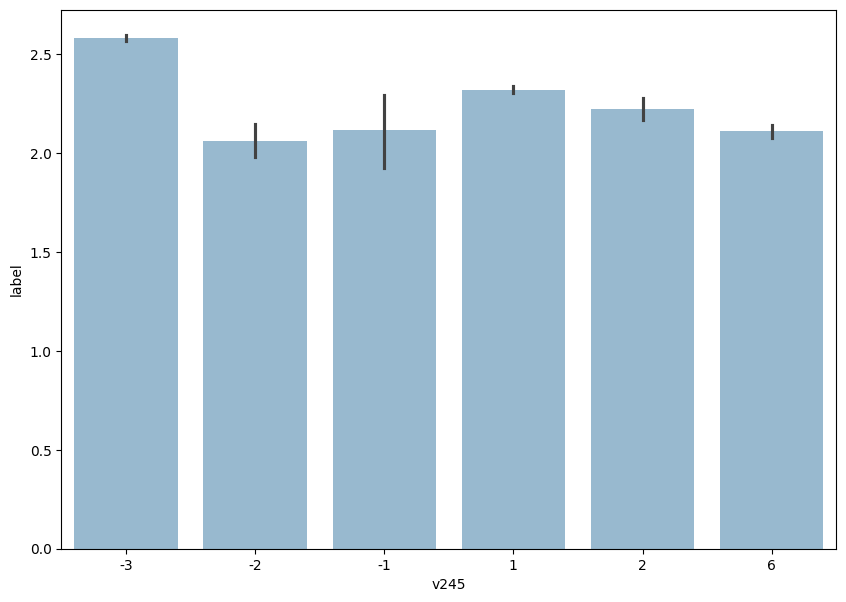

--------------------------------------------------
col: v246_ESeC


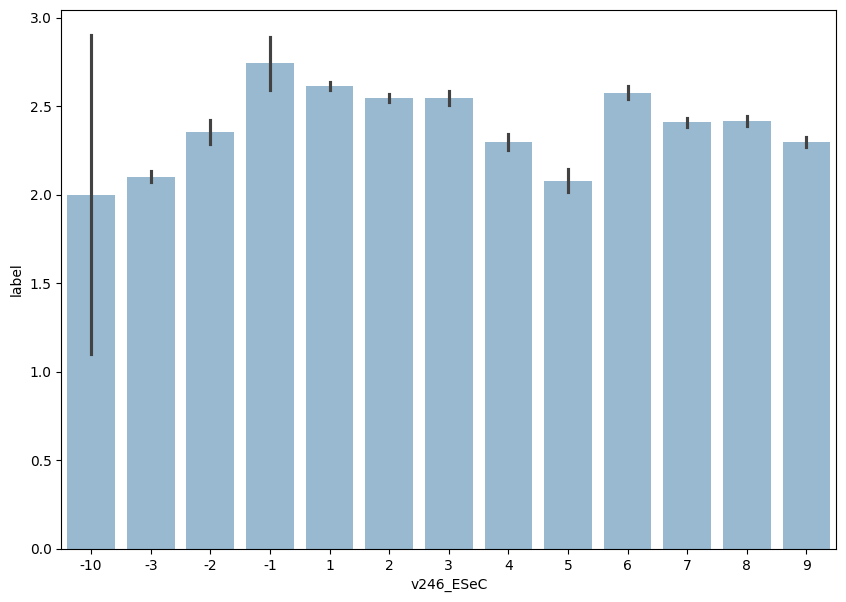

--------------------------------------------------
col: v247


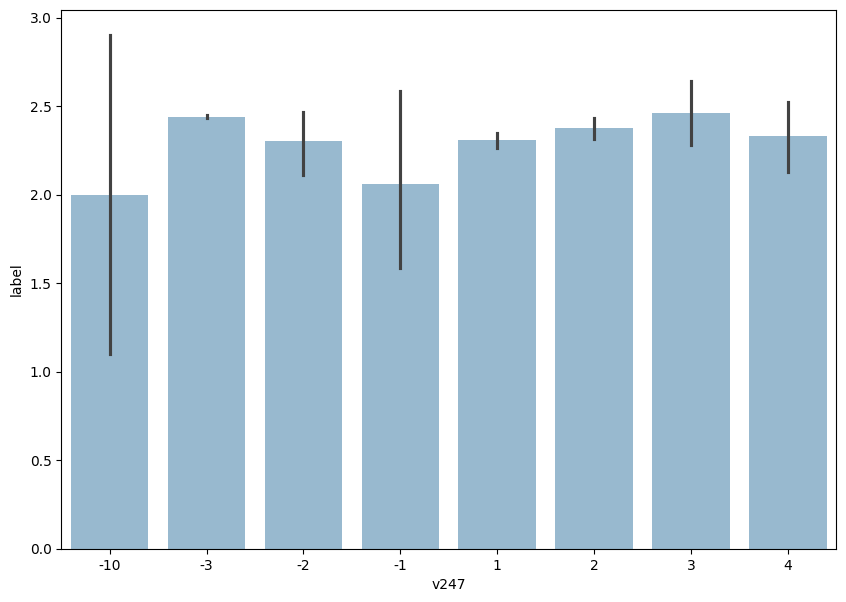

--------------------------------------------------
col: v248


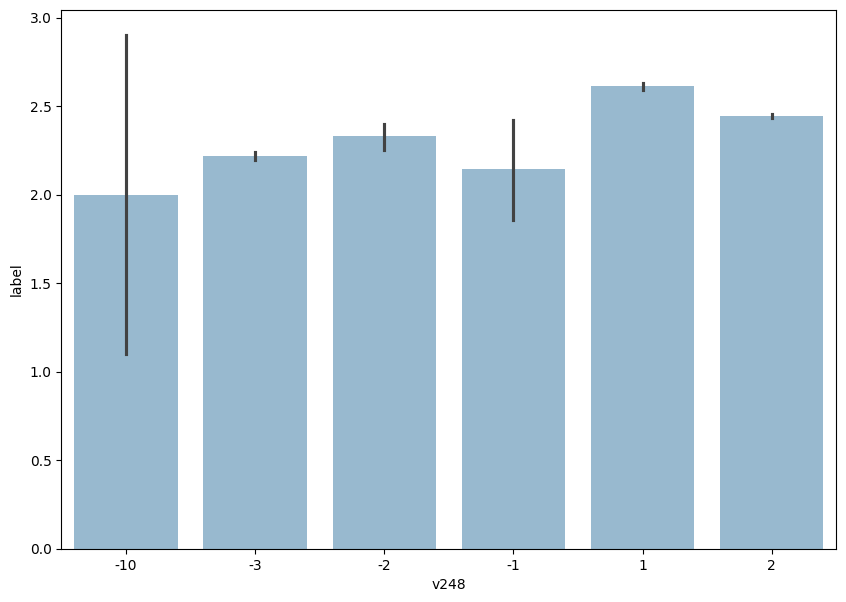

--------------------------------------------------
col: v248a


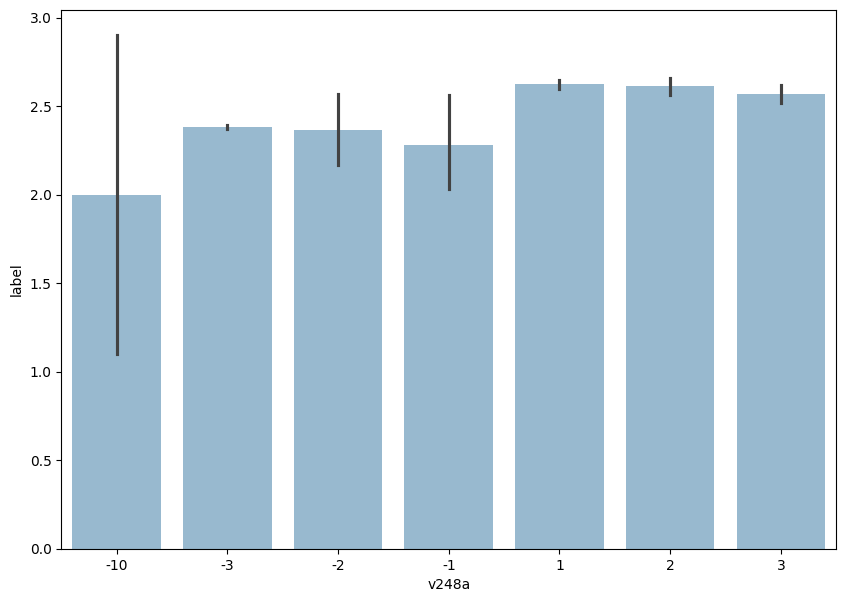

--------------------------------------------------
col: v249


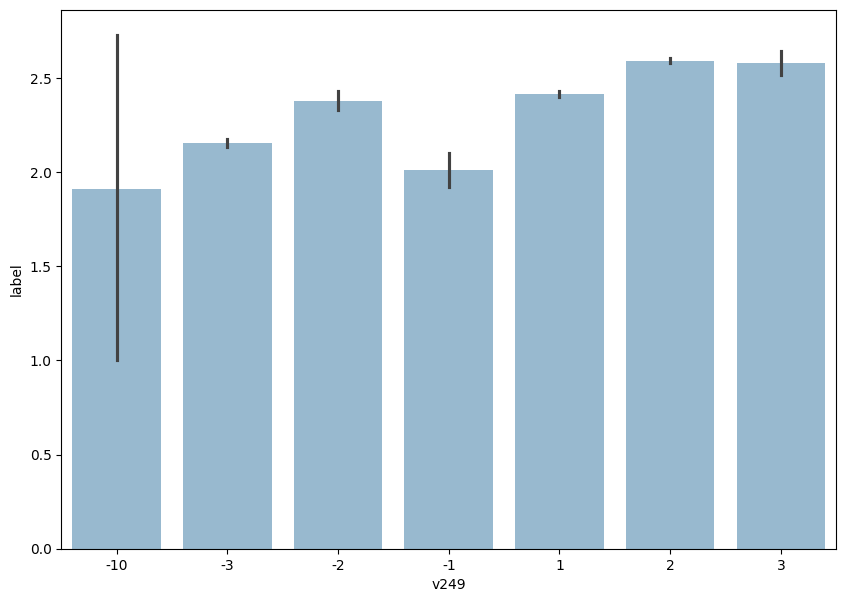

--------------------------------------------------
col: v250


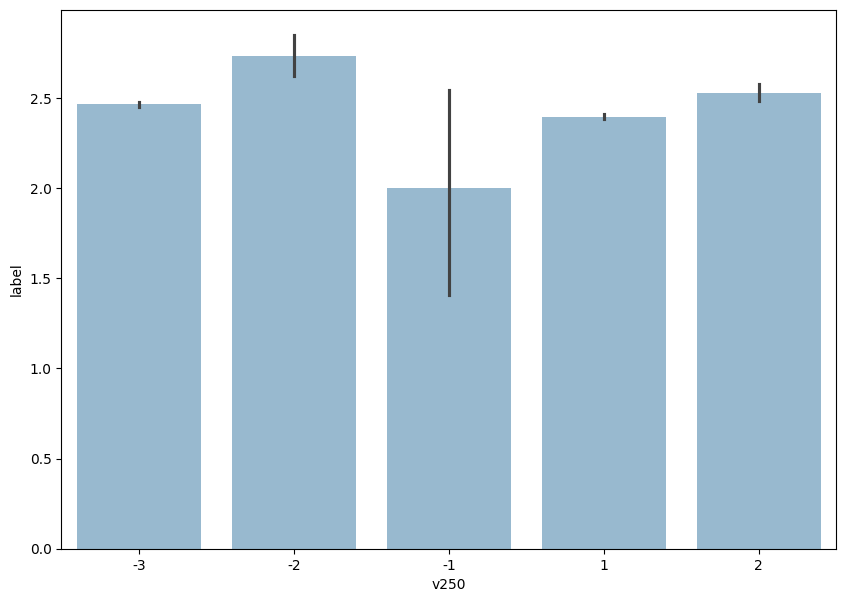

--------------------------------------------------
col: v251b_r


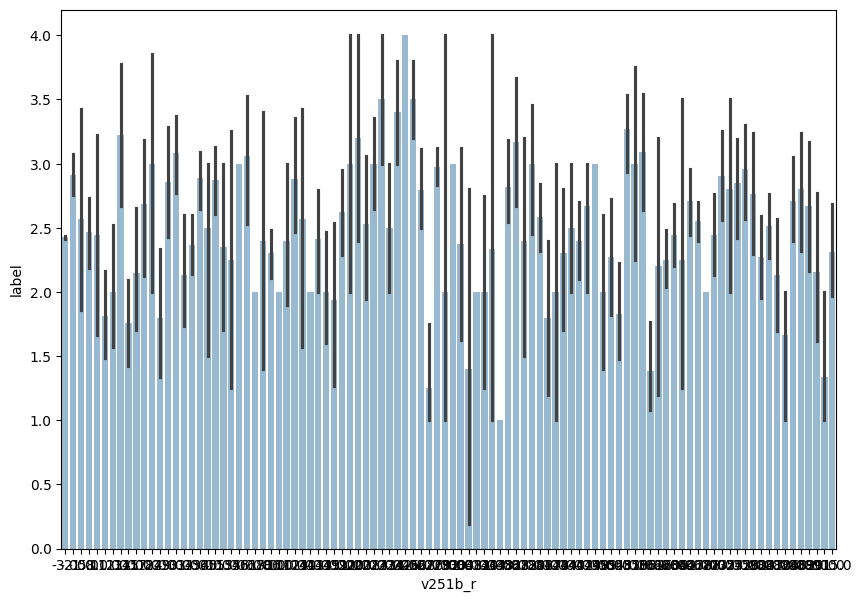

--------------------------------------------------
col: v252_edulvlb_2


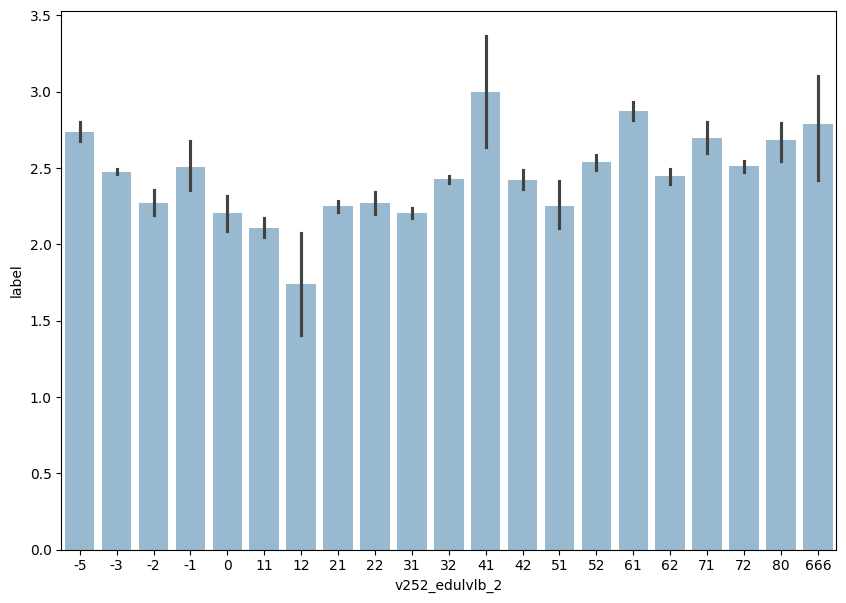

--------------------------------------------------
col: v253


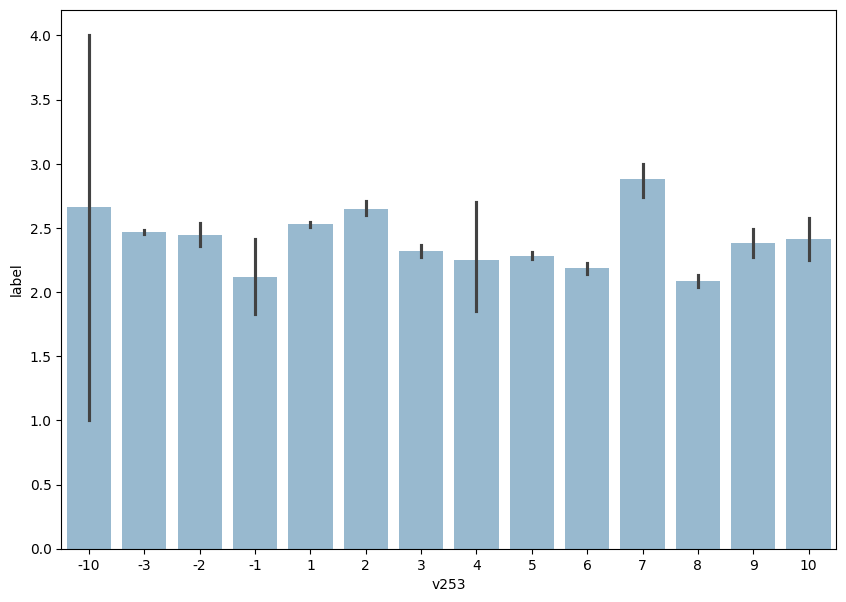

--------------------------------------------------
col: v254


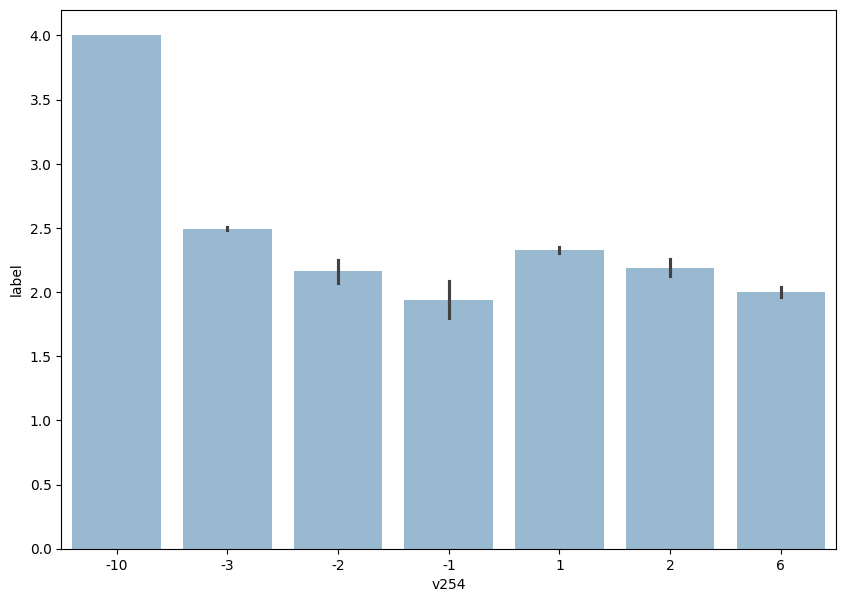

--------------------------------------------------
col: v255_ESeC


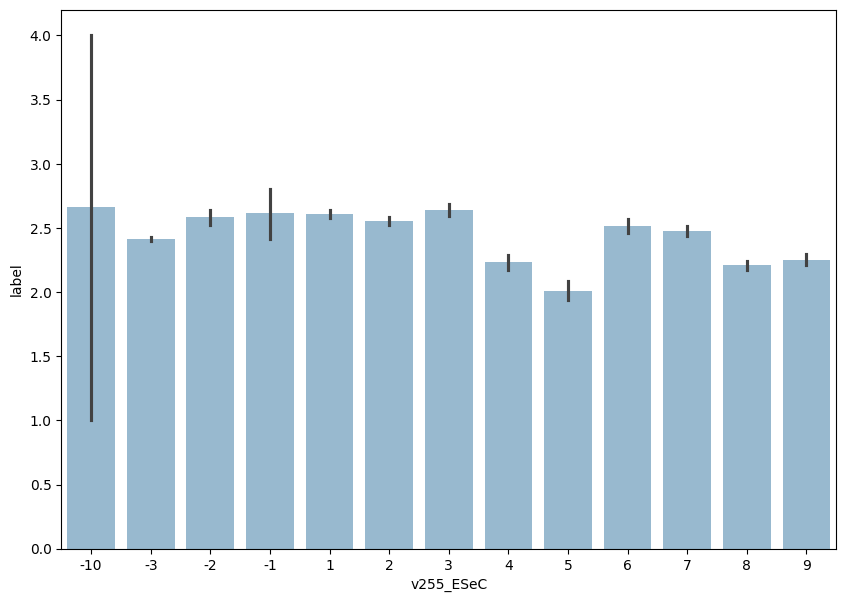

--------------------------------------------------
col: v256


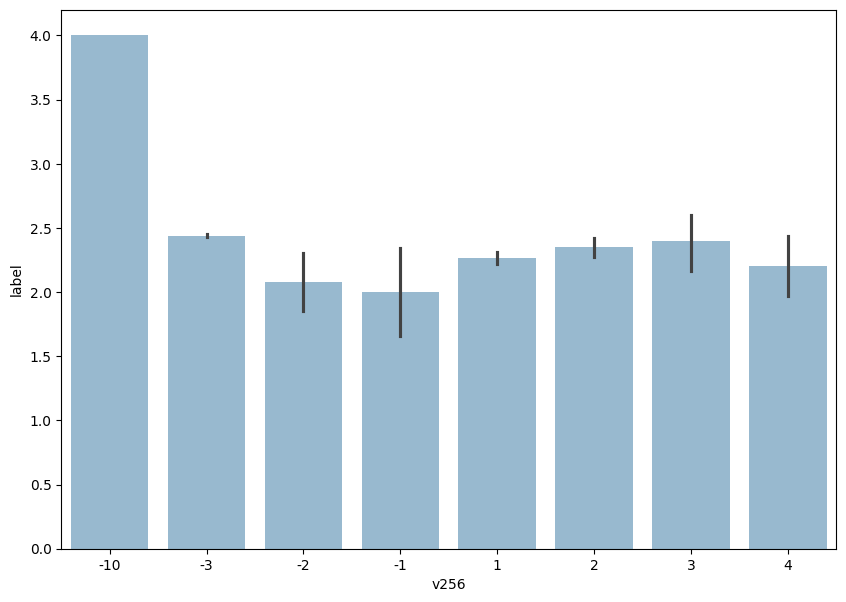

--------------------------------------------------
col: v257


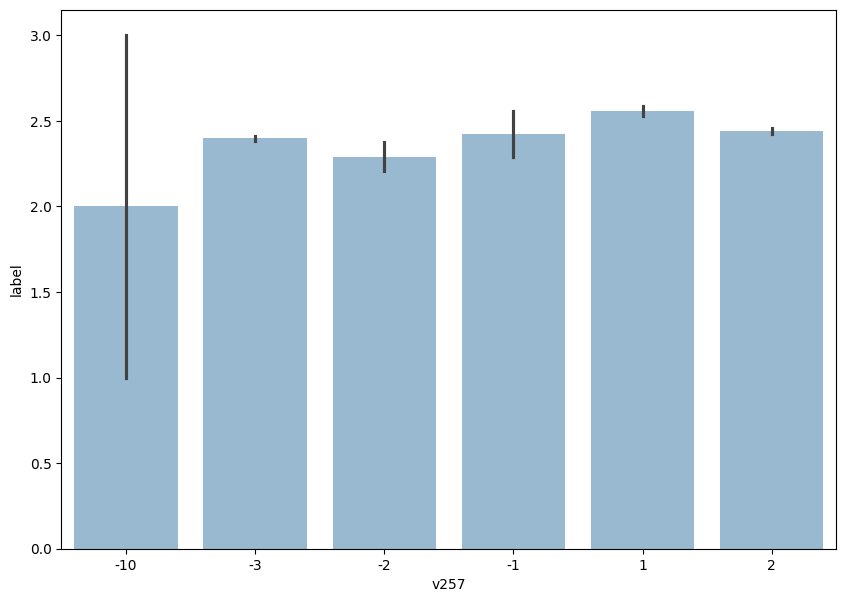

--------------------------------------------------
col: v258


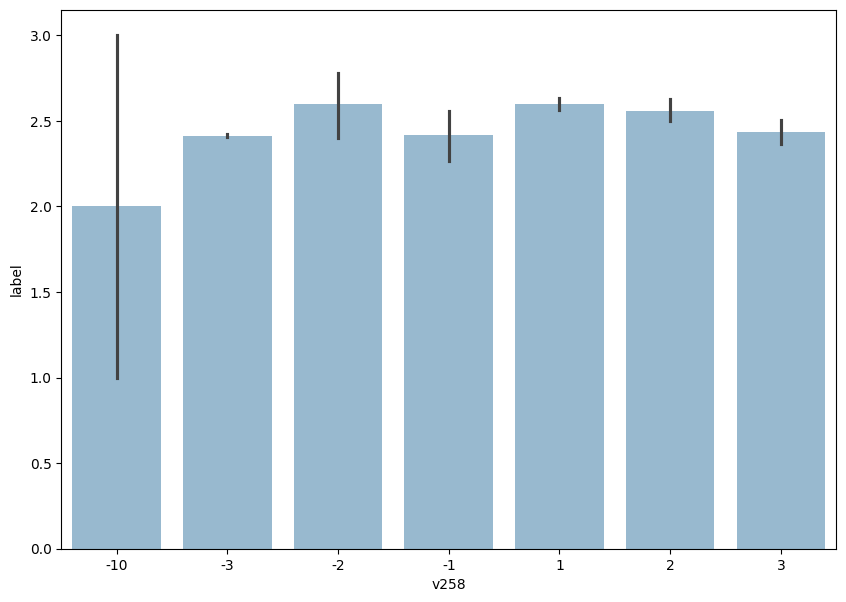

--------------------------------------------------
col: v259


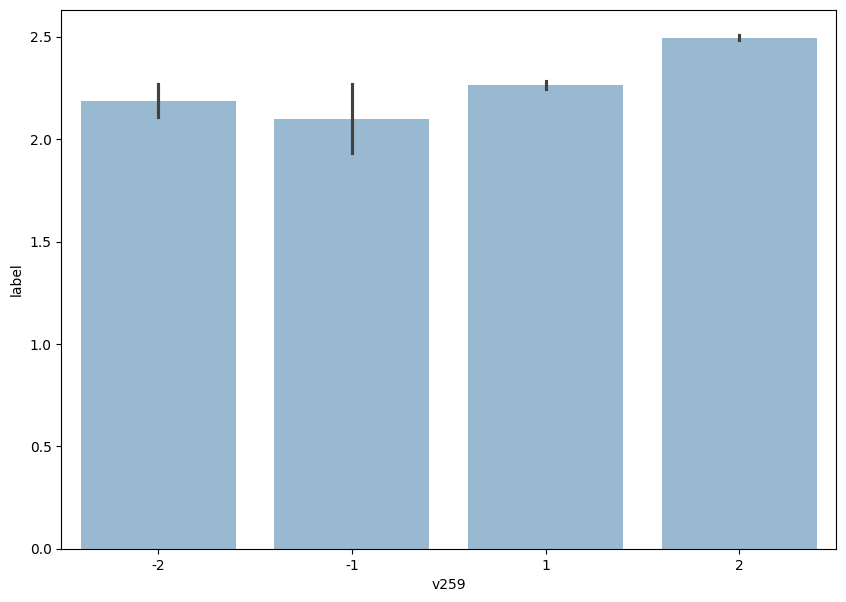

--------------------------------------------------
col: v260


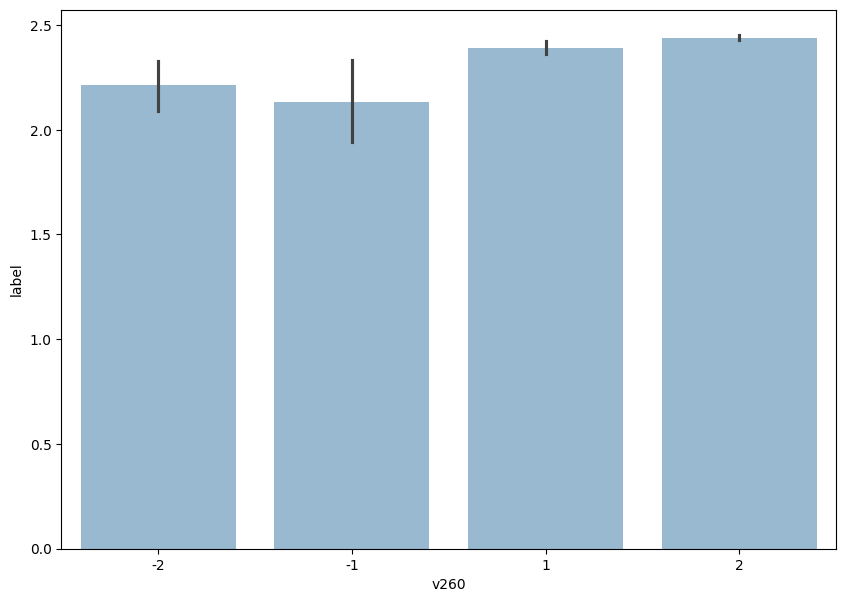

--------------------------------------------------
col: v261


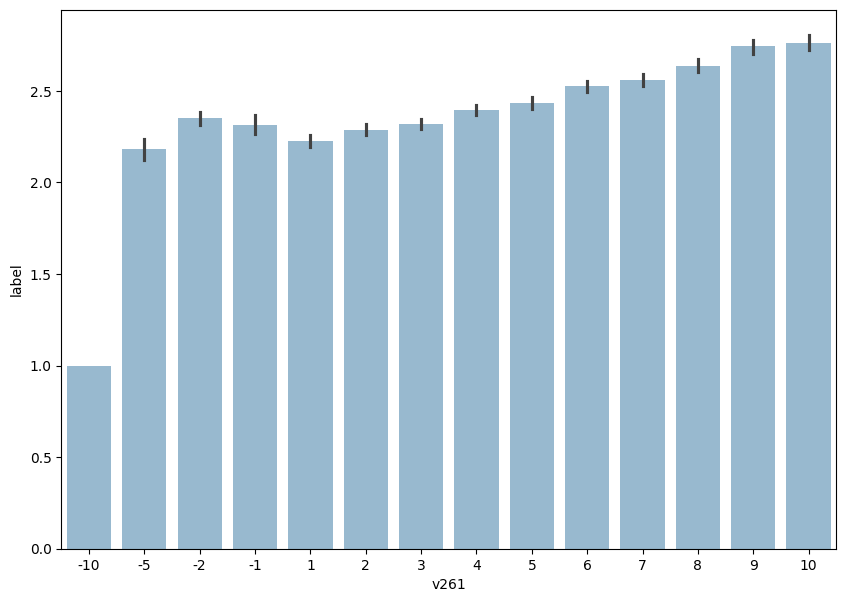

--------------------------------------------------
col: v261_r


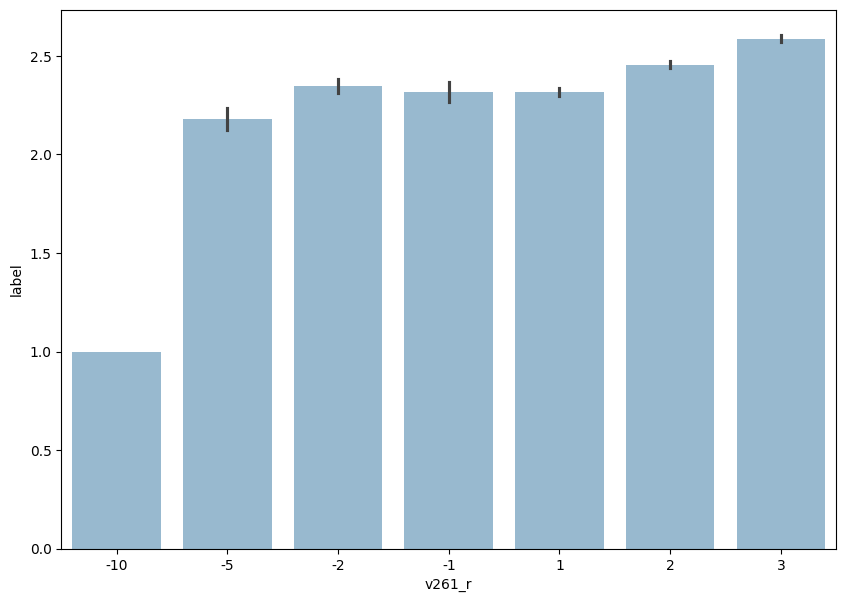

--------------------------------------------------
col: v262_edulvlb_2


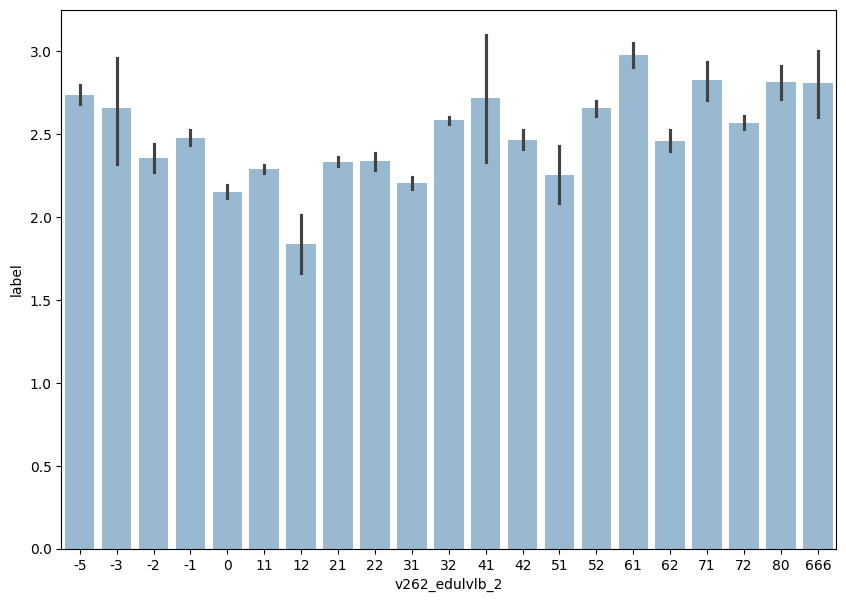

--------------------------------------------------
col: v264


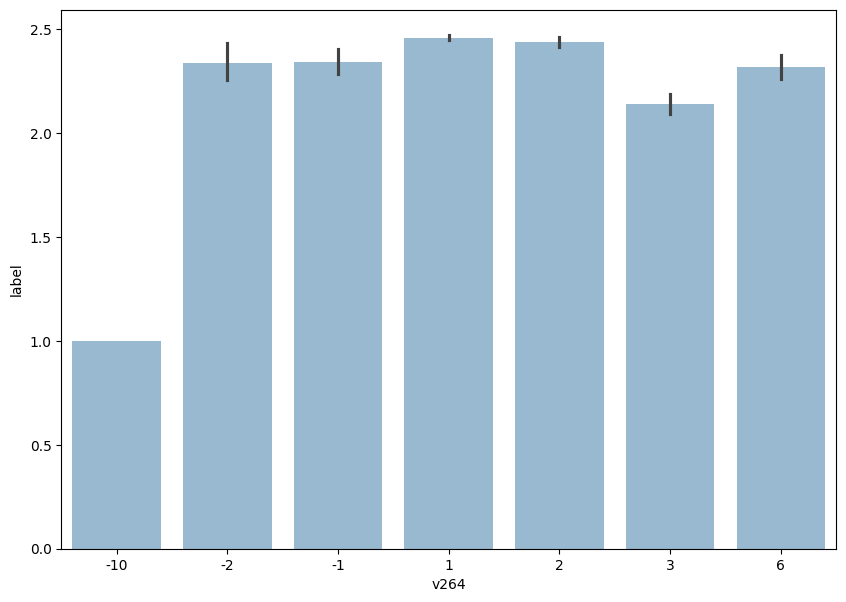

--------------------------------------------------
col: v265


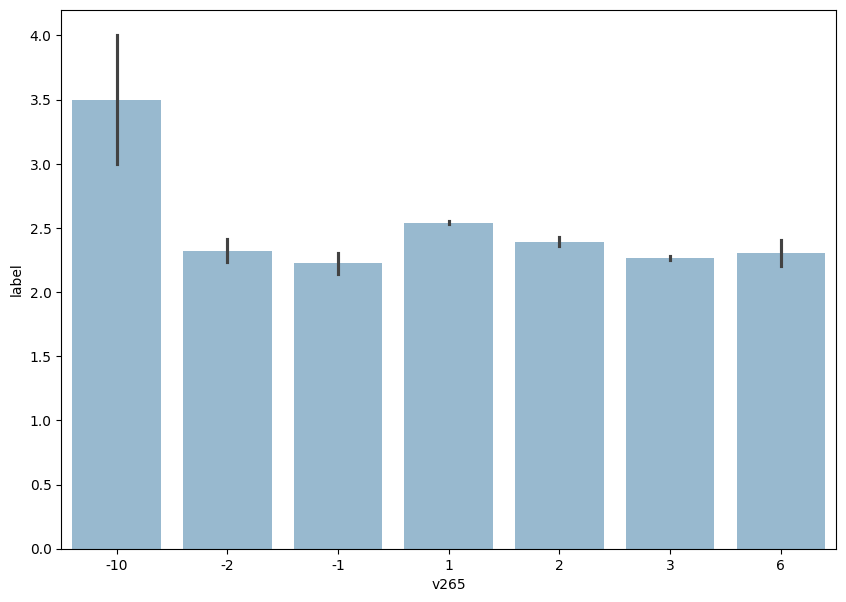

--------------------------------------------------
col: v266


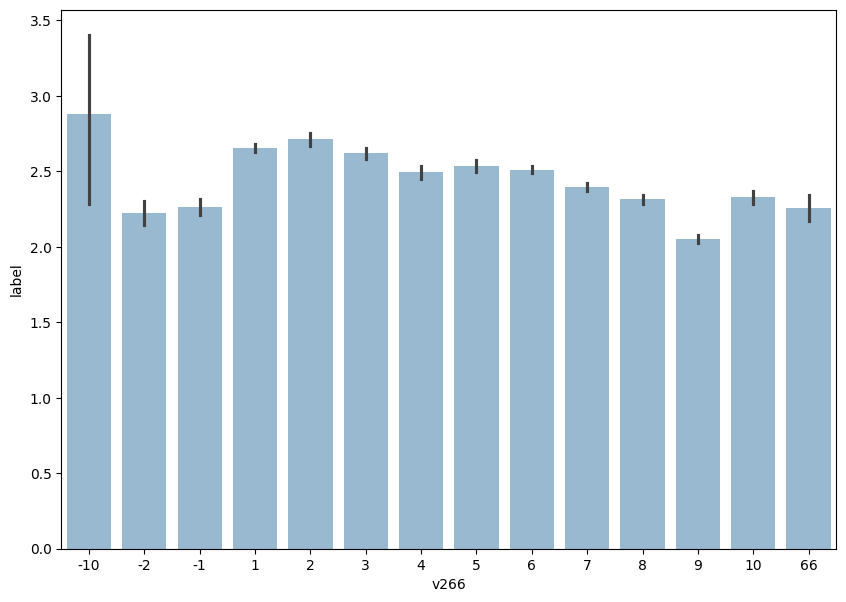

--------------------------------------------------
col: v267


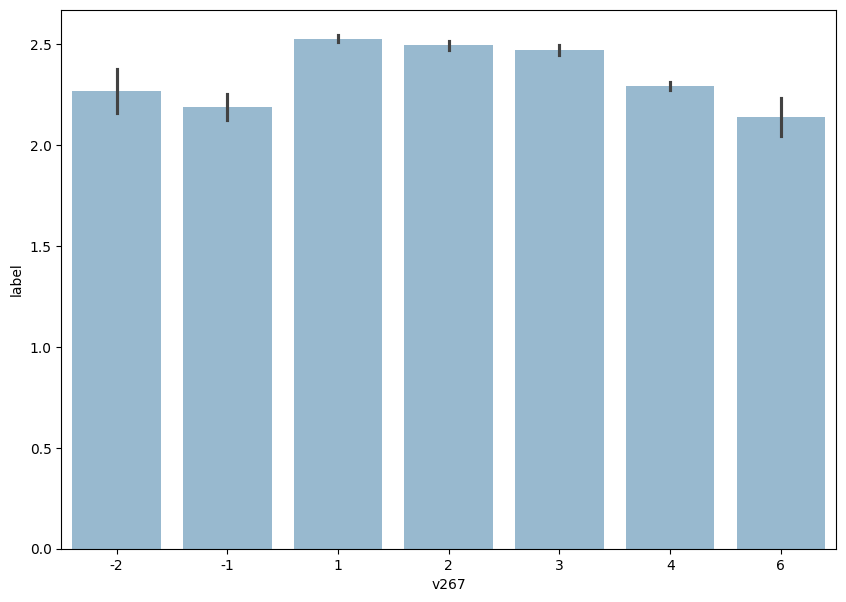

--------------------------------------------------
col: v268


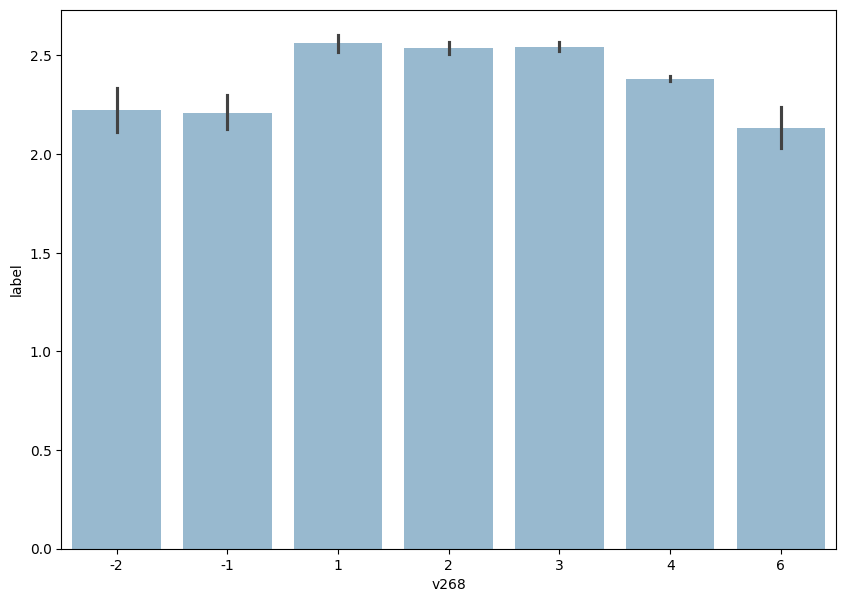

--------------------------------------------------
col: v269


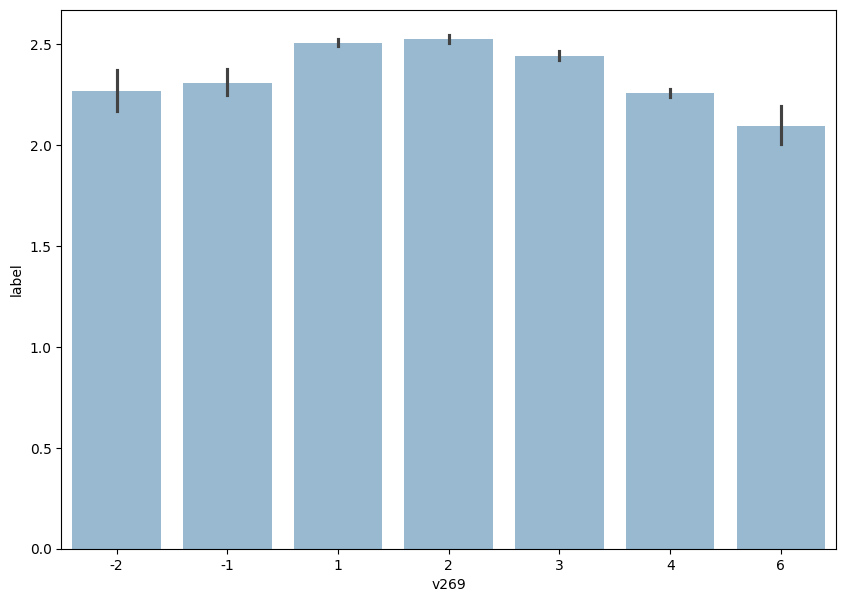

--------------------------------------------------
col: v270


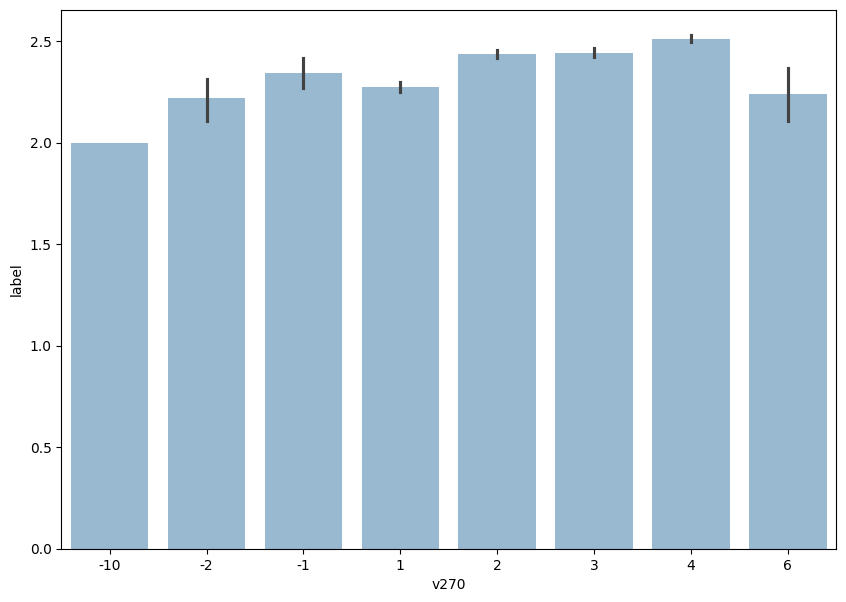

--------------------------------------------------
col: v271


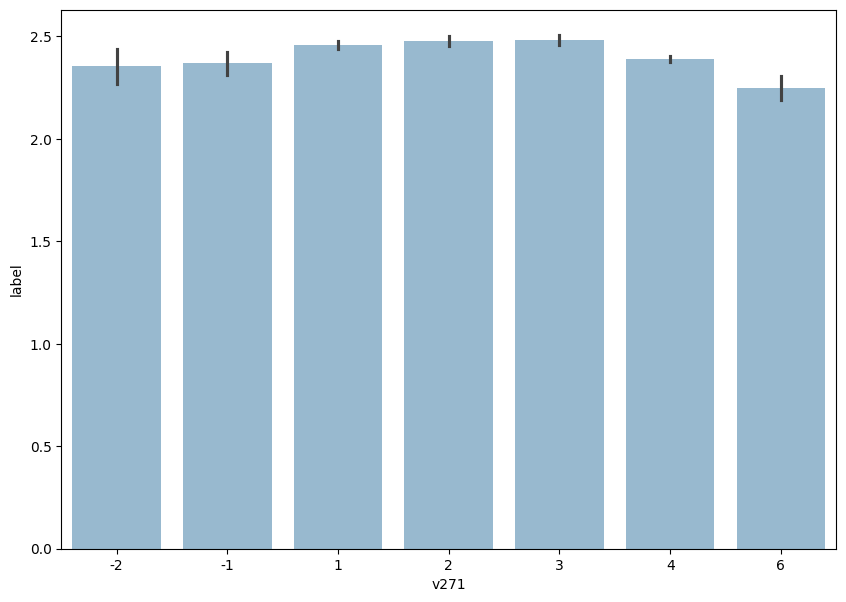

--------------------------------------------------
col: v272


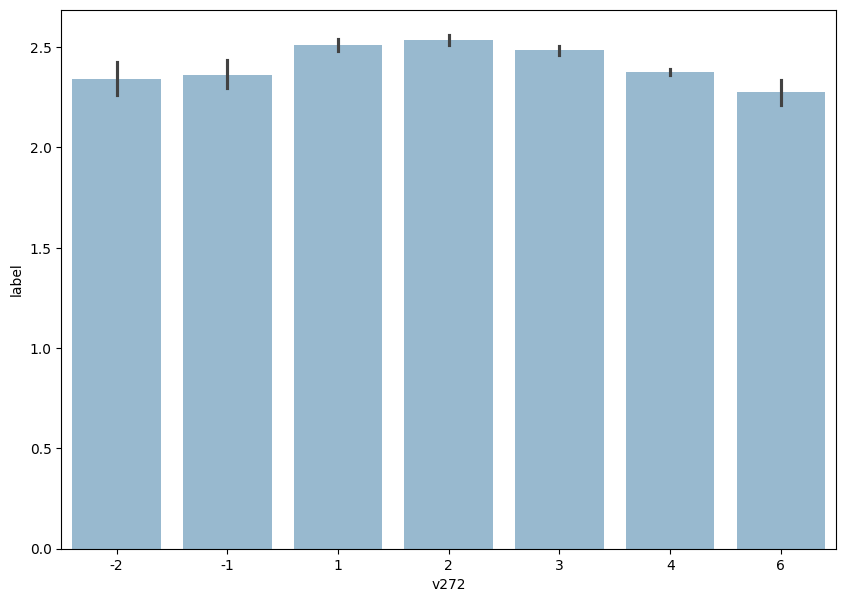

--------------------------------------------------
col: v273


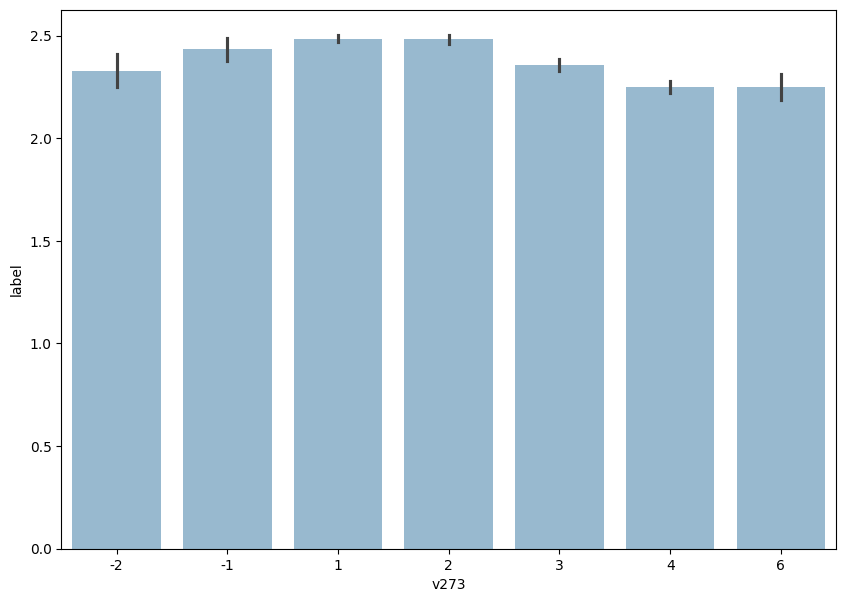

--------------------------------------------------
col: v274


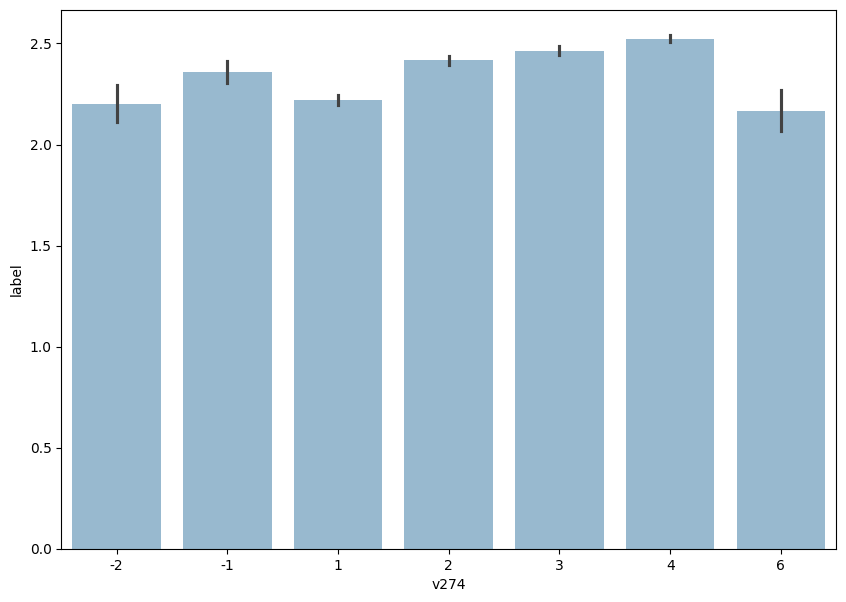

--------------------------------------------------
col: v276_r


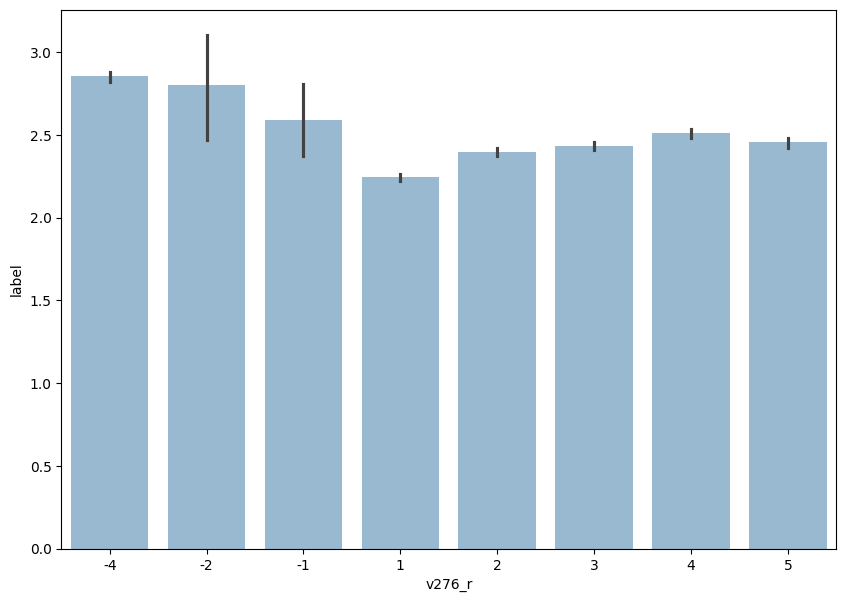

--------------------------------------------------
col: v278a


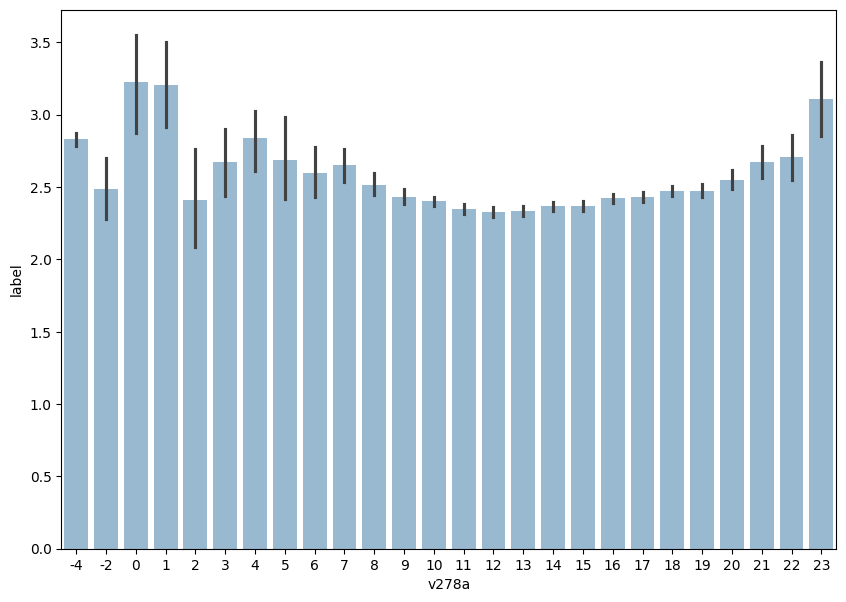

--------------------------------------------------
col: v279d_r


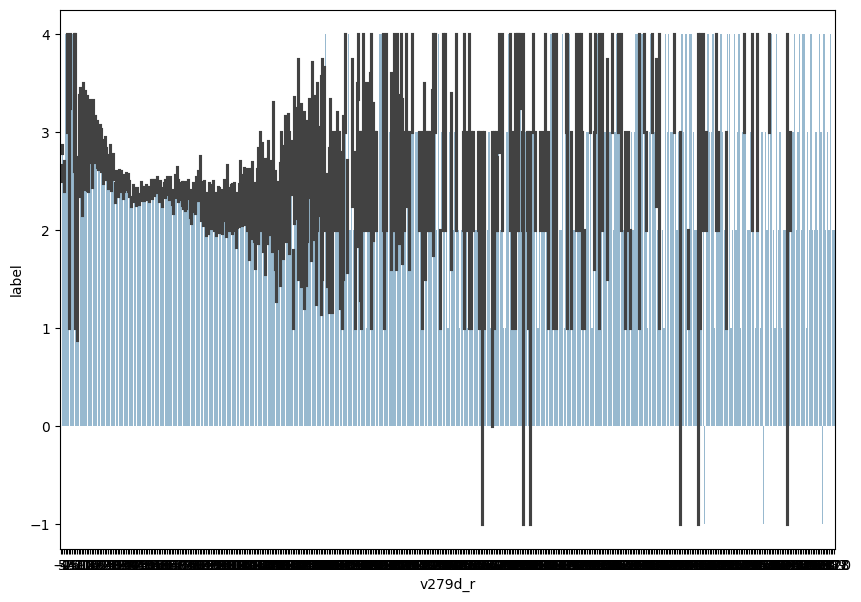

--------------------------------------------------
col: v280


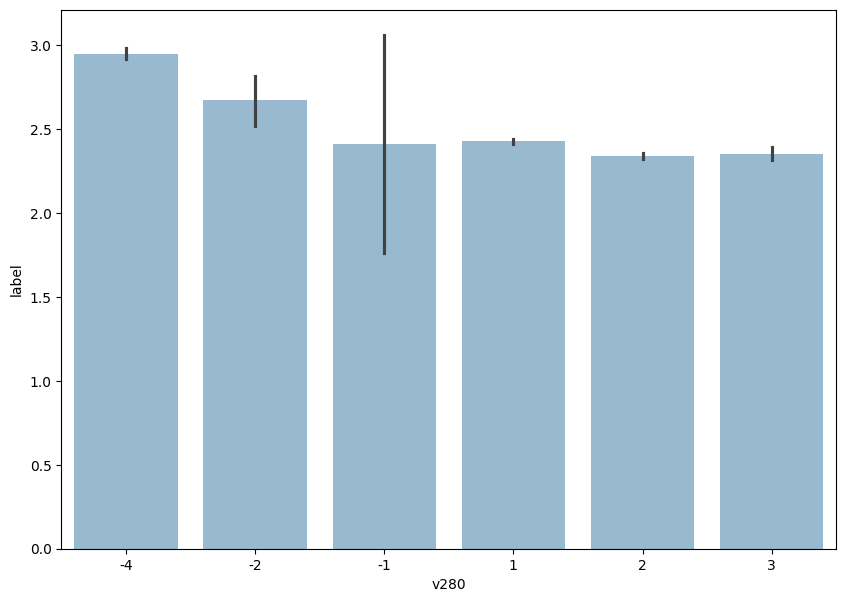

--------------------------------------------------
col: v281a_r


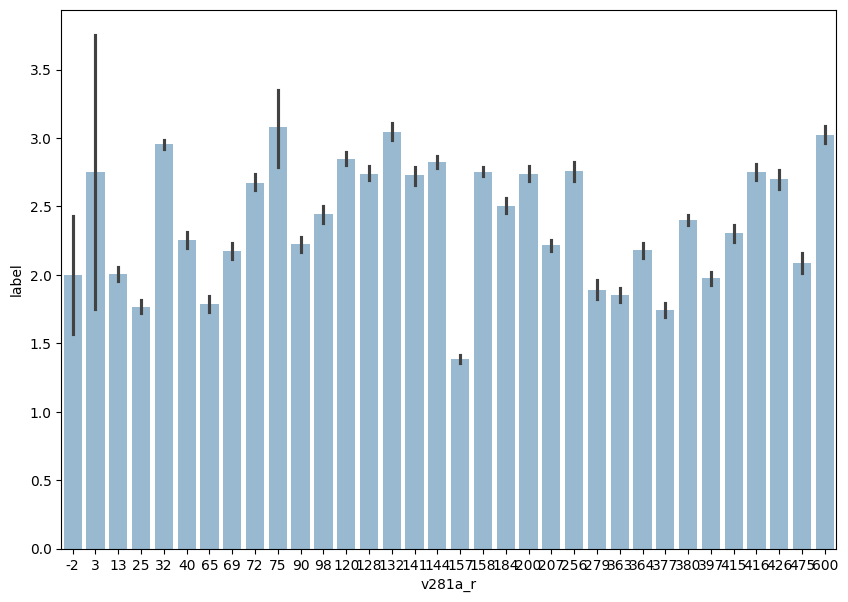

--------------------------------------------------
col: v282


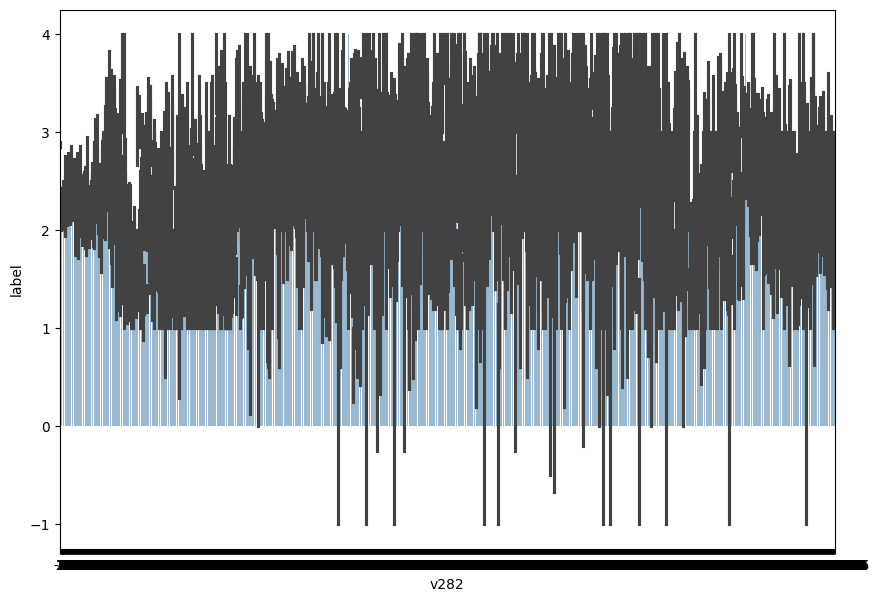

In [5]:
for col in df_train.columns:
    print('-'*50)
    print('col:', col)

    f, ax = plt.subplots(figsize=(10,7))
    sns.barplot(x=col, y= df_y['label'], data=df_train, alpha=0.5)
    plt.show()

